In [1]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn

import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image
from functools import partial
import pandas as pd

In [2]:
import numpy as np

In [2]:
names = glob(os.path.join("lol_dataset/our485/low", "*.png"))

In [3]:
def load(name):
    img = Image.open(name)
    img = img.resize((256,256))
    return jnp.array(img)/255

In [4]:
imgs = jnp.array(list(map(load, names)))

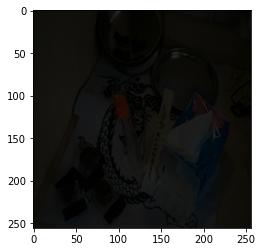

In [5]:
idx = 234
plt.imshow(imgs[idx])

In [6]:
def get_enhanced_image(org_img, output):
        for i in range(0, 3 * 8, 3):
            r = output[:, :, :, i: i + 3]
            org_img = org_img + r * (jnp.square(org_img) - org_img)
        return org_img

In [7]:
def color_constancy_loss(x):
    mean_rgb = jnp.mean(x, axis=(1, 2), keepdims=True)
    mean_red = mean_rgb[:, :, :, 0]
    mean_green = mean_rgb[:, :, :, 1]
    mean_blue = mean_rgb[:, :, :, 2]
    diff_red_green = jnp.square(mean_red - mean_green)
    diff_red_blue = jnp.square(mean_red - mean_blue)
    diff_green_blue = jnp.square(mean_blue - mean_green)
    return jnp.sqrt(
        jnp.square(diff_red_green) + jnp.square(diff_red_blue) + jnp.square(diff_green_blue)
    )

In [8]:
def exposure_loss(x, mean_val=0.6):
    x = jnp.mean(x, axis=3, keepdims=True)
    mean = nn.avg_pool(x, (16,16), strides=(16,16))
    return jnp.mean(jnp.square(mean - mean_val))

In [9]:
def illumination_smoothness_loss(x):
    batch_size = x.shape[0]
    height_x = x.shape[1]
    width_x = x.shape[2]
    
    count_height = (width_x - 1)*x.shape[3]
    count_width = width_x*(x.shape[3] - 1)
    
    heigth_total_variance = jnp.sum(jnp.square(x[:, 1:, :, :] - x[:, :height_x - 1, :, :]))
    width_total_variance = jnp.sum(jnp.square(x[:, :, 1:, :] - x[:, :, :width_x - 1, :]))
    
    return 2*(heigth_total_variance/count_height  + width_total_variance/count_width)/batch_size

In [10]:
class SpatialConsistencyLoss():
    def __init__(self):
        self.conv = partial(nn.Conv, features=1, kernel_size=(3,3))
        self.left_conv = self.conv(kernel_init=self.init_lk)
        self.right_conv = self.conv(kernel_init=self.init_rk)
        self.up_conv = self.conv(kernel_init=self.init_uk)
        self.down_conv = self.conv(kernel_init=self.init_dk)
        
    def init_lk(self, *args):
        return  jnp.array([
            [[[0]], [[0]], [[0]]], [[[-1]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_rk(self, *args):
        return jnp.array([
            [[[0]], [[0]], [[0]]], [[[0]], [[1]], [[-1]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_uk(self, *args):
        return jnp.array([
            [[[0]], [[-1]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[0]], [[0]]]
        ])
    
    def init_dk(self, *args):
        return jnp.array([
            [[[0]], [[0]], [[0]]], [[[0]], [[1]], [[0]]], [[[0]], [[-1]], [[0]]]
        ])
    
    def init_params(self, conv, x):
        return conv.init(jax.random.PRNGKey(0), x)
    
    def __call__(self, org, enhance):
        org_mean = jnp.mean(org,axis=3,keepdims=True)
        enhance_mean = jnp.mean(enhance,axis=3,keepdims=True)
        
        org_pool = nn.avg_pool(org_mean, window_shape=(4,4), strides=(4,4))
        enhance_pool = nn.avg_pool(enhance_mean, window_shape=(4,4), strides=(4,4))      
        
        left_params = self.init_params(self.left_conv, org_pool)
        right_params = self.init_params(self.right_conv, org_pool)
        up_params = self.init_params(self.up_conv, org_pool)
        down_params = self.init_params(self.right_conv, org_pool)
        
        
        # left kernel
        d_org_left = self.left_conv.apply(left_params, org_pool)
        d_enhance_left = self.left_conv.apply(left_params, enhance_pool)
        
        #right kernel
        d_org_right = self.right_conv.apply(right_params, org_pool)
        d_enhance_right = self.right_conv.apply(right_params, enhance_pool)
        
        #up kernel
        d_org_up = self.up_conv.apply(up_params, org_pool)
        d_enhance_up = self.up_conv.apply(up_params, enhance_pool)
        
        #down kernel
        d_org_down = self.down_conv.apply(down_params, org_pool)
        d_enhance_down = self.down_conv.apply(down_params, enhance_pool)
        
        d_left = jnp.square(d_org_left - d_enhance_left)
        d_right = jnp.square(d_org_right - d_enhance_right)
        d_up = jnp.square(d_org_up - d_enhance_up)
        d_down = jnp.square(d_org_down - d_enhance_down)
        return d_left + d_right + d_up + d_down

In [12]:
class dce_net(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        
        x1 = nn.Conv(32, kernel_size=(3,3))(x)
        x1 = nn.relu(x1)
        x2 = nn.Conv(32, kernel_size=(3,3))(x1)
        x2 = nn.relu(x2)
        x3 = nn.Conv(32, kernel_size=(3,3))(x2)
        x3 = nn.relu(x3)
        x4 = nn.Conv(32, kernel_size=(3,3))(x3)
        x4 = nn.relu(x4)
        
        new_x1 = jnp.concatenate([x4,x3], axis=-1)
        x5 = nn.Conv(32, kernel_size=(3,3))(new_x1)
        x5 = nn.relu(x5)
        
        new_x2 = jnp.concatenate([x5, x2], axis=-1)
        x6 = nn.Conv(32, kernel_size=(3,3))(new_x2)
        x6 = nn.relu(x6)
        
        new_x3 = jnp.concatenate([x6, x1], axis=-1)
        x7 = nn.Conv(24, kernel_size=(3,3))(new_x3)
        output = nn.tanh(x7) 
        return output
    
    def loss_fn(self, params, org, loss_spa):
        output = self.apply(params, org)
        enhanced_y = get_enhanced_image(org, output)
        
        loss_ls = 200 * illumination_smoothness_loss(output)
        loss_spa = jnp.mean(loss_spa(org, enhanced_y))
        loss_color = 5 * jnp.mean(color_constancy_loss(enhanced_y))
        loss_exp = 10 * jnp.mean(exposure_loss(enhanced_y))
        
        total_loss = loss_ls + loss_spa + loss_color + loss_exp
        
        return total_loss

In [13]:
def fit(model,params, X, batch_size=32, learning_rate=0.01, epochs=10, rng=jax.random.PRNGKey(0)):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

#     loss_fn = partial(model.loss_fn, deterministic=deterministic)
    loss_grad_fn = jax.value_and_grad(model.loss_fn)
    losses = []
    total_epochs = (len(X) // batch_size) * epochs

    carry = {}
    carry["params"] = params
    carry["state"] = opt_state
    loss_spa = SpatialConsistencyLoss()
    @jax.jit
    def one_epoch(carry, rng):
        params = carry["params"]
        opt_state = carry["state"]
        idx = jax.random.choice(
            rng, jnp.arange(len(X)), shape=(batch_size,), replace=False
        )
        loss_val, grads = loss_grad_fn(params, X[idx], loss_spa)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        carry["params"] = params
        carry["state"] = opt_state

        return carry, loss_val

    carry, losses = jax.lax.scan(one_epoch, carry, jax.random.split(rng, total_epochs))
    return carry["params"], losses

In [14]:
model = dce_net()

In [15]:
model.tabulate(jax.random.PRNGKey(0), imgs)

                         dce_net Summary                          
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs                 ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[485,256,256,3]  │                            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_0  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,3,32]  │
│         │                         │                            │
│         │                         │ 896 (3.6 KB)               │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_1  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_2  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_3  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,32,32] │
│         │                         │                            │
│         │                         │ 9,248 (37.0 KB)            │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_4  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,64,32] │
│         │                         │                            │
│         │                         │ 18,464 (73.9 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_5  │ float32[485,256,256,32] │ bias: float32[32]          │
│         │                         │ kernel: float32[3,3,64,32] │
│         │                         │                            │
│         │                         │ 18,464 (73.9 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ Conv_6  │ float32[485,256,256,24] │ bias: float32[24]          │
│         │                         │ kernel: float32[3,3,64,24] │
│         │                         │                            │
│         │                         │ 13,848 (55.4 KB)           │
├─────────┼─────────────────────────┼────────────────────────────┤
│ dce_net │ float32[485,256,256,24] │                            │
├─────────┼─────────────────────────┼────────────────────────────┤
│         │                   Total │ 79,416 (317.7 KB)          │
└─────────┴─────────────────────────┴────────────────────────────┘
                                                                  
               Total Parameters: 79,416 (317.7 KB)                

'\n\n'

In [16]:
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

In [ ]:
params, losses = fit(model, params, imgs, batch_size=16, learning_rate=0.0001, epochs=60)

(16, 1, 1, 3)


In [20]:
params = pd.read_pickle("dce_net_params.pkl")

In [92]:
test_names = glob(os.path.join("lol_dataset/eval15/low", "*.png"))
test_imgs = jnp.array(list(map(load, test_names)))

In [108]:
def plot_results(images, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1)
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [105]:
outputs = model.apply(params, test_imgs)
enhanced_imgs = get_enhanced_image(test_imgs,outputsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAqsAAAE+CAYAAACqWFmcAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9Wa9tS5bnCf2Gmc251tp7n/7cxrsId482IyKzMitEkqICJdUJKUsqkED1AK8IJL4A4hEkXnlHSEggIZXEAyoooChQQWaWEqWUbWVFRmSEh0d4eH/b0+xmrTnNbPAwhtm0tc+518knUnHPdL9n773WnDatGTbG30Yrqsq769317np3vbveXe+ud9e76931r+IV/v/dgXfXu+vd9e56d7273l3vrnfXu+uLrndg9d317np3vbveXe+ud9e76931r+z1Dqy+u95d765317vr3fXuene9u/6Vvd6B1XfXu+vd9e56d7273l3vrnfXv7LXO7D67np3vbveXe+ud9e769317vpX9kpf9uWThw8UhQqoKOiGbgVQab8HwLMKqH0iAsp5pgER0Hr+vd+OvCUpgfbnpL2R7TfdXintG3tH8IeLPx8AEUUQKoKq2j3S/0EERAJ4dgTxTvU++FvbzVuf3rxEeqt9HK0lkbA9JYL0OZCzuW3Pf1muhjZ3vUWxfrbPt37X/rv4mKv2R3ws2oaOBH9cW++2ia7DsMNbxh+wKdTWwz7HSvBmqujZKFUgjIuJNSJn69pXvc+StvsAlXszpkM/RIeVsLfWcZ2HVe7zINvYpHet0WAbndGSDXOYC/+1vSMGUG090OEWsb3Vx9FH26cBHfbGSHKVvocqNp9hmxxvqXVct71mVLA10mfNf5ewkblt1j5Ordrn1N49DFmC/xxmQkKfxiAJCZGYIrs5EoKNPQz7SDjnGHLW505R7YX0Ieo4p9sqS4Df/+f/4u2b9C/o9X/9D/8vygpLhCVUVAuHdWJiIU0zi2SUSJQdJEjrQl4gpj0ygUqm5AxAmqzNskSokbgHVribFhIgxXh/CJGSV9IExxVCSgRJQARgz2rtkNEixldSJjOTp4kdmdn5+V2GDFxNkNIKdSbXxIKyWzPxYqJkCApxjoTdTMxKyZkp7VFWCgUlEJmJHCkkwhwJKQKB6qQesR0gAUKTG0SIUApUKgQhxEioQIwmS6ioCBqE5DJx0/oElLDtJzb5qM4Pa4CJhAb13SjWnuiwO40zhL6HIkUVUTUZEgSRglaoNRCngX9WUIoNqgRqUJPfCGmUKb6FGt8o1fdcbDwYIgpVKKmABkQFRKgiBAp91zmfCijFZzbGaNyp709/Qp15eV/EVoWqoNV3vWhHFeJzqWr8x+azADYPaHVea3NVFaIav258UCggJmVqrVDFxsLZ4tk7UFICNFifpCI+PpFACZArhFoRqS4rAwSnp4rRi3/c2pfVyEtRqhqFJAJGkOKSxeRtAHJdqQTbY04ZNSyEGqgBVIvLN9tnoQJlhRCsrVKpa2Y9QU2RFGyemuwPcSYCMiVEfSVCJEWoITCFCWJi2iUO+0CIgapKCBvzbzhQm6gfMJLJNKGiHXeMco2Gw9qf2F58//0nb+XZXwpWYcMOoUmGUXB+AVjjTJDZJHTRaSs7iGU2TDO+l/bedtV7v/mmlrYRxo1+/9ltGuUtqbqaQK2cT944IL3XtjWjZ9NggroJ3yb8G8ZozMj7KY1pyLhXvDOKtucaYYXh7TrMpQzziPiG8nWr/lNCnxunIYLcG5H33Xiabh1XXzn/kcYJQxA5h18GMoVANQKWNveh37IxofN1r/2d2p/rHd5m+wxejnPXAFnfD37AOgN79OZAfc1HUNz6sN0y/OFMc1j07dcN7Ler09Lw+caOtudbG6JCP9ictTX0qWNxHeawHVDEgel9UNzefLYT2mj9EwcRI13fa6G3KuNnwz1nDEnP3yja8WV9Y7+rPydnizPykDd2rW4Ndcx6/5Z6/6G/+Fdi4nSwJdrnSlgDFVgXiBMoO9rRUASYJqJCTdVAmyqRlcxEBBYBiQUJipIowC5DTZBi9LkvzNPEgr1j6iKqEChkEoWVwIxEAalImkis7IAokXbs2k2wIyGSKCURqARdmasQJxNXMUEIAQ3CWgxYh5QMEkcDFIHkoGlnQKhCLdX4b7X7agzEEAkaEYVKMQQbDURoxAGlEmOyd9rbBr5eISQq1elbHLQFYty4Uz84B5wfN1ZvoCkANdoBoA73BHHFjiqiYtKi88aIxEBsPNvb0zDwsaBEgyT+f+noVBu/d6CSYrVN04Ck82+NEMWRWLA++fGYStjA6CAH0eAgpvEZg5zi/LbtWYPkm6zUUPtQGvvQ9nujNi2kKNSGkggDSzLZWdqk+xskmKLK5G9Ags2ZVh2UbhvPbgeaIKZ0UNgUIlWYRCGEznsLlVCbMk3ozM7IHQ1QQu2H+a6v8ZdUzoGqvT+hOCCW1rtk/ax+KFDj25VKoEII9jJt81uoMRIiVAJI9TEmA86myUODyfLoLQHUoKQw8OwNkbaF7rJmVE5KXxdXTLW1c1prtG9K0G19hS/n2V8KVgOYJg3ZAISog51NaNsaOpwdBiSYprKyrd3wT0fjDZi1q8FbW54RlqiTmrcRRvFr33SA4BQh/kfTirW3qw6bV4b33gNiW5/s/SOGasJeBwB6Pnts7/BWmkZ2Axg6fGtIs2lAxfuow/sYntEOjrdr7NfI1/oAVYe2pM9eY1Ct0w2jMoBa7cB0A7PS5qwDwva7DExAen/tqts9YzudVobTf7/P569Nqn+q58PvYK3fJY3OdADPrf96ptGX8afeH5LeA52te9L/va9tbOO6f/Bh+Eza6HSAZNa1vg8GEt3aGmi29asOAmsDiyNs3CwT/dkRCPb9so3tPvm0l3eNu2taOpHKuDrDGH0/qpyPXfvu0c6w2pyN/Ly/v5Fqa0Hv00CbtbcA3K/ANceCpkjRiEYh7AoJKAGmpIQo0EBaCsQCeSrUYAArMCF1YiUQQ2EXIlKNF1URwlSYy441QRQx5Z2AVmHCNI8TJlxraKA1gMFSE7xBQQK1rkjYMTMeNiohKpREDRNoBi3WniZCsl5KNCuPtZ4QhEjTOCoQqSSUQHDwFsSAVkCoUh0IpibISCEabYWKxAASabgDiYQmjQZLjQZTnQURsxKo+N4VJCpCA+K+F0UIruHb2KhtmgCGIfombRJd+/6BQaHQFRWumfW+0ficuPzWbcepQBRFcS1p23TWOaqD48bXG84QVar3tWqzjAZwLfPIo4M2nqN9rgxouwwZ8Is/Ylpjn0PTPGLrqGqmqbpRiFnvtr/POGwFCUIIULX60F271zmNc51BHjS+tPHHJpsUUZP9G45SglS0WvdUDAxT2rJtluamgKBusr82DbEagEWCHaBQuhYZO4wFDd1S3PpVyDaapu5V1yQPGEQAqUJ1a1itAlREq+3l4Ja4Xex4A4RiW5Pohy+CQtBBhrjFsFsZh77JJlMGMeRiYrMiMMjSfxke/eWaVdkW7z7Yk7AZraURuDZwu01sO0lsQIwOBNozHdQMxLuBmFESvQHNuuKtaTTPlT4+odLE1zDBrS8N8HUg1qHw2RwoTXifg4emlZPzp7b2N8jRv9eRoMbG+txtWtD2SRPpZ69gAL2ct3E+hu2edkB4w8FgYGi0dRnu2cY/Pqfnj/aenneoz4DTeD+knL1/67OePX0+pnbzuWH4nEacFdMZzNDothpOy7I91QhRh2feIKeBGs5bgjOQ9MYAz8d59oGMO+tNanpj+G9pftyd0vvXvtThxwZc39qdcT7bnr/HWJrFaGA993p6Ru1vHUnrg44HsuHeUcb2Q8BZP5z569smurXzL8MK/4JcQZgCBBVqCCCBUCshTqR5ZwAtJkKciDESc4VgoMr0dkJgIiLUmkkpElySm44qEjMQqoHVICTBzNEEEDUXAdmosBkx1c3qzaxdNYBMRFc9Gc+vICsSIMVk91BNw1UDIRiIlCDE4AcVNX+FCCZp3TSrEikSTLPoB7kAJBGKqI1YpbuRSWiH/NB/FxdUNYgDLnFNl0MLN+WHQclA32ebFO+SqysrNhm4fb7JJgTU+0ZVA8KN3vsJ23jWqBnUDmTb7012DHui76PRgqIGAJt/XD8BuvXsHs/u3RgRnjetrs0ad75SObchbt9sR5oGJOnztvG0jS83NtzfP3w3ti6tn2xzoL2BPjo2zeD5/PR2zz/aJmCQkdanhh3OMYJqkxVtdBvI6+2KEkYE54sZfBDWD3uuMGKDAR52V6zNAtgkYVWluUJ2V61aUU1uKBiIyHdtWx0Dxm0snBPCIK+2Cbs3VX1MRq92uBoc1Qbs8WWOj18KVns3Rmmpjt47GBsGL05eZ2CMvrC9KWl78z7h0E+E5z522xzIOLjW7IBQ9ay1zePStd3GANj8LWsfngzAZRy/DmMTn+yztWLTPm47Vzv22U4tG3Fq78PZ1Lo56OzD8Xvv7RmDGd57LuDbOTAMI/HvGpeUe+NoX54BR2Mz7e/z/g7PnE2K+FMy/D2+ZwAkZ2O9dxhxKu/3DT604yltYxrb5yJ03xyfkKHPIzWdw+vzqW/MYxMwZ5drN+RsIrvc6bQnY1vD780UtPn4bmKtC6Bzwu+agnEIrV9Bx+kd99z9A4Se033rkb55X98LXUgMrdmG3Uimy+b7OtlmmpJNAPu75Ixot7kZBd35pRvD9P6Mh9zhrrcyzr/o10pihxCDkAVqSJAXprgnHHZINWAa4kQIgRALIQaCTNh6m5fcTGRZzfzrMtD9OgNVIFENMEows26EjFJDRSSZ1q6aN3UiUjQT0A0YCkiMSKlU2TiYhEAu4gZP889UM3DSrOolGDANiIEi55sCnesEqSYQY0RKQJpPpDnIY48a5TeNl1mUjcdr2Ohate3RavPh8q76v83ncwOeZrKvg2zokkHtKD1a1AC0KsRqWF3iOQgDl7v4tm471wHmqHEFVNRjM2xOw8BD1dvSbmvf+qRis9d9OdkAe3+n3Ocm0jWd7X1K2XzRdQOKG9dvPqi2TwMb2K+DHViAKq5VHZUpBOchdeO9MlpYKi24IrS1Utxv99yyuB28GzgbUUM1ehm0uMbylVr7Jz5nDfeoa1H9FVTrW40bz2uvVztUatPaSZsvF89aUQ1nlj1x0G/uCYJWc91oe6rhiipq7iSuQa1iPsziqCOilKrUtRLmTRIEEacp9xGonWj6mrV9M1Av/eUb/HuD/6rPnY5C/+yeN13pxusX+qx2oTMArQ28nQsUG8Lgp8MgbNtmkjZovffkOXA6W1Qa3NkE6/lW3x7uAPGs747k7wuz3rJ2dHDW+zeQ2YZC5KzPHuQiWw+3odoiahu3DL6MbE4N99foTUEtmywfhLrZD+Rsfdpv3Ueng7xBsA/veZsv6Pk9b37a2rvfnTbkoMMoBwed9lttp82B0Y+Ax9ppwm1wRTibYc7aZfj8/Ft/8h5+afTbw4zOJmBb//MNpG/82vrWAp3aQN7sw3Z/e+/bgfIwV53gz71Q7+uW7ZttE5zt1XtjVlp7g8bHucw2z1tbggHhMrzZibqbdxSoObuJOXTTIAhRIJiTWBd+9/d1G4e+sUaDYO5dHQ+HnD+wjeaeW85X5JJEIAGVqpWagQxpStRYSGI+mmgktghUN9GrC2jTZUYoEQtMKbaH40DjRLRWqigSk9PGibREdHK/ydhCrArhVMhxovmuhwA1F6JArhEhECVYQE+cqSVSdbVDt5oPX7ToFPPtrDiQCMzR7wFETAsrIlRWQonUWglaiQ7btAKhUCiQAuJiUKtaX22gaJDmEmhAuVpgTCSg3dQbDAw4yO12iyAEIoOukK7hjI1txw6ElEqsUNjAJdA1qt22JgauVQUt/j7Bgx83eQeOyXuQpEspCWhVQqR/3mJAoiSa6b75nXceJ374r5tc7ltct3eqOeyaDyem2Vdt1i7rayUMjuvqWj8Z/H63LR20UDRsWkEVJMAKWyBwo2MFkvlzqoaxc84QBmswtl5Fix+IQGulOUqF4P2tDTwGv9/crQxUB2KbB59wP4p0GVWdRgxj2KFJxf13RUmqHnDcHB7VfJC1khvv9LayB5UlErW6CikY2I3VAhP9WEdQIdVsPqskUoiABWyZF3OlhsjdyzsurybCfkZiRKtATCSEGGIfXMcyjTYbZHIs3/j2hiSavy9ts54RTFuZNneNDt8WtN2uXwBWbbJl0CyNAPW82a5k7y/fiO5tEOiL33kGQLqPJUPb52L9TDEzvK89vxHrCHa3Pqncf/L+uM6/eRMI9Km/d+fQ7rDpt4/F92yDIV/Uj60H98Kx7t14H4rdv+oAbKR3eVyzLxL89sx9cvRP3Ua0DU3vPX1OpPd7N0LlcW3eBG/1LU9vY9C2c952+cebN9GbgFbu3y/cu3O4qxNe84B6s1/398L9lqzfm2B5m5dl04C2ORoZeWv3PMjM1knOPrtPV3LvCf9toNH7++RcA27RuJueoHEuYzebaFb383M+0nysvmh8bwBVb+Vs87xlncYHvurXdMPCRCQRq/mkCjADaHJTa0WlUOJMJDMDxWGSRZ1DLUdiatNrgRyaC5VMbGIjRPPvZCEws2aP0S6rgyQhkghEjsnoMIoSRSk5oMWbiGC+qbCWAFqgnCBGJG6H9AVH3rqjpuTrXSk6UUsBCmHyaPwKGiqlVIiB7JQo5C2AJEaCux+oKBoqqZrOlmABWQgt2BpSQGuLgS8I2iOzQakeQ2GgyiKvG2DrgxAwx8A4aEWbKdz5e4sk75zFTehV0YGBhaAWPV+U7tjY90O13Rg2hYjxCoUQqbWYPAw4EKxobg03P82whbXXDrlo1gzxntn+Ng1iCwTq/E6LDztY6I45RyPReYdGTDPo79aGM5xTVdzrl83vtAbLNxAcB7l1R6r1w8ZdfMoNlIZgBzgckG4Q3pVFlbP3ag19DrUtH+o+nJCw4D9Vi2IOEi2Ir7Va2zyJR8zVvr7mioLP1WrZHLT0RCwKHZZq3Q4TgUAtQFyhBtOgKzaHAQIrECi+tnUjJUqZCGTbE+KflwDcUnlAVahVKWQmEjV4YJq4K0IjOzHyDX1uXaGkI/bz1ex+uvSfTemnm46tX1/uBPD/g89qk1JmcvDJlLcg4Ea8g2qkv/hMhd9A0bkA7QOVsycZ/zyHQHpf7p0J4rNm3irEZJsc5yHbQ/fhyz14IGMrGxjYmMKbYEv6S8aBKGZWlTFWbHyTn6LH+fDNtOHvDg56r30c4eyF51ByZA7jWEYw1Hre7j4z7W4vPrveSmw+yS1gbfN/Gt007k2APze4qp+/v4/au6PjWpyjnraRtiPFaMoa9cqApyk5g3ubfc23xNsIyxjuW5wFzjWJ0qfD56OxyGHfjHZuX8s2TzCuZHO/OZ9X3nrvvT5JoyHtdCbeB9VtRvp7FUSiMWfKGQnjQmSepjNfxY3aPPq5qam086zN2vKG38N2qQ9ORj7SX6D3+vLGk1+tK0E5JgcpKyjkPFGmlT07WhoZCzkohBg5nk4YJMggSgkBcibERCygycyxdRU0JUo2cBsJZv6flKonTGPj4rgaYDQIWbCQjRVp2rMAMcJKhFpMGxpAS7GHZjWJWttRzOxEKV2SK1CFEO2/WhcCE9bZpsUyYFQpXdPVeIh9amBDSG4Gd23icPIL4sBK1ARvre7NYm4tUi2Nj/Z9464SYgCquQcEhwwGCLA+azU56j58iGnyLHuic7wm4GukBNtVnRWBz6MSPJDGFtYDo33epDYU5la1nhqKrSEGl6nAFhSEEvyLqmI+lWKBVjZW56betqoiRS0gHaU5a+DATFrKJTBe2oPRAkLpvETxtlQttsrnYIOCIKF6loMGPZudMnrPC4NTGPghJRA3Oa/VDl8+VyMLig4uGx00mSlSDfjWph21tirZAK7Tj4Z2DA/UUFuSCadCH6dFWBG0tgB+X9hADFCqZejYxI0ClUwlhrbcNg4l+cHJFFK12jymeElmBW7JCFKlryn5yJNnTwgx2jOou01UlMl6rwFxVwB1bXjocmuTWZ1iBiCnwJaWq83VZuVtuHB75E1MN16/0A2gXY141Vs/a1POf9EujejC6/yOTRCbwLSzatP2Nf+4TWP6VnHbRfjmg9LPfm+DPmfj6L3oznjao++b8G192frgvb/f+IZ0zz7bQNY4A/cedhPIhhmbJpuhL2+DkW3E21bd5nBbp/v3n/XtTF12PjPteVOGydmzbQ7OYN5GjdvCnb/1jIbOP713ovJ+VbRv8DeHszHdM1eToaUN4G2cWRnvbdeQL2MAauf9Hn7vAmODxxsEbuswgMezjvs69i824NWDEXXUIcu9OW83v42+N83rRjFD7x0pt16bdkS6vr2/yxe/aiHnYoIpBOZppqpQSrk3qwOsldH8tsFV7ffSQTLKGz5M96llDPS4T/8DdD1731f6KokQa8+JC5bqh7ijiPnWbTSpbhKfqHVBaza6CROESAZPBWX3B7dJrgFKXZCWS7UESoRpqpZ/kkDsvv2BEKprigKqxQGkIEwkJssDqmrmaTzGXIBg+VJVsWcCxJK786pU96uTAGRHgrXTW1CP4K+mYQSXRyKekYCeusj2gh+ZPYuBiTHtPNqwgjr+0p4zEypSo2lnpe3Q1q86bnEQ9/EceHubqaq+Pqpm7VMDvpgF2tdz05I2y04NioH07RKanArbHuqsYxSytriC9uCqgZ12v9wG5o2kzNTcDudboH6gypYKsMmOLsfavHaZpp0nDSjH2Y/1S6v5Xkqb08ZtavXJ0f5u93swmmhz5C02mV0JbGrU4Ppe76cOPpOjFUfbWilItOFXNa2/JppuuQ3VtOmbLLRDTnxTFvi4Q1DLtFHxtS8uTqU1QVulGOx9DUr3HL5aEQnk5cir16+pGXa7Sx49eYTkiB7vTGPe5G0QbFdWJMwbD3cXE+iexZssa0qRkc5kk6Q6YBcdhN/mzjrgGqX3ZZjiL71+AVi12e+asFHOvnFtYtFOyT7gutGjD+fLGrknc0Yg4yBA7n3d+jlAhvuBIpUBscvZjzPtVh9s62ePlNmIYfN7GeYENX8XVSREy5SgdjJSIMVGauOb3yKYe6PDp28BPPfXVOBMU9ZvbkB4mL9t/PcX4M0wnO3PsxXw34W3afTu97UXHxA9X9rxzWcEP0AduT9X57Rz1lbbUWffjIJZzjD0l8Ga5hvW7txaG+/BNbZ6JgvANRv31lDpsuD8XQ4eanURJ3TQClBypailAgriGpSg3RFeaA7vjaF436pSaqXWSpoipViC8ZbPWQRyUUopls+6vVMsJZFWKLWQi4NVVWIqxJg8qfY9lwyFUpqfmn/USEQaXWrfX2c0pdDysDYmc+Zi8JYVe8s5iy78vsqXmr+wikOMADoJk2ImUNl4kVK6b19KkejJ4HMWcO1faeZz1wQ2Oq7ia6Rq2poIqhUtikrXJQIGcpMfwLSp1qQJWvO3qy2xu1iAzpqzJf4XEPGUUi1oys0ojScolaor5qvbrGWFsr4ixQtk3hlHb+YX59llOUIphGmPpB0AxyVTdOWwS0QXNjrMWAt8OXPYlNDwUfffo9EzG3luZGq+iC1zTguatMfaHDhHdgQkDsjaHrV7G/SrXUo60qPtsRZjb1/JOQttm+9t3LDJtQ1iDO26HA5N7TmYgGUL7Grv0a1BmouSbiPk3Fd+k/giAS11AEobsG8HC7qc9h66HAwSN//3HryklFo8x7jxnLZWQYLzYHumOL1OfrjpS+d9l6AsuSIaiCLEtFlVj3crxzUTQmA3JZa1wFTZhUguhRiEKVm6qqJKqNbmmgt3xxO3xyPPnj7g7jYzTzMpWvo1FO5uFz5+cUO8gP2cSMHef5gi+VRZljtev3hFzpXDVWH34MBhv6esK7qeNhmoimbheLswX0xIiLgL+JaSq62TKt0i5rTYDipGntu8jez6Taq6L0H/5Xj1L8gG4O/tQMh8XJp7TNs5Tdi0K0ggJuvIutYuVPvecCrWprHrL2gCK5x3ADu5iGJ+TAMocbiwEXj1DSbQcqNqbZU2PDn+wETOTdvb4sjgjI1WtKwQIiHN4zajqbu1rEP/jZHlUt2Be3JlgPQnO7g764uPaUBHbbO9DTDBCFDGhW9jbASlb9LJGSBrc7mBp/tA8D540MH/V87W4Bx0nmOHke3f2wyOspqpQdrDhs06AzcyUTdH48US5MzBu9Z2yvWABJ+JWqr7PW2HnjOBom2c5oe0MT4DYmpyCQlQi5JLIYQtNUhVM6/OIfaDCtDz/c0h0hyA1BfPTC/KslrkaWNkrS+nJbNWOyhFiRStEGAKpuEMIqRodF10S9mVa2XNhVwqe53IayXFSAhtzmBdMndrRqK9t5nzdjFQsutUSu3yb83GPIsItdbzbAtquSsTLb3Qxtw4o4q+iP25+9YQuXfYHN1H7INtsWV4brvp7G1fqStjgUgSPMAKiCkya/EopUQQT4IvmcZk9vPMfJhQUa5fHkErokoGtAVziFKqAV+NEckLkishBiQdqEXQ0nzvClrvkHKC9B5RW3he9P/MDlYpxOUGc4pMaLxAWSjrC6ROaLhEUiC0PRGCt+/cUtxjshZC2HWeT1nQ44+p83uk/ftOq43r+GHs+CnkO4K8jySzGtzcHrleb/nw6RMkJXrstD8vA9+jHVaJqAeCbcGNlVaMBdq77Rkl9IpZ3VtTxfdlGVxyRkHQ9ucW4tZk1LlXqo/RwfCWyN01ygzWnzPRN+xCOW9rlJGNy6sW8z+txm8NvLqPpmIBZAOAr7WSvYDDPEW6vAGoldOaqSJMMbgLiwO4JbMWOxzEADGI+ziDqv1Sajb/YAnEqOYDGoSbm4ValHkXSHPgdFr5+WeveXR5QAi8vlv5/FR48jDwjatLrm8XX8LKzfHEcip8+OQh026y+ayVkiuLVvZT5cc/e0klcnVx4MmDAxQ7NH3y82s+PZ4oJOa4Z1kWuJz4cB95/eoT5nni4dVDZkmcqvmKR628vr7lp5+/5M9fXvPb3/0Wyyc3XF1dcHGRmHZWfOH6k1v+4fd+yN2TmQ8eXvBwmphD4FtPLrn57DW7KXL36ppVQOfA69cvefjwiiUI66tb1lKowZOErTMlLlzJxDRPhBhb2EGn9412B57d+OuoAdR2eO1fb5Tftevb593VrR9C6PL9i64vBatu8ejdfQsk2n7vGhGIIdjJBkCWe+HWDbJB8cGagCqgZixCZj/5GEEHrUjNUAsqe/oJcZwZdfKvJ5eTyZCDCkmzncRciG6Qa2yjbczWz8q2m5VINs2B7u6pw8UhszF+c0w3v5iqhVwzO4++3YTrsPm1zYd0zXXvQl90YaODUelOB5LbIncYTMvMEHRjDB0Q9wHoNpfuQzRq6rZCANF9ljh7NnQXhuZb23K8iTPz7Sy9ncHo4ylVydmc4WMw5/AYo51U24nOH6jO9NZSOK0rIFzsZ0uijSVbrqVwe1yoIuymaKdSTOAu68paDK4GMY13jK4JUPPWz6V2xheiaTaCimlcaiWlwDwlljVzezoxpQkUA4ZViUl4vN9xXHM3heScqVU57GamFLEE50otyqqVKcLdcaUqTCkyp2SbXwtrNsBR1LSvti8is0CtKwiEEIndr8qxXK1kLawKS85EhZPQNbdGF1BKJmfpydIFKDFQa2GOHiHuOZVrzoCZq05rJpfBxOkpjkJo+TqdFmWj777PZOQtG021rBXne3Pcodo/3iqjcXbPm09+ta5bhSsxc6dFbxemZP6hXrapH+JCjFTNhKBM0xVTOlgUd1qptys1mUZTqvmpxVSoJcEMk0Q4/hjyZ8AB+E0iieJVn1K+I9z9lHr9fYr8W5QkW+4pWpL2YsnMj39g9LP7EI0HaoTL45+Q4nNK3ENIxFqpzHSXwxZdIxk88p6QIUa0KlLvmMufUteFWt53evGAGbHyqan8iFBuoM6oXiESWZcbfn73Ec8fXTJH98CVFnCeQCtjMRZ1YhbFzMKd/Yau+Wym/oDSgtQrtfPs7sYmQnN8avpQpZ1vW1sbnVep5rvrQNZ4sCknWtKwgLtYGEJAarVSxxvipgVB1SBehSn0Pak6eqibq8KaC3d3R6TCPE+c1pXdbmK3nxDPmWuR9LbPm8bwZy9eUjTyyx8+ZpesGEOplbyc+PMffsZ1SHz47JLHF4lJhLrCy89f8fGrI5nAYY48uIhcXARKgVhnCJnXN7csa2W327E7FGqNpBz53p98xs1y4vkHBz58/oTPXrziP/y7/4i/+iu/Qloj/8X3PuX/+ZOFf+N39/wP/9p3+dM//YQVJcfMn/7oJ3z0Zzf8rX/rd/jw/SfEOZHXws3rEz9bj3zjsfCf/Kf/hOOc+Pa3vsZf/dY3kJzJ6wt+8IOP+Vgqf/ZC+eFPC1dhobz/Hf7mxcInf/p3iBcXvPf13+D9/TOudWERuDjBq08+5vc//Zj/9/HE7/zRp/z67REOynuPZq6uJmqCyxfK97/3j/mPyhW//fgJ354OXGniL3/jMdef/pBf+853WesReXRJiInl5efIN75FysKLP/05r29ekxNkEebdA6YHwnx1QZoiolZwowaInj+441RpwfYbrxl57xaE0D5UEA9kaynGOvZqluvhHb4FvoxjfylY3aDlmVeaC6fNV0/PnlByVZLYGWyITTkboFs9u5CxGrsmuJoeVHBdqJjanWC5/M4ePOujmv8HjS2ZGSkFY45VLPXwG7hu+N3SWNgd3SVG3OdJlDKwDBkeDVHNPDqgzaYdbKCy/z70eZwTVTVA0k6pfpe5yKiZWcNQb33oeE+6MQjxDTqO8FzO1qP55lbd7hNyB5Pa1so5l3o/N3MunnPOdQRqoLURcIsaNJ+nDWy0cMBS4ZRX11ra3KcQDGTK+YEI8YjFUjmtKxU4nWZSY9Q4SMsrS4XbEJmiMEUDzrXCqZS+qCJCskzi/j+b/+ZVlVqEhJ8iiiqnrOQlIq7dXNfVgHZbp6xc3x0t4tmZdfIgjONpIa+WosdIuLIqhCrsYiBX09guutLKc4dgNXBCVVb/rIppWudp6ubTXqWnTW+KRA2kUskKcwpktf1gydxtPicix6UBdEjB0vJcuPajVa6pgz9tnGdSzUgpjawbgZPi5uQ4/nt2JNTtHOhWRHoTw9X/HM8s9z4f2Vvzw210/WWn9L+o12GdkAkzb6tFaJ9YSXmGXWEOIB7yUzVCgRozd0sFWQlBiUWpyaL+F+cDtcBaoaQMJRFjYZ5fEONrqhy4K7BPUHJiAqZ0Il5eozt4nTLkPWiBKEiIRBWQRCp3pIsblqJkrqhU9pK4vLxg5Zoa76hyZQc2vLQqFkBWPdhpYsc6rYBVz1IRNClpf0OYjxxlJYQZUYvAb1kI5os71uVTVL4BGiAm4j5B3lk4lwiEQGm+Ne6CuvmUm8BdTysxBQPcmMsMIVAqHG9PpHnyalkeWV1dI4gBx7FqYkGNn/m8t+DDECz/QLMlmkkbtPpnIVvfqqWAWgBWCKWSMXMzpVjteCLrUsl6pFIoNcIJjmTSujJrRGog18IpnWzDLcB6Bzrx+U3lH3//z/joo1s++M43+Oz0ml99/wm/8t4j9qlgFABMgESW28wnP/2Yv/1f/gP+6Sv4H/w3f49vXVwhIXEnQr2+4Xv/7B/wH//0km9+5z1+91uP+K0nE7GufP7xib/zw58w1xvy6cDl7pLf+mU4ceAhj4Brjtd3vDhGXscDv/zkJfP+wPJyR6q3fP/uJf/nf3Hi33v2HR58eOSvfzjzT/7kj7jIhW9H+CsX8M/+PvzduyMfXLziR5+sfH4985fevwI+4m//Z7/Pb3/zMU+uHpB2yk38nH/4Eh58+IT/xm9/iz//aOX6k5XvnX7E0/0JgMdPH/BchEO9Rm9u2F0If4+X/Nv7h/zrf/1v8vnxJa/XOy7fW7g87bjazSzAe798wdfXD/jXfn7NP//8yO/+5W/z4+uVp7vIs8uJ3cVE/E3lv/e7H/Krf/SKl6+PPN0nfvnpQ+52j/md3/4GrBPvrSdOe+Fumki1UqsyP7riyW98g8vjNaCWLWSCwoEHlwcIsVu6Jw9Eq7RgQYbgKk9mwX0U5Je+3Qos/t32heewNe0YjdS/LMLqF5Rbtd056ES2Lo5gccBCAmgtZE+foH6aHP0a6eaIbbAhBEQNEJjgbPDBAFgIXoO4o+U2Iy28yEBoDLEHF6j71U1uPqm1UBRo/iyuCWxWRctyYBGiDfyBkqSym4Rc4Xg8deHc8F1AuZxMI3kqhbwcCRIoYu4EpyWzsvpYbU7HhNEtlxtUciku613v1NeuspbqdWb6NJ6B3+Zi0YnsbB4b+tnM4htd6DCtY9hUmwHzmRytAH5Q7/5ErZhDo4VQzTRWPGFxt7s3H6z2LoEYA7m6BkD95CXVNHr3XBVEhBgDl3FHLqullwnBonLFtBtTnEmlstbW2UAMSpyUsAayhu5XlZIwhZbKBDdv28lvim56c9otaomUUWU3RYuZLHi/TWtxWlswkgUeFIUUKqlE1qLs58gUTWNVVIlLZb9L3bVgdfP6xc6Zh7hAzMW0mdXA7bxL7JK5muRamWNinoI/Y/NYauWUCzFXq0RUlRjMbSDFLUY6hpXjybS0cYoogXmXUEfbxVTPbuJTQghMyfylGj2oKCHO9Co0Thttqwank6a13zzORno4v87Oo/rmh41Odfi667wGQPxVuvbTgSLXzEkQjR61P5PTgX2hp2W2eJRiQUIlUu6uuTuZdjxT0H1iPUFSqxZFNGUBpRAlUYuQ5sfEunJ3uuOUV/Yx0SyJGnek3UNKuYbTCmlnZsZSqflEiQvKAyaFaf4lcr1jXSNZ7qDA1W5P4HOW20+5KxHCA3KGvGaQO2JWKoGcYM8rIu9zImN2rYXDfM2Hz55zOsKPfvxDo3cJVIlIgh0r33xPidNTPnl5ze3dnzKnS17GhcvdQ37+kxe8kk+ZQkTZASdOK5Cymb9PibqCpiOffPoZ006Q6UBR25OrJliu+f2f/IRv7B6yL8kUJ1fKcjwCoDzksFRKXrgJC1d7ON3d8uTxE2LeUcpMiQIPrrG87Q9gCYSaCRRWLN/oxAumeUZkBiaUxMprpt2OvNg+DAFCgnyC5QTTfDJt2j7CDLIIV6+fcLq65Xi8pmqkTHuYFJYZZthRCazsZvjaNx5ze7Hn489ecn2j3HFLTgEeX8AFJFaQZLJoF3jyjcf8dz78d/i9T77P9aevyEw8eJSYZyHudrz/X/8bfPvzW/7xzzLUibi/5ME+c/W1mX/vva/x8+sDp2NkPyXe+2DPew8SCwK8x/H2lifHhZMGvv7sQ1KaiNmyF3xryfzVmxOhVn7pa9/gm5r5pV9S8rKy5iPzp7e8/Kfw6PEDfumXvsZ73xaul8LzqxMf/PJ7/PDjlV//9Sc8e3hJjJG7cuLpD09889uPmGbha7+y8vJm5bYUvvv1K2qJhMkqpn348hXf/OhzfnYHz17P/PpvPOH9B5FXd7e8vlv42qMnXF3NdngJ5ih6e1q5+uA1zz+74+nzh+xOJ652M48uDxwuZprN6vcuPucPf//HkISH33nOTiYeffCYelzR40IoBQmVkATNhTQlHjy+oq57P4RBjYU4PzIFhVv6ahH3BLA0biGYVcXc0MzVJTSeLXQch1N0V0y4DBLHAzryeDEEPCoqBNy1+IuZ9i8IsCqevJ03tBhR3ETYMAhqOd8Ecx4O5te2LCuIV6bQex1xM2+MyjQbwFpz4bgcze/N3zgnODQweDyh1aqINC2fiJnfp1TZ76w3eVXWWkgBLi4CtULOhTWXDmy3oI8m2My0ZD5ztWvbiCCzC//lZClN2iL4PRfm20/NhXXJJsDnRJgmyrpS6n1f0M10Q+uLmuYwBmjwSQRaQuLqwCkE2ZJFe641IXSw2qqTNMIYVe0qyrkn1UZc3qtNoz+ou6Sh0xEpKP105N3p8yFVoAVG+HsQO/lbE7UD3ljh5KbyWk173MztobmC+DvbmgcR1jVwKpUpmrm/aaNVlVArejJfqikF5mQuICVWTtmQVBBBQmA/xW7qKqVSioHP/Zw2IKXmsrBW9z+d3dWjVAeMStTAqpUQI9Pk6dCb6T5YDrs0J6YYCWImsFIzIUZSEjQqkitrVVJKA7VstFG0kpIB9thLHrsGVjwimU0rnaVQZWMunclIOzgpMQTXatszzdex+z2L0xd47kjphzvp9BFp+SSlqU/bQVQEBg2S0aPQIqU3YmVEnY3E+g7pDjxfgGpl+OMM6H6Frlo+YcmFRUFypa6ZMgHyKY+mZ6weqRxRCoV8m8gp8/z5FWmO3B2v+ckP/pwkMy/qK7idEbdGKAmOR+QYePa1I4dvz6Rd4fbzn/BP/tGPuHj+IRNwB3ztw4nf+PZMjA/40//y/8Py8j2my8CaYT1lpvnIdLziW9+94eq7jyinGz754Wt++PEf883n8MFf+w5lFT770R/z059/jyNP0Ts47a45nSqp3jGlC9LuEWH+FI7fQfmcg0wkCo8eL3z9vcB6esU/+/t/wIMnHzKFSF2UnGfC/pav/c1AmOD1D37Kz//sT5HdQvnLf4X91Te5+ez7pNsTkzbKV+L0gDgnZia0Qq4FWQsvP7/j+bOZFG4IIkwx8ng3w7Tju48fc7FWLh9N7C4PhDmSQuUuZyYeGOjWhTUupDkhUkhpT9TJUwYV8m5iZk8AT8flipCwIiQSTykqSAxINLiuPGWazJ2H6lrfKGZ5WgMkZUpq98eAlExaduj0AOF9LGjM/quLWLJ9yYSq5Cxc3r7P7tELXl3d8uNXdzx6duDJh4947/3HpJ0pjKIHuBT1QM8QeP7enh99duS9J4949OACSdGslrWye+/Ii3DD1S7w9Omexw/2kCIP9rekV8Ba2EfYXV7w3tM9i8cFnO4uubxdOJXKB88fINEDVQtcLIX93cK6Kg+fXUCARw9Wro8nbk4nDo8e8g9fX/P4/Qc8ee8BT8SC7OaoXF0UPuFjrt57xOXVJTEEprxyd3rF/OCC/S4yXxTCvBDuVg5XVxhYCGZFqMpyqrxar/mVr888eHBgf0hYQeOFNCV2057aOa9xuQdzYNkHdFamMpFSICRIMVJlItTCxeWO6aFZIiaJ3K4n81cPigbL75tC8n1eSRh+qCKWck4hyI6QkilkPGjWilmYclCasqbx6zoqj0bu6lkAuq8rHag2ZYSe3e2Yq2d5cM7dtAxfcH0pWF3X1WVOR2YeDWZVF9Q/b9FhVY1I5rTrYDKXljb4njTSDeRGNkRdVaFuqXvAAY6K0YBr4M4G5WZoM4cIoZi4EheYLfddF5XSTgdDnKSI51MLeA6MDi5jNPcCEWEKirhwb8QFSrCXdl9ICUIN0dOkuE+guwY0kCohbD7BroaquTBFy7PWEGDATOshV9BqQMVzo7my615Q55n0Ppt22thbz5tfVQOcGs7PFA0fyPlHOHDeYsJbUFv729OMDIC3Y5jeigHjUJRVrahiEQg+vjmlDoCDE3JXsKkCiayZmAIpmi9oNwOXwuoJ0WMIpOQFGqWYtletb0HMb7Vr+F0LXyqkFDsNKECt1AKlQojbd8Uhf5BAyEbYsYVvjjNS3N2gHTRalIVsfmLi4foV8Vrn0FwWQjuseJK91n/pRGBUK8P6B7HUKOd2DKeXYKC9uau0vmpLoUPzdfPDkbt6bHkVYQORMi5u3/+tNzgPaEfQ6nN9hseHP8+B6kBBcv55e1g6nxqo5Iv53l/Y68ff+xfkI7CbQCt1PbHs4LBkbvZ3nKaZqJlU7jjqieubCx492PP02SUxJZal8pOffcajdMeRg6WTyhmplUogrrdk4HnEg02VfDoyvVrJ+ytgppLhOCM1EOaZ/OqWeryDaTaNDZm0VDjdEcIdYbokhZU533FxKlAvCVMllITInikG0nQgzAHd7zH9x8o879nNV9R0BfkJysQOIUnh6sFCmE6EtONrzyOHJ0+Zd3tEAyVHNJ1I8w0SlMtL5cmzC8KVslw8oE4T8erAfrdjHyNTigSJkPakacfkrmLVfSNe7yLPnl6w3zfAmNilmbpWposHcHfL5cMDhweXaIzEoKylknRyK39BQwZJSKLnI+7plEIlhRnRTFChmE7cSuWKEDTZ0b+dP50RR7FDsqUeFHdTsCA5FYihdv5q5tvoLneNs9l3pZUP9VyotQjTofJpKVwRiQ8mnj7cc3hyxcPHV54ZwqxdeNYI9WjMGCLX9QVXDy+4uDpYcJ6ZAQnzxIfvKXOEw2HHxdUFMJHixJ0saM5MAeI8Me9noqegmlIgxIScKofLQ5ezWiFMGQ3C3aJM+73l9w2BRQqLZPaHmefPjsRdYt7vmIKSrE4BKSWuHh5I0YKPQvSqZDuQqJ0Ph1mRLFSiuXAIQCDFiV2aCSVydTF3Hj6lyDR52L2cl/mJEphTYp7NZSVqDwsHNXdDaiXFxLqL5gqi7ppWCyLFg+AjKUSCnDaeDc7TK0ECW6EJV6Q1c7zL5dpcOV0DUdUt9s5838Ze5Yxx61tuki0gf1Cgdan1JTz7y7MBuJ72PpbejPj9Tvvb1cUN+InbnAx4hQ5w2kCbMEwR80lVsEUGibG/MUXzWTXhbEDRNsIAlhVSci1rMD9BQWwzOECMQZimQAixC3n1Ge6nAB9hi24X1Dd1Nj+nKTrh2mm1jSbGE6pKSs4UYiCLkEMgxEgUIQXTiAVP7WJz5JOBgfD1iJlYo7tGOOMxn85CLYUpeQCSE1FLwtcVtW+R1aMzf9iQxmaqlQ1OjKBzbKhV2GinoQZW5d6N2gDZdiLpX1dRr2EfO3gVqYRsSN/yMtrJrqXSoc3TQPxVPfgpFAOJQVyz6jSjtm7Wvh9EVCz4LzRtNMOBYBtj1dAZdDNbN3gfq3h5PJ9+2d7ZmaQPuQVGqKeeQqS7nwxLcG/u/JneQdps09w5pAFD9zF623ppb8lXqwPLNyOUmwvH2J8to5u/b5iHtldkeN6a94QmrT8NWG4nDFrpxZGXjPBTe/aGNsHjug9cUrZVOR/3drD6CmJVbl/eIUelXs1muq8rJSdkhSUerWhNXSHfsnDipJXITAqRGBNBEsLE4XDHQZ7Cbk+qipRM1kqSA8sMD94LTBcVzUfC9ICvf20Pz98H2QOFp4+qud2kyoPLJ6THT9g/OCCToFqIq5JPyuWzC+KspFl59OBAqgfm588JSQlp5urxB4TdFbvLJ6RpZkqT+VBHIabEHFNLkEXRQpJKlMyUbgjpx6TDxK/9xreYHjxivrgiTjNgFpxp/0eoFh69v2P/8IJ0dcHNtOOzlDg8ecZVjFzsd+wOMzFMFJQYZ49lsIwkWirXhx1PH15yuYvEyVIXWvAiTJcL680NF1d7dlcH3zxq2s5a+2HViNfzlHZ3KGj+qiEEqFY1q6pYTtagmCVw6ry5axY8KKRX38LkTahKy5K8OdCYNUbaAbttK+9ECc6zW7WvKoSYObyeCHVHvQpcXeyYDjPTnMxKF1Ln2XbQN/e+aQe7eSbNE3FKxCZHVTmo8ujhbAFrIRFiAg1MU2I3F+uHKwJEDNiJCDLBOguSKxKF5MGmpukLzFPgVItbdwxbiGuvdiny/EK4y+buNDsPL5jFK6SdmcdrcWuvzRVazc2wMfoYKFlJUbujp4ggMVJrIoXJAv/UrWCBHuMi3mozRsWQiCkRPaWVlSEOrkCwqJkQhJoCpZjbmFYLGpTgSjCJxO7qZZgo9goDingp1V5iVixbBMG5s27yoLnmOXV1+j9jtiPKHDQJzfoO5w6GrbGe7ndAFl90fSlYnefZNoe3YT/s9GVmWRcwqj3flmjwbABCCmbK3U0OVEMTlDYTKubXF8nEkO33JEhMzB41DUKQSpQVxXzvDKzFDoxtAytRCoHFQEY0UDrNCWRFBDOfSiKlRIoR7YMaFrWBodrKjCmiK0ImRutfioEYk23ujslOnRBVvD46ShEQB1MxBqZk6YvaxLdcgz1lVqxWUztFP/04UxFLgZSxqi2xJcaWLWDsnnungaIOKfTsjdz7tP3egMnmItGAsPR22w+lGZIbbYyJqbcTPeIBb2KnxOBAtvoJS0RIwbSJ1TeAiPYsA00rPua7EyBI7Vo+cYZuQM6CLIKI+0C3gfp4xllR3M9zpPwWSGaTqsM7pc+UbjFmCqLS80I2d4amuVc8QK5iAk6lHwR7Wpyqwzu0Y7EOx3yMyOaT2SBjULyqzOaP3Pxo2xijbOsbGqB0tXizNJyNU8BqWds6WBETz/MYRpCuvl6j7+jYcV9PX1fF9LMRKCqkjoobPTZNbVsv3ri2b7dDQ19foJkGvopg9df+yn+VROaYFE0wx0jkiphWK7kajd6qFmo03hvynsurK2KMPHxwxW/++nd5//1LiBNhnokt1VXNaIysBXb6gt3ux6zLjv2zb/Pe46/z5PFjAxgykcJrUvoZqp/y9Fu/xKOnH7B7eEWcd8YPqZRamMM1Uf458SAc3n/G/unXuXz/GRJ+SEzKk+cPeBSesn/wjHneUZurSUwYGsFAH+bCE4OAFkQ/Q+RHTIeVw5MD+8srpv0VIU3OKAOhCloz6eoC3V8w7y7JeiKFwDQfmFNkt9+xO+xsXFTfPQ7aAK2VdFhI+0jaz0zRzLwopJ2lVRKdSfvZzPxor4i01TTqXfKa7/fc1Ag94wm4Zczp3ZQe0Tlaq6IXqGoZckU6y7N9VVuOmMYH7XfrT3N9C+5O1HIKOJ9Xc/2rwfju00PkWCxLTIwu04L5EiePNzAW6lYkKjFlUkyEKGaub1rrslIlsIuRtVayZ1XrUkajaQ1FKcXeEQJQuxHZeG5RmNXn0b6LBCw0u1DVtIkhB+IamWLgvSnx+XXhdMzMFxNZI7mcUODz68L6eKWWiEqEqkT2aI1QFKEStTBTLWtR741bw6ZImRKJ5swtFviKFUft3M8D46rH2+QcuUywUokqRCJBoGbzKA0JLiWxYBhgFlPaoDtCWE3DG4VSLVyKKGaNzU41MYJjFKUpvoy2KpUoiaBNdhsfjqLUKoN21eU41XJzD0qEjQNvmoOmTBtZ9XiZjP9irv2lYHWah6oL4gJKLDue4adBS9P6pGpBTu60kKIQp4SIqdE3cDdcBSIFqRYJrthpSpo2lkLQQq1KihYUE1MihLCddqqiamXbgpfBK9g7RdzBXEMHkhJDdwU4DzUeQENXVbqPh24nEB1AQ4c/7TsPEqNpIuM23ooDm3HB1eGqKFNoPlLbiaWTvwRaMNMILs6X2ztFgzJ+bnG6OUs9IdtzAy/0e4a2+tp6m6N6/OxqzFWGT+5D5e2uBgi1Ay/PptAAZFufNv7er5b6BmfMQi3aZ6QFgwUsRUtLgdb74WY23De5Yxx/t+jAvrUfY3C8tYFJxAPIPBmHbIB2A50NLA9Rvn5QU20ts62RWt7V7gbSadv6k0xCmvtG3ZKBd2DaZ1/PsJ5h5w0GottajH1WLAjr/uLq0DJtXaQdmLa0bJZ4fRtbf9rXYCw7aLLTZ1Jaf7e9pff6MF4917IMfHMb2lf2evy1ByRAEzAJMSYie3K8gzUQxYSXK/cIMZDXlWna2aEmRR4+nJkfPiJNF8TJeZ56lDt2aAlrJfIRUmeu9o8ocsHF48cWxWNvIOodZb3h6uGOi8cT88Ulcdp7Hl7QUql5JvCUND8iHa446UPSfodECBOE3YzIgTRNyJyYpPlyt6wt7nfpPvDNNIv7fIawhzQZ0JB22HOaCztgQuNsxTfyiTjBGoRwsJiXRsUFi5I2hBScRxRqqDyaI5NERCLqe8KCUgoSJnNpiJa8vTHdltIqaFMduCUHj8fQylZZDne1s5iKtv+GtPh9ThrPaY5stYjnhjaroz1hdZs2pUUFDyqOSge9rQeR4DirWsJ4d4VKQCIjeTU/2uJ9CG7i9sDcjRuClEqME7UEyqpEqqdVt7iSfQjUSVin6ARarf5ICZADVVeyrqhFllFqcdd3JUaLPCh+eKnOS0KoRBYiV17spJI1UyUTYmBmZWbC6rEVEplVI5wyH0yJSRUtSg1C9dKjNr+VUioUA6tTAlJCaqbWTNVKrPDBCab1SM2RnDNBC6pWtEVrwcKmsTKoHi+Q15WFyWe/Ka0sRj/XSlC4ICJaUClcHSCEQl2dN0r1jEhxc2oMAeLe3pVm8PaM0CNUsSJwKCT1OItAwnzcpSuUHLN4bIwpR1xtpY2aB1nU0pr6h7YN1XulnTbqGBPzlusXpq4S/0d8M9AG3n0g6CRvgkO6WdFKrdlUBdE+4U0Vrf3I5/45DQY0Am9m9vanv6uqaYq6WbV3OCAakFDMH69WqppPTBQlu1q9op5o/m0j1j6W5hsrKEFDr3stDTAMmuXkGt6InT6sEoS5IfiRyt7tfe+VnToIs0k08vLjhzOXdl5r4O6LTiUbBIRNu7QBnTP40ACitF4wfnvWdp+qDlrP4NvQ7peAi/6zG6Y7M26ws1OIbD7Gcq+Fje3hKVmK1+COGy36Rtq0w04kYnQYpGl172kTW5+ETZPMBvBabW+nYsC0g0JginYwS1LPXCOa2buPVFy7TKM0o9Hq7x4FFG4OFCzdVBUTOjYDxjxa4sbY+9wYSUSkomrBMaFll3B52XyNG3MvWOYGqpBC8plTd/WwdzfhGJoJVD1ZfIOfAbprjG4wvL/IGVZRSMKWqmS4Tdq9X8yz2A5Qow52pI+v7jXFZEnTQzAa0AQpkJip7j61HYaNVlOYiClRtZj7VToQmIihdlFlBJ+pJZmmRmYTYRIpyaLQIThYpZEhghDTTCnOkvwg06sFhQnhAZJew3SEZSLXSyTsiOlEFPMJr5jg17jtDSMBAfUYh4D5kapVUgu8xxQnJg5IBS0ZjYBUNBckzIRwIuVCXjJ12rGw4zBNCEcImSqRXHckMbwk1UBKZ7VqWZ32rplQLSCm+RMHhbXSktbYmCWYVUhBHdSBosW0t8bnXfa0vVpd6xqHeAkNIC0VX9uL9hLTuKq7AQTww22QYjKy39tOrQZem4UU6EDaWhB3A1DnBRGYySQOacfFJMxOJr2KndA1n5Z4C04xcHO6IyW42KX2as/RXKi1UHNFSzBNaUhMITNHq6aW69QTmAkOpEOxwiYxOhGY1rWqxcysqxA1EgENgSULU5h5eBE57BPfvLzg1SREqWgO5Bw4lZNlDmL14NXg6QkLMZ1YC6Q0Gd+klRMG8kr1gLYpKrtJOFytrCQyBYkzlBlqYp8qMU1obcGtBixLvgNW5nSgFiAFSlIWqtEBgWVdeF1vuV6uSdfCk8MH1JLJFGIJrBpZECaxk0VQC+at69HWJ81+2nDlnQqlYamQDHsUk6NV1Hh29QCuBtFcrjbr6RnAkHbAMjprMS0bcx5VPqM++osxxJeDVXPa6+mPGphqoHW408GrEX4IwVGyBz016dOR1hlssnHKBnI3QFUdpDrbkzZLeE3nc0GHViRY+TJTZ7u5NbHtSTV/wJaceYtc3ibSetdU5F4TxQsMjNJwBJkim8ax+eQFhM4BlG4qtk22AdZ2f/svDAxDhn89t8P29wAW5XwitvXzw4FqC45hm+/2pM956OafEWZsgHZrma4dbuknmiLN1ts0wKOvy3jQaZBsS3PkiaoLw1jab41W2umrQzUQOwmWDr420F3UKa+tTa+q5Jyx+e6IB0sFv9f9gtTrOTe2XtWq7RQgK/3gs3geu7aOim3602q0W1Bq2TIfrO5jZDK2krOVAMzZvm/juCvVfHhdtVtVyaWy5EqVQKqKFg94UAuiKnUD/eYjZunOSlVKqzddmuPJxhaqWgYCq89uPmpazAc3eVRwF4UKSCDnwrKYn3aIpftQN39wOu01LUSjJqXVj+68QLetNVJwc2NpGuaBIjsvsTOXnD3Xrvtc6qtwhRih+eVjQihXgTDRiqDauUEIcUK0IMnSx1HNXGvhOxmtEfUgvL6ezfoRKsJlzzpRwHz46tp9H+3AdEVlsr1bKiWWzZcbCJqRqFi3I4UddS1wMXlFpIBWoeTisQ14cMZ4onGgRXJtoLngEC6gJOtrsrGJgpSAVEViQmTZgLXALkBKIDm4X6n5AoaIRVTXDdA1a4AFxFZEa2fRnUuHSg0BPAeripXoNHnZ+FDASrhWs1IQ0GgIV7Xa4d3z0wriChnchWpy/q5nYiy4Brhf6mBIovPsdvQ0piNmevRDZkfV3p6Zhpvfe5BKpTDNEbK5cCUigQkPC3UQGp1nawcuIoGbE+x2kFXYefGgWgu5BrJOQCFKJE6TmapFYbLDFAhzgrhLSDL/WdGKVKFEqCl1n9XmNncCXhV4sEAl8/K4cjpakFHWzCkLH93Bo89PTPOJ1+vK65sjhxVOufLZ9ZGlVFKAtS58+vnCq9c3XEyFtSrHEoGJdHdrAzst1AB3pxOfvrjhTz458vkh82v7EzeXn6AlsqyR/UXh5jSDJkqJ1HXh9ubIRy9OfPTijg8vPuFmgt1u5jJGdjmQmVAWbuqRf/bxLaUcOd0pH+2U44uVB9Mll4crymHHMlvlrXIhIJHXn73kxUc/IC9Hdo++zdWzC5DInA4WTBwCKgmkMGk0BQjm/GUKIacHbfJ4RB1OO84rthgJpyC/UZu1wjWr9xNE3fvz7PrFYNU7qX33NfP3OVBsJoWqbB3oGtSN33Wtlw9m1JKMJnlV9dQGBhJbJJ35PLr4c34lZ9OyAb7mHxlkAz4jsHsD+w1tqLQ8YNtzeJtRLEgKZ36bn527HIj57Gpoz0k/gcjwFmm+oY70ap9zY2Bt7rfqJH7qdmDfAUfHc+dA1qa4ndSh5eCsw1p08d5wNcJ5jL/PbEvgO4Cc6CCxlU7bmGUx393uNylOB4Ofqj+nDqpytfKllWYaNtoIwxx1s59aP4uXFK3VcuiuUfpcllpZWw7UClSrYgbKUrwfhk6585rp6nRdq2nhqSvdTKF2QCq1Wt7RXKj+ns09AhuHQtQGMulRlOaLpJ7UH+8nZ1r+5nK/AjVrT5PWc7mKg1HdPqsYHZbS1vyeGV3cbaK7AUjfj4J1rsU3xnBOxybEWiYCNwVps4o4eFE31XkEs7qTv5/i2uba6H74i408Nt7QSK2NoZ4107d+3/9nh82NL4zA9atyBbfoNBeqlrUl1Obf6cKkz7EXrxABNxUbUG0EqR3EdIGEA05JEGZgRmuzeKkryyNCQmJkiokUdvaZ+4cblxF6Vo5g5YRbyp0QJtAJkYRoJKgXqQD7KRttm1VFXaGAuYP15N5KjJNpj2PqpYBVAiI7RFYkJGLaM8WZkhJRFA3J91HqlhAzccs2D2p60ADmJ2Dh984mTW5paQA3QDDbnPFs3x+Nz3uuS+N1xdquvpbB0j/ZmU1opaYRM1tXMZ/MTUi7THUtb7OJKJZz3His6QKNr0GgEFIwGdMEBC2Vn1BCIdBycRbysvDpzcrPP/6cVylytZ84lSNV7khMZClQIsoKNRMqFI1cnxZ+8POXvLieeP165sHegNqsCy9uVz56HZBSebTP5NeRKAeCVn5+FO7uYC0rdToinz2kTsKJgpTK6RR4tUROL2/RvBI5oBmWZeH2dORVmTj99BOO6zU3y8paAoGJOSY+vlF+sGYenY7MAV6tkes18WyXOa2Jz2rmbh+YJhAtXJ+qpTUMFZXCkchR9kwLLB9/wsXuEgnKUjJaKvuYOC2JnEDXwqqZE4FdUZbrzKlUQt3ZUtXKlCrTZeIYhRQi+5BIEqkBdpMSihKnA89uoZaJRxeBGGd2+4lpuiDudsg8U1M7lDUTeyLEK0JKBMksy0Iokbi3oLhIQkJzM9EzJVVnvwO/hu3MOIiwQeYPlq9NpA9QQjsPauq6+iVc+xeA1faWvj87YMEF5Ia+2nawoRlDkq4x7SbKwSd0HOwZYJT28vNZaBVAmg9H75f3rVdOkq3trtXtYGT7rpcP2/DdMAb15PCtv9rnwAIUtGXyQFWZPFJRwaPzzOFAopU9LFVpeWtDrd2fss+rGgPJ2YR1rAO48J/rWijN/NWDaWr/Xsdjija98HZYaNhBnVD6QcQfiWJEo9RB+2XvNy2X+jzam6P/XnUzfLczzAZW+zemnVQjyNA0rw64cjWTvmkFhYzaibmvWwPR28GgtGeLaSBqdTcNcQFc6XNVSqE5VLT5aJW4cs5N+W1CVKFWIa/F52vQ8PpkVW0Vu5plwOjdKLN6ujI8yGyb5R7BKvT1M0Ft82hrI+bf5rkJ27YwErJKXDEGpmhjyGprkcSrvyl93qRWY1hOI3Go3x0chNRhPMkD9yYvUxu6YGcDy64J72a3NnfStu3A4Dpv2FbujauBzcYYuybv3m0Df9l42j0uODCMryJYFT/wN9dGM9m13LjSD1WIuXPU5v098GuzNEQHvE07t1l/qoUj03zWIFpwox90jNcYOAvBgmKjmI+cWbbs4FmrmgWjEw9usnQQx85M3RUP8FLIxV1NNlowHmMaVTs8FqJUJC1+QN5Ti6KraS9rhbxW5ouCBONLy1pYy0IpGdnP3BWF24WiJ6bTZMG6Eshi90sVyJVjuePTG+XRDtI8W7aX4PyvVj57vXBaheW0kk8Tompm6xTNraF6UCmGTs3lYaUUhZbqLkFZ1V0HzBxfPa/lFBaUCWV1F4WA4sEzzezvKRk1qJXJJbDqAtKi+5VYhDDRwauVTa3kXFlKYA1m9Fe1PNTrkvn8qHx6eknOe2KduJaF13JkjjtWLdQ6E+SIaLYiMWHi7riyric++vxIWRL6cEfUGZXC6W7htEwkrdR15XQ8EVWJBPIqrKuw5kwtJ07hjnVSFgqhKMuaWJbEnbw0IL5aBTatmbKu1BpZWVmWk6XklGQueiUyxwjlRJrgEILlMp32HC4W0knYp8Q0BdIsJE0cJHOx33OIgVwWclVKmNjNkbKe2B32hAAzynwBuiu8fhl5/GTiycWORTM3WXkwCRchIDmTmIjB/IbT1YIcMykGZk082FnAeVHlMBdCziwp8WK9ppTKB093REk8eTAzhciUEjUls1bmQozmApJ2Oy4ePqdqJiZ3OXTFWsuOZDzbDno9Jbrz2DPAesbT9f4dqNLxEA1nvXE1MLZZ5b+MZ395UQB1gXfWgm540rs4gkWCpYgyH2dxINWEhyGlhrydN5EEV802wGvtFlPbEanNr90DlECrm1PQfhoUqcx+UDWtV2HNyjzZlFpEdoFiGjC7RsHWwJV20IlaOop5ttQWS1GkmCRoYKxUZboozNF8sZZcvVKW5WrLRcnr6qDB5rX5LHaNsBpYy2ppLRr4ATpQyD6neRVOjRJEDRg138hGSG1NZAOMgjE4dYf0s3XBGNRmdqdJOtqMNM+atv7ZhV8dVF/SX7+BBvF1bbC/a067ptZ7EkyPEUU8G8gGrDQERs2ghMCMUsmsuYBY5onZ03UUVZZs72wlVw1wB0tSrS50UeYUXNvb8hDaOk9iQjgXiJ5oulZlrcp+spKJp2y+WCmaJmXNFc2Z/S71yiDNZQAtTGnaUpKhnJZMjJEpBU5LsTKZQbiYklW4avPfwOqaKUth2iUOKVJqJZRKDIF5qMTVVnEtFXK27BdqKd1i2NZQwd0LrMKa5aMVS0TtgQpNk28a4giqPbvFxqAsStVAzgaI0K3vPcBjMOu3w2rHpgNH7BQ1AN7mjkQDXZ3ClMY6W/NfRbDqjsPbgQxAKzV40I07LGuolAKZlRCNVmtRRCMSJs9q4XyO4id0g0JrruxSgamguqL1RI1X1LxyyoIWZY4nDvMKkim6sJzMl49Q/IC5UE6ZXVqZnxZUMmtZeP15oa7X7B9MhLDjdHfk7u5j5nygyL6PsXhltRYwYz6RkbVkAsrlRWb/wZFSMp98/BplJpBAvVb99cLl72R2U+R0uuOTTz/n1V1l2k88fviYF6fM5x99zHy8Y54nWGd2AgvZckGvAY6Fl8tn/Oh4xdcerky7yRLHByEmyOvCn39WiPGK549mHl9Ed9jOpMPEXBIlV3LNVC3EAkcgp1vKUgklMocEe8i3kFiIVsyW4ll50nRDYqbIihQllAhyAVMik5lZzUcxBIsIZyIyceTO/V+NPsgJq4dlAWzCiuhCzZCZOTFROBKjaXKXnAiamJ7A12XHpUxcpsBlTIRdYJcDNe49baOCTKRp5okUTgT+6OPX5LjnvefPeHg4EELgvVJ4+PmKBHh4mXh4SJYyiokn68Ja1NylsvLo8UwNLfwH7pbM57crj8MDdocDtzeV3T6RUmDNhdenlfceHYDKZ69uCUG4OsxICbx+tcBnr/jONx/xeD9RCxzXwlIKlFseXT2yCmHR+PnDF9fsL/fsdzOff36H3C083UW+/uSCJX/I5CWnFSGrMr264zXXfO0bj/jgcmZdVm5PK7tp4mrnqdjcy7lW5eKUSdc3XF3syCtc7hM7D3a3QxDcnk7ozwoxwZOnDyAKV4c9sVjZYQ2RGBI5KFEs5/K8i0jYm/ytgcqRwEzazX5ADa578IpWFc/RzZm5vivez3i29l+lA0Ttrlwtk0w3njtOGfUSwqC3eMv1pWA1b9zOJkCb5i13oNM/r5C1MMXIPNvnpVROx5USyxBMs4FA07ZZdaqrvZkklpxZc+bu6D6K1aLsLveBuAtWX70uVAfSNqmm4pyCsHs8UcVOyte3GQH2aUdKgdOycnPM3SS+Tf4GuNslDaAJHObIgycztSivX9117WbLwamqXE47JverWXMhF2WK0Re2mVtK1zBXaW+hL2wgdjOdFRbZzP0A6zFbQuEYiB7TYkn8dXDZcCEfNqjY/C5pbgk+1m5ibmORTQvYoUFoM7HNl7yBLNoBRvqffS51uG28usrV3ntzXDmtKzGar8wUArtd2toYH2Ub51KOnHIhSWA3z5YaTNXM7VpMS52igdU2qmLlXVtS/Gmahr4aig3qph5gnv1QVitZLE1H9Py9q2stUwymKZKWBzD0HW26agBLR9ZCweqA0szB3XIgRo+WbtW7+hnO1R6ufzaBXdTKokrT0Mg2r2x7zA2F2y7UDQ5WLLFLo42+qtp8g+3vVsfc3C5qB4ijV+roNj9yMxmCKsvQO6PPYe4H6tvukk4njW90+hzOVtCY6vDMV+w6FoWyGp/2dapMFG5plFdrpeZKXuDF+ornDx6yPzwAArfXd/zkj/6c43tPuGUhAKdivnslr0ws3C7w3Q/g/a8dyDnz4tM/56NPPmKa99wtJ25vXvL8eeRXf+0xT5485mf/4o/56ctbrvUhxxXubl/z8rMfcvvTV/zrv/aI3/tv/XXSReGnP/wT/t7/7R9wuP6M/+7/5H/M7vIhf/bH/znf+4N/yvHmhs9//oy2tj+9ecnr14Fye+A1nwHwiOfc8ornjxN/46/9Cv/B/+jfJ9+95j/6X/yv+NHdT3h42PH0cIXWyu2Lj/jO//J/ynz1De5ufsbPfvB9fvTjV3z3m7/GxW/8ZVLcs5xuyDefEfIO1h15BpiZpwMyKXXKPOQZu9cL4eqKx4eJi72lRgzuu/m9n33Md752xXvPD1xcRpBKXGZKKqRpNvBai2kyp7aTZhJiFaeidDeDGiDF2fekZc6pwd8kLT9Ky3RjUeagmyWnCYaBI20Vilx5UocN1Z9xIeEuZS1n+kevTlx98pTHl6ZlvJgjDx/u7BVFBlBi+1K9OuPTW/jBn33OaYYnT55yOMxoLcQ7ePzgSI3C/mLmsGuxLyDrhOQC2Wj6cHVphy7MdaXGzL5GnjzcIyFw8dB8WWvJyAqHIMz72UqQLoUUAvv9TM6Vsiu8f9gxh8myN4iV5SYGKBektOvVAitCmWYDXxp4uWRutfLhfmda0TlQq1s2MGyiZeXjCf6SmBvYciqsx5VdjORcPSqtTbYpNU4584wDR7d9BK3O+wMQWYHvrydmUX5bL5ElwmVFjwslJPDsF3ESSJG8ZEoulNLC03Z28Iktw1Dj5dEUgSkSxLLOFA20cEH1CN0GAdx5sfPd0UjWaMW+Gi04/v3mi2Zt6YAh3nJ9KVh99eo1QcTN4QwSplUU2jrYZI3GiF5coGJpJY7LavJfBj/IbS+AKjtJqNdrz7myrk0MWtRlbEBMo2lH83YSiWJlJkUgTW2jWhWKaRfNpBjM72eaEnuNllDZB2ORmVt/TFPopwExOpqjaYViEh4+vPKAGjmb6DhZPPdumtDLveVzw/wXQwykw55IAyD2vDQ5TzPPCa/vTuynaLXc75lCXy+3xGliNyemnmdVukYbsPFqIwbpoKcRQ1/GpvZXM7eXtrSNoFrKrM09CggDkW4IoYVOtYDXgTTOrt6+btC3BeAJsJxWLi5c6yjbOJqTgfRWlI0g4TBP7CafEx/kWuumna6KRjnvSNPwDx+3fHLq6UmaP10bbet/S+nS9kWLrq5auTtlJtdi2pOmOVmzklLc3F68vVqVKTot+rxM4Xzdx2ksWVmz5W6sWii1Wo7hrURbf6ZUJRezUGT/PUxu2h0BXlWCGi1YYJkF5iSJFry2oVebp1rOF7Y31gTjdogZvhnWfASr4/rK2fyM96u///7Be4Ozw6R+ha//+H//v+W9w/t8ur7mmjsL0r8F5QFPL2B3gPV04vr6xEnhcA2/+Zd+i+ePHpOuDnz24jP+3t/9+xxeC588/FOUB0BiXWG5g0tAX3zGB//9fwN9/l3WBT75+Ut+/+//MXfALX/OfHvgt3/nKb/63W+h9T1enT7i4z+Ez/NHPJoPfONwxTcefpP5wYFnv/mE6fIxMZ148uGv81v/5q/CckJ2F0jKfP27v8vu6l9jPQkpXQELebogpWoWKJ2YiJxYSUyUZO4wDw8ViQvzg2f8B//z/xnrmkGTRTq7MmX/bEHkFe99/de5ePy7/HaZEam8VOHZYebwm7/NAUzp4JaDUEG9QqHBRGH66Qs+eLzncLEzBQP0Q+iLH2QuvvaUZ88vudzZoVg8cFKj80KlywK1UPseZ9H4SABKq4So6i4D2xGxFcMRhSZqo2LmbudhtW5hqDFI99Mv6m4iIwN3gGs8ylxG2mm2BepNpfK9P/6Ev/o7XyPsxLXmgAe9Bt18Evshs1hU/r//W7/Ek4cXHHbJzKvA3bowTQa4Q67UOXQwJBU0G/gkSq+IVTyfas3iLlKVECqoZ2LAeM/iyfRLNlcKQwnCshb+0R9+yrfff4hU0yiWuvD6eM1PPzry/vuPKLUyeVBc1cpyt/BwPyNUjsViJh5M5m/tQ+mBshTh9eeZ//v3f8J/7euPKPnE3emO01J5+jgRJkuKRrUpWlbl+q7y0St4uCu8uF6Z4p6LXURqMDeZCOtSeL9GploodyfqbkeoE3OEJQolmkVEqoHMJS8bOAzguQUMJ4cdMURfb0M/Fj+TBjc2o1tLgWjZAQSPB1IPwHNM1Oi5iehzObsJqV6cqOPLNwOuxutLwWoK0SpFMZirAZFwJhzbi4IDs6Y9nNLExWHXoF8fwBY5bsToQX9Qhd28MyYUfOJUmKISg4GaaZq2PJANouMTF0D89BdCYAo97AsIxGDt2MkgdFjaXBX6olBpyfbtMOoGe6HnCNxAHaABJBuXEA8AE6s4kYdTap+rvlrb+jXQVrHydqm/3AGCb/oBH29t+qL3lDRy7/vehw3u0VdUqeI+I9sj2wFE2oLRT0v3wUaLuj+/zh0Bxs/Poa7NX9V8ZsJu2yZ0l4lx9rZxiLSKX2560XanBT+ZRiGgPV3LNvZRozD2Uhi0mv1F9iPX5lYhHJeVUpUQbfy5bqB2OzO0dytrUfazbinPqnJcC7spDi+i0+M2R0brVSunHtBlrWsbjdzXfxsQPi4ra1F2abJmdPMwMsEjlGxjrihLLuxm1yI0zSqNiYhlLijuZ7hRy7AmwxrpAFw7MQ3LCCCDz680f8e2H/3Q8sa17YNmIelNnxPWW579i3398oe/xuWDC55Nz0x8lB1JV+LlQy4Pe8JkQqxqpcQd8wqXj66YLg4ESXzwwQf8m3/r3ybXCOFIKoEaPE3cKkyyo5Rbnv7yRNwL+3jg69/+a1xegBwgc42ukcePK/tDJsiRD7/7V3h4uaeEIyElYpqoUklM7C8iMdwBym664vnVBUao1yBXXOwzp4eZuyWQpgdE7shMSJyQYMBnQpg4EuPOtFoR0iGjdQFgvjoQMyjRlBkRKBPEa+AaCYE4zcxpR6iVaKVXTJ6IUMQOvCEoMrX9BuK1oG4KLLlyqA5EPeiwVFCvfNgPYi5/qgQvjxn6HlH7yuVA4yT2nUMy91nFD8lYgv7qcs75j/krOb/zgEVwPmg4znh2HXm4ocwqni2kb2O3rA1ZYlo2gVOpfO5AI4m/1nl2bJygxajoxsVjDDx7eMGDq73zNZufTOV4XMzlapqoRKSKp+uzjA9Bo5uw/W9PSZNE2QUv9ONjRAJFM8dcKMWUCp+8uuF4KsTDnlon7nLlTpUM5NrC5SZKmdmnwM9eLTx7fMEuGqhac+EPPr7l9x7vsZIaShYxeU+zQtL7fKsrf/Dyhs/usKIBQSytVBVCMnDbV1gDt8eVP/zhx/yjTxa++3xHPEJYBNUWfFQJNXL9Ah7Nkbu7W77301t+41d+yTLjlEpL7G5B4pF1zZzusmdOiFAsmwMEasR+V1tTESvYEFsQRydMBp6vXRHcYyM0bDybDS+NDFkaoHVasL3S2mz8/It59peD1dTqz3sD/hKrN+6mP/ENoaPAaVGNfmJz8GpulmchS1j6Dj/SNazVAeHm59A3ThCkbubJLtQHKb3drx04dPOkI39D86Fr38a1eRNiyYaNGXzl5OzrM8s2znjeQHYDezh7uP/QjXmdvVvPyqS2GwYceXZtrbe1e/PGc8I4h0dfpo7foKP2e9sQG0vq83A+i/3pDS7Zb93c88Z7Bnis5y019tle02hLvN0lF1IMTN0RYhtjUY/EH7SY/aDXGXzT9GkP8Mil9nu3XLlj9+xolGslVKOvonVzwbg3H6U28L45uG9zs91oftpYInVfd6M5ORvz/atCL8bRAxDP+uHBLmgHp/twzxTf97W5AGgtA5MZWnQ/rfZR8096GyV1P+pGloPNUIb1lXufcfZG3vysL8ZXD6gCvPeNr6GTIuGIkEAPKCuHtOdwuKDGBLFCKGSNpFyYD5OZUqul87nYH6hzQsqlBbtgrieq0fKlsiOkI8IKQYnzxP7xAyQWFiIUYZoXYIGwI+72zA8XslwiLZMKSogTQTzwUZrPnGnANCfEo9lFLBuA5ExhT5qkp6JTEUqoKMkDAdvBzugleFR66KZWuqanuirRAGPwKkKCiqWHM2amSAv8pLrFzC832+6Cabu6HPBdHEV5bx9JzYFYwHy41ffFRvPqJGs8wG17TYA03z8d6bzt+403nvkRgsvdLQ6jfadDZhdh44oiLbXi5szThqlV+wG+7fG1a3fVeQhsqTvcetOz+4CIgcyMMEULyKs4wHXe8WefvebRYeY7lwcbf+N9wLFWjkWZW98EswaJuUjUCEigot5fWJbK6xtzGxQRjquNvxUEKqoohRutvDwtpNmUXq/WI+EiMZfmA264QVX47HptI+XQAKf4WAaWKAplqbz6/MifHxOm/BWOJXBb/BkVM/H7Spyq8lkpfONxQmLluK6sdeffmwsAKqyaucsLn5xWXpbIb6UIkiH42kkgRKHWwLpkcj5axg9nyqEd8oMH6/Vl27LLtEDXrtSp0vGS+Picogae3XXKXanT5GKX46NsbTS2US1fdIUv/MaJdyu1JEZ/LnTD+Rv8NS543cR6X2NVGYWlnRLoAmn7z4TwGLg1DkN6YvPtnZy1ev6vAxDd2Mh5x4Wzm9s7hq+3sWw+GfcXq7V//7L9+naJ/WZvRh/W8y4GsaTz910DxudHYzXQDw9v6NYV3tZbGVaiPW+/6PiSMwi5jXJgnJ3ZvWWe228D0Y80UWvtIPr+SMc2bTNYNY9OK47gLBuDRwaD5wne+qnYPaXVdz6fhPM3j53QjS5hwEOyQSkDYLq5zviDFt9wbw7o3hv3V+7e2pwfI+5/vh06zltpf8VWE1vc5aIBRW+rqFViKY6+Q9O0nxN5F1pvN8YPc+SCwD7uu9Z/fZMWZfj9vOfK27fVwJPuP9Le9QV77i/6NV9NsJuIaUdME7KL6G4ihUgKo/3Iq1hRLH1craZtrZ7b07V0K36QbCnhOCK1EnRBOAILSqaUQqmmwapFvepaW5ZACYUSPGa/emomr7JjAs5Aa8FMyCUXVBckWEYVKzagJlSJDmDs2Uq1DAPaNIBtnxYbgdOdtCwJatCqlpO9wzWk+DCLmMm9ub+0stGWasuBYZdJwar7NNvnQHMhCN94sGcX5IzGbfZHeedgFu2WIOlC7s39PF6iTR7q2Z7ud/pD7VDb9uQGFJyfyran2n3jDjO+xubm4xOQy4llXSkWRerNfxHgUGrNfHJ75C4XXyfrsWUYKLy6XTlly0piGMP6WoG7rFyfMjmv23x6J5UtyHKbG+NXeVVqtvuqg8Tmf68Ih6kSo8WatGwSuSzMe+FqN1YeM4XbVWyYolFtk506TFoLHBZiDbzwtIwGkC3WwdzhmhLNOlxFWSXwjQeJGISY3Krc3EXcCeOT4x3/xScv+KPP7zjVQEqetTxguZE9ZCIESzVmcT3NitXW0OVPs7a56wfuwzqy/+aTen6MGad7oOVOz/cvuXfvl9zylutLwWrbRGfAQ+/fsZlF2/c6ks3b5IluzdiE+ODaAx2sqOdQbODXzmFv7asTdGUEjtbv2spVNsL2hdqS+A89HPpifbUBWJqVgUu1/tuOo2UkeHMJ7gtd6cRxT0nax9H6KgOBIBbEc8+dsa/MGxu1/9ayBDqDOUtJNT5zTkhnKcb6GBshNjCy+TWdg9Hx+LF9ex++nn2oDj7dB6h3YVR5+73ijlm1VtY1W97T9rWI5wY0k0MQdzE5G514NgBbtzMfmz7mzezVRbwYsxgFgvR1cmZmQbd9ozeQFkPYQGB7j5h/qvr8tkC/8+nR7eaWHaEzjdEx/v7RZ9sDlkjDqxd1DKf9f6VWci29nnb0x236lS3n3jmtvLGebyxro7xzQt923bhflFHUjqJ5u3NYEx3vudf+F8nKr8C1slBQSp2pOqEUAwSNgFnQsqKrWuokCmTzS6wO9iQKUszEvEohiwG1iiKxMEkl6hH0DnQFjWhegUosav6Nqq6Bv0M4matRcFetLgELOUJlAb0FXVHZATO5LGg9EUIlTAGdIjoFUlpc4LeAworXMDDfR3V+p0rNq41VLKiWarLGaLJCOaLlrgNWt+ZS1HIha0slh2X6qO7nuO0wG0cpllEDf74fCkPgvQc7dtPm6w/q5my6UscKkTS3FzCTcuj3Nx6onfDbfh9cZcTWbvt84L59P7j15gzptZ8Goja31c3VRpzfm/WHbjHJFW7WOz5+ecPNcQG1ypDi6caArfiO2JyXkvn9H7/gs9tjD1QWhGUpXN+c2IXEfvYqbNLwhxU8uV2U16fMmi3wr50mBAcyjZ97lTYR881NIRE9HRPVClCE2J4Vnl0lHk2QXLMc1AoLPZhn9jF6KjWb4xSVbz9IHSfc5sptGXi6DrgiCJIil5cHkixEUaK4tp/VDoV+wGlrqyiikUsJTCHx8CKyS3a4EW2668rHr+/4pz//lB+8eMVFiMwiSCmoVLOcSKNHl6ViOY6D07+KlyJ3wNzSVwURq1znPN+nbNPGD4q7cypq2KD92KTM9lcjaceMDQ8NcuXLLLpfClbPuiEbUVTs9HlmKqSBlCZ8mxF/7LB93xKitKeUxiy9U4M5tF1V1ZMXj+D5zcGp19cNw3QVpFfR6CrtLtQaGNimrY0Xtu9bEvlWCaoyLpdBgi0SeUvEz/1YlPbcIKPvA7t2ekfb/DSfpCHaaQCzNrfBOIMOa+bMpzMLpZuKzhVP9oduTd+b/WE1hme3FRhnjjeePp8p/7bZvfxgcLcWKoHjYpGQpafNad07X2vFTH3LWtw0r50Jl1pZVV04yvk4gTWbOb+outmvrUnbjPc2m2trelxdcHpCep66RlRTtNRUbTZqFXK1yN3iNN7HJC39k81PpBW+2MDZOPsBuubljPbkfOU247l1IgaLAjchI53WBaPpKQpzMODcyrLipv6m4WluN9CyHXA2T2367p+8z6G0cyhnfk3bs9lXNnB6/iy86cu0Qfm3uT98VRFrWidkzRxDIE+RfRQu1ok74BiVHAoFQWVHiImJieqpRSxgNRJSYhHQDCEksgQWVctdmQH21BqoedNUHQ57hEQkE1lRXQ1wloWJlcIeZbYyqnFPJOGBydT1Gi0vieGGOSmWUOuSqncEKlITOUeWY6YoFAoarJR1DEDJkKC4C4J4QFDNC7Uu1HIih0yOhSqW3ikUkHBwU3lGyXaALQqnSmzCtGHFKoQqNBTW6LZi6ZRKiT0wExE0mLk2n44Nf9qhL278uZey7dk0LICleiU6yyluB00riuMU7w2qQBW1XMrQGbPt6+CyxQZiZ11j3n2PDzy7HSztj819ru/I1p7nxi0V/vCTEx9xyT/44Qv+9OOX3C1r39fGb0ZFiZnq1xz4P/6TT/j+x0cPhrJ+n5bMp7mwOyQu95Yj1CbeenV9W3lxu/JqyZyIJhNVe1YSy2jS+K7lz1Us2YIGSLPlKY0E9nGy9FJqB6uvPX7O5cWOgrJWuFngB68zF/sd17fmj6w0eRK5vNr1INtHMfE4Js+70AhDnV9bsN88wfPDpVsVlCiVKRUPaktYQQhP91kgZOHB4ZJEhBk0enaY0Hha5Tee7flvv1/5d54Jzy6v7OPjjWGH2lxIPPgnwDxNhORyrEZLI1ch15aBebBOIm4ZEdfQNjnt+Xr93paRCZcrG/9ufLluUkw3t5ZNqjUSdCwwyLy3Xb8ArDYy3jZuu8ZcqWfCyUvEjSBwvKEJzXFQtXXTn+0ddrBV1IGCb0odtJvngHEDvWf+ecVByNC3M9gzanXfcm3Atrs99Tu7YK2b6atdG2C2f+8D3DPI3qbLOM1mRm4ME2jpKFqfN6Gub7S8vWF8qzv/twZHRNP76czlbFqkg6uRyMZ5aQ0attn8VmRsk+E1sv2iHgm580TGPVG29K7cI2JjrbVCipEUTNu5Dam6FoV7G8TfKe00aQz1/DL7iQy5SPtjwR35ZUsA0wBf87mtNXsxAqdt1xYLkLw2+0h7wbubi8e9BvqutDFvoDlXY6ZgyZy3dRyDx4aDhGw5e0v1Uq338gs3E++UJvdRV5ruKde6pcMCupXhC/aKabJ75504Oiz2z7UzsbG/7ZdWqKGZrDZCPYfAZ23o26D9fc701bgyELlgnyEdlXyXKCwkFtacoVr0fNKVkjOFRMk31LJufFtW0n61DVQseGaK1Vu/5ER294CFWm4o5ZpFMzGvyApHTdxpJOcC+XNCWsjTitaVklfWuiJTJk4QM9QValmp9Y7ild+5eQ35jlJuqPkGyUd2EyAT5CPkBclKqAlSYlNumcmzZKHWGSlHpgRzNW1mRVkpVppzXdF8RLV0KpuopAKiVmK4qMuf6LHlNVE12p7zIKaUQKoFrVVVq+eeHWelC0uBZEhvEOiW/r+fXgUQL9lqaNu4iwb3GC5okW1fafXjXcSqhRn40IprwC3IJrZiDW1vFatCZbzcLZWiVCkN13iwjAMd13ZI9GdaZbSsvLwt/K1ffsqHVwdqiRyP/kislODvGxz7A5F1hX/3157x7ScXlmWhB3md4E7ZFyzyvobOZyREkMIuZC4nJaWJ2vF2QDVCiJbpJIRNJx0CaYKHc+FpshLnyTLUoqpWhEaV168+43gUgsxICLw6LvzRDz9nKvDoMDNN0fm2qdp2ACscT9VS/k1GlgQ7ZkmInle/8nqp/PPX8OwwcxEnRCpaAuQdEkLPrGAFzoT9FHj/ymjqtC78+KMjr48ZFSuFGgIs64pq5Ne/+xt885vf4dVSqExA4vZ4JBdQEkowUFqwao5iwZJqxzqiZ91NIdmaVyUUS+VQPUROvASjUruPd5cgLtqrKlrqZkl095xWTMcwWx3cfgzIdigrAMHv/2JI+uVFAWjwpUUgWkes9OIWnITaCa/dXz0Kuznbjm3dN3Paw17NBGt3FGNNi6c1eN5MdefgEbwozaF7kHW9Ddvffk+b7u5nOIBF3TbWmXx0k1Nsz6mcvR03k5XuXd0YkNDq6G7O69oBWPD2ejMdEZ8vWHMb1mrArjOTzvh8nQZMIe2LQYhvIKYNdXh3m8PW5gDO+8FnnJLh3w7bpJMmzdeoP3EWHbA5c7Q+BbcLpBgtGjQ0qH9/nbffBN8oTRsqbTot00MIwRLwM/gzOdhvrgOtYlMHz80s10zyErpGWmjebcokFhwVza7jQU8GcqfJSyyqFRgIYmnIcl3ZafL13awMa7VT81amrnVJtr6prU4KkKtY+UXcfJPuHQSGX4TghRKUXTKmq7imBSgop5IRrV4muOWUENd8+FFhK2fSieH+6oCDdrEgElcmURHXlNCZ19l66vnaog0XD4R3Nh/bQa5FpTZ/MHteNlPzV+yKE5Bh0p0VKCkrcM1OrMxi3AmpBijCEg1VxQJ5XV2Ie2RwseTwU4x2yMmBWRIlrZb5aT1R8ku07gnlwqKpSZAsMDepUJdCrSsV2GUIIZvmrUJeTzBdwJrQImgBbeb8lMgFaj4i9RIIZFZgYpdWYt5BCYSiqGQKXpHHzbuiEcWCwSTcYTblZKb3qlQikcBaJ0oWYEF0MSKaAjuURaz8awymS5LgFVVpwZK+v2q1ojaT+dSqmgYzOmM7nSJlFajBvFtdg1TFdaruc2MHVQeHWkwz2gOALYLe5JrzaGfwTSeubolCDRtrqPRYsDGbSyiWogkDL5tsqqZkCBjK9n2lAQcr5zI+As8XEArfeHzJ04czu8NkwJHmqjPubzM7pwCfnFbuslVj1O5buUNkYX/Ysd9NvTy1YgVfaqh8viinVfjV95KBvIjXrK9ErUy1UmuGMJl2Pdh83dUAsXAhlkx/d7mDaJrWGiP7BzuePIqcVvOpzavybP+YNAVeHV/zuFxh/DpQNbCkyMs7mPYrRa36FJi7YQzp7CC+D8q3H2T+T8CdZtJauNpHrvbRAZtN6ObuHAiy5/mDPSKV73zwgMvDhGpBUKKZEvjPf/xznssNj9MVz3aPSaUSmMnLkbTPmGtOonpFNWpBCEQ/zGionspspdTovq72X6iB7JY26hCj5BjQUl7avLfKv4YBTd40GerD6bJVdcMpIkJBQUJ3UzJs8sV8+0vBasV9a9DNLP5GIiyX5CMQqdWCTGq7/xxwbOBpQIWeksMw+RZo1ABudcHfJmdspbVe/B4DG54YS+xkXIoH1GjsWLK11LtvESQMYtEhjtLr2msDFXRNo20qce1add8SA39BKnkEU2+b6CZj3XFi035Zn8yPBabUfEQ3wGt3NhC+tTX6EPeXdgDwJtAwbO0nHQfabZ5bLerx1LOZnr/oGr+7dwigEab1pfimjR4sMAyst3P+JvFyrbXPBeNzIoS4AZn7I3X3z05LW3ol7TS3tdWwlPRD0Ma0G6wzzprzFqhR3RSk1X1jh5GMU9fL0mJVspKMu2IEiPbuXE1AiYgXkLi3/bbzgwkY3yml6ptbFztk+XEUsLFtvVWqWrqc0edu676O3dvWYuy7bFrodt/o9Xt/dc5WewDFTol9zs8eHkD0QLpfTp5/Qa+7AnMuSKhoDJYTtOwhtuWoaDQhgVo1vxphWU9EhbxUapmBlWgEBP5MZiKUgLAguod1Ry2BUy6cSjGzZYKkFYqyroV8+oS6PLa2NdPSBmqI1Bx5nReulhNBj4Q1kGImS+GYJ9blxLrckdcrNB/IAqFEasikCDUkVCKhZss6QLTxiVI1o/WWupipOFdPR+VuNrkKkZmSV5Abgt4g4TG1JlKAoypFrK2ea1IHVy9x2eNZDE5LRS+aw5aXlK7Ks4fJIt2HA1j2tuhy1flI1wqEAR3YBlevfmj8UYYDnVpADfjc4gFnvjG6v1cL5LG2ZZTpXdA21wF/d9/PMhzY7VqpfELla5rImEWzJcLv7nbAGPsgArkUfnZcOFJM3qg9pwJXl3AxCyluu926UpmCsEdBXVlmg+iyCTVyFlcYVbyqo2dwWT29oOhkdIAl6P/8s1sI1sbpWAgB7o6Vjz5dKCru5+8Bb6JuUo+UYmVUHu5m9lPyMVcPt/MZVLhb4Y8/gb++S8wSTSkQmzuIz5IjVhUrnX2b7VB3e1w8gn9j6lqFTELDgV2oSAq8nk6UYNUJixbWZUGDufOIC46qELtV2cFkEHP3kiZHgsdFKJNaIQJFTAnjMkIa7TXS8XnpJZC7VmsT9sLmGtJJi4FGfMY2KfT26xe6ATSQ1a8mK7rdegOO7f4WVVo9Gnvs0j1RY+1rM93DWW+HG60YQNk24dm1TWDtbTXgZfXoS9OU9RfoGbjbfsrYav+4uPbX3rNt5+1f16Z5KqJeWrLNSb9ra1vfsjiyHSn9/VsrMW5geYMM9705t0v7G7e3bvrkEYCczcjG44RzhnZ/Uthmc/tYzz4fH90e8j7r8NaA04wTuNjY7/tA9jnZjmJf+Jrz+Wugk26mj8G3xz26U9Sd/8ejUOuXdOHT0k6191bPPzr6dIJF47sFrq/J/XVvfdo0kNtrR4Wr9qGPMNHB60gLut2/0X0TujKAb9nMe40mRPq8t+DELdq4Tfn5Ovf1f8vCb5kA3nKNAXRn9wzC8uw/G9Cmidiibrf11re09xW5qgnLIkoN1QTxJGgCQjbgE4QaTTNPNVNhzivL6ci6rlSiUb6DJAvKUPePTKxqgr5koRb3HVR7V2gpiWplXW44vfwB+e6GpqbToBAV0UBQyKLkRajLSq0nKx5TFhZNrKeCrgtBV1JUYi2UUqyNkRjFNFumyW9peQrr8opyWqnFypm65yHtQF50Zl0W6npCdUVCE9xWzCWrp0j3wFQTx0I7fjWvqGkXqWvx6k9gwU4AysUBSlnJtbka2D0WADT4/LT9JBvPFhHHqiP/5pz/tuhQn4o2L+OWOb/E/dZHbjE4kskgF5qADM53mt+hb+d0Gfj+y9e8OK0GhsK2I0cZsolWQYJyOCRSHMpnq8uZcI/ni9LSXt6ucDElnl/M5xpbf0dW5XbN5obkPLJLyRBI0TTfL28txkEwWX17c6KswhwTRNPyzSJ8+GiilMKrtZDVebYLQyvKAHcnZQqBw2Q6P+km0G3qVIXjHXx9Z/d6ugyjKc+xK1V6MHFRuM66xTZEs3YFtYpZKJQaeLrbE9kDE7s5WCEXrGZZKcUCZsPmSmUBa6Y9V7G9b9i70d9AKWLA+z4/7vQ18OsmVc6k7Nne9Gd1RCLSn2sYoPPtL+HZXwpW3ff5rMPI2N62gGeQoQtHPZuDs3YGYVfU3QCG2/vAvDmtyrpWKxlW/Sjmu7JF4Im4069uhNqmonrKkoB2x/Vtisc+vw3ybGC133EPJCnB6HBI2YKfzFvTdkq51/ToBwpD3s/NeXmclKr1bGwbXcim6WXb/G8dzsj83sLR7ncxtLZHBNX/dcbX399Wd2BY40CciUhbI5+rIMJaM81ELfc61sC1Du81DakMQK31ztttjZ9tHvG8eIEUt3Ufgbr5Sdc+TeLzqd5GdL/MUjdfyX6g1FYu1XUsgpdirZuwHMbWmHVxK8SmkZR7m8/NdQy0Xk2D8jahJHDmrtIiPcfyvWBAdNCX98o5278jbxr0HX0+NpIQud8L+kF069XY4v3ft/e0udtmqWmwtzY2DXWnRM656Vfv2hGQCDUF04hoAfchxM3wRSMV83Q0YBnNb7wWA3UJJFoQS7MGiVaEjEhmFfOnW9cFzZmoZhNKsRAlWO5GKuvxmruf/xl3f/4v+OzFS3JWQjN5FEhkYoyUdSYvC6XcmMdqNSCZTwr5mhSumSYrGguLgTiSyZ5aUZlbUAPi5nZBOB1PlOMrrBKd7SfbZpUglUIiH1fK6eRZAxSVSqEaiMYtDw46OuH3Usr20X4f3RwdOsMTB6ySYM0LueSNrtv/Bp5tpK1oNwcN/B+Mx9L4PIxZQNptffd1ftxcBga53U6+0oI5G2A0v8SuAzDOv/HdjonVg0vhyQH+8LNPuVkXJJoypU9RzyAyyg2zeH14OXMRE8E13e37ZYW6uh9vA81i5vdXd8qcJp4/2NnJ3n0o2yvWWrlZ81bFq49biDFZZUlVPr1dWDxzQxtHXIXdNEGKFITLXeS3v33Juhauc/WARJ8VdYBVhde3Si1mDet0AT2+RxBSEJ4khTkjAutppS4rwfPAGskY3AtYHtbbams/T5EUJ2KIZnN1mbkulacTBEkEdjyJk82XKoktcNXuNgwSLd7PMgB49TIqth8bhrMthFZzD7PlHmSkD3OjuoGjax/0RovjwQeF+/L4fhud7t5+fSlYffMxExYtWn0LYmobyG6JMTKlREyxd+JtjXosNoo4GDQ1dcNYo8ldq1BWZT2uHI8nSilns9beUasDS9eMWRlXIVcsv989P1rt42gjGYQx7b+mxq4IG6PahuTwrGlWG0PQcz/VJlj7u5pvh2t9Rc03KcQw2LA3XWiQe/OpA6A4O5TIW347v0a4e/6/cdythXPU28DwuUZX7v2kj4uxj9qG1fygPMinFMslK9vaj1Td1gHxjabud9o0knI2xefnpPZ3/9nmXLsg284+DRThfq2ybUClI68WHR+a6wamWfBYSS9z6nQh9vscgqUuaadMEaYUOq01re3ZREO3qFQnkgaMLbvAsLuc8bcmfIYbr9n2kmyYL2fPq+mlHD1JrTE19PwgcGb6kP7fGVxuJqWz1XPf4i8Qri1gcjhDtS/6G9oXZ3uyLzbbggvOozbe8VW6dqzbigTzqY46UTJoThbIVxVRC64IuwIpsj9ccPXwAYcHl2iEBVCyBSJFayuwUrhmjlDqxHJ7Q777HCkrOxIzsJ6yAbMq1JvAzR9+wo//D/87/rP/9P/BRz//FF0DMSfI9GCq9Q7Wu1fo+pknfH/IaT1wvD2xLn9KrT8EUk8JVwvkspLrgkomxhMWFRWp4vEDOlGWh0j9ASHuEUnO1ysSlBRWQKnHgC43aH6NVtMzTVSSVktlFIJbx81BLVAtiXv1QKUq7HaJ6TIhKVi6ol7NCGKYGQEjLpdsHzeGiEdTbxYNRyZO1puVA5xHtX2pG8/uobQKVkNqYwbGsxUkGo8S30PQ928Hs84MWyEQVQdWLThGrOhJ/vSG9+aZr+8Th6BW/MSBvAGm0Pl1dZ59zIVwY37TsR2+gZorMbPJS9/X7ftUKloKa8nkqkC0YCERPI8KioFW9c+ty9oBsGpkSpEpJlrmnIeXMxfJHNF++qLy8q6gsbDEleOp8EsP9+xT6P2QGHjwYEeY4CQKIRKD5yhStQNewK1v5g6yv1rRdQWp3BwLx7U6j1TDE023oYo5nJ8oCmEpZq3Dulvd3ePlyyPleMfDy4mrXSJfL1CLFUaQioSJSLLSwLWiNTtxBAgRlWAV6kqyd0dPVeXz3QFrS/nZ8Urro1/S5G0TrqOFq93r8RyNvlyudFkSaDPLRmFvv36hG8A9ENyvDiV08Of0z2KIpDS56p2thVHWDW9oW6UneOY8AMcEtbCuwp3CUgprKWg7WQ19FEw7aTWaN2AaxZLqR5G3duP+OMd7gijTFJjmZEmqv+C+lAJp8gChAUUPCTx4U376pmxAg5YWaTR/N4bTCIJ+yn3b1TfW2cjOV/GtSzG8a3zy7Xecgyrt/TOWu7HrL/BD6aYoy0s6e23lPGYCOHvyHIorSpDAPEfmFAeQp6bZ9KIAmyPKOfAVT33TfMNkeI+iXq1qNDA7bQke/LVtZPOntoCB6lYCofaAt1oKpVQHlg4hdXvvaV0taXO3bZ8fA5qAgG2PbxaNpnFubeu24f2ZJdeu3Rygts2/WNLoINJLJTfhhwdcxcb4BcAPU+P6D4QyAtLzr7fP3/SdffPJxgOMr7xJQSqbcFaGh756+PTsyjPMAhMZKYW8QraCOxQglULMCzWfuMsZMszAPO3Y7S/Z7fcWyJAhpQk5FThZBHNmpjBTsgUGiX5MLT9hlZcwrdysoKyEskBVTq8P/PzvPOd/88fwv/5//Sf8wZ99j+PtDZZIbQImEiAJ4sUzpsMzAtcWTLWuTLsLDlcfMO0fk8lkZiOmFUI1sD2pQLGCq4sltUKlMCXl8tkT9h/8HjFlomz5Td0SCxR2jz9kfvxN5osnzBalAYtpqJMX06jV/EBDNVNr9Qh6i7S3A6tp62p3NTXGEpo3vrk9WGJLgK5cUAedUa3iVVcaaBz2tv8XBvOwXyJhO9T1FFVeKlxGOQ2d//nm0r63TKMaPRdnB7GDogiwyC3PZrILwq9+6yHvyRUfvY68PDpPkG0Hb5xIXL4rU0z8jV97wtefXzClFhim7KaJfHfiuNyy1BXVYC4tNUI1X85pShwOM0zawZUpgiqlFm7vMje3uWvWwWVLgjQlNCjLcrRsESVzm098ljOvb27Ja+HhvHA5Feq68vqzF7z6/Ja79YRFVShFQajEAH/yk59zc7wzk3pTLoXkacQsk4SKorVw82Ll+gil2LpECaQQuptkIRvdBpviuSo//vSOE6DFDvq18ewQmFLhox99SqBy9XjHdJEIOGaKM7uYmGO0XLJBCHHHfGGp6lrAVJwVdrYRitbefrBX2H+YHOsV17oy5FzWtCw2pnhq/XXHxxbv4AeypgTpyKwp97prxxcz8F+YDUD7vx26+S5pcnXbAI0gxyo/fRIR0Lqp073ZNtApWmlXi87cOqxgaUFy5qjNERdqUUrUTRvToFGwMmMiWDJYv2IM5jPiM3pWK97R/dk0adMqGXewNEDBUpKM942CN9hm7QcQ2eaveORQeuPZDUC1dkstWFRl83S1zRdEe+WNzdXJ2UFrS8e226j6Eai/6/xW8Xedw1A5f+Ks42dBe63ts3fb0/39/ROlUYppMNX80BQHQQxg7u2XqH2/Zqs6UncKrpmwrAzGXFKIxsydh3bNQzOlIYMP9ObQL2pa7K2/Rs9nDhgKU2Q7ETeNawhdi9iN6RIoFKLE83lRc95flso0tyj8bb7P4KoTlVbXemr1xNaNxQyL4UMK4Gm99F6L0ttUhCJbHsfi6XdiaYcoo60mdkIMnmXBQK655Gwmo1YicZzPAL7v7Qomv89Ix7Qx20Fbti7i+odOVtUp6E23g/Fgss3jV+paZhZA8pHACUHJWLT+nDC67vtCIZ1Y89Erx9lHc8HSQeUM60pNCUJkypby5maFtIPLx79FqYW7VztYwf+x9fnkY17//j/mb3//D/icD/ivAKcfv+Tjb75kvniAVWOf2DERd89IVxeWeeJ2Bkww7a6+xv4QKf9f8v6r17Ysy+/EftMss93x997wLk1lVVZWFVksFSlKkNRPgoSGgG60RKGhjyDpQQD1ok+hx/4GaoFoAZTQ3WqSaHpXRTLLZVZmRkZkmGuP326ZafQw5lxr7XNvRgrSW+UKnLjn7L3sXHOO8R/uP/YVet3TUlB1c3zh0Qa8tgQ0RAfOgnFidAWFUgFtKmxxhLpXQnUUUtBbe4IB40HZEozQajkPCSMRCbReiqQWef3oQNCSO6iiGumTgG23x7sSZVWCfxaD0OqVVSFRRpNkbZR8wNx2Ngv/7A1UOveoB1QcGDXiAAZTwc+kf9JocIuxrwij3k/raVQBYzRnCLOk76P2ktIw6JOYFuxYza1ipOt7msZz/PaSQgn7QZ8YUCZqbZACCjES1tuWn7244cnZnCdqNsjstm/po0OVc7StRa6GIHn+CozVGCtuH9+HoZ1uRNharDKsbE1hNJkWLCK1Kt7LeAcX+ODCMqsTEO8iOA/HK/oY6Z1Da0OpK4ryiLtizZk9IZf+KBUgGoy2/LM/2/IHP5gl8vyATgZNRjy5iMn1nqev1vxiD53rqRcFShnQNr1jKcrKYHFhDB/Pa2YWOjzGyMsQBiCR/46SXxyv+LiuKHRgGxtct0DvHNHIWCkd8V5y1E0ptITGBPqmo+968I7eA6bABDG6opbUFwIUWkv6AwqTpsBQyMeYGgLZMTfhJ8oYTwngnRJeTaWzTLiMT/L8/qWS7VeDVdKEjlnBqQxfDvMvx+rwKYB8ADsffp5Pmc41TPTppUMk+IB3YeDXjzEVs/gAxgwV5DFCMJEYwyAQVFSgDSlNZQKC4vhMA0gZr6snytIrUB76mPuyv+71hGSxExl7yzOs9zFPk8EL+FC1Dv+Opsj4RQIfQ/5o9qypAcccnCMONxCTIBofbgodx7/U8NEkEDXZY9wykJiCgkNIOn5yABsSQMxWlU4nk57R+ZbimB4xEcDTuSZjKL+Xxgw5pBCHLlEhWWzZcBI7IudoRkwSsLmLyvRhJYAViBhUqtYnzc/c5Sd68bAmzEn2FOs8BkEN+UiJdG8S5h5B3Eh59WAkJ+8z+yWy1ZrncQiMROHjlYe1FFIb1aIw+ExDlfJi8yrO1r0Im+RVSQUISudUwDBULec8K62UrD3Eczy86WyoqvHdy7OOautNrATTdzvIsOHOpnPqzdvBN+rwuF+vzRGxRF/ioyYoh656XF/gC0cojXjTgxehpkq06lInHRlhFwE8GtlfRFGQlAAsMTiUKqSBkGpRKKGPQuBTv/e4z15x+Wef8+nCE+41L25u+PqPPuOj03dRb79NrMF1EJynLBuCvwJ3T2x6qt6gFr9B34JRHu88UBNxdFYBPZpyyLGDiLEOGyQpxytNqwxmF7HhGa1/BFPuUpU7SkW6nUJrhzc9wSZPEtDntRYjVYRCm8FgM5Pq7LyStLagjHgEyfo6YpWitEaKj5L8NyB5g1OZPZHjg5NETjHJG54Yz0qhh2upZCCLYD4UzQ801SBaRh2W9U0gkCkpsziUP/Qgs0XMicxujKYyAdd7qcT3VUbAkBuXjFh8oKP6jcdHHFdilKCFitIQuLxvWC4KCIEQUlpVkA57cx2pbaTSkc5J2Fo6iCpQEUOgpMcHO1CARSIu9LSuJZgFsQtUVYkh0YAZA2VBpSQWGFuDqhS61lDXxKbHLMbcWXEuCLtabw1VaTA6zZMkwKMayu/wAXZd5Nk28njWEVzEO0NhdE7SALLjRupRNm3Pl7c7nqwK9vuWsgzEKvHoKogxsGm33PXgoqZSJUsdCU2PiQZtU/tsF6Rxk7LYGAXEGgNVSVTQ7QNWa6GMU56gEuvBBC9awlhsOZkrw9zI82n4YLC6BmCSsdLouhm3DHZHp8Pr+G+6fWMaQG5d+iYVoQ4+n+wx5ItNe7yn5aFUEoiTkJ+Sl+29/AxB9gQ+CQJKfTzMZtAxonyARLguCi7S9Z6m97R9wDmPZkLWHCUp+zUglwZ6ev6pZzq/ET8g3Sw98rMnARIlq+mwZGVaTx55bTQfvMEM2LOndATU2dN7ONzjG1B5+Ce5fNnjNfkZLpp/zaDwoWrPOVTTe1TjPSl1cO/5a5WRxiF6GLD3UOk6BcRpXzOc7o0zbnyIZBj1Lgw8q+M959zOSR51FvyKwROYt5GzevL8STPEbPAwKpo8L+Kw43i7B0VhKu+Xc6enA8REiIvHXrzAh+cdX5lKztvJ7MkhusMXm84oY+JD8lrnWTTZVamklhVYPeZCizAar5PnbEzpDSGmiuy0rzZC3TMI3oO5Ns7ecYRz5OHwnvP7yY928FQT4BphYDOYfs7D/eP4Kn6dtpYe7zt8cNLxL1iC0xjtUVEiPAFJ/9AK8IrorRQAei8dnGDwlgRjJPxMoI9GPFpavETt5oZms6N3C6K2eF+Ib/Xyhs2XX/D1sy+5dBHYsC+OWb1Ys/jyKermFShDqQxN5/j5z77kFz9/xosvn/Hyqz+jMj9lu7+ja7e47hLnbiUy5QMhMRroGFEhDGvUowle40Ly5ETAtfhuP6jJnNuuVRhmYvAOFyp8XAjQ9AqT+FADEUdMfJATGXEgDyGGSJUiEzn3VPRBkEhfluW5OCdtQ+QzHQcTUZ31fjyUKVmjSPhbTRxDY/KXmoDp7LHKDABTETSc84G+GGUVoIYA9LBbjKk2xMGpVsx1wA7Rpfj6qSfb88uepo0HzUlijPTeUVYWW0jUZjQCoO8dOIeO4gTa9+LpFU7oiWtFe3zoD8CSj5o+6iS/QFs7yGaloCoKQp9SL3JULAZKbfBdIBfmHVrYmo/OjjiZ1wL44vjeR7ykiQFa57j2DbO+HFsapyYPk5mQqBQjd9uWnz2/pk+9b0OqKciA2UdJP/nu6YqltSgFZWHxviNqMUB9xjw+0HeOvm/pul5AtTXYssQWRUoZSfnFKT81Y48cw85IJrdmHfKsYdSvGZhOdGOu/h/QX4SBgWY4OMn06aT/Bpn9jZ7VUd6PKjS/5MG7p14/Qrw1KcQaD7/Nf8tQjEskBHHthyg0DPIQHpV6xU9frVYKG5FEdx+IxpADyNJKE6TDUUBp6Q5UFiQArZnelJo8w6ii1fh3VAmYJ8EVw5BAnbHJAHNycrlKLfTyWA1wIb+o6VUSVEyDLaHQvMN0Qb+OORUHwzvZsi9u8tKGq03ggxqF0DgManKWqWCbClM5nz6YHUx+PwSP4znicG/5uUWICGWVGYZwBD05NHDwrAkEep/yZvIiSQsqxCjUKPp1wCrzLAdghLc0knPDBobfAVDFyQOoLPwfuLEzuJPmGWEYx4g8l5oeM3kH+bqF1gdAd3h36ZnUIAhkUHJOWuThHJjcB3EQjiFKzvYwkOncIUoosjATUKnkvgfZoZOSjgoXpc2iSmOitZH0GGPw0Q3niOkZDtZWHBVrDpbl4jY1zpSDYMIhDM17jdZ3lkXT/adj8utYYNXiKaNPHjJZobFT2LmTCEQQGaVSvoVyjhgNvnOgWlyfKK1iLieCGF1aVyILNeBDS7+/xfUF+7CCRSl81s0e++Wn3D37CZ/31+wpKYqWjx59yHdvbzi//JLw+SPio0cURqHCji++vOXnX3tQNd2d4W8cF1ytGy7qBh/ucN7jYhS3rfIYbdEhSlgeadbikxc0pHZ4RvX0rHGbjtv+Cl/PqauaqijRNqIppODIVmCPwZ6goiUGhpoDz5i7KU0uNFmgjTJb4b10tTNZzkyALIxpeXmLgzxXw7xHST5sHCku0qZSHmmEIad1+Ep0Rph+kAu40t8TFTwtip3Y92mHkPTcuKCUymvo0JERQsS5QOd65ipiakNh9UR6jvIyDKtS6k6u1z1d9HRe5JI8W6ALkUenC2azQtKbhugI9H1P58XD3YfIunODwlI5z18poWvzqYNgopFSSqOMlVSAFPGUdypMKjNthIM3Qiw0bejRbaDShjb2TPgSRGYm7POd8zmLqhw69o0yOw5yKSRngS0d57aW+Sn+6yElLbsGNMJYtG8dV/c79i6wKjS5HW/WB85HZkXJ7z4qWFmh7NKFEYCqM32azFUTFJ139Djhn58pbFGgC0s5q+h2O0DJPI8yUZUWoS/ZcXpoSJQLeQ89/yPOONTz0+k7po+MkzC/26kjj+H8v2z75jSAAR1nKDgJmaJev7mYBt9LJ4hpJdn0jgbllP7O+ckxMQLk8AapAnAEqzJtZkraXhIi0XsRwNpglEdpTec1PrXCc11A46WKYLAAUr5bRCZwWtT55sSSURMaqoCLHu8CfWhAa4wx8qPFM6a1QplSTMEcZog56yMJp5xnc/DyGKuho5q0wpuOVQY3SXAO8CjlCDJR2tMUgQGUPnyxSULF8dwhAweV380Ibg+h7sPplX+dgg1FzqWaiq8YX7uRBJqCLDYihTGMNFnjtQfRlZ4/hIixisx2Ph1TpTSlTbuPozCKzokLLzNQHAzN5I9pbq1CLOBcADcUIDAuZq1HPeF9JBc9PFRBYy5FRKJW6ffJXDxMp5HrGa0pjBoScNNdvfnNKIaOVWNYPs3BICkCSc4P80lSVLLHQnKlcvGfUWPURApUlNCqGAsxyPMOTzV55jgFoSqn3Q1zY5ASkUk6UUo5OJhncZBEeYCm1HmDZ3oY21/HLVJYhXYlXkV63WLFMYWeV4MnKHgkaRMojMc3FuekcNXjUF4q9aUnQMQQMcahU8X2vIJKQb91NLdb6uqUygJfXtL/xb/k+eVP+flxiVIXXAT431wo3jtZw8bR/ekJ/Na38KsLjotn2Iv3+Ps/OuWHXx/xxAY+1Rve15f85ocRrUuIpbRXVQpciS4cnorcpxzlia4nKs1u27Nrely/oeBrbn/+gk+vnhIfn/H4yfs8OXvCoi45nS+oj+ao+kOUrUAVwjLQ79HaU1DQBUXw07kUUF6TieijUuhg6PYRa0uy+p0GPEMMuOCxiXIwR8wgAy01RsyCRuukM9QkcWuY2KO3SpEbdpgE2hIvZlSSuqSy3sn58VmSqUNAECfrL+epTVJ4hAVH9oiM8rR3PS/9HusbPjxbUZhCaLeG8yfExqhzXXA8fmyJ0VAUGh/Apg5ehba8czJP+cLJGE94IgDBCI1acJ7trh3eidBtJQMMRYhGip6ighApVWReSJGpMT3Be0DhYqQNDh0VdZ3SChTsWkerHWVVEtshtT4ZKCQ2rMCy9jSxl4xTZdAxFRoZiCmZ2UeP1pHvX6z4w3cV2kPfIdRxoQCtJdKXSpkiUJWGt85WtKbjxBQYhG2AKM/etg6roDIeH8BFS1UV4DTg0cGgkZbKUvQkxWQhdOge0IrCVhRVRQw93d6n157S84Lsg4doh2w2keua5IBIOiXmGRnSzNKMDrY8ZeOYy8qopEPIxt2wHDhwBL1h+0awOi7TafBajWsn3Wq+v2EfLcDTh8BA4Mu4ANIzDMcYPYJgFSKJtA7reroEVLMIKBGwGoNADx8CynuilhaUXbD4aIbJ5ULEpiT18Y7HbazKzspRnnbf9vS9FJDEAQnlEfEo+rSupSXharkAa5nyWPpJC7zXLAiyXBhHUmnofUgLOCfZZzokGbPOB0qtKcjGwziug1hRIXUeI4Hh6diP7yMO55h89wBV5Qk3HKU4fI8wCjniZK6OsCIvhum1MwiPktlN6KEqUzgGEeDTopxs3OQ0Ah96SiMWoB6l7fA0wzPH8TONUImNHuEEdtNf0+wFk0LcWe/4NAZap/ar0/mShLEPgdoK0LNavA/OxyHMrrMXcbQVUsW7dAtRygyW6MGm0rirZMhoQ+c9pT5MC5E2eOPC0goKa4cxHYCqEsET+wykszcqVRIPYR4FqauJVhB9TGtRwG7EEVAUtkQVEGOXijuSwTTaHIMnQXiO1QDK02tjGrpjajA9AJ55/+wtz9/mIk6VXsgbrfxfg23edXSUYJ1Q2SDeFCjxKJTp0FFhnUb1qSTKAgU419HuWlTrMAU4CkrnUpAo4F2Pp6DpO8qiQWuHvlPUmwZOpYL/9Kf/gJ9vXvC8mXPfnFOcnPEfX8H3P34Fz5fs79aE+s/h64/hezWvukv+q6+/x5+pC3ivYu8D/+WP4T//4MdiSJoaT4F3PXZeYjewo0f3YrSVhUXXiu3uhh//+HP++L//OX/6p3/OF1dfos8vOCdyxXOOTiJFB/QV1cUT/qMf/A3+V/+7v8N8foIyRhoJGKAvoDN4rXExDB5WUeQ61ybJpiAaeHXXcHZshtw/FdUoVQI8vWt5hGExrySMi1T+D9JbQcAPPrwMXPIcj9EzsAvEcZnEJFw1YfhQjNrsHPFJXmcBkgRlBEnqHNeoQpPzbcme3EGeZlZekT9aQQiGpz91/K3fqikpKJUSSjMti90wkdkx6WLnebIo6VykQvJRxYuX2lgXhdRyBeH4DUpR4Cl8KhQdWnAv0+iKJzGm0ZkXlqKuyeKn7z0BKIoCAxS+oEzF18FD23nuNw0fnVYYAo/mjh9e7nh52/HdR2d0HYPzJDtyIsISs+s9S9ejVY1SesLBnhlmQOlIWURW8xrOH/F83fKklkr9kFgDBkKaIJPlZF7w1z98ROEsZlahckhZQzQR33qMAU+LiQFrK2pj8E5yzHVZorSFwqJ1pOwCex8BQ+h66cpVacrZHL1YEvwG5yNEjQpSNFgQiNriiNIRTIFVpMYEaqz7ScJdTbzL4+qIAy6I4yQb5LVSyQE5tPdmimXfuP2KAqt86gc3IfHW5GonKai0f7boCDjvaZwn+kBhLCEGCpsshWGT1qwqHRtjAjx9B96nntOyGWCeAYJiWJShDxgDu8bgc19BWSXDc0gjgCwGJs8zgNAEQ12gaTucnyQeDCMYp6OQBELAIQAoJ8PDaDXH4FM4NSX1xxwEHU88vKxEeSTKPgNVee6Aog3ieTMHR+YzDUh7+s9rWxaGw8SZ4tP8+xvA0usj8GCHyRgdXnzwTb62xWRs9C5QlwV1peg6DypRZyheB27DvaqhDlYpNeyPYuyclsP3g4BPJ1ZiXWuEniaP19jUIAnpBHqGsU45Z30QJVYWBc4HOudTIZOlLA1t73F9GL29MUoXK0Yl4ENk3/c47+Q5Ijgf0AiR9PSxI5kSRA3A2BpFXRh8iPS+p4kyhs57uj5RuwGVNbS9w5jMM5nGUCmU0biuJ/iQvDECqJ330jklv1qVQaIMcIxh8LihHCFqCl3glEdM8tEAG8Z28pPTK0YDKM+OkbAuDkceSJ43zIXDbw8F5q/f1pcr6LdARAeLdhZHx6wsUc6hSzHkulwk52qwDdoW+HbPV9fP+Fc//5rtFy/5vY9+i017z/vvnfP44hzvDcLAukGbLVofE6Kjaa6p2w/gz/4Yfvgn/NnO8mcc0TnH37h5xV/7LthNpFsc4/o57S20//wpR09+m//r3/s2f16csDMAe65D4Akd8AhjIkatKdQOywpY4soEvn0phbME7l5s+Uf/r3/Bv/7jP6ZpWgKBi8cr4skLLq+e8AlgbuGKJc9bz+7Fv+UoBP7T//x/iwqRqLMhGglG47uG6DWlLSl1gNADBUEHNNIJaWj56QI1LZYKFUSZayKFjgQMTe850oaZVkNBaZ6rkjakiF4KpsTJw5CikSf8kJmpM/iLyRjVg2zQ0zy5bMQZPckHZADHUWfNkr+LYrCmW8t0WiowceCEdEuRtnXc3fb8j3/rEe++Zbi+3IMGU2isUsnDmmtWUrQuKgiallQUa4VayagoOdBdjzdC6VQpJV2dNARliEWB9HLVFNpyNjPkNtLa5pQojY+aIni0tighJkUFgw6Ru11Hhefk+Jht63hxteZ20/DO4xNOLubc3O+5fNWjGsXKaNy25cnJXK6fNE3Tey7vt1ytb1lHQ+k9+8ZRa0tVmCEKq1L6jAuKpjfc7yJ3mz0fPZpzflrjup71bsOld5yfrmj2O65vt1yud7gY+fb5ip8+u+b0ZCGgTqd3YgxmXnDz9R33tzvKWUF1ojgqYb/eElYLbAnKiJqLSoExUM7ou4YYNLH3KNXgyoLKlilyITytMgs0MWiCDhjM4FUNIQpTRvSSWqFztCzVgJjUeImJzsyRZDV1HoyFvNnjP371zXL7m8HqsK7U8OvgYxs8QAPUQgiXAa2ExN8HfN9L7oYkkuK9G4h5lUkmkNLE6JMScwSvMM6RVB8gQLMkL55RCUbApWRin83eOAqEiatGFluMOOcIUVEWRQI7Mt7OB9q2w6eiLchQ63BQDqGEeFaVzvQ/erjOMF7TYpAHtD25H27+WlIKxqq8yAjWQ/BYm2gmYkzdrh6WbE19rTk3Mw7fTNX7MJLJ45cDEpkWJNvV09zADLYOzzDxfKV983HTo8Z9hhKEFCYLlLZAmKskfSSGKbdReovJCs3WtCgYCQGFGOldz771NK2jKAzWCLDyHqw1B6BPvATCbRrJ1ZYx21uZFxuFLEIXIr0PQ7RgPq9QWtH1Xoj1gSKlhMTY0zqHj1BYQ11KmLxzDmM0Tslct1pT2koKCJTCh0AbI8FaSjPxcJKq/pOCVEi/a18YrE29yXtH0zuhK0nGkZT6iYfX6JDGQwxCneZom1oUzq2lsHIPnXcYZSmUSUo5pUMoCTGSinBiRBLzQwQr9HCEZCzIlzK2SgRWzLNTHZq/Evk/nKXjZJH5GacfDHaomni6hrNNwO8vM9n+6m6WHodFexHtnh5PR8uO0hwRooVgwRUiG6odujLowtB6xcunV/zFf/ff8R/+8k/4d9XHhJXnt7//Dr///d/iux//gPL0iOhmqPKYGO7x/iu67R08n3H8T/85u/2e5/GILQ1vmw1/61hRHV8QNhAXG0IT2W/g1dVn3L+64kfdKcWqoG4MTdvjK8c1wLYWOaIdu80Nv/jZ12z7E37ze7+LUgW2FIq/F8+u+cf/8F/y9Q//lNN9xT46tmxowgZ9H/ngBPZ8m4vNmmMXaYjM9ff5n/zuHwj3pDaoFEEJifIu4HP+g6SmOZJXT2RQdraEpKhn85qiLCVHHkAJK5KKkc61rI5LykoRgsOYQuQQOfAq1mBmiFFZhWVAOwre0dhL+kxr8UjqqCatXhnyJXUczzQWy0ZUzDysOWIna1LoqUcTc1BbyUDNhcitc1xtO96/OGJWQPC39L3Bu1quprIeUCNwSTLbo9GFkNELN2rPy8sdf/nFLe+/taRaVETv6Hsoq4IYhRKr9QJErfVQeqIw4QrmUAplxX7Bgoqa4CO7znO76djtOywdb7/3CFtpXr5qeH7Vs43wW7OCwlr6ruPvffolzmv++tvnfPfDE7Tq+PryhrK+wBoJpy9Ky9GTJ5zWW4wxbJqG1vWcHy1ZVgXRK/Esa7BaUduCi2rFsui4Xe+5OKpYLmpUUQhAvtuy265RUTOrSrQSBowvn+64ONpztiokcuxd0jc9/+TTSz6s5/z220c8Oqtpm4Yv7y6Zl4qjaoZRVjrTxYjWGms0vS8GXOKddAKlgrKy4MULHUOA4CW1QWt8yq81ZIdF0htpfgxF9mrM640DABg8HGKBTYDrNCVt0HATMPvLZds3bNOkYZhcP29x+B+QyOwDgFQMh8zBmPIMVVSpK5AsiMKUCYHHcb8YUUG43rp0znyjVV7QZEAUBxTjB+Cc7kkyhuVaQ3cFIAHnPkhoQRsDSOV017tDj+rkEQcAlv43VZ8ZMEwPkgrM/PKQhG7GcGVW1jGPa2QABHEYixSyYBzDoTNGiCkf8fV3NtgOTITU4RMNe2cUOoKHyd5KTd75Q0g8AbBx+izj+bKXPV93BK9q+FsqZiNKhSRwVSoKev3JQD53PqQwSh6fQOck/9Q5T10aAbFIFw4fPH2q8ByHIU4fmhGGJ299ur5PntPey5srjGTg9N4LSbhS0k41Sh6tT7m/1mpUiCmnWWG0xUdH2/UoLcdUVqqOC5uopZQkfPTOYbUdxy6lGLhUJKC1eD373hNtxChNaTW7ticSKK3FTszLujS4MC0eixTaCB9tCBiTjSOVOAuF5FyorrI/WN6XVknFap1SDsY8o2w4ACkXWMbRTNBpDlNyuFzIkDjtlK2oA1Po9flJxq7D2hyMJPVg31+TTSWu0+hkHhoNEQNeEaInOA1BjPGoC7pOCMm92nJ/d8v25gXsv6C7bHnG11Ar4uYVYX1FXcMnJ38bEwzKRwgtrrui3T2lUp9T9p6n8S2+bDYUYcfvreBbx49QZoGebQmNx+oWYyP+6ITrLewoEPpqB00H2z19u6F6cotSx6ho8Lc3vPzTP+L//VnH2xdvs7p4BNrw7GbDv/uzn/Hv/vW/4aj2+MWMnsB+E+g3kbPlkpPijqfU6Llltt9x3G7wFj76/m+hi4pMci8rRboPheBFgbsOH5TwzioJf5o0ymLUClG8MZrgYkqNSfG7KOH7EAOlkVQn56V4azRBERmZdXs8nONjfmvkMGwn/wzV21nXkI1axrDUBByo4dbj4J1VkDwAk2YsUY3rKa9xNEqJHIoEqhlo6/BOE5Whc9D0iWVhSAuTe/ch0HWBtnUUSmOtzMX7fUez79jet3zweMnRokIpRdP1NH2P6jrO6kqeSY8YQac8VxkDkRx9iGw6z6oq6VrPzW7HZu+IEY6XFh0V911D5QuKQnF+XDLzjrbp6I9KitLwW28v2bdwtrQslpbKFqybyC++vmQ2qzg9mnG2rAjBc340o2kd1hY4H7ldb5jZlTgTUoR407S8vN+CCazqOZVR3N1tiX5GXVWs5iU//+qSXnvePTtiVhXCox083/vwhJv1Dh0LXNJfy7pit9+xv3+FXb5PWRqsUjgPp+WcZ3d7bN0x8ybhCC+NQEyJVRFjrbzPmAAkYApDmRCo7+Oga0w0kgetEFormfAMdScJuAwIJLfITTMty+CcMncISB86wP6/k9S/kg3goaIYoEdaWVn9+Sjhw6zyQ0iE4QfnS4DFg1OBIqZwisqJ8oillCDW4OoHCkVSwHKmKRAXK2JYjoyLOz/BRAlGESo+SMu4IlnMznu5/yHfbaomp4MgoxwTipVq6FTNo0bIk/ksA9kTlM6V+eceDvTkatOmCvmLDJ4OR+ANr3kyBPL3uN/4f/koU1w9fLeHpzwch+k+w/myPJ0+w8NzMpnYaXyFnYHBAxoxKWcyHD5/2kIA772ANhjC5c5nT17EGkNdifeic3kOSg/nnN6gVCqQyBXqMY7GRfIU5p8e8fxK6F1TWgn3NK4nBulmUljJWfJBgK0xOuU6CVATiif5bNd2mKglT04r+l72D5HklY1Ds4MidebyXv52XoovckFfJBFea+Ek7J3DWoM1KSE/ivEwqwy7tk+0PpIeELWMW2E0xogRqZzQGxXG0HhPFyRfbFAUSmPiNJyZX3QyMpVKwFT2zx27DqfkuE5fN6SSEUMGr5MD1YPdhtk1HpMLuUYT7tcPrGYJHJXHKI3WBo1BRUN0UfLZVSTSs+1aPnv6jN3uEhULNtfXPP/qC4wJzKsj2nZP2VQ8fb5Bl1/y4Xuf88l3/halrVCqJnKEKh5h5i22u6fQcy6x3LZ3nBnPD+oVJ/oRsQdd7rCdBXaEGor33uKmmVHZik0AjaOgpd+10Dfo8h70Ugjxdzvuv/oF//KHt/xn//NL6uMLPB1Pnz3nT378I64vX1F/OGdLgbEtYR8JYYZWC3x5A92eplI414HeMZ8VnL33vjgYhukqTgCtND74xKvtUqSsYMgvzQ6VJOMjMa29XopmJgIwFxxqRD/5oBKQSwp9WBt5/mZj/0FyS1YpwzpIOiXvpzgMJg4ehtSEJw4iN30/nnz4VanxuSa7ZT0jKVYSZVIKjo8Mve+IsaaqanZdj3NjKkG+KRcCXedoW0eMgXkhRUW3O+HPVT6wmJW89fYxPkbu9y1NKxSTENki+sAqiRjFoJJ8E89vQIkDqg/4Tkj4dzHS9I4QPPOq4Hw1wwV4tdlw2XSsasNb5zVd51L1fcO8Lvlrb52z3jlmRSGFrFXJ+XHg80+fchLh7GiBtYbttmVWl3S9Y1VU9D5wt9ux3rcczSQi0LYdL2+2fHV5jzaBo/kpi5mG6Gn2HTpqykLx5Ytb3nrnmHldYJQSj7KyfP/bM/78s1dcbluaKFK7aXuu7jZ8fFJxfiy54/f3nqr3PD464bPbe652O44rKEqJUqNLKmWxgM5pIWHiGFQKaw34QO8jzvuBy1sjBVbwBgfAAFTVmNKlOKxFGPT9RA5PASuTFMEJRPtl2zeD1QPAM7l4OmsOWUgI1rHvRIFPnmw4fAo+0joSCqrCgomSW2ICtvDQO0H4aX8DFPl8cVyLIYJP8YsYdAK9TIDqBEWlBT1yfZK43lQCJiERZR8CdLEU1XjfaVwGMKY0VkuYN3eaGgt6hGBbJQtXq5Sjk+mMhgcSYUmU8EE/gPzJwMXRGXUwESZDrSYfj+ZF3i1Dy1+mwOPwTNO396ZGDaMQe3js+LdgQHXAdPDwyPxoVhuc81gr+WDRjWbSdN/eBxGIROGWc559J15PqxXzqqAqi+EefKJQU4iAa/tUHpS4dqMei6RAipN8kNCfUVp6nGMorCUmD2FhNTEqeufZOUdZGEqtMQZa52kaz2pRApJ/arROgFM6TikjLUw1UrQVABOTeorinSwLxb6TdJkItL3koYo3XcJ/Wmsqq/E+CJBNI1YVlsLo1I4YKit8ejMUm6aVdBfn6WJPCLCsK3yU/HIfIoVS6MJiFfROzMXsMJW0upTFNEy/7KURb7dWYnCgpZnHEJWZ/D/bkINYecOUlOU7mYmRYS5lwyfCWDcCD+bgmz/5q7610UDUmEIRBw9UkqVBvFLGBJqm5YuvLvn7/+Jf8Ysf/TvCdWRWaqoanD9Bn79g++IGG89oZjPW/oj955ZKK1YXR+j5gtg/Yfb4O5yFr4k/+SnxzvM1N1TK8b5a8L4/QW/BF8CRJoY5d2HHVaWwH37M9nLO8XJB5wK1bTCrwLXXcFfRGQU6EFWgV5FOG4hPeHW75d1g6dYtV19/wdXXf8ni5JS7u5do3mJ5fI2tYbc6Ya0D68UZsdfc+sDGB5yd8+HZdzmZnSee1iR/0zwrUWzwFE4BPcZqFpUFJxGImBrD5IKk6KEs4a5pCcw5SOzykYK0thUpgpSXxFQuyt+Z6k28YiF/OklrYeJ9ZVBvceKWjVk3j1c4yBeMTIow0/mkjjEDYCYLSg1H5TvOtH8ndcntTUt1UXFKhHuHyk6GmAA60LSOpu0IPnK0qunbni8v97y47TiaWb711pLjo5mAiehpnCMGj1aGuiq5We8l3cK3BCxOFRQGsvGsolBbaR84Npb7zZblsuZkNSf0gdJq6llJCIrlruNHVzd8fDHn8bJmbkte3e/5xVdbfvc7Z/i+o9IFJ7MKqy1t21PWlvJ4xayqqLTGhYALSkL9SmThrCwprOHp9YblvEKheXW74emrDetNz1sLzXJZUFUlJ0tLu2m5v90SdOS2hz98dMJqVrLet7gYOT1eoI3m+x8b/tlPn6J7R7xfs9m1bDaR/+j3f4c29ry43rJpeh6XBdWjU87LJS8v9/TKs5hHrI0YA4WqGXoARuFtDSFAkPRJrQ3GWKIVajBJnM6FyGrAJgNTQJ7fw7SKw0cHhD8x461R5w90hgM0UwM2y07KX7b9SuqqfOZDj0U6cSpy6Vxg33SMYYfJ4WlvnW6aKJQFRWE4PlomDrRIcI4QehwdwfepsCqlCyglYHWy6PoY6dI+BamaMFmtYgCMOX8yvjlBPA+osAdATN46P5z7jdtD4yCNjRlaF8o4pdFiyFhN1kv+dkxsF22tJo/V+ygC0YeJeBgnx0BhkT6Rlz2B1qOZPBydv5PQxEMg/tDrJb9NGtEeCD3I1zuEqurg+On2yyffGOqPFEZTFpKk7nw/UrJMYLOPElqWwqKKiFjR0oIjUtiCuioGqxBgVpapAMrhXKQwik0rFro18iYGJgEl1/BRCgfr0rDeOhYzQ5uAY875DMkyXdRWQKSWquTWCWRsWieLPbVjVRra1oNSUgkaoQuR0k88K1Hhk7ljjaE0QfqNR2h6j49QlQU25ZXFGHDJa6u0Zt/2rGY1SinaXvK4CiuFZwJaDaEsaPqe3gtbRFWUWKvpO0+lJbrRhUB0gbIAG2W+aaWxVkiug4/CgxhH69ypiA1BmgVoAdzaGEwUz2+uYM7vRU9JhdU4t+TTccf81UMv+0R1k2UTMIa41C+fkX/Vt6JfQ7fC2TnKRwwN0FGUCgsYb9j3ip9/ccvf/7//A+5vfgI8Rx2f0XDKfWe5X19zfg7n8R1u4nPMfccHxZwf/OHHfPKD38aUFX0fcLuOsr2njIbtL/6Y9dUVf8pL3js65neqU87sCn8s96Xvz3h1f8sPr17w1bzir7PgUyAsHScolljcXc31XQE0fPgIrH5OVODrlmZliTzmF5un/J5d8/WnX/DZz37C9d0V8Ah4wjm3QE/DMffFMScnN3ADijPeur/j1fU9bVXwmx//LsaWUnyiMjVbRHlhwewaR1kZKgWlMlhdiVIHgpHKaKPBu8hu55gvK/y2Ixf8DvkoOlAXluC1GKYxQkgRHpNtsYwssyTXSTWM5l0uYBZjMW1J4ccYUEEiLTmiQdo3pgpvcvHUkA97KLPFtyMVC2pybRjvK9+H5OwH5mXB8r2axaxk327Z904q+WPCnYDrxYlVFJqT0wUxRppNC24PsaeeHXFyMk/jImlKZ6sFTVmx23fst4HjecEPn16hOs350jIroQ7JWEDjvKcNEVNqzk9q/uzP7/jwD065vt+ynNXMKum45p2ia3v+8JNTXrzasLOG87M53HfQw6vLhrKWsbBFQBdwc9XigE+O5rRBcd16TKlT+VQgBE3nAspo6rrkbFay7Rz08OOnW/ZB8/vfe4tHtaJtPd53lMZQlCWx9vzosyv+F7//MWVRcL92KGs4WlXYQnTdalHzB++f8+OXL/niZkPVW7733jssj2dcvdrx3qomWMPL9Z7mescHb1nO+hmx15hYcrQqCT20m55qWaC8pECGEGlMoPaeru2wtsAU0ka2jJ523+JTmiEBjEkR8EgqSExTY5gkajCU8jwdpqLKqSqZwGpS9aJGmS3L5pvltv6l3xycOgy/jZpEgRKuNOfC6xqFQ3CbP1FAWRYcHS8xhVghuZ4vqrEjSd4sb0bUbYh0ybVijKDQkcdzQv8TI3bQehnSI8+UBtSnsPubYJVipCEZxiVbsEqhjVRXZlbRQYqoUXBFlUHqQ9qHVPBDyktNGa1aq4ObUQhIQA1cASmHZPx+lFOHQFN+GQVYzmkaUx3yv4cm0WA7vfZaJ2bRwy0e7pU/Gg2Eya5xhONNJ3l2vffilYua3gXazqd9oW06jFKU1koYvnPSxz7RZngfaHs3vQKBgDZiGPkY2DUeqzRVUVBaS2EFhLW9IyajRewpCYfUpaFpHKUppMNUsjKbzqO1vMvSiq+x6z02Cfld01EamBVSTbnZ9cIWYDR18nxK3lgyYJTGmhRWSZGJ0hqazrPf9xilmZfF4Dl2AarC0IfArutpui6xE1i6JIyMNlhtD5al1pLDGyOURSG6WhmsMvQu4GKkKC2l1vQOZnUp+axRWjvaVPgnHed8omuRVJfe90DAezd4tHVOj8kTI0/ZGFPK0NQcOZxHk5UkK0flvw8DlaN0kpDgm6h8f522bVvTxQ2aNZGWBgWqAlWCLVFFzXrt+PqLK+6ub+AVnJw84dSWnLLljJechksuX73NaXwby3s8Xr3P7/zuX+dv/q//E4p6AVFjYgTtCLHF7Tbw1TVcABp+A/iYUbkIm8kp/+jze/7tVtM+eZvTRzP4Gl7eW9y9ZXtfcN9bOAqoyys+mC+w4YLoH+P8E/asgH+LWkdcq/jpyy13N4pv2QvOHyF49RGsyzMez1f8zRM4Q37U6SWbi55mfsJs8TYffG+JXyXaLhRRpa6DWuO9AlfgtaWwFQZL1wdxeBgALSlvMeLweDogUFUmVfFnwkFodz3RWnyS/yZXiBJkTILoLOn7ribFguL0yRzNxigwUh0/WnDpR2uiShpEJYUfSPFbJf3cdTJqY9bToyZPOBlSHnxUIekjYeqSghgZn+Clk5JXcHW7AaDpO6ypWDvLi01gu+kBcbjcXG0olOFoNiMEuF+3NN7RmxLjNaFxbPZdKuoS/eejoyg1s3lBE3p+8vmGR+Wcjx4d8/hkwXJeUS9K7u+3xBho23bwFPd9x7c+OuLyxYbjasHMVigMzmuurxtm84LWBR6fzVjUlu2mZ2UrwPHPfvgVSxt5/2xGgeIvf3bDzc2G02XF26dLTuYWq6SYtjAFShfMKoNWgeClqcDRasZnLzb85KdXvDOf8fsfXfCb757w+PEJX905zo9q7pqGnz675PNnL6lVz+nJkpe3O5rOU9mSWVnJvAigCJSl5se3DZ/vI9997zGLpULrilO14Pppw/3O8/j9M95fLXh+5Xj3vXOWsxITNNaX1EVFUUEXPLv9XgqCUXTRs2t3qBjo2xbXO1AaW5YprTHNEZOKaoPo1zB0oBgdDMkdj57MfckzznSNksc7IFlIdHCKoBI7hXqDHniwfSNYVTG7NWT0YiR1CBGw5kPAOYd3bqIkJm7jfPnB4pS8iaIoKIsSUrL2AGgQiBHjyOdoGDnbsuLahygsp1qS20c+zskApgWfa+HHVmdxAIwRxkKwgTZnOgBZGcbJWUfQPirOZIUcWKST+0gjHaJ0/RgZFcYxA/GyWpVvOw5KG/LkHdkQ4nAnmlxoNDy2ytQVCRQOgGW8+wjpfY4J/7k4IF/1EPaO1aTZEyidWSbnV+ORcXLN0ewZq0+9l4IooV4SD13b9+hUfATSZk8D+7bDGPE4xgid64gxDDmes6pEa8V639C4HBB/M/xWSnJMlQIfQKeiq7Z3BB+GxWi08Ky6KJ5EpaXXc9d7Mm9CaQx1KVWWnXOodN9RKQGBWgq9Whew1uIC5O4fUpUpoXd5XzLDp15IF4RCSmkxiqwV3r9Ca/pe0lZiDGitmVeldFeL4oE3gwDIBSSBpvMopLVrIEr3rhAoVKQohMfQeajLgsJonHOpoCrSpTWea6OkO1hERWFHcKlPdy4GVKQ2staSIy4RMQx77+XcGtRkrkxXr0qjHGJkFI9jftOYyj8BtWoCX8cl+2u1zTrwsSW6LaHf0fUt+26D2yp8tGw2LV/+5DN+8qd/wv0xHJ2esVHnfLU+4645wxXn3B1dEC/P+UW8orvxfPTd7/Fb/8M/YLk4JXqZc/ktORytX9PfXHNzE7kNcAKcVQ1muaFQx9ijYz794gv+6e4rmvcrfuN3P6Evj1jHkrOFxS4C28JxZ3v0quWcFzgirlcEv2Xfb7ncFMATnt7f8erZJc3ll8TwJepojeIMboB4Cpxx3Wi+WF8R1RV3J2dcr6+49TWaC1bqHKXmaB+whRpaBSuAAEIkJ5ERrGbte768v8alyuhBC2NQyggzkNaYgOR8Za9HFMYrjcgSOX8i8ld2mK9xOEQKMYem4tnbRCb/J3V4zFM7fy/3EqMePQKTfwQ85CiIkWeYLjiVo0tqiEqprKxjlvWytvve03We7T7w9b04Eu73DUWhOZuVLJTi7m6DjpHbux2zmaFK0a7dfk8Ijroq2PSB9949wVaKf/+zp9w3nQB1La4rWfuRoDzReKyB5cKCUuy7iLEFSmvu1jv61uF6mZNFYSjqinvn0aVBWZGTu22LNj2BguN5zclqwd57vrq5w9QFRWHZFxZlKuqqYofhnz1rOb04ZtsK2NcEfNex3bTsW5FdtjT0XtH2iCwEXux3cFRhFyXVTDOfaxZlyQfLGXd3Hbtmxz50qLrk+588ofUdzjlmVUFVJE7X1AjAB8ePn25416z4a6fnNHjuO4frOpaF5+KdOWpZ8/IOzs9WPFnN2d3vKGtDUIHru3uiDjgDRQCTuFdNcNgQaFrpXuUIqfBd0jLLuiI6jzC0CAtO0/e0u12Kqo14ayyMTYy8MXdOhCHanLynKlE/ytyPE3CbC3jj616tyfaNYPV1ADcCHUXEuVT1P3T0yLc8hSgjRJJkdOn+lIFgvlVICzfAFDrqYcGNPpoeSa4WpWwOwPCwqRHgCihLbTnDBMTEmJRrGITAwV3H8WQ6klq8MihfAQPTu2MArAkWH+DXEKUyfewfPMG3MQ4UrBlk5PPk/eRnkpAcM7IdmEHJKHmQRxMQ+wbn93QwhgU3VKcmaaeYvs30jnO6BerBuGUvVzp9shnGYZD9fJCOR0QBoZ3zUoikNcZImzeXvKW5Yl4pKYqTxgmGzjkKYygLi7UWozTehaFVHDAUPmmtCCpV88c0jkqqSKW3shdPbQ6jaZUq9FWaCxlc+6EdoDGHoLxzAWt0YgxIxlHK8crzkZhzlxPdVioWm7IoxBhpnadMYFwlSiyjBGSXVsKKPiFbozXaaNrOpUKIcX7ltb9rpDd0ZS2zUpRlCIE+WctKDUOGj1E82CEbGJHcMzt75Id5P8itxBKg1NCKOL/PXDQi6ztKF5mU4jBZOZPtYQ503inPsSlEfWiUTFfDr7LV/+ptMW7ReEIUKhodo/BtaocKHa+eX/Hsy1+wefULqnbDlbXc7Cyq6Nhbz3WI9PsN9+4p7X3Purvl7MkF7733UWI8kfHPbobQe/p9S1M7tnMoV0fMrKV0Bbor0bElNJaftq+oz3Z8+PE7vPfuDwhtxT2e7W3gPipiqTmp4W3dY6Njt25p95f0XQeNp9zccsQ9hb9l219z+eLnPH95xcudZbN+BrNbNttnOH+PsxHsnPfXc/4Hr/b85m2Pd5d09TXl0jEvV8RoUGRwIM4VHz0hOmyhkz6IdG7Penst9QyAUgGtUrMbFwWQGmH/0KmYQoqFI8aK00BbNab6BZXWZzJSVRzkwoGBn50AMYv4iYIbpnbm5Y4TzxVJhxw6CPL6U1lvMJ4z/zmaIKLnRkgiGrnrHF0n0a+LZcXNfSd5+dZwtChY1prdvme7bQnOM6uldWrTiQe1qkou77Y8WVacH884Xc04nlc0TS/GrpoUOztPWRhaFVnNpWLFGIWxmk0fmM9LmqYTT22QKI2xmqbrqUpJIRP51tN2LUWlUQilIQi/ttbw1X3L0bLi20/mlFbhfMDEwKlJcjdKbmdlDXVh6XzgatOk9zfm7/sQuLnb8e6soosRUxhJs9IWbRTnJwX3bc9t2xG14mRZM59XPH+5pioUaE9I1ffZ1/fp0zt65/n48RHffnJCoRTrbcf65R3O7bAzsLUwyrTBc7Kap05uDodPBcYeqyV6Z5C0l5Byp9HS2kgZLc6ZJM5tIU6WGDXBK3xa47H1SZe/DiZE56cJeGAzDUjn8LuBGzJOpvY3y+tfAVbzjWSlkBFTUmCpp/uwoPLeagRJg5WWblprnQjSZTUMimwCECWKIRWIQ9efdA8hAU8Z65REkAVEVmRKDXmkkYz2wxByH4uGJkD1jUguDoOUmDilqi4fS5y8mOTBChLi7HuH6x2ZZso7j3cuedPCg9cSJ/+kkI06/D4gxO3jO5/6dccBnx52eA01+W/cYQoi1SgZ07t7fTSmWa4PzjYYE2/eDmu3XRBgaLQS8OVCKkbSA91TJNJ2PdYk3rcEPPPmfKAqpPo9/wD0LinUKODWewGdNgGnDM6MlmpVo9WQDjI8R0zzL3+XvK45rcak0FrucGa0CDqtFVWZyPrTd4WVClijGNraGp1bCgrgTMESCFGoslygNCYZD2pUqogCdKk7mlYabQQ8OB8ktzSBa9JY9168qkYbytIMLAMxJM5hAJXOlYwEo8fxzHPd+ynwZhCs2RMc8uAlRRpjGLzSWahLcr8nszcMc+uB/IvD/9JEjL9kbj08Ziopf/2wKmiPVK9bVGrNq40B44k4rm/vub67odtvWN4jJO1tw8rumdmGwjdU7YZYfwn7QBN3zI8WHJ+cS4pWXhP5HfuIaxTrrua+3vO4rjiuLaUtUWoFRaBZ33G5v+R0YXh8cs6svqBvPC0NcRuI3lDUJdWigsLSAC+v9+z31/RdT9dHQr/jtN5Ssed6e8Xz23sutx3rEKC95qiOdO0NTbOl9nvew/FhnPNxE/m9eMKjbof3l+zMHWUtQ6VSuaDzgd2+5e5mw6vn13in2O5bXr645avPn/L08y9pmmYwvGVLhSpODxG+vE5lZAK9cmgjoGiqJ4Yq6LyO4uhZytpQTpKFvRr/GRBkHA3g6e/pKnIPTP5WkyWhHmKNYb9coDVqNJVyECPbtpdiuMJwsSppti2VtRitmVWGeWXwMXJ7t6aqCqy19N7Tul7OFhWbfcfFqmZeWxbzkvPVDBUiu50nJvaApvP0vacwmtW8wljp2GeMGOpN5ykKS+8i667HJ1ntvMPoSFUUECJ953DOS3QoQFmII0TSpgKL0nC7aZnXlm89WeG8Z7PvKHXkOxcV231DXUgxrdUCPnsf6bwAVa0UhVIE57hd77nbdby7mmOCx2ipstdKeNHLCl5u9rigWdY1R/OaTsHVumG1KMX5kAz4ED3rXcPPv7rleF7y1sWCi9OaWWlpW8fN7R0dkaiFw3tZara7nrIsqeuSjBcCgXYr6XMoJby7GqJlaFLkIaWJ5Dkd0VZjypzgHAmup2/3BBcm2Gk6wR7ON0YwMECb+ODLySmSMjnI0nzD9ivA6qhkppNd7kMNwG/Ye4J1xMCLw4LM96Bz27S8MHM+zeDKy4CUERyKxgbAPVBwIQmNCa5HKT3mISF5ei79+DgdoDGHb1zGh+Olkb7YKlmgOoHWgUou+3HSQS54ur6nbdrUYCDS946u6emaHtc7+r6XdrQ+HHins1N8YApIYD4S8dHLgp94bpMhT/Z0yucceNJHyqx48GDDkGYBqMb0jTBY8qOBPx7FgRduhAhTUTgaIRzsJgd6H6W4TZHC+yLCc06kVmNzBec9ZWGlfV4ap8IYul6EUGEsOi02o8Vj2fUChpwXoJrDbLOywD0wdlSM+BTC9p4hDOV8oCykeC4EOVcMYJQh+Ehh7fC+hSlAD72Oq6IQD7CToqq6lL7r1gjgBjWAYKXGNA6NzIl9KtCyRqVwviysbJD57OFVQoeltaZP7f4Kaw5SNGII7LqOGOOQLztNtXAxSN4QKo2nFo9qTG0KR7qExMTw4L2nyRAnnp+YgGoMUuilbZ4XOZ1omlgzzBimm4qHcycOdD+8duTBcRnSv1kb/5XftK3wYU6IFRpDaUSGKqDXim3Tcd/1tNEwb1cs8Tz2LccYnmjH+2bHSRE5PrkDeha6ZDlfUS1mEkFTCmXU0CxCRY3vSq5ezrmMGz7WkfMZlKsSVkuYL1jfPYW7W8puDn3Bvt3R9Vtgy7GGE6upZjX75YKvqzkbo/n85T0vXt7y7PKer+4bngPzE0vo4Rdfv+SyrWjLEjNbc4LlCSs0BWGneHK/5fvNFbO542pVcT5/h0+aGcVdw/X+BsodRntZrxGaruP6Zs3Xn7/i5z/+kvs7x5dPn/Mf/vVf8G/+4b/nP/zrP+Gzzz+na1rW6x1X1zfcr+/pvSMqcV9orYcQYCZk33V7Wd9ajyk0Sc8NfKwgaWyDLI6jfhqCdgmsMgGtZJU4MXoj4hwK2YGRnQvpAB3Hgw8AqfytlGYs9GJM59NSQ7BzjqAjdaWpaoMJnqqwGC2NcarCoGxkvduyWNVEBbumxfvAclax3jSUpWVWl8m5oKhLyeO/X/dEL3UKbeekkQmKTx4d07hIl5h6jFbgPV0b8FGz3keIGoNi37ScHM+wxuBcpNn3eB+pipJuH5nPZ8QI+2aP955ZWbDUgagjF2crbrc91+uGwmg+eWfFy9sNVW1pnTAPGCvnLYtCwKpWWCLbbcvnz+7wyjCvCk4LhTXCZCGew0DTtTy/37Asah4vlsxKy03b47VmtZoRAzgXCcHTd45fvLxiv+t5+2zF0VJ4YBezEmLgVbOhMSVBFcyKkvNlhWs83sHq6IgiMcAEIuubNhn6kYiX6KnWKG2GyJnAB7l29F4YQ6rMvR2Ioce7JmGtPPGSyy7GkfGH7HRITseY8cmoF0ipAKOjbzI/+f+DDWCCWfJsHk6VQ/YZHI1oewRTcvdqQHYWmdQSumcAkyqDrXROnx7OTm48P3CPKHtiznGYkCoDUU+UVQIlIUTJPcElJS7XjMnTQx7/yXPD6FFVQMfo+smdQVQ6UBmhzQoxSnvVIO53BfjQ03d9Ak0yJpvtfgBA3juM1lRVRVGWw/WlwYIg9mmVnZ7c3/jvVHmngVDjJwcUQK+9ZDU5frpPhhMPvbzqwfcT2XdwV3LD0+mX8UwXpLp+8NspJUUISg2dmiICGOdVhdIS3iGBwoii6x1lVaCNgEurNBhL7x1GQ9t1Y/5p8lTXpSHspX93oqzHGsWm6YSSxeghP8waSVcxwdH1HpN6SvsobVU1UqWvSIU9UTOvNHsXmCWvZQCsgdIa1s2YTJFfkfAE5nUmFnvrxCJezSra3gvQ9UIxghIQ2vY9VknOaAYNjeuljWEypogSmmp7R9s7jurZkEqhiUhBvwB14wOFAZOAryLSdY7ZzCSqLnlWYsSEXM3P4O2Nw6JKfMcxkNPAK2OxugDlUuMOmRHTqubXUlbyjJlGCwYdOxE2SnFosR/OvzdHS/5qb66r6NsWbS26lDVmSxH03ln21x3rdc+6gtVFgNtr7m6/w+rIwPErWOw4UpqXV+8AX/I/O/ttvn/6IfN6mWS0rD+NgaAJraLfOb4+vUbxiG8dQWUglqBmkr/26jpSxbdo7gO7+x2hvaWw8jbjUSReCCcxa4/eeS7OFjz78qf83/6fVzTNX/LV3Z6fri2PeJuLn8MXt19ANCyLFfZux5G64JpnRJ7w2xh+lznaKf7L25/B+Uvi7RO+E1acMkdhQM3QsxJtjXSl6zv6zZbtqxsq1XG3fca/+O//CZ/90z/m8uoF+zPLT37yI/5P/4f/I5999Yqf/vSPePvJE/7mH/5PefLuOzIOCCWcEW45IgqDFyNaSVHS4EGFBCjj4KiJMHQEEkCQ9Eti5JBfHyjzpC/Ro7E4qFz1QAWkv2KIw7lzimDOPY+5wmuy7iIQg2LbN5yvqiR/Rc+urZZ8TiVOqMbDi03Lb759gdKa9WaPjlDYghDg8nrHo7eWFIVo1UoX6FKx61rqMrDd7em8eGHrQmNUZDUvcbuGTonX1ujAcm54+morNIHzGhDWgXldUpQlVee4u9szqyWnuPOO1WqG1Yq7dSNdBIMmBMv33p/x+e2eJ0pxt+sptOJ4XnO0qnm+s/goXtmggAJCBTcuyW3vuV73fPpyz6uu4T/55G2urlvefWvFZt/SNS0xzbEvn7/io7llbkgc3JpnNzveW84pkRC9itC1jle3a/7D1y/5X/7Ob3K8qiWKpwMzo6Df8/nXHWePd8L7PZtRzkoUjs3tntPHlVCEebjb7Fm3nkUPhZGm8AaLiVpSWEJHYQp8SE1gogcXWZRLSWXTjs5J0bHBiNGrxokRcwQ4Ox5VYo1Knyf0kOZSHOZVmE6ug98V4bVe7+P2zdRVE9ST1s/YJSbEg+KHAXFPbyIeQBcBFikUO4DqwHBAiAIG8mUfYqw+7T6UuMQ47COnCgwuv2HVS+7o1FuYd5gu/SkEmw6OIrd8HUG3dJZXw6Pm3wMQtZa+6laes2k6nBMy98HbGGG728tZY8QBvfMsECszd7FKg0qIYFUxsVriwbj8cltkCgDeBFjffOQEIjw46sEoTf4cX/vh3q+bG5IWURWFzKEQQIXEOxow2IHWSmtNJNC0Hd4HqlKq2/dth7FprPJYaPF6exeprGbfeqrSohDvYlkI/6q1lqbrCUFI92tr2O/7gY4pBKEjq4oC0jvzMRKl1gljFGXqOOW9zIScpiDvGTZNx6ws6J2jdz11oSm0onEBo0aP6swaNq2TSnzvhfpKwcwWyfsYsaYAfPLUeJzrAcWiLoV31ufQbKrUB3TiX21a8VLMyoK6SlRgAfAB7Xwq6ND0XlrF5gYd2gr9VhksWhms1ZQxFaG5iC1UKtQY33NEwG4IEhrOyfIhgLEixHyIUoMCmCwcJlP5wAxS4zxTk7n4y2byGybw4WL+Ndk6brDVseSseYXqZlCCKqG/7fnsdstLDG255PNPbzj9zm8AN9zHFeyAviLcP4FHL+DFe7z7h9/l6KMLsMl1oBXRR3JW+m7f8eLZNZs/fw5P3qKIoI+PAEt096wXCy55xs8ew4vrl7x9fU/ZgF1EPmHHj1Z7jucVhVawC3C7h1dfcs2f8m9eeZr7azGSlsfw6ik3bwHXiiOgYo7lET+JEV4BvOTbnFHM4dNFgeIHnHLJzTn80c/hWJ3wndNH3AEmpwAAoSjgpKZ+f8bp7Ix/8A/+mH/7X/89VjHwzpNHsDonulP+z/+Xv8tpjOibV/xLu+ef/PO/z9/9u/8Fj46XaGMI3uO9QpuCEBWr8iylgfnB2Mxz98DAz6FVJXJBmpZk5fnAEZGsuyGNTmtgzCUXWJBTtBj2HxablPxPHDx579yxPV9H3rHk8GtcH1jNZxJe7x3owCLJQVLNgY+eo7rC07Pd7OmanuWixofA1c2axXHJ6XKeHC4RZUFFxX7nOF2WPL3cc3Eyl5xr71gsl0QdqBcz7q43tK3naFmxqku+vL5mcVrhXUvfGOrFjKPlAhDe0I1v8S3MS0VZKhbziq7rafYNQRlmdUlVGppdz8zCp8/v+P67pzy/uuerV9f8zskTvntac73vqRPbUKkt761m/LvP1+z2jv2+4av7LVWp+dtPHosHko66PAYMnQu8vN1xc31FUcz5wbfPuN46ttsOZWExm1NVYsjUS0vT9Hz+bMNffHHD/+jbH3B6XoEKhB7ivsOsd5wsF8w+LPn6OrCq4WRp0bagXBk+fXbP0tUUtuJ4pQkevnhxy/6yo35c4lIRnk51OwYoF6VEdztPcBEcuFmkqKQIt/OBJkS8iVS4iY8qSv1OmnUhYb/cvWykQBtzojNeFdGeseJ4EjX1XLxh+8Y0gDAslgz6YnId5889mSVg3DXtGyd8oGkJWGuGggulDbklHSlUovQhIX0Oq47h6Th640AW/0Eij566qhAOTqHrUPEwxzJO/n+Y4DC+ANHtEa8mQJORRZXhjKn9qZJIi45p6ftI36f2hxMIOIR91QjeY4g0TUvXddJYId9hAOccQ9FMEnjZktYHdz29+fHXnMycjxtD+8PMQz0YglF4Pjx5+j7Kc2S6sIdkwCqB7encUwraXnJoRgwt97CoCoKTqvouVfTXZYn3ka7rqcqCEAXUS0tQKLQZaMNI4tZqzb4TKqo+0ThZY8XzTUrS1+It9LmTGVKwRQLI4vkXwNW2HS5RthRWOliFGGm6NnGySg6fLMtALmywVsJGEU3TR6rSSmhLS8rD0I7Uy30q4sDJGpU0AigLAdtWSypC0/WoCKu6oiwyZZd4r0ozFl1ZpQgu0PeestAsqgpipO86XN/igsNpKEphLAg+c97Kc0g6gKJzkuJgjZKUiEhis2BQdslOGOa1zpNG5XXiJ98nD06cCLC8mtTDGTma3Vn6TL/Nc2csPnnT/Pz127YtxPYeG7YoWvrQ4jZrYt9BsQX1l8Tma/o1XPsAn95yHK6w979gt7/mWez4WbiEKwDFu9/9bY4vnkg3LGsIIRCDA23QRYG3sKPhgghncH5yiukqwr4idAXNF58JfdQl3HfnbIoz3GwOdQUrQNXEew33imrT8ujmBWevfoZ69RWnrxwf2ff5aPUhx9HyineIPOWIYwq+Rcdb7IBTFPCED1EUd7d8uX3Jp3bNu6en3J6eE28Vt/0N12zZU1BzREFB38l6LCLMgmaha3avdvy3/81/y7b6gG39EXtWGG84vjnlo48e8cHHf8DFd/469eI73H5W84/+0b/n9vaW2HUEJWk/wUd2ux3ROJmtWktL2yDFUAO7zST8n/P1YgxJXo+SPevWIXkmFfdK/ngculQNICJJo2EdDWBBKOhi2i+Si1tShCLr8uzhRfLNd82eSptUJBYTMPC8fTbHt5F923G/2xFC4L2LE5p94Op6zXI1I6BoGocNsCzFqxiymo5i5C/Kgme3W4KKrLctzkFdzlAYQtSUlWFmS3xQ7DpH7wNXNMxnFfSByhbM6pKY2ry/ennL5XVDiDCblyzmMwHMd9fsXI+1iXIwQvANBg/RUdSG5fGMclZxvQ68c7Hg5W2booAR1zuh4Lp23N83KDxlFbELRagUr252nJws0BrqynK/7/jxlzcUDr797mNWqxLvHTcbx6ZRvL2wrNuOpndUWvPi2Z5nX2/53jtz3n18gvKe/eU17c0lbbemnQXOHi/4cLHkxa1n24ZBXlujuVilxgLeU1WW1bKmjoZnr67xIWKs/GgTsTqk4nUthpvWRKtxhlFmazAxoHuH7z3BDLOGqORHHCTj/FHJbRrIqYx5Yk51fppHE7A76IdvkG3fTF01/Cu5SaNrI+WkHYCRONEQeapP7pUcZlQDMBLBx7gDgsZzQ1IZzNHOizEv9PTo6VqjF3JS6p9oq8YBmILUMXlcxmwE49OBiWTAnizB4dsHShNJio5x/FbOHYc0A6byhMgw9IoBgPrgpblCmCj0DB71WJQ1PG6696GK8+GAP9hUGt/Rupne72jxTIfw0Cs/Trycb/XmbRR206NijHS9GyinYgwpj0sS37139E4q2gtrUAhlUlHIvMmeWKUVRWHTVSYGiBrHpizMAO61Gae55GtK6Mr7QOOkgEu6YJmh+h+kuMv7OBxjUqWE8w6f7IlCGzRSXOUD1NZQGZ08wyJEut4J4ExzIRcJRlKxlBcKr0ILk0CI8ow20er4kOjVlMJYOynmICkuAZcxzRvnPS7li9aF7B8TDZXSErqLSorCEi/62BBBSYi+NHq4L6IIxLKwwi/p09vNCjav9eHNy7gPKSnDpA0Dj+yYG6cmayOvVHmJwyybTlZIhucIYacSbopdvyn/6a/qtgglIRYod4TpZ9B3mCDV6765Yrfdsr7fsl3f4dUtm8cBpT2Ea8pmx/HO8Dis4BqOjuDi8RnzxSxxfGpp/JBldoyYwjJfVpzES9jcUO8UhQFV9IS4J/qek6NT5kFx8fiE1UmFosF3W7hqON7tsSpACc40bP0zjO9hecLR6hTlFbv7jnYN72JZ337Mi9DS8JLIHQ7PjlvA8IQTmnDEXVixDQV3uxd8sDOs5sDxNb7eApEyNaX19BMdplDK0LmOp09/SB0i/bzjbhbY6ppm+YK2/ADTgzk7onrvMfp4wV98/oy//Lef4dt2cORkEKptP+if4BnWzUDYqMZ5nIT54CSYbkqGPi2D5GxIyiGpOYbZnvEs8kecMIOQw7RT2Z0OUjDkzk6LaEMUGqrCigHvo+RiFsZSFgVt07Lf76kLzemyBhX46tUNq6XkpfpeiopNZZnN6nSt/J/cm/PgezhZ1ilaq7C5E2EylhdzQ6ED+6bhcrvh/KTmZudYzGuR9Umf3N2t2e16juaGxcxSFRaFom327HaeEDR1WWKUYt86Nk5zcbTg8bImRljUBau64svna+Yzy3Yv3bd6H2idxFhPF5HbXcd257hY1jxalrR9Q1FIzqpWkW7f0XceWxTMz06oK4s2Gm1JXeQUy8rQtx3RBXb7hl3fYEt47/ExZVHgd3tsUWDqGbGwBB2YV5bVAmY17Lxn23lhZFCRk3nJ3bqjayV0X5WW87MVXzYt670TdpD0yoMiceuK8RFzVA01gp4Qib4juha6QAwFOec0T54MSIeuaHlC5hqLYT7mOR5HA21yjmyQfZOL4ZsLrHJW+ARp5VON5LBMcsNG5TTgrImnTutJgVAUCpsc1h4BZ0ZQI41SVohS/T/mb06wXALGD5H5IWj65c95eOn8WchDMLnG9FTiHWUMyz/wFmUwNT1AhnS8UH4/EvqXLhtSYX54P9OOJgLQD+8tDgp+ChpGaDx0V5ncy3TspEhrBKPDvY0nGOH8JA1BPXwJ+cP0+7RVrRS5jfyouYOV0eJS7FMXMWtMancqSlbalcocUQl8GmMGYJSFeEgMA/oAKI2/Z8WRWQF8qrwvrFTv5/zXGMUL0uTOVToVUCBeE2lNOuZ4ZgoqpTWFtZTWJIo0AZzex4zJUopDKjKKQdrreuG5M4lCJEbp6qXTPbpUJJbz4YY0kcmE1Mmb2TuhLIkItZY2ouViRKrCtRnWgwg5sKkgJANTlLwDheR7C0OWAG+lksd1iGDk9aXIaTKDMYnwGLddT+8czjnpPR3CYGZMJiQ8+GuEo5N5nKfkJHz0ZgEX3/zxX/EteEOIBhUKVK9QvTTGwMP6bo13mrb1rNe3oBpUUaMaRRlaKrdj7nuOZhUzDUf1nNlyji0LgRYh4HsnqR6Zgix4jPWY+Y6y3VMSsXNpMxT0hrJS1GHGHMVpEViWHm080SuWO0e96agVWKXweHZsuGLLvr7AM6cn0IaOroUS0E3Ndtfi0k/bNGkebZnvPTe25LKwtKHHd2tOFVBBRcMs9swMLGdKQPfEEPIx0nlP43uapsDHRgCanXOnNOvqOR2OterYWU9cVdjTE7ad5Y/+1b9ns23xiWdVdBtJRok4lO5vcABP4yi/8nw/nLMT5alGs3yEkuP/D0Fm+ijr1OwpfSCnDwCrmvwxqnt659m0DbaQkL/zjqikwFRpze1mT4gwryqqomC761BeipBcH1KLaIUtLWVVPijGSYa195TGUqS1nJkS8l8AdSWydtd4bu9bzldztk1POSvE0eE8XdPz9MWa1aJmtSipSknk63vPdr9l12lmdU1hLW3nud9I96blfMbxvJbCWW2oi4L1VnI8Cy3Fzc57vHeE4Dg9Nvz8pmXrAsu6ZF4WNL1nMSsxSicu2g5i4HhZQVmj0z0WVmSp94qykGjF1V3Dzd0WCKyWFbNZjTKK6D22rlFVSTDC8lJoy6pSvH1c0PvAfeMGvViXBTpKR1HnRZ8tjypMWfD15Y6ui6lbGWPL4EyjRo4QKlzvWN/v2d7vuL+85f7ymma7TvNVDboMstE0RQxTuTtxYxyAj5iAQ1YgKttq3yizvzkNIMOTHNrPEzyODpIDRDXFbPHgm2RtquG+s7CLicA7hpCUePYojgtT3M7TwAgDuo9pgr+m6uLB8L1hG5/pl21vPPaBDtQqUSFN7kEmwxhaHQTNwQljCoUwAASFog9CWzQo4yhhXq3Na3f7MH3h4esYlzqv/Ttek8mgjscMdFjThx1A62TksmfiIbie3FVEhHXOr8zVsnncpOe2sDVYYzFahLx0fbL4IEIzRMnN1Fr4O6cTPiTBpxWJ5ioMAN9P0ipAQv06FQoELz2edbovlML7IG1UgxDkC+ec0FT13gswVUrybiGBSek6pbUelBSQUl4Uzksla27xK0BQeFmzF3TkI5W82Zg4ZX2QFIHCZv5HhfNSzZwVoVIKYwxN74VCS8k5woQoXGXgOhgkAqYzL6xPpOWke7FGpzxyES5KC1tA7pL1cHGEbPao0Yjx3rHb7+i6jq4XKpmQ34c6EGd5wB7Mu3FyqjQnM/fHePlD9T1+9E2r+6/mtulSB7HYEaLDR4U3gIObmz2+A9f2bLdbVCyo7wxmb5mFAhs8Lrb4GuoZnC0eY6sZyojnyjuP73tIctr7QN82tN2WdlVSqBnFXKELTVCBoDvqucU2UFlY9C3WO4K24GYs0CivqKLCOI3uQPuea+5YM2ezCTgV0LVGW8vG9iztHX4TcPeGbu1wzY4lR1jusPsdN1XHTd3S01AB3QK2HuqNZb43zJRmsSxTUwqdmqxEnHds2o5d22PtR3S2Ya7nzOKKve/ZscNwxctKcdf2UhVeL5lXF/zRn/+Qpy+uaDuXggcR10eMqQc5LiF3WUc5dW1w0gCjplOJ0zjpSUaWllxcKIfHwREwTHXFyCyQtkEnxGnkMK//yZYjNZMl40MUnmsjjVGkmUeS2dbiQuBm11GUFUVR4lL72XeOj+i6yL5xhKgwhaUoDdoOvDqAdMHr2x6jYV6ZFHUT7lthHslgJmKtRRlL5zV3G0+lKwoTUYWcs+scd+uG27XjrcfHzOqKiKbtPLt9w922IeqC09UClGK779l3jtNlhbGWoi4GA9waTVUaNo3ndGFpfC9sPDHQdw0nRxU/vdnjjcjcGDW9V9R1iXc9u33PvvdUpeJ8VUiECmjajlkhfEK7VgDmfDnnRy83XK1bFnXJ+fGCPmSZbQSoJoeIMMcYVlXJ+8dLTFTsGyfc7UqhreEo0WC1LkUgK8OHZ0t+/nzNZucIPmGjqFBBCpsHmsY0d9rdnpsX16xv1ty9uOXu8pZds4EYhla6h/MnC3wYPWiTOaZSt6qJyjg0rLLB9cvRGvxKz2oc81cUHGYCxIHi5rWLZkUyQbc6cy0iXlkf/MFt5ShhXqAZig1hmpjz6UZ9lhW7dAaZDFhaEjlcqB4M0UPwPvXeDAMzOd3DAo8BhkWpfp56eTIwC17GZ7ilyYsY28KO51ITs6LpmoG/MwNBrUzKRUp3lCRLfp4M5MerTMF6BJWI35MQVExyV5MwA8ZcqOl5lCLmhEo1Ula8eWKlk04sLkXK/Q2BWVEkiiafvH3CpNB2feL5VKl4KYiXsrR0Ps+ViNZQFWNdYB4T7wPBR+rSpotKnqVWCazq8W60hsIqrFa4GGh9ZFYVQ3jexUDTe1aLmVCsaPEQdr3HeYfzMCsLrFGST0ykKsSjmq9thvY0garQ7LucbhABPXiOKyMJJ0ZrQhAFoROIa11PDAGjJFe2TgwKje/pQxCvr9HCqBcDpVb0k/B/XZihU1hM5nReWSqBdWM0xkhDBRXT9dNYyzin/NqU1jCrCiKSeC8dgCeV/ZHRAEvzzjkH3qGJWGOkeYO1KXcuTCZaHNZBXguZJm6YS9lgHcKV+VpTJZyLUx6u8l+PreOWrt3TB09bGnbzkqYTCdjsdjz78S+4+eoVShXAKXe3n7E4OUYXF+x2F9xcH3F7Hbi9inzy2x9RzVYENC7K3A9pLSmQHPOto7np2fM2O76LjhauXhBut4R4huKU8lShzyOz02NUcUKzKwl3Lc/jHN4q2RSRFk/Zdzy+3fIdIppXwCvY7Km6itOLIzh/BudwZxRXfIGvn3J0LNLlFLg4O8OWOyoCc3XCnYLnEeKNAn9Gs1uwvjPsuxkeoQJEK4LXdDvY3XT09y0X53B2Br7cENprju52xPiYY87YrE9w92dUd5qjzZolJfda869++C+5vb8d56RXGF1IC+YIShm0EXlk5LKSuz+A0mTYxqSxVAAdUFr0lwy7aCppbqMkXSwZka/bZklmMzbgyWlCxDhGRkL+iZIrm4AwJLDaOd45PsYohAoqRGwhNQDr7Y5lXVMYk6InnvOjOeePVty2HS5GabJgIst5RQ7+m6RDus7RtY7T4znaQrCWo1VJZRVt38utIwwmxipO5pblzPC8b3m593zw5JgYFI7Ifdvx1c2O3//BB9R1QV0ouqZns96z2e64XCs+erSkLhW73Q5rAm8/WrKYlcTEYV6UGqKn1IGP36n59OWW00XN5d7jsFhlub5ueLyo0KphMSvxLuI6R21Fz9yv17jWMS8KzpZzzpczCuCubVj3LcvljLK27JwA4PPK8s9vN/Sl4d3HS946m7PdixfX+x58QMUg+l/PCATKqmS2WnBSV9RR0TQeoyGGyMnxjOACXSspLkWh+eS9Y652DZfrjjZxcVuthIoqKFwQvYcKBOVpdnv83TWFDhxdnHLyztvMTh9hQ5Fk9hRHTcrUk/5WQ0R+NKwm/ROSuM8aPQz461elbf0KnlXSCSe+mChgy+Ww7HBDabUoldsSw3ATHBRQhRgHb5dGJVCcPau5XEaqzabe1NwYz8SRJ9MMhRxJvT3AT68/fnzj9/Hge/lr6o87PM/UEgiy0FPuospHRs+0V+7hFUcwfpBGr7x0lXBjl6sQA0bHbGAO140Hd5c/f4NVnV7OOKGSN+7gXtJnkQF4azXm7Q6XVTlPUcDOcL7hv4fbBDpn0I3CJVonk6ro264HpZhVJU3n6HuPTs0CUND1jhiEBmZMJcnvQNE7R4zCiwqJFi3G1LlDDQ0IGN8OfQi4SQeoOhUQORcIQVEWBZUVb4M0F8iNDKTjVllodk1Dlwj0Z0Wqtk/jl0Pm8lx24BzN1bR98uy47F31XnhZIxhrWO8b6ZmdyPmtNmijKQsllfqmwGiTmAgUbS9tTHVUlNYKvVYKHYWUXiFzIRsc+b0rAe7GJFqsnN6TiwAlBaNzPs1vTVVYep9zV0cbWkclOeUK4e1L8gAF9bxmsZqzOl5ydLSinBWMbZnHlXE4ecfPD827CZA92NQbfn7Ntt0CFTUNPT0NteqZx4rdLfzZj+9Ra8fjBbz7bsd3vvuCswu4Pzvls4uC5vGG4/lnqFd/zAVfsnz7XYplQdCBzjnargNCKh4NBN+za++43jxHqcgTXlHdBYoOdAP6GqobjeF7fOvlc+Zdw2o+5/RoRhMv+ewaPokz3tprZn1+AAd8yQURcwHMbqi44swDL+Tnu2ePoZ5xv5/jruZc8Ufp2Bd8TcvlDOwZnJ7A8TWoeAFnN/DWPZw4iBv8ukWbIrECROg26LuvOGbPd4g8AkpugRbv3+Lq8rsAfHIC3zqD8znAHmV+xNnvfsx/9U//GS+vr8XQjp66kiIV75P8NQ5UJ52wgjg05HNNbm8VoyaqMFAhDmF/BcqkVMKgpW2lEsMdn1u4ihGukxMnIClnWoe05DVKmUH+ay1c1kPFdnb8xDGqpwLgFYUuhAw/+tSZqWC/bzEY3n18zN19x27XU1nNalkQC/j8xQ1d12GstCWV6FTi8VGKZt9CDKxWNSD8ub53lFaM6H3b47KTQknx6Kbrue172qJgUVoJsXu4u+voO8W752cs5ga0eLY3+4512+Oi5vxowXJV8PLmhvt9hy0KTpYVIfqB6m9WF0Oa1NnJjM3tVmT0LnB/uWW/3rNYVuy7nu+cz9luG67udsSoOD2a8xe/+BrvI8WsYD6rqKuSojIcH1k+e3bLcb2iLioujgrePim4WXtu1xs+aQreWR2zXC0wpYXo6dtO5qVSoAtQFZGS4MEWBatFwWI+owuGFzcNBJGGxmoKa+j6IGkOGApT8be/d8HVuufFTZ8oRwMGKIKikuwyvErtho2BAk7fPeft33iXj7//Cd/53ndYvrXEBwVh9I5nxwaRIe0kp0cOiCCCihqNHloMk+f1MAdl/g244g3brwCrUygXJwokCF/bgR/vAYiYbJF88xxYcsDYoSpOiymyc07hUPgHZx2vlQns5YjMJRCTt1P6OKTnUOPzHJZSvQ5TDVPqqKnDWo1HpA+DJH8kADjmIwkuyHyeuVBsOj6H4zdY5FEJV6aYwnKn2SWawFBWw1OvUsxmy8E4TTxVkdeuN+wzCScpuYWhVWiecmJ7qOEc4xEkz/+bYT2M4fMQEzBzYoioKB7R3nsWVSIyjlJJXyXw54lopfHp2NLYg2sEn0GnVPF3XU9dFqlblOxjlKKfgLDeOYKXyn2NYt95QARiRBabUaOxEhKdmkIUQl0adq2jd+J9LApLOHhsCfGYASxDVRhckEKmEKW7VeM8XYjMask/ysZF8NJYoKpK6VyWuuBIxynxiOeWpjalNKz3PZ3zlEYUEQloWi3UVOS5GZOmjON4WGOkxa1RKA1uZI+jKCzGmNQ4IaJUTO1aY7L+/cFsDnH0cmdWDIDe9ex2O7abDe1+N1x/XAW5VDCm8pfJjMwyIRkhcXLvBycZhn+cu7+e2x7LHut7YhPo2xa446vPb9jvngF3wBylfovj0wuO1WdY9unzSyJwDZzMwUSF6jX0SiZGmm8a0N5RGsdsIVd9yQvc0ZLt6Tn7+ZJgDZwc47mhvPgdzs/eo7Bzmj2wi8CWI3oMlk2neXm35fnVZ/wIuOQJnrfg6B3a4xmX5pKXj+CSr7jiOTUNBTsuueeSd/lt3uL28gVd9xVVc8/JumDFOfdAPLvidtMT44p6fszmvoWZFLpElagQDai5ojyp+TmKngve59u8W53B+RXx7Iabm0vCzafsbp7R7Ld0aL4IS26+gr+5OuNMG1TwAsqMSdrVQ5AKf4VU4otWUuMyTApFEaSQOUSGepE836NK7a8Ta0jylkrfeimYzH3ZYzLkdEQAcISx2FjSEHKbcZjQXKmYvKpSMNq4Hhd6ytLQ7j01hhJN1zk2+4bToxmoSOsdZW1ZLMVL2QTHcT2n81JJPysrxkiHxvee1gW80hht2a0bjo8XzCyJvUVTl5amcUNEbL9v6fuOWkWeGMOPX7XEqGmDx6uAKWBWpLz7AL13KddeU5Wat89nPL/ZcX/vOF7OOUpNC3LuQ0g6vLQaWxic13zn3RXrNnDfRba+53mz598/3/Bi2/J7H53z2eWOTR/R2tI2ivcuLjg6PWIfe1SJtO11kWYb6HpxHqDhqCrog+G/+KNrnt5s+MFblkUlcs5qYW/ZbiGaUqaA90TXonyTioU1VVUyn5fMF4ZiJnmqYqkEjo5rqqqiaSI+ODSOj946xvUt6/Wadt8QvZidHtFPXetxracIhgIjUmS35dkXX/H1pz/n/tVTYnBk12CW2QGJug0YbfRcisaZYDFJhRlxYgyj/B5l+y+Xar+iKUAmJk6oOeXJuDBks6abkqWWH+DwHOnfaUpBUoU5RzCHHV7LfZxUMuoEAAS7qQHRR0KadInzVakB9MbhriY3God/Jt+MCd0xHtJnjfBUDd7H7EfUSjoRKa1Hvs8HYDD/FqaDNYzAg02NV3Peo53GWgESw6HThEDUpJNWBrTpeabDOFzo0D813f/BjoNVlM+fQdw4ftltPzFo0thMI7B5SGIQ2iIp0OmGcD8I4IswMAHknNXOeWkQoSSvNLfQnZ67dS55CZTkFenksfWSt6q15MS2vacq5Hm9k+5KpdbUVnO3c+y7Hh+dgLZMfB3HQkKP5GrlCn2lGAqixnk5jJS8X63RSN5pXVq2TSdFYIhFapI3xMTkxVDpflPLVDdhKPCpja8CZoXki2ltgECMkvtdJY5eECWYWQya3mPN+F6Hd5sMKhTpPtRAD2YqeQcalUJM0PmA8ICL1zuESO8CVZlW40A2Hod5onTqDKZVyiVOayyA0mJkTPAocMgAMqbiTOb5ZFVrFR+k1YzbtAj012XraCiJsI9o1WGqlm6+4MvLay5fXbPrWuwscoLiIhbcbldsuKbwEc+cLSsCd9wAm9tXhK5PhYti0Gkj71Q8fZHQATtobiCcBNTuOc4osAG7qtCrY2IIFNcFpwuDMjs27o7drGL19g1/pCK20sxDpJxb9qsVR3ePaLgDTpgpTdm1+O2GPj4iArd3MKveYXlcUdQFoYGbW837yzOW1hELRV1e02wNF2+/S/eTS476DzivVlwcHTFbFNiyHmS20qLoOwq6vmPBFTuO+PnOCkn5rAduhFJwuaTSmti19CicMnBxzv2ra27vW7b3WxbHc8pKQqY6uZm00RKyT/yuEnaV2NWga1QufGGUzTHVzR/oRDV8RzpDphIcIpwxynocwq3586Q3pvkHaQHmLpKCsSOx96jgUFpxfb+htAbVt4SoOFosiFqx2e6orEkc2Ir1pqVRHq8ilakwuiCnjql03U3TYqxEjHx0KBspC0NZFPROwtSFNdyt2xSmj+x3DXQ9jyrL2bzkH/5ozdXbNU2/ZlZXlKbCIzzZPjqi9mycNHNZlSUKKHWEuqYqC6kBCSI/UAEVxaOqC4tWwh/86HzOz7+65mq75yp4Vlbx1qJgVmtmQN0GdNdR6oLlTBwLTduzLCsKY2n7nrZt0Erz8aO5tIm1mhAczu1QuuWdR8cUCGOLdEY01JXm1c2W2cxionjArRL6M3QUz7uBslLMoqHzmvWu5bySHGljDHWhCH3kfueYVzK+H741x20j15c9T95LPOdaaBPxWdqDKYQVwBaG2ayi7zQhlkQPykaG/GbUIKSnMns6p2UvPfyGikPENh8wHjNJqXzD9is8q1MUnT/JXreHgG9MCp9SG+TNh2T1xdfr5COT3gBxcs7IkJT7Wv7uxN0yfK9GA270Px4qskFRP/wmjnccHxwfD3bJME0NLuxDloPRwxQnguJwrHL4/8FdTPbvU5VkjHHwTo0Wy5ijNPg4HwLE1x9tAJOH/8+GxOH0Gu8s5gN/yTaeK6pDoDp9R8SYaKEEDEXiACStlvapJgnMDIpzJakkf+vRm5BuyafGFPm8IUhFvSJV4qYH13r8XuiYBMRIW1epiN92Tt5lDpErhkr8EMLgQddaOHUVY8V+zqPM63cM3yWDjKTgk52R87Kt0Sm/Jw7eUKVGBoGQmRNS0QZIekFptbQODmFoKVsYTVFYCmuH3FtIDAIqDsdrpVNhydScSWHByThN87CNFsDq3FhBXVgxHPL4DC9Gj/aUyoVwqbDEFJayLDAZOR/MEjWM+2ANTO7wdREWGbmHOZyfD8Dvr9OmC0lN2Qfo8ATV03vH1c0a1bRsQs2WihACer9lfXvPF09n2FYzY4HhHDjCcsQXl7ds9q3kqqYoj1E5lUsaPrgWui3sWyhZEnvoNj2+C+hCwom+mNHMQFGivSP6DT4GVnNNXAT6WaTVitaXeHeMYcacFlVHZramVnO8Lqm6GdBjuzVdH3ARSt1T0rNvYd/X6DijNRU3haE3HffGs7YbOnVGWb3HavmE2aKkLIuUgiYpPjsP972m6QJu3tKryN60dDqgmTFXliezOaY8pokz2mDEY9p2zOqKVnmevnjJ9dU1vndYJW2Ps2LK+fiy9keDN+v7YRUkITLVFxmE6ocTPS/R6dLJVrawsg+7TvXjYLBOvGCDe4uUMxsj0Qdp1hAVL2/X9MFL1KssKIuCzaalNBpj5dlCiLS9sKtUVpqnmCHFQc7tnHTjs0aaEPS9o0h1BmXi1Y5RwtloUrGrkw6GQF1aVoXlcW341y/WhNTAxSRjwHlP23S0e8euczgiRWHpXUDryGJeUBo9ymw1jLDoDZ3qDZSkLxRWMS8UO6fZ+oKL1QzjDTpIpb+ymphy+ZtGUtiqoiC4gOulaUxdF5wtSpqU/rXZNnT7hu+dlJwdLzg+mdM6ScFSCG2j1uBy10ZjsEWBtdIgJoOUwuqhG1jfePEqJz1UForSwuZ2K3SPSvH4dEFQmhd3DX3bp2h2QBlxVmgt425LC6EHpZmtFixPjilns0NsNkysjIgOpuQwhw+n6vT/D3CZymD3/0ewOr2BDBJjQmIPId8A5IbCGjU5y1j9HYeQahwWzEDb9xosnFxzAFaZpYBxsTIuaPXguynQHY2BQ2HAG853cCcp7+7gmAQsDivTp0B1WPuj8p7cx3gvDyZAEjreewmnhjRO+ZyT95KptQbkOj6lhLjTPTL9Ok2snKfzqwpRMjhRHDLWqqkgHMZo/H48Xt6X5N6OPeu1VhRWwFVE8lLLwiYwGAZ6I6lq16PHYDB1BPRqlaB8MqCMMZIPq81wAwJehXKpc06q2wUBE6OE9dvUKnFMiVD44HG9H8LuOkl8n4CrNXpscJC0T4yjF1ynNAOtFC4JHTMUGgprQO4mI8JZ5pFW0oEqzy8fJefWGiMhe63T8wfJcyUxESS+2hCieDDTe7KpYQAwNDEgKc48B/Lz5bF0nmHeqQTSY0i8q2l8hQkjSueunK+ESiBV3ps2ZoxIKDU2wZhEIvLyHtb69JfJOh4n3Pjhm7yqg4fp1xCxWuNoe89OBZoSnNG41tNdbpiHjsicniM8NU3wdN0N6/sjgq+xzLAcozih4oTPb++53QqTQwjSYEXFscAyhEhwPb7dE+mo+hWBJU1T0fdztFlJRxxXsC17No2hayLKN1jfs7QL3porijqy1XDTw30HN8BRUVItFEVl8fWC++URAB175twSmzu6zT1+d0/Rr6nna9a9cEF2LNmYE/RqxtN9x6uy5U4FQlFTz1fMljOKUqiXIoreK/Z9ZNM6XOtp5yVlqVgtWqp5T6BiScXj+ZKZmrNrDZtO46MB1zI3APd8/dUXvHx5hetHB4O0YkYo+GDs+vgGmX3w2wM6n6EVddas8bUj8oGjAUeS9lnvTA3U7LhQijgtfknrRhqmSLTGh8SPbRWz+YzZbC4d9bYtR8tZ4sgOkl4VoTCao8oOoG+Q2THSNI7CWHLTnBigKAupMbB2mFtaK+racr/uuN3saX2EwqJTce33357zJ1c7dFljjRU7WSvarmd91+D7SGk0VaLgazpHVFDXRmoZYIjs5soSkddS61BYQ+Mkp/bRosQoi6dguZihggUdObmYo2cVTguDzWbdDjK4c0LxVlc1dV1TFAZP5HrTcnPfYH3kB4+XaFNSFJZ9G2k7oQk0WjNflDSdFElpI5X+aH3QHdAamygGI9FFmr0f1qe2mqJQuKah7ST6PK8rVKnZuI67my3GB6KXHGldGEyhKUpLUZVoI7JdGS2eVi2RqqhfF6rx4R8PQO20AYysiXFeZ3yU9af6Bpn9jWB1UBzTRRUZ8lUzfFHJnZIiHgMYnN59JA4eqiElQGUPlFiCcr4wgcCJDkeNjuQMVDI1VAZvoljzfSTLkjEMOK0gHp7lQEhMnknln2mu6RR8p31VFGWsszdOev4KE0EYlLeevoSJ9/TQAz0F+eNYgZq8pTj5kb/Vw4/y6Cdwq2JIaT+KvPMkg4QMXscQdhpllQVXvrepYH0TQDj8NEP3GBNXJzJWzksb1LoqKWwO90ulfFFYbLaOU+vR3vmh+CeHxCTqLiCpMCblfmVPZwaK0h5VZKXCKs1m17Jre6QaX7hctVHUpUnd0tSBYvA+pk5SBYu6pNCGvg/4GFAqgc10L5IyMBkBFYf7KIwUKVk7gmGZP5kHVbq75Qp9HwWs5/SPSBzSGzLtjTXSqcuHSFUYysLSujgYISGM3tSisDgY1p2PARc8fjL/FJL+IF1nI13rhs5WIXtGraZ3ozI0RpoKdL1DRU9wXua80midgLW1FEVJ9IGuaWl2e/b7ht6nbPLcXW3aAYPDvKhcyDnOT8Z5P3wahychzd1vaDP9V3draogdRdxhY4BQEdsC9+weH16xoOMJpzwuvwXvfsDR2QkffXzMXX3Ky1izTWDqhsCdv2K3uaFr9kQvuZchGSLKRFA9hlvmfMGZeoW6ASLs1ZKuOMaUc9hEuLslXF9xfXvN9bqh62E1Uyznc2gWYDSL2nG0vIeTr7gBjk/OOdWWMN9xN99wl4yvG57gMCwBS2TnI2d3gUef/Ah17liUK95Tp3xizlksPkCxgttzcC+I8Wdo84r58THa2iQTxaAqoqPc39JvNpxyzodnc95+VFEuAvfxGsUd9xFOEb7XjpqtXqHmETU3KL3m6hdfc/dyjY9aelmmTk+5ciFHFUfdnbX6IWuNZuJo0JAJ1n3O/cu1FAoYWolnsCnHSGpATN2txtQfuRpJvw2IdtLPJxJDpPOONnYUdUnb9XzyzhkXZ0fUdUUg0rQts9pS1gUzq2ibjvWuI2rF3WbPcl4TnOTfqwQEA5HdrpFuhF4Kk+uqTAa8pPmWVoZOBUWpNT/+7JLPX90TVUFZVBTWUlWWx48rPqg0NuEDYxSFVrSt59nlnrPzFb/xzimP5jU3dz27rsVoS1GW4qQgpkJvlQM/gIyBVYpZqktYLmt0qdDRYaKjKCzlokRbw+mqpi6lDXrveppdQz0vQIHDEw0UpZX27EZzNCv50bN7btueD58seXK+4H4vbC+qDbjWJ3pHxWJVc69I+fuR3nfs2w1tHycdzgyFNsy0IkbPzas9fetxTmoJlDEszxfcbRwuynx5cl7x+NTwxZfXaN/i9h24gNYaWxSUhaWYVSwv3iI4x/ryksuvvubl18+kTaxiUu2f7mPIS40Tp6YM6pRXd7SI0qQbHJfpe83BPH24fWPOat5UsgzRAv88Y9ekYfKnqw4pB3F6k0g3hJQsHoN4WDKwlQrHfCa54QF554U0MSd9TAoqPfhB/kTmEIv5vqYqUE2u8cAiGD5MvtlE45FDjQ8HUfLu5Dom51JGEthNjAep+GQ+mxMjdH1P13cyHG94LZJfZEF5VFSpw1CemOMtyvXj4J16CBKnb2ZKCPHa52nnEYaO/tP4+t0dnGfMlZ1kL79hQHOnMx0VWhn2fUdpLQppf+pCwPWOxVzCDGI9Jm+hMeSKeu98ykGU++h6R2EVuXpVJS/eFFOrFJryTqz+LkQKBXWRDIIYUVHTesesFI7S2lqsltBg7z1d8KyMXLP1nl3bUxcm5aqmGfZGUCSjpYGoNFoJf65QUwlXrPOyYJWSYjKNfN+gqRPvn4+5pZ4+PHWUMTLGUKVuL00vIBqTi9rAmkJAOSl9QakhVBhUxPkeFUJ683EAy3KvPcaolH4hi9v7SO/iwMmntMIBLoJ1Hm8CGiNE9GgJlZoieWEd3nU431OYUgDqkBHwIM/poWGZluS43zRHasxNP7Ctfw23ZruFOdh1S9EEwipwG0v+xc1f8qPwBY4TLoAah1fXcPqKq5+ecrSCYrumu73mFs9jvkZ9+hW79X9M2zaErgEbUhqABm/QUUo0sAU8eZc5oM6AHnTbYvct8Tjiri75+lXgtv2Ms0c1ev+YqlIs7+fyLk80bDVVA0/ScxwDhlPuqambay6ubgD5/hXSqbVmg7Ebjh+9zZeX78FLWH5wzWbe8dIpju6OOeUmlYxBd33K/uljVOMojRFL0kOhAzp2XN/c8B9+8uecxMjf+Tv/e4Ke8Y//xT/mv/5v/h8cn32PP7qGb53CPt2jaT0nv9hw/N5vwNFfsvInrI6PWSwMWltiyPNfJU+0GKF6ksI3nc9iW4b0eTbiJPc0Bi2+mMkqkdx3ncDwxOER01nVBLDCsO6lxCsOYDmpPfLZfQgoHym8RauS69t7To7mWG3xUWTvfrPj/NGpHGMMPnboGDhflkCNtoZm2xKCJyrxbrb7hsWsQEVP9MlrV9nUQEVuX2vJ3dzte+7XDX980/A7heXsiaa0kooUFNxvN/zNt5e8umvQR5rjqmDfdtztGv705ppvfecca+DZ3Z6/+OqWv/b2groq0DrLbJVRO3rQZXrQ31YbZgXcrnfcbQPnixlHdcX9zuHaBnu2JAZHEVv6LnKpC9778IzoFF3oKbQe2ssPRd5eGBDqxZzj81OIkcu7DqUqWCn2zrHZd1yUM0pbUGEJXSQayT2O3rE3nnm7xrT1hK88su1bPv/qnu3+BatFhbIFHmkpe3O1p6w8lbUYE9Ezw1fAb7aehW/oakOclRirQFnwHl0vKKzBdQXrq6fcXD7naPlYiqLK7AjLRfEZNyQAmJG/B7TMX53GPA25qPqcFhMnzs1vyFn9FWA1w72EmGM8qF4UBSsA7bVrDNpmAg6j5K2mNSyfqgxiIUZNiDotQ9nfoAZv2XDNFFYdlmfyaB2WU2SYFpjUzw8emkNld/i4CnVwrvGYPJaCoJVmsAolZ3PcJ4e7VQJNyhgMoEMQGiZ5XeTiMlHGMT1F6tJkDdrqyZNN7mTK2zr5NjIdKw6+B8UvmwrqDfscgvzDM8WD79PnCQhNeOiFsonkFSTSe8e8KojB0/dCLl+W5eB9DsHjvIRDtPIYJaEOHwIuBmIfUxepQFUaacdqzUGnpnyD1hj2vmfftoQYWFQWowxFUUgnpd6jVWBRCdi73/d0/x/y/qPZliTL0sQ+ZUYOv+QRp+ERHhmZEZGVWVksuwCpqkahAWkIpAb4BxhihjFEMMY/wQjjhqAhAKZo6ewsklWVJDIjnLs/dtmhRpRgoKpmdu577lEimGWciOvv3kPsmKmpbl1777XXdpbOxohu5NGMoB4BUglWi/LROAmmyH9YNfl3ISiNpmlOiJDUAHpPZx2lUZRS4p2NgFSI2ABAxkJGERgK+SBpFNtA17uhKtiTu1DFOWeEoAlRaaBEIwQUWtE6R5nno5DIEBIn3I73kCy6D31yxOTgMAkClt5DaQRGRgUG5+HoAxsdG1cIH3B4nOuSRE9ACT1EkjUSZOpclj2fPLsmzud0Hp+N9WTy5Vvz2Ll67Gr97jx2lKcn+GLHsdjhrOJ0U8MbwL/PhsCH9Ykn1WtefC4hPCH4Bx4IMH9GeDoD/xm8+ZALwHee08lxPIHSIFAg4hqkV5yOF7y8+QRevWb35AX/9Wev2Cx+SX25gGWLDCs0gasn8PndG6o9GKfgOAPgr4E5kgaPaxWbNxvgz/mc57BeM2s88+rA7uoF3DxP1/g+rG8gKNzNcx6u4A+BvwTuuaSk5IITc37FFwRevQ7Y/hVcrNEfNCwWFUNJSEIqTQuvHjru//Y/8aNPnyJnJYuLJ/zkj/8pf7hrOLz8M34PkOJDnj1r0a7DNZa9vOUz3gBLfvzh+1w+v0LXBCHZQQABAABJREFURWoLbZMw1vg9pFaUkUn0qChFyIHbOUDYIAcoOqyCabRKhLgLB2K0NL8tr49kl8a1lY1kQqliBBFpR8L3DiUEdSoaujnseXo9x9ue9tBjrWOxWqESxafre7ZtbBhgdEthaorCcOotnfeEY4vrHMeTZbOpOJ5ayqpAm5G7HgDhBWVpeH1/4NvbB7Zdw3/7s0vmumI5n9G0HW3XUurAs4s1AP/pywceDkdudoGvb07MtGQdZsmWglXg55qf/PgKKVUa90xXkiB8wiI+Ka5EKpeUgeWs4u++uKXoPfuD58vXPbuvAv/ixzPeM5pw6qhMCUqhjWRZSI5ti3agjEZrnTJZjtPJ8/rhyOVcs6o0zgVKI2mTysqF0Xx5PPLgHJtNhURweTHntjmx1hVGapSZUTtLe3J4Oiwu1kJ4wQnLQ2F4YWFWlCzqAoQBNNcoXp88718o5pXhuSk5doK/aiz/7LJGB4voPTb0dPT4HpAOqWqE0cyWc5AXUMQsZ0hzLc3aVCybnCMYwWoKismc5hLnWqpTClee3z9EA/gvAKvncbfHz+Vo8LsATUYuGU0PCfW0aMaa/vH7pim9HO/J35MrHuX0EyHKJ4SJ7ufIX/Dn3LXJqb+byHueLMk8uyHS+tb1iah/IgRhoC+kKFCI3qsRKg2FRxDlknLFp0iyHCJMzyYC0yjW/khNMnvJEwMztrgU43WmMzmPeIYUnRuBQfZm3wLtkyGDCSyb+B/nYHUkSgSRLkGE4ZNZV7drYqQ5ck0hEAuICqPpbEyBuJSGFAK01lEMO7XNsJ0jqCi1hIudo4xO4yRGFYd8LTKBZ+/BC8FiVtK0UdjcOofHU+pi4MQWyqcGBIGy0CghaLo4C3OEs9CKkQyejLwYrvR8LQwrL6Z6tNJY7wbutvcCWULM/MRNJIRotJVRtL1FiDBUZ3rnafoe52JhVVGYyPF1HiE1KjUH0DLOmlyApmVsd9ifWmxvUTLSIlzwiW/N2O+dyPWKHcEiFcUkrm0QUXPx2FlkiLrCUkJlDA+njk4n4A0D5zjO7zhnE014pP88nnCBc2M1+UOkcxxUKc7cq/Pfcpbnh1JKf38fO/rQUAmD9jOEq8Hfs/I3CGC/hNfzABTcu+esObHmjh0p6yAbLPAFkt0aCllQdBLVS7QpIs8zmcMA9OHAXn4Nm5d48YzGOwxHkHMCi3QPNlyJO3QQ2K7juNtyf5S8fqqwCkIZqE8OwhuU/Ld88MkTzFqAEnQn8Pew2vY88JI7YlS1ED2UM0xleL7ZIO8B/obtwbNoKsqZ4buwxu/A+xugg9LAYo6oZgQVOw/KEPWBO9vx7eElv/bf8U9W/4QiSIr+xFyeKEvLX30Z2ADPfx+MnSGOntB0sJzjj3cQAtcfzdk8maHkuK3GCmoiPSyNmZcgct1HAowCCUES0/wQ6TQC5KDelI+Y7GzeZ0g2J+8D8e8xovqOAIOIQCHuGXHNZ6cSkda+D7RtT/twQAbJ8dBTGAjBYUzM/DRNx+FkcQQ6H/BCUM9r+i7y1ekCx9OJoohV5UJ4Tp2lLjXGxOxSxgaxqCt+zls4HAIHIfno+ZrtQ4vzln3b0DjLZrXE6Ch1+HxZ8/p0oifw6fMVMyn5NvQUSuGs5cJIfnk9Q+nUPjrEaw+JLhiFMceueCJuTAjhMUJxtVhQ6BN37YH7Y8/rnWb2C2i71J7bebx1OCR6bmi3Fis9izLWM9im4/X9jsO+5XbX8Oz5hlmhaTpLbUpmMor/V0WUXGlbi3MepRXVskR+s6OzPbIy1Kqk5YgxJUFJTB/13JGepwvNrgl8fnPPk0XJptaRbiEktV7R3hwxocAEjSoD718u+b/9xQ0/v1iyrgwugE2cY4JEETMPWgaMlmith3DFmMeKs0rJPKYTk52CIiEFUMa5zrmdHyJbOeTw/Tb7t4DVsRBikDCahq7yWQ3nca4ccI7rBOPZxocUJP7FJJV8dtQMcs+PRcgSOaQ2ZOk85fT4+YiTAph34dOzK3gMuhOfhckdmBx1bCErhjStVHKIguWVGNL1DxXjJE8kGZjxtOKrUsokDD2S6bMO3JCqH2gHTAZoAhofn2/2EjLufIQUpn+OzNXxlcCAPydAYAKUJ5/OryebOwJW54YxiRWkEchbF3k2iCw7H427Voo+hfLD8N9U1KYkxZCOT0VNYXrGabxkbDygZOz7bGWMaGZFgDAZDC0FfZJWkrkFa16iYaywP+c4/TAgmqanS6NwrRuLLIiVnyK3GSY7X3kYx7nmfayKDUn032OHxgP53LSKKgJSkDzu1H1KqkF5YZr6Ez4QtRXlEBgWQqC0wHlSZW684Uqq4RyVEKmdbZTu0jJyXXsfKM4I+Gl3HjYlmcTBJ1zc6fgJeGxeJk76MLfCI8mf8xV8/srv3mNB17UIEQGI6zyHV3t6WmCL7muwMUO3EYGL+sDdomemAifg3lqqI5TAk9VztJpFh1wNtzKZGzfcPyUUnam53oF4AmLukKKHJt3PGbSHHaawNKLl9nRkudzQNScWVwqFxIZAh6UFVHjCMy0QoqF3ihAu0cUB+u/oWLOeC6S9hN7gteDYFdzPoRQdWEW7W3KUNd16Bn3NYv4Sf5izKC6oqyU+2Wwl49ZblIaqMFQW5L6lmF/QCUmpFUWhWQhF08CTnz7B+y3h4HAnSxcEoJlpwY8++oDL6wtMVUQgKsSwgUtSYWGIDtc5+Jzs4UNayg8vnNnZHGvIzvJg3rOs4HTPiy9mek8GuAOXe4oqJg5gSDx3j6d3lubUxnPWsdhNypiF6vqepu2is+sFhRCgJMYUeBe7+lkCfQhokcTqS0VdmaEtNTAs+LzXCSEwSrGsCkqjqUtDXzi2x462s6gs3ZVs1rJU3DZRK3RRaCopkcoQC+ei/TOQukk+ivz5cOY45yRnnN/x+evNjN2Lhoc+8KL33PSOq2UNzuLwWDx9ANGDCGWkVMkQO361LQ/bIwHJZjWnDZ7lPMpaeR/t5azSdJ1HS0llNDZYut4NKgt1XYL3BAcaj23T8VUq4Q8CIQOFMTyt4ZVssFbjvMEok+gesNCK0yk2QJhVsWXrU+O5P1oWhRnwhCTRUURsI6uUpiwLnK/ISG1AWXnOZKOd4YUIYze0kG32COQGLJhtev5HfH/mF36rdFU+GQZv7+0Wq/kx3ulpsU7+71BkJMIIpofz9+PH0wA8BkB5XQYxVpPln2GyiRTFmZ57/skL+SzUOj16uobwGDgLpn+eg5R43FwBKJVCaxULheR5ioOcek38nTw53jWGRusB/I7i5pPUUEpPZ8Ny9vFHwv3j1b7r+84+OL3i73llfG2K/UUalxFP5LHJ78kGKV6TTp6a1rFtX9dH2SiVIoIqAyuSGH6eRUIM/CutYmpdTsZ5+hCTOaZkNIAQK1VtlkcRYgCt+b0DOM/UFMYIZa6ADmmcRyOXF0h8ZhyjDG4jCstR2WlEVsnIk3LD/EzAfuB8B4JPHYQS5aEqDUZHVYAs6dW7WJDlfEq9pOfztRKIRVwyFmnJJCYufEzbD+Muo5OgpUKnammf0ycijouSYpDNCslZLFSSpfHT7XLIpcSLFXLsZJeH7PyuPRrDkBzTqUc3mYHp1yGR8tYE/10ErQW+r+gb6JuOrjlw+3rPq7ZChx1ra1k4KHEseaDUB2arwKXukW7PrtlzOgYMJz66eJ/CFAQdCCqpAaRhDy5WLhijmVdzYMW6B10vYsOd0CDbE8GdCPWJrdvjpaS1sbOQEhK9c2xmGh0UrY+tDNqw4uVxwamHbb+j8w50CbN6uL5OF7i2hoPC7Y/c3T/wxrdYSko9R4cLQneFwVCYFfN5SSELqlBTuipGrmSy01pRzQqeXG749MkHmANYqbBSEnTJrFrzfPWUq/mG2UfP6ZoWug4hPa4KQI+Snn/800/YLFcI1LBHhohUAYb15uzUlUrgNIz75LCPZRsPEzsK79qPhnoPwWhb4HzNpMxG/tpRs0QMr08d3xikiq1VA4Gy0pR1SVGVSKU4NU3MRplYXb8oNYsy2vNYnB9wEoKS5I55RamY1UUEWozAZLCcCdToQrKaG95b1QgEdWXYHSzBR43prrfD9SspKGR0eFyS8+ucpLcO6z2tdewbG1P9kwLdH7LZY4FyYDU3+CA4OcU+SI4iMC9KtPDsW4sDkNH+9i6krG/A9Y773YGXD/cs5jVPn2y4ulpQlyYGWZTg2PVUVUHXx7a581IzLxSnNkU4EdTLGlmWBBH3Oh0UsnOI3qJExAqFLqmqks2s5tlyASg6LxJXWOCcpy4Vh6bl0HSxKFcp/uip4eVdR9vGphNSqKETZ1bKEVKhCoM2sRh6pIFOR+tdIDM8moTTgMK4t07R2Fiy/+7Hb1EDmEKVaRX5+PWPgc10A59+9ahpFp9XInmcImtIZn7nFCCJs+/JAOQsIx8yw1VM0G/81HB+k5F8FPs9P1D+PYwFSFKQ6XpTdyIeJxb8o3Ts8qNU5EOWZUlZVcMYKhn1NCURpCmpJqSBDOJHSFpoPbQlC+HcmzkjDPhwfvZpAkTPKIyDJoatP9+MdwNSMV5dHsP4T5hcf540frwXj+bX1JHwSXZJCIExJvZgTj2yc2erEDxVWaQCIBnbhaoo6i/SGJKMcnAh6opqNTQVmEyy4TzP11QY6BxSyQRUVVIZiGk3zyjIHXmgkWskCPS2H9LaIfE8x7uViw3DeD+ZmuI8KFkVIktEidTBK4CIAFogUkeqGBUIRApD17tBoqpMPK8sX6VE/LHODVJSUoLO9SM+na+IUlsIQZASWRh0ESVkRAYhQqUfiSmiQQ1EQXg36TglpUpjHHBpzCqj6J1PCgOTtSgTHWM6b4eWygybesiFjWmuibO5OJnLZNsSxzQfdTzi23bpd+kRwisMDtE1hO5Az5GX/oEv7zasgmazEqwWglIGtuHId1vJ9Qyeigeujl+z3H8DBB645/LZmvkMUB1e9FRqFP92aT5WC8HqiY685UvwfAhNQPQnhAG5lAQhaTdwaBaEuxK17dkfd5TMmC8VWoNEUgjJpYwV9+zgsD3Q2QeCeAl8SXzXDQ8Pb+jt5yC/AP8Kdftrjl/c8E24ZLEoefIUlk8tc7FlvjoixQUH9rSHA+EhFgnqIgqxx+hVwcefvM8//1f/nGO94Hg8MDOKspdsqgt+9rM/5J99+g/48rQkHFeU5YrZdUV15SDs8P7ATz94ytpohPM4H+fjVMEmRzr7PnV8y4AwQPCx+DGIKFcnprrd6RhDejofMW8OIu2tYQS6sdtVGNcLGZylDI6YALTpeZC46t5HqT1tWF2sMVUs4ozOr6ftepy1rFYLnI1961fzktW8wNoYvcuFZMKD62MRbV3qYc/KailCyCHz4vP6FR6pfJQ1DAFVSNo+oFXJrCrpbDcozPTeY2SUqGqd52g7tLRsjyf63uEcdH2U8hO5ct1n6mAYgHTchyOfOCSHICZrBUWlWdeaa6NYAofGI5TmZteBlyyLkkpp9q3HQmx1umu42+452lNsCythZgpkEBgJRsH+1CaZK4eUsCgFMw3HLtcSQFlqUBJrNPpiQXW5RCORfYsEpDZIXSCVZnlRsVkrhOrpbJuylbFg1lQFXsWC4dbGPeLjJwu+eHPg2Ge8kxCbFhhiTQNpT7GuH4BqCALvxaCbH+8ZiVYRyKSKaM8TcSBkFQMxjG/el4Y5+g7IO338MFidQLvs9/m8KM52lIzo0vvC4COmd8q0YUVeDqQoo5LJy8neogDU5PvOuQ6CyFs428SCjxsqqUp18vq7JUQnIHGypWVwLNNPfmkYvqwyMJ5OLIRJXYN8nl2ANprZfI42BYjUDi9VgiIExih0im4hxmslwKwuY7/o3EWJgBQjkB834qRb++jS4niN0Pb8qtNvYfqMGN8RxnF4HNueAvqpIzF95WxOpB/rQ4ruxesoBnqDSDqynqosE1fUU5WawkQP3YdYJOVT5E8k0uNUvD9H/N92QNJVpdNsOju8RQxgNhYJNUl82Scwa5RCEKNAldEc2p62j5+XSkWAOcy/NHQ5xDHhSuR1MJ3DpdYxfZ80ptqc8klzBEArHbtIpaG03iGlYFaWDBGQJP0iEEOE1U5pCiRd2AS880amROKzuoDUGl0VaG0ILvbmdtbivEerkcDgfNJzDaTvJ0aqQwTJCB+dNUECrNloTWZRmhoEgXQiSYWFcbqE6YyazCtxvq6H9wzrUYzWZ+Jj/a6C1WYPjYcGaDDsXcmX9294yguueUaxquCyhuUHwD8CrtneS76+gYfjCsM112ie8o+5nH+Ikhdga4QrkCpK9kSKiURYD25Nb3+PL17DIYC9u0OYDvkEeE8jlxcs1xcJfN0RTq/xD19z4D/wNTP+GkNRwBNt2ZQWrsdr2bDBzit2y0vgTxB8yFM+RPEhrD+Epx9SXH7CJ+JP+OQpqKdEXSnAYrjnCXf8iAskT4AZPcb0rDezZLMhq77MVjN+749+wf/6f/9/Zi8lhTK0+5bd7oRelPyz/+XP+eerJT/6eE241mwrOFgodor/43/7pyw2M7wyWAReOJS0kLvdhdQpiXHTDzJ/dYiZSCERIhYoThuvCT8YGEYvbmQPBi8SPSkGRHLHqgw9pw7guIImQaeU8Ru2BQmn1nI6WVzvMCrwbFlEPekAfdvTW896s6bpLR7LfGGo6wIpFdYHyrLA9p5CRO49Ou6qOQuW7Ur+3/QZiEWdvQv8+vVuQNC6SIXZKBZlxcP2FLvq4alrw2ZeoVF8dtvx6bM1f/7ZLZ+/3iJE4GJZ0TZn4Yt4vUnCSkgSmV5F1YWQQDSRjvfhes6TdcFiAfPS8+XrI8u6YCE0vosa08tZxe32xKxQaA/704nlrOaPPvokSVuCb3uC9UgkRhsqpelywCnppuYGB71PUuAyNoHRQtB3Hj2fUT5ZUy7XhNbTP5zoDif6vqeqNNaB9x1td+JwaJPXpJBInq0WSCT3+xNCear5nKclHI+W1jqESk14YoQBodNeaxX6qCkkiNzul6k9Hnb/ib1OEb40xwc8FbLTNcosZnAzRW/vevwWsDpOqSzs/u7DPQYL4uyZuCDl9OoiUIvkusFLFCEgxbnOKoxrLZN184EDIclojacR8ukw+eW/cOd6zJsdr3+4FYwLC4SUFMZEECOiOC+BqCrkA0abYYFKI5E6tWUl6Vmmc89cyNIYqrJIHYZyROrxY4CcyMmrj//Oz33/vRqN2uhqwPT6plBXvONogseTdnou8SjBB7xzOOvovU+6udNTiUCrT51P4vlEAx6SnmkUm04i5D6CoYS+vgeijg/nPG2fGiykOVya2CEkBDDaQIgFV0pISq0joE4LzMvI13QuYK0n+ECfQrDxFMbxe+wQDM9P/AGlQIuAFgGpZaz4T9GU3BDh1Db0vU2c3bFyeCpfpbL6QYoaGyU5pWKwflBTiKm/zobJ5+KdtHZMpaE1qirQSQza9S30PWWOxKb1ab1HJmdVpznqfJbjEpRlLBzoOne24QJDqFvKREcgUXPOJtBj8/f9f71tc85n9tSt+l16vOaWPffccceb/hU326+5ffOCnwEPQAfQnNDbF1zwGfCaOzyWT9nzlFfAPZ7f4zvq+TWyisKXQgpUoQZH2vUBukAt9zzZvODHz2AhwF2C6Fbo+wVqC/7B4z77a+oX16j5A2/mf8mv+CteA1BDI7hv4LSH9njiNd8C8ObiCVZtWexPLHePr/Jb4MjxuOdm+xU8fRGfvoJvilt+xUte0fCj8BHcfsbF5Xdo09FX0C8l89SNR4poj4MHb0Gj+K9/9gf87Pf+MUoaZs9qlk8MumvoWPF7z+Y0csc3h56/e/Ga3eE1/+Z/9a/59OP3KQpDWemY4k3WL2OgISoaAjoKsELSNc5NMiDau2xHgIkhTYgN0iYYQzNqYkjjnM+5zAResxUeFkSkVb1lt0W0LyqdR99bTocj+92ebd9xcsXA7QxeEJxEIjnsW+qqTA5n/HbrHUIojscmNmHp04+PleshFXBNU/LjQ0AI3B87vnpz5PZNm/SgHc83NbNC0jtPWZXgetq2p1KGTV2yLDVKBDDQF4rn6znHh46bl0dcA7vepyxPjPzJENtLKzzI2Owi0qEy5x+kiK+VpeSZ7vnp3PLjj2q+Prax+KhWlKWi7Vu+ePmCF6+2VFXBjfc0NqCCisVQ6W6UlUGoaLO1Esyqgq9vov7rqfP0LgLWQsQ2qflRFAolA8d9A8TMGHVFcb2hvFyhCkn38Aq/2/Lh0tBKycEHCJZT12LSNKpLDdJz6lvatkdJyaefrvmL//iaLz/bEdooWoGS0ZGL4tyYUjG/mCFRKQPA2YYXwXgqDs5YLc/fsyBmYOB+pc/mbosRC4lxnr/j8cMFVpNKrQE2hXEbEIO3l5+ZTDvBwLcUZyc6yjlpFXuFDwdkrDUbE4cpLZIuO0PH6fdFpbmMy8V4vMCIFgYS8Pi5aXI9H2+qWDfSDSagKL1dSpF01CJnR2mB93LQyotgAQaiUAKwWd4KIWLHjjiQKCWpiyipQrBMKQ3pLeO9GBxsMZLlRaxrzFcVzzmT1t8asumdGod/ciseg8+zv7JHIB69X4QzvdzsPMSCoWgIsrj/EEyfMJAjsM/0i3T+YqJqkH7zqTJ/PM/xHk4BdoyUCkqjsNZzOPVURaQgZMNsvacsNPtTH7m0qcGDsFBpiXOxMMrLVKwUPH3f40t15gnmwoXHQzyUPKQbaL3HGIXSMXLb9I5D2xMkiYca+bq7Y0drHW3v0IIovytHl8FoSWstwUGRosHaxnS+SxuZlNEa2ODxQQ7rSuQWrgnQDnNGCoQwGBlbSRph6fKmLgStC1R6nFMytS1se48uI32jlQ4XYsGDkaNw3HBXAqNagBidpLedqslcyzJtIYJvTyoUIS2EwSqMMyKE7zvm3+9Hvf+Qdn5CVzPKMMMHWOPZXr3gzS2Y/Y9hfoVb1ez3d8AFK+4Qyz334g1B3cLuGnl5Rdd0hLZFigKlXXSiVUwBggcXcK6mZ43gBbM3f4gTEn4yRz65RFYV6hCpKFwIZrso4q/Xig2X/EeWXALrIOmR+BYutsAfX7JZb1ASjq+2sN0yWzywuRL8+uZnOH7CbveSEHaUvuKbm8AHwOYS7DxAqJAPS14gWa88u23AAVdPL/jwk/dQRmOUQGnwTiDDmKVZVRJ/IVEB/N7jGo/VAUPPvq7541/+ET9vIeh/wOa65B/9wT9FC4NwB5QWSV/YEaSJs9FDkH5o6qF1iA56sm1ZM1wSwMeWOFKcU+3eNt4jKB0snxjfLxjXwrQNeAwIvX08kUMy6T09koMHby2VC3SujzZbihReiRSQgEcpDcjUrjMkDXWBw0UHm0AILhYhEfXG5WN7nShAQkTgspwZPr6ecb/tePHmyPWmxEhI6Ri63rFcz/j6mx3LVUFZRm1sbQKfXlQcjp4PLmpO2tK3Pbgjb248zzcxQkxSAxiGwI1KDXlbyznLEALHvuX51YLVesFv9pb/9zd7/uGrLaJUzBYlMyNR2vDNzRtu9w3/8YstH8wDm4VBGDHQHau6YHvcY4NjUc+pS83SWJQMnLynUJF/K21g5y3O69jUR8SiMScD1sZ6jRjIEQgjEWqGKgqCdcxVz6yTFIUGqbg5eJ6uQaYrmtcF3gtevLb86MOSq+Wc6upEKw2HBpaFwHsbOyoOWAK8Czjf4wVJjC0XNY973HT8olmOc0oJMQSphqJ0UkOAIf6S5sAPxBd+MLI6QrRM9B7hBfmERueOCQIZPheRXT6pvPkwtClVQ0o0fksueBx5muGMMjmAosm3eB+G90+/WZz9Pv0rPPr5vuvPzu3ot+aHSq0vY8FIunEit1+NCzbjyJiKTdhZCEQmLaRxKLShKstYcARnUbFRAio8OrFU/PKDVxAmG/3od597s28Pw7mzm2LrZxbxbSQwdQFyin1IAifPKVcSD25Img65yGnofZ25nTK2NlWpOCoXpY1FThNwcnZ30l328b4bHQvfOttH5QHnBkBsU7GFVhLvXASkRH6nTJJWUka5rHwe1nlObZ94nCMwHysh/PkEnKwj5xIv12jK1Drw2HYxaotAKUWhFWWSroo8s5iClylVEojerE7nE9UNAoWOJinLUOV7LRBDNIPUo1yKeB1DFW6eF4JhTiutIyVCEDvOOI/1YwGiTgVZPoALIRH+ZawknhSunc/dVGB1Nn/CMHxvLckMSoeHnJzo+f3O//5Odq5KD1lsCZQIaXC+pTndoLbw5amnCHNmRUlRaIIyOGrYa1oETedQ/pKVes5C3VF/eERtHMqbKFYJSC2TzR5BWSkdCw2n3Zz97BtUfYdqj4iDR7QadeoidUtvkd4ijhXtfcW3Ny9xdKyJPZ6ifniB7tdgT6zbBtVIvJrRlgX70NEcb6n5WwSfUxRHFoue+epIOwNmsb+E7ucsO8213aPdG3S7x9VLgrrg4uIJz59dpohmgoHJXislEUrQOYvRgVBIOgJOCOpSU3CgsgcWl5rrp0t+/9Of8Md/+A9ZXa0AODpQukBrNQjs++CiXcobgZSpn9VoUx9XgGTeZNz3whBceRyBzFiAyVKY5jNDBrzp8HnJhER7mBZiDT+JqmcIOG9pfU+pwAwSAmEAv9ZHwCrziQmQSqCNpLeesiriniwFIUjaxo3i/+mEghDDGOS9ybsolbdeVFxuKl7d3XM6tTRdl7j4krbtMVqzmBva9kjXt0glqEvDrNBoFShLxXo1Y7moQcLrbcOL2z39NKMUq8mS3XYxrChJqgyjg3w8eZQqeLKZ86PNjLkQ/He/esUX9w2tg8IUbBYVnzyd8/m394iuoW33dH2b2lLHe6G0pi4rQhDsDx3Wwmqmab3H9tH5i1HdWLRtfYzAR9WVSAc4Nf1Ao8vjLpRAmAJpDMVixuWqplaS/tgSji3Hph+odHVhqKuCjlh8VmjFB1clrXB8d2iGfd4Pe5tAaI0sCrwaaVuPnY18PmeYcHKv87mGPO4ZQgQmNNAfDjD8MA1g+snwuEp+PPiIV6cMlPNNcKh+D/EVmdIfKlUHD2OfFvq4ANMiDCOYfXRaaSMe0f34M37n+WikgX0EWM/9zekVjgArQ2glY7tNMfmgkMn4JfmqQY5IxLT2UOWZCfTJAEgpYr/kdHFRZ/Rtkv30TAOJoDzd3YdLHEforZsvpr9MjFt+avB83nWEcZzH1wQ5lzuMeR4zmRo6iAz6iWm3oRggAo+ut4NaxJBWTyDReo/W6vyrfSyyAhLf610XSgLoMY1fFpGu4VJDgVzFHkLcOkoTQVnvYhVpFqwfdOsTOFRKEkIEq13vhqr9YUTEOBJnczGMP4LYIWXgIrnICc0drpSUlEYTUnrdhwjoo1OWR16iZVSNCIQBgMcs4XQjzNX74xyXQqBVBOrT+5g3vwCQOoIZk7qwBNAidZBxYTK2MbXYpzaBhYpwOurJMhw3b4bxuDry1R9Zj7M5NXluGOGhm9xo6EYn7JGz+nga/448muIhFiH2jmO75+F4R3BwewSQzArBTELRC0wQtKeWpinYnSTe1tRyQV05NheeelaDM4QWghMoYwbbLQsJMqBlz0J52uM1YtNT1LFlsrQd9HuE31NQojghCoNjwWEneP3ma+iOdAG2wB5oUDRhDg8nROvBd+hCIoqahpImOGbVK6R4hRAeI6GQB1op6GSNETVFN6Oygpk8sjBbjPd01QVaLlnNNqzWqyGAQBgwZOq/LnnY9QSpYjRUhajuUhSUtWJmKoR2ONlR1CVX6wu0jtHD1omkopEMhifumWkOxnoPSe/OnbeBYDWx9/kTZynTR3b4XcdInzpfPlPnb9xQz7cBRrstpUBLKAQUQsTUq4+tdgWkFtOS++1pKJTN9j07q5111FWJc2BtbCDh+0DfufPzODv3tNclHn5VFlysZuBjUdpuf6LtYsbRJkd4vapQIrA/dhwam2ympDASj0AXJfW8pqxKuq7jqxd33O9O9C6fx8QRCGOA4Xy/FTgb862lMVzVBZ9WBX95t+XX3zzw6q6l6QOl0Xx4taBvPZe1pjtZtruOvnOjIy4kVVljtMF5z6lpUSra6q7xWJuj1o5aS7o+BWUQSf1G0rR9hpBx5AbbSmw8VFZs1jPKytA7mCnB9r6hb3pC79AIKqMoK8n20IEQvHdhcK7nZnuk9yFhl5QBS8c1VYWqTPrOCVwdAjTifIrm2yw4s9li+trZHE645QeM9n8ZZzWDrrOVMHkT7/iOML4QK47lcHECgVKx5aaUY4/1vGQAVLoZg+eWzmYAq2Lcns6B5DtO7uy3t9fw25B7fG66qHMIO/4jB0H1s0+JCNKUUgzBpeTVyGR0Ik9JD2c+VIZmk5FAEqQ19GjcM0bN8krTq5DI8436LSmvM58ovSUiqFwfNDTVygs3PDKGw0enIzUWw+X35gIfKSQ6knXwPla2hxCpD1JITm0fjbwYj5sXo/U+yU5FPmeW64rHOLfncvhUXkwhVXRKamModKxodS62E7U+GijvY4FQqTXWBtrWDnuFFLnqUSClotAaJcA7yykVG+ROZVNy6nQDGUFZQCROdsxqydhSVoK3jqbtaboIgLWMaXWt4rj1vefU9fSD2H78TqNjJNZ5S+9slMdxIUlYRR6ckcQit2x+hYjSagGcc0mq5uyWDmdudIooS4XRCu88zlq89bE7WQCj4vnFgjWBAoL39N4Nc3G69rXSURkiA4YzIxXO5ul0ocZ3jNFscfZzvvbfxbH+XXhsUdj2QNfs2Z467lqFXyoUihO3aH+i7gKz1rFUe7bqgXBc0qDoeSDIe9ziCZc8pe6u6PqAbXukC2gTO7cJIdBlSVCxakAJRRBr3lv8hEp8jFlfIhcB5C3UB7RaUCqQyzVtNeNoe+TdDZwsXwfJnQjsJOwkHISFLRxZYqsjhWmppCHIC9zyGpYbENccjytODwV+B4ed5bBbUfkrFrJASEGrBPXSM1+uaFixrBcsF3NMVQ97zdRBV0qilWT34OgRBNtTq0BVKIIuKS6vKS4/RYWCzrZ0XYPrU3EhEhk8WpOyECFFEsYGCpC1prOtjw8Ros2O2TiirZ0WUyW7MZ5rSFHTcF7VPxwwpVxD7I44RHAD4xrLhcLi7GNxfUqBVIJlWXJdLAhB0nVHjscO5wLGxIt88eqBMso45FMc9uvWeQqjwSn61uE7iwmStutT5iqvXzGuXXG+5rVQbOYznm8uUEqx27fsDy2ttaCht5aiMGwWK3ZHz8ubI8EGbB8LVNs+4LygLEsu1zNWFdzePfD1iwe2+w6XskoMnGE5RvjCOPYhBJSwKCK1qjaaX6wrLheSb7+95bOv7nlxe8K6QF2WfHy94unFEtuVvHrd8u3LW45N7BCYmyHN6pLlrKBtT5zaBoPk7uDYdw6HxzvLwkDTpRylDEgtKAoDPkQ1Bu9HGakRnAGS2azEzCpcWbFY15x2DaftEXvs4r0QgYuZ4vauwSNYzgsq5+m2DQ+HNs+ImAVI+2dZVtTzBWK44enuPfJ6hlMZHKTJH8P4kifMZHafl8e/6/FbaADnAGkEh2N6d3BPJ98zhZARW4yV7YgYMVNaDdejtY5ofgL8RAZvYUwPD9c/uZ5hQxNysApDBPOt6z6HqO96fhzyR9+RzkuGWBEuk2YlaaMPSSIoc3KM0mglohA+Y+cMISN52RPBSmlSFWXvRv5S0ssaInFDqtYnMBn/yr1148kl8fz0mfz8WBL3OPU6PvLojjGq/PzIIclrOIYi0nMJMGce7Xis/Hvk9ca2sYpZHeW8HnaH2J2JqHuqlYwpb8ZrgCTPFAN2keeZEbyIHOGm7ZIKQ1445xc4xNtCknjSEZGXJhZVNV1H73wyClAYQ6UVBM/+dBrma+9idy1B1BWsyoKiNDjnOJ5aTk0f0/tnIyDO/peTB85HhQQXYqWnNhKd0pLWWU5Ny+HUDUA5EGWofLDsD0futynCEMZvUlJSlyYd39E6T+/AewkhdZ8KGQSmTUEKCi3ZNR2djXP0cawz30MhwAdHYy1VpWlDBPjCeqRzqBBTsD6PkY5Ug+Op49QlQy38eFwRgb/Im29a79nZOes+cXY/p1B1wmQOkxWb5mj4nkzQ3/fHUy5o53v2umDPBQ/2grs3T3nCB/wMhdg9sPV7mo1mtbmEK+AysLqE2i84vL7g724U8Ckdgn3R40qHKSQmt8cUUJQFQnm8trja8hBesr55iQ83iGOHalbg3iPsAnJzQ3kZkBpOwLGHxa0grNfQSC605MlM8WRjubp6CcAG2O/g1uzZL3Y4J3j9OsDrb2M1FJ9B/RX6Sc/lk2/hyUu2ckO/MFDVOObsuAXgE+Dn/+pPefbLn6GNjhPGC/B+aFEsgVlh+OnzOZ999jf0vaNrAr6XFKbicOi4a3uuZkv+wae/4NnmPXY3TSoa9cwLiZIa75KWam5GEnqUjzZbISm1JDhBnMmWnC0IjkEebygxnkQdBlub1mi0Jz451eM+IEJA5j2JxM3MxdlpY/CDRt+o2pH3WImkrivKRYVaVlxerMA5/vo/f85ue0AKmJWazaJiuzvFzFSSxIKYMfJd3MPWFyVlpQhS4rWkqBS7h1PMinmGLGPmjyZ3Hp9AkpZQziVI+OD6ArzjxesbdoeW3d4SgNm85tmypHAtv/n6JUiP0oGX24btoQcvWC1qfvbxU37/kyfstnu+/vI1r19t6XsfbWyii4kQW4PGaLGMTgiBXec4dC7y8I3i8rriF9Wci3XJdw/3/NVnL/j6xTa2DlcKh+C9Z4LT/jv++//X/8if/fuv2O3bmClL984UmqurBcJ7Ts2Jv7jt+HIHXWfAl5hC0/d22Mt9FOVmtSj4zYsbdsc2yhQKGc95sk9LGWsJbNdys93y0adrvu09zcki9w360FI6WFiF7RzKBz55b8bFwvA//fs3fHNzIAiPki5lQiFIkEoT+/iMljjuu7kMP+17k8grgYmG+GTTQpCVOLLKTxg/9c7HD4JVEGeb4nnaXCByF4X03vP3kM9qsjBGwXel1KBtqXTUdszE57yUIydudDCzIPxj1DVWmLs0HmqIXI7X/8iNPH9mesUTsPX4tfiMFHKM4iWJKT/kOuN7pRYYrROnL94MIQHvEhk9TkJre7quo7P9eKoh4H3kIZ6nmfMZRW6LliJGGt+6v9HITTtgwaPU0QAKwtkde3tAzl+JRnIKy94GFCO496lbiaCzlr63rNdLhJTsj0dOTQuEqOkpYHdoY6QynaASkd+br6ksC0xh6J1Pgt4yyqf4qYKEOD8bEfX0PIFSa5qmTy1eDVpKrHU0fT+MTllq5lWBEZK+67E2IBH01tL0Fhdie9GAoCoNgcCxa3k4NrRJY/B8PPOR4z3JPFXrIntNCZBSJ95sBHDWWvanE713OA+FqVjN5qxmFdb13G0P3G5PnFIUNi54SVUW1KWhMtEv7m3sMpRpJaPsXNz4tJGsZyXeB3obtVTf5dAYFbv5HFtHa6OmaicCfSp6ED5QEGi7BucsWmmqokyRWMex7cdIb+bSiXF8zh/ZEE74wO84pzxzx3e+6zi/e2D1wEeEbzWbI1zTsOQ74H+KLz75R8z/6F9SffxL4Aoprvj9y6eo27+E1weQc7hYIxTMPwZmDYuuiZ2BFjVS6ci2D6CMRPgCb2u8mrN5Bnd8xfLjNfWPCtQFUCj8h5e42ycUb97j2JcpLlPx5/JD3nxQEo4dm1PgY7Xgg/pjJH/CNXB3C0t7SbVvoWvQT1Y8f/YV14DkW1gfYbWgsB/z45cfIvgScCx2wAmOGNZZB+vugvdWz7iYLZAhAhEvUuHXuJ1hSsX7P7rm4yfv4UMBswJpPOKwZbEUXD0pOB0Fb77+ms//5q/5zW8+Bw89geAcbdtyaHuapKXqvcdLPexpSkFVyhiR9dnjjz+xmFRFLnDaS8ZW4nFfjTSxrPcsJgGEyQQQjEW8GT7k7ObgOIvxotOO7UkKLHjmM0MfPC/ut3RNx6d/8BNUVfLNi9fc3NwjlWB9WVMbyatXD3RtBI65sYsi80Il15dL6mXNi11LURbUM8Pu0NHbSXvy9N+Qd/7E2/UC1rMZn315i9CKi82CeVWyfTjyxev7YWzWlzPef7rhSpe8/OaG+61nJiWv7nZ89WaL9YHNYkaD4tMfP6ULLX/9zWv+/WdvOJxalBQD9MoShAGXosaK9y5XaC04Ng0yOCoFF4sLPl1f8JOnG1Zzw+3tll/9+ktuTkdujpLrJ5/wv/if/yn/5l//Q7777jP+r//dn/Nv/+IFb+6aeO0yZpfXF2ueXi/5Z8/gUrbcH1o8HkekXLjk6EhiQKycaf7goyf0XeDUWHrvYoZDDrec4AOrmWExK/kff7Xlxb3n4+sF99JxXwC1RneOa9Py6ruvaY87lvMZn3z8lN/78YLT9sivv3vg1Fm88ASZgKjMpXGTiv0Bn7hhMofc+ClhtlHtYszSuzBmCIbzDuH82I8eP0wDmAiBDxE7xhhk5icPOr9MXh+8NoZIpycgVIyqDgQ7QuSvpnC8nBxrSEszOofR+xuX2bhOJYNenMj4LEEpKTjnR7y7GOv7trYM+KZ0CO89zlmcd+P7RH4xQBBoXeBsLKYipZKRevJFMcqavaF8TjKlqmN70qmDIIeTESma2Ts/VM6HAbTD9E5lT0ZOw/ABsubtWwPx6InBT5rMgdHzHysGs3PD5DBKCoxUSTvPRT24Mkp0BUKMjjqPMlFjruvskObI88b52N9eJg/c+8Dx1FEYg1GxW0mXqAXDSZIoESHPs9jitSoNrbUIBLOyoNQxWrQ7tlgfO4lIralmJUZLXDpuaRQKOB1b2r5Hp0KlqohFSN45DqeGY98Pm0KeE48y3BiVJKV6S6FVAqySrH4QdV4DXe8ISapLKs1iVnOxnGOMorUdu8OR7f7E/tjhbLxTRilWdUmpNc57GhvnUKEl1kcjkc9JpA1SK5UcLobK1el6kUJgjGZRFzRtbIurpCIgcShEYZBlFEjxUhFSR7e6LJhVBRKGFrcjzUQwnXDjihyf/z5n8vwRBzVHZKJB/H6D9/f9sd//FWHWsdMH7toTh13cXF7zLV6seX3q+fyh4au9ZRfu4f6Gu80Vt5cG6tdc8hVXSGrepygrXsseO1fUqxoSmAgh6hHLqqJUJYuDRdx8R8l7qL1C7EG0oDyoQ7Q78w08NfBktmOzvmEdBBzm/PRCU83gtoaXlHBzGe/xR0uE2UFooX2Ahy9AvM8d7+NRvCdgdTpwc/uaXRAE3gceIFSsguTK3rB9uGMLPKy3nPaO47bn2LY47wY90sFmp8LHxeqC7/76NaHrCa3DY2CxgYOh7zu0WfH6IXDwitWT1bAv1Upx3B85Hg441zOArkE33CNF5KAfW5uyYmpSJR036pyuz5u8QiB8WiNeDDY7wocM8iaPACLIWNSTgcQQ2YoLP+CjJuvUHwwjZNRSsSorLqqaU9vRHhs+fP+SZ88vEQIe7nb0bY+elayXC3a7hv3+FBuTpKyptZ5KS0xSHmm6npv7A2VZUBWKtu05NX0K8vjEVY3NWqQHnANiN6uP3tvwsGvwQfL0csOTzQINfP7dHaeuxyMo5hUXH2x4elFz2B6xveODyxkbo/ju8zvuH3asi4pCCT5+75r3NnPsYc/fff0i6o6KTAeAiDGiPSYEpIJ5aSiV5HhoWVYFT2vFaj3DoZFC8/SiolCB33y747g7cGwtoqj48OP3+W/+5T/hH/z0CX/2+W/4H/78r/hP/+lLvv5mS98GRJBURcHvf3jJ1bzm/tDxN/cHgrWsZoamj1KJQoJU8f1CGGbzIoI+m2gkQsBE9lMpycWm5r/65XP+7a92BFJmU5Q0oUBs5uj3LkHM6YsZvtDUM8OH72/45EdXzLXidtfRdG7EYQlHRLnRcX/Lz53ROjIWyBmz/Fwu1EMmh0tOOqZ9n9WPjx8Eq1l0Pkz+NzzEGM0YwMz0pM6+RAwLSUqV+oynT4UIwsRE5D284ygpODgA12EBDq/L4e8YwTk/o+lvebgec1zzoGZBkPMo4eT34M/aTQbv3xorfIgR46SHOeX2ZMF/IWJUWSmZJl4Snhe5DSepAGiMJJ2NjBBD6mgE78kCjZjtrWt8fNVT33YaoxrGOt/nSUpqymM9O44Y7sDgqCglMVrFiIxUcQKLWJCQeZB9b+ldkl7ynq7r6a2NIC5FTgmZpynoe4tzLsmHxXHIXZ7yiUklhhR403WEEKjLIjoDaVyrwkTOZerMElMvqVdzYYBJQZaMVIJ4jgGTelxrJSmMIoTIJ2q6boz2JvH6YUxDTJEpKdPcCfgUkYjpp7ihxGkTqSVtH6O/vY9csNWsZF6a5NQ4ur7n2DSD8dfpnGInLM+x6Qj4eM1pskwXvlKxBWvW+833bTphpCDydWVUEchc8qyekAGsm8jQyFRIqLWkc7HZwNtrcrLZnvlN2bg9diLzEzlzkDnxb3P3fmvi6O/h4/XuVzgKTn3Ltr1n6/c8AAvWiEXDruvBBVYlOBw4x+y4YcaaUig0PVoIlvUiylB1gVJXFOVsvA8BQCJ0QQiGrlUc5mvKB42ye6S3EHpCaCJmW0B1gtuHB263e06nEwfuuPcVrxw8ELiTgTfGslscWazgqWnQoqKqV1TLCld23N9rbtDMuWR2KKiOgbm3lMABjcfzLQ2vabDS4SrHdg/V0XHYv+bh/pbDtokFPyG3UB6tnghEKaKP30PWKlYZCcCCLSr6oNFC8eT9Ky6erUHAYXfAEzBGMitLtBB420P2kZMY4kCvkoK2T9QYwqD7maNBcc+eRoYeBRMQI7AcowRk9zLO+hGID8nIEM5FSgRnfQbi+SYALKIG6HpR42zAaI3Ao4WiqqrYIvTYsz+cODQdSgv63nHYN7RtHxu5DAWfgdoInq4Kdg8nrHWUhUbraLvaJmYUsyKQ0jGo4ENguz/gfeBys0BrGRuQABfrGZtlwet9z3Z7pDm1eOcoS8PF5QLhLC93DY3zFJVktlIoLTidPLO6oiwN62XFs8sZ3nle395zvztgnR1RwdBRD0RwGBXtmPNRs3snBYtKMU9yh0JrZjXovufo4a9f7vm7lzua3nF5seSXP33OP/uD95mXJftjy6s3N/zm8xe8uTkk+UTDcm5QWvLlTceX397gsTTO0ScgF+Fg/N0UMcvRp2hXbDyRsUacG4WSXK5rni1he7KRbikCtu8RCoTWzOc1bVDYAEoFjJZoLVnNCz6/33N/ah/VM4ThHPJuMQQls28kxlcEj/a/dBVTZaA8Hyd/vfPxgzqrw8em0bjHrw1vEZPuGY8PlGWcYmW2VCP3KQPDaTvWKb4ev2fqCb9jA0vWIQwrMX84vPXZ8Wj5s+8673HxP77SAHjvopxPSIZgMj6Z1H52rWF6hPEKhYiRQu8sVggKFb87qwn4FCkSeTUPJyWiN56chpFHnP4jxHBp4cwrenyVk6jW99w+Bs7s9C0jsHnsppw5ESFxM7Wi7/qkNahSSjpyeI0K9N6lynJBSI6A9R6BhPSZkCLNuftMby1lYaJer4uRO1zsepUvVarIFXPO0Vs7ADmXOmtVhaYqDH3TR9I98X6qBKRLo7CtjUL7ROqFSS3ylBp515lj7b2nS3zcoCJfdKCdiBy1jBuClHIouAgJ3CmZO7sptHL0PvFQ+5gGrE0UHpdC0nU2dYzydNbGBIpI3aWIKgDCidgNSwmsT1kJoVADjkvpRZf5zmECVKerJAJooyTWh9i6lfNiEaVUAvbjPIjrIOm6+gjOg3zkSD7ejyezKIQp91ycvy9kUP1o4oofNnp/nx8FAihwjaPbWrqHaBnqes6yEqik0KO1oGtLiiabroJjr+lbKIGgNd61zIqCqprH4qowvTMCWWhEIbHS01bXFN1pYrkdAQuiQ5aRf9h1sSpZUCLKK4Qp6Rw0IXDqBI2VuCpwCkfqbkcIjlobjFjiOsO+uYcaKmocjt52hBS5bIEFFbeF4iQVJRJCj2gbCioeDnfcbm857o8pMxbOJmGe+2VluPjgPQIyuv0iaqFaqaiNRPSWqpLcbne8efWaZVFytVgghKCoK3rnOHbRkZZSJ3s1cu2liqlrTxjAhxiQbfQiQxb7PotNiLPZL87WZqrafmR9xxzk5PHW/pe/KgzfE0IEQ3VdsN8e0YWmrIqYkhYCU8TMWNNZZKFQRtLbnmPbsW87lDDM69gkITgHeAqjcB2c2pb5rKIwKrZDtZZOBMoy6dJKgTaxDXbX95yahlJr5rOCtnccO8fFsuJiM+PNaU9z6lFAWXmK0lDPKi43Jd98d+TbfU8b4KqO1C62J4qyIAioRPweoQJ907LbHpHOU9eRLxqThtFLz5q4cR/TtJ2l8w4rYF4p5pXGlAVKznhyGWhbwYttA9JzsRA8Xy+4WM+ZlQUvqj3704nOddztG1RZIIRnVpdICfNSUwnNw65lvdix7SRQo0RJqfO2HpsKBBGSjGMY6huG2jDivSq04oPLkofGspzHAq3e+SHZXs9KdseewnmEGTNsZaU5NJbTyWEXfuCrj5hogo7EOIsgbRti8johjuX/nyb5B0MPUQx8+L7hy8XkZ3K2ZxGSjN2GS8gRpVRdnFOB0SDESZq1SZkM+HDgZFtGhuz5ZQghx3OanGsc/DBguBHvT5XmzqvkR6rw5NLD5DtD4iMFNxi56JWmjT5ACLkFpYrt9fI1JDdWpXC4d37Q/pxyL6WKRTc+kGSazkzVQE7PMhMjdDx/pC1/+Hd6xwSj4z587/QNQUSwMIzYZOxzYcBkpIbRFHGh5L9z9NGnKENVlQghsc7jQ6AoTSxGkNFo56N1veXUdjQ2UgJkAuY+6YW6ELDWpehtlFHpe3tW3S5lLAwxRkfA2lu0iimeLrUGLQtNlSK/1vnYecVGyZFZZSh0bCPY9p7eRtpK5FJHOSspI61Fa4USkUfcpBatfZKRGgyekOncBEabYfZZ75OklEy6jybyctMNsd7T9pamc1gXu0DNqpK6KiJ4TdHlputpejt0xtIynp/rLcHF62pSFHvozz2shXGGvMUBTbZGKzVEYCHyxX1aHGoCYH2qNozpTJlUFULS1J26PGFcHJM5O12ZI1YNZHrRO9MGeR6fH+536vH+8iO0FPhGEu408kYzB+o5XIsF7ylJLQNHb2i6OXTQzY80xYmdtRw7QaU1RyB0J9abBfPlPBYmnVnNgKk0qgoE1aKZU11WSLkEn6lOnuAOaBShElQKKqAQC5bVH7KuCi5JEZNeIrsKLVe83t3z3fGB1m7RzjHvF2ya91hrWM97/Bz61YKm3nBkxokeS8+Fq1ibAlOVWFXRbwNzdcSrwP50Ynt44NjsEs8/JFszzq8QAsYYrpcb6AQ0IdpAo/FBsinite52W775+hs+++wzTrsWQ4x2mlLjleJkPW3bpr0g7gciRBqTlAJdqPT1ItnYScBhsKvDR8/2HchPjAGGGGkdXxwKXUaXcXCmh31igtWHT0pBzp9qpShKTe+jvNFys0CoGBX2HpYXCwqjKbRC+Kix7IPn5uHAd693vNj28YpErLtonCQoQ28tXdvHIEUR7VZz7LAun1CIdK26YF6XtF1Lc2qoS00fBLeHnt55VouaD9cVwUdaxaHpOJxiwe37z1c835S8OXn+9nXHm4cYVZyVMbNbliXaGITWbJZzFqbANo772wMPD0eath/4/VFju4j3SkiqusZ7KL3lq1OHKBTrRYnSiqre8MGHa57NoQuWbw8nvrzZcf/Q0HWesiz5+KMrPv7omqurJdVCsz82vL7Zcr870fWWWks+WM2oyorjw57T8cjDruF217LrLF7EAjopPEpE6+uTnY3bSp7bkUoihWC9qDn0UfXFS0EvcxYtUFYagqNrHV0bm954Yk3RSpW4LnBqk973ML/GmTbhB5C74ozYInNXR6Qwtcs5qAejK/ZDZvu3SldBmIChqXh7/hIGcJlkM4lMhFghPEhPhdii0ahY1X3WPyB7lQiyBmcUtnobfD2+qDBchZy+CcSUORjOFufkzM8G4hwfj5voGDgdbkPciEO6uS5qYI5ppSx5kVpLypiayfymqO8JIhX+SJEKflJELFduylRR2lmLd3Zy0cnQholXTAbanJHuB35ilqd65xCcA8/vc4BG+PmOVgTpO7M7k48kiQtGJQ3Cru8RQiZeZoyOds5iSkPvLEIQPeS6oi5LAHanllNjEUpR1yVloemtoy4MjY3AS0pJYQqU0ikdzoh4iBH9WVUhlMI6R+8snY1gGKAqNCKBToiSTodTMtQzQ2VixyrvPU0bU1c+hEFbMcuzaW0wShOApu85nJqztN+gsUvk89aFQUlB72OXHes9p8YiRRRfL3SUoMm0E0+g7SynpsOGSAuYV+UguzXEV3ykL9gQKIxGKM2sLFBS0FjHtrV0LhoaIRha+/oQoz5v3eEQCwSVlMn2JGOeF1YMQqBl1M09dj0ukFoox0isDxGUT6Ox77JOA+FIfP978oId5NtCnqGJ+8vvIgkAwhwQW06HglPocRefcy8kf/RGoL1gNt9RVRZV1Kw+CvBj+JG85Mn8BT+9vOEfXRt+fnEVD9ZUXG/mrBblKC842O2AEArXBdqbB9bc8OTiZ5hU8h8aEWsudgLJBncPoRfcAS9mgvATCVRsSGB1DvMrzaebFZeC2DD2wXF/t6DvFywugWvgzQvu3lhWLXwQDmz4Di++447veHi4wd59Tnv/FTf3W758EITNFQ9rSdEADwea40NUAbA+0gE8DJA1BIyC59cXFDOJEZ7SBUohMHWJPfToKnDoLNeXz/jn//BP2FzOAQ8mzsXlrOJiNWO732G7duJ5Rak3AqjUFgAY53nCtSRtZSFC6sOelFbEpGCWVIiSNr9p8CgtzfjXQBDPRS8JcEgRyx8mPIGRdpPsQaJuLaqC06kFIZkVFcoLjqeGU9eyuFhwaI+gYL6a8/TpJR8/ucQ5z3//dze8umtRpuDqYsmTdc139yfWyzkPpzZGZaWimlWUVcHD3SkWvHkxDIo2BVcXF6iyoOt7Xu1PfPVw4PX2AAEuVjWiKKIqj/ec2paXr7YgFX/4ozU/v664UtAcWu7vD0glcd5TaE1lNBqQQVEvlqxnM1o8Lx62fP3yjv2+TV0JPdrIoabEaMnlxYKLWvP/uO/4zAYemo7ffLvDaENVK350XdFXlq+PB756c6STgYe7I/f3W3rvWC5nfPD0mvfXV7x61eKlQUpJ31vuDh3fNo7rJ2v0Ys2n711TFoovtyf+3esTpz6Aio0GYh1H7ALqg8eKBFLJJlkgNZRGUzgQLmAIlCLKq3kZMyyLUvHm9shvvt3S9gENGOCDTYn3jm1SHiDPvUfBhaydHouwQn5bUgVIEPdRNGxQKRIZ9zFAn+97/CANICtcjGeVImxhnN4ZuI0bixwWU+YB5bcpZZAqxbJTuFESuX6jfmp67/D3iLByO0shJsdFcFYKl4uQJiee+T0j6J58dmo0poecXOHUkc3vjU6giFE+RhAad/wBT6K1wnZ25K662F89auH5WPGeDEbb9ygTEX9WHZNSYZSh6zuqaoC7w4lKKSdp/u97jFcyBfkjjXZ8fmyP+RjZnmkJTI7y+LnzYrZhbKSgLEpOTUdZuJjqAYSPKaKu6ym0xvaxy5QxhnldMa8rHvYnWttij/F6s+SFR1CXRZSZ8YGi0JSFQQpom4ay0CnaN8bjq0IDGq1jFLLtLLvQJuWGqKMqCHTWYoNnf2wpjKE0kSN0ai1InzpABZSMPJ/Y39kOc6BUmhAiyGy6lt47ZoVBCxXbn3oHKYq6mpV0u4a2dwQlKLXC2h5jNAFPEQLSRUpECj4jZOTt9n3k9RZljMTe71usdRQm6q9KD7eHBhk8dRUolKRWAusDh5MlFIGyiE5RlBjxRKXUfEfz+vCpSUGcRT6JR4vE/zVRXTWm1nSMmjedZVZGE6OlJPhYrPa4/GmgHQQmFL0BEp3NrvzK26mm88f3v/L3+/GXX8L73LDvFxyBqlrxB7/8p/zmDVzIC5bMoLmH7jW4DQB3N5+w7Gruu3/Hd+1XPHvQ/CkzxAmqxRWmng82O3iQIvHPESgjYrj0ZZSbkh74YA5rjSj2SAn+YYO+eo24X8dIbr/g7vYPuV44boCAgpmiKyX3d/DpNVyKax4u7nEOtjQc3ZZr3ufNc3gC3N0DDWgN99eCJ3zEZ5eK9+WPmWHpzJ6nV4JbLuEOvg1f8IHtCW2JDTGYYNJeOcxwFwhBsNrM2H21Q12UCKNQ+5b1wfJQFnB8w5N5hZYVOMEXX31D/axCURAScKx0xWK24v72hqtn1wiZlWkSh9uYKJeUZIBirEYgYm/WYe/JM9+nTT+2uowBgFi5HoadVuT87yBRlRy5ybGGkIYPw756trp8LHwhng7GaJarNTevtzE9XmssJcJqZrXhdDixms84PmxpjifqxZyLqwX/9HLJ+99teThusVZTFwbnBehosy/WM9qjpXFQz2LqXknJ/n7LfFGhCw2p2QkB5rMK6oqflxW39ydev9yje89yOWdRlsyqGUp69scTJ9/wzXe3bFZLPryas3WSP/vmgHg4MdMwm8/ROlCVBi0FD7sTpjJ45Xk2X+GspWk7Xt28YdctebpZYHQRayh6G5VrlOCXH1/yx296vn29Z7Eu+OWTOYftluXFEi9a/sUHLa+2LVpU1Ao6B6UxHPZHDgG00Wyul/yLP53z//kPL3h9s+X96znvbeaUdeD/8j98zvvNnn/9Rx/zwbriJyvJvrX83Td7fvJkxmIes4XWBbxwSKFBKGTCYtE/cngbKAuBwdJ1PaqI1926nmVZEgjUm5qPl4aHXc+XL058+kENWrKcxYJn7zwWKIUYaGJDBjlKzQzBmIwlpg7UAEYJ4zwMOYswLMAzzPWuxw+C1TR/49fJdKAM+MT5hhAyKh50ExMISpsbInZhyG0sM88z9hGeOKAhVwXGY2WOX36MoGtSACVjy9aQdGzEoFMqAUdSWx49T0ZwJzKRenItIogR/05fePRE9DDcwMcIiWwkGR1EKSVIkVQDkv+adKu8i+fV+0gDCARqb9BF7BQRUngwFvYoTm1HWZSRizjal3TzR+/lXXy9DB/PNv0w8doZ4eh0Yv3Q5HkXHDiHr2H4L0QprxMt1loKHfs050VVVSW27yGYKCfVdnTWMp/NKHXs/CGIzQAOTUfX9WxPsTJTicghbrsQNVCNBhGr6WWSuZJCnp2VlPF8hBBY6xHe0/eOEGKxVGEMyjna3idplqzFGJ2rymhObYfAUJqYap+VUd5EyCjkn7ucWR+jv/umo0z6wjIt/LxhzFK02IdA5wLVrKTvHHVpkAEOvqdP3WCUFDS9pyp0HMMAto9Ff/O6iIUIwdM7Gx1OIRAorLXYpBoghKBzAmctxzYCZCGjo1SodziqiCSBFYaOVtlBcz4gkiWJepIihVkdTReoq9RilUgrCUGcHTdrLj7yjIfJNBi9waiJ0eB9z+z74Xn79/exAv5uC6rc8fTjgtr8iHC44csADxfgtUDpmrqs2Ab4xT3wyVdwvKfuLuiKkrt5B7yhra6ZL2Ts7pa19kLMDuTIe9t3HNstqyeB6uoGcXGJXB2RsiAcFF5sYP2Avr/iO/HX3LGlr5+y/ckV4gJefRsP+2QpMMx4aZ/AX38DP/+XrNihDnuapuSGCy654wrB3U3grr9FIriwH8BrwebJM8JG0qktFTW1XfOw23Jxdw+rNUGs0crQdS0iOJQXoMATnUAhBEIJgoeqKrlfndi1DboRyKAp1yXLfsb+sMQ5+Pz1N/zVZ3/LXfeG/9Mv/g9UF7Pk8MVGAdII6tWCV2/uuLi4oCj0QNmyPrc/ntjs6fSXWXVm3O0EyS6LMR07QlCRnLyA8HlXDuPCCTm6lZ3CDIjzI0z2xEnwJsQsF9LTt31MnysJ3hGcZbGc03cdYbHgeGi5v92xPZ14dn3FemG42FwhJWwPHZ+/3PJnv7rh6UXNJ1dztATrOg5Hx2IZOy4FUXPYNajCMptHAIsYTh+jFJtFRaEV+32LantubxtWS8N6VbJY1BSt5uHesr050QfPUw3/zccz+s7yweWCL1/v+Ig5m3mBNobNRnJ/e4sqaoKTFEWM9Bad5v7U8dWbLZfzaiiM9S4gVNzX/zcfr3i9bzg0ll/f9vzpp5fsHzouL+bQe17vHvjPNx3/4LpnVhu+uW95tplRGxUVbXYdbdfzT352xeHYEJxle9hztIFni5qrouL+dsvD3UNsw10U/PmN4ubVns0K3rtaUJYlQUpmhYxQZ+Dwx3BUEB5koK5qrItZJykFTe9YJcdEeSjRrGuJvuh5deN5730VW+cGRegV3k2CUIFcNxiBqkhxg1SMcE7hFMP7GObweKwzlaZ31R9MHr+lwCqkjZVhaudK3zA8lZZMGKDOQJsYriukCned5SGSV5g3o4zUJ3zOYTkFBjJ5kPF7ZHYMAwlFq+HSh5CrSLtp7gA1hGLFsH7P5awG3/d80xRMwz3Dc5mr6n2s5lQqeR1J4BYxthqFmFbJAsTxRge88EOhkZaauMfHlIbSUdrB5deVxoeoh4kmFbgwgNqgwzC279r3x2scI1aDFzTcB4bXxBAtfzsl+xgG5LRrfjGMQz18BlIBkZaJNxpbbsrg6ZxlrgsKbZDCxQVgbdQb3Z8wiRdltKQqdRQQDoGutWx7S6FjMYQLceHUJqbiBQKXQKgxsQkDk2uVEoSP0VbnPVWpcS4WSCmZNgoR6R0u+CTTFhdU17vEgY3OiTGRi10WBV0f2wJm3pPRBiWiWkHk6fpEjYhzorWWuoic21ObiqZ8SBWzEWyXIWB9n9aCgMRhVSpSKooitmftrU2poahSIaVACYUPLkWOFVIIrHM4ESJVh9iGFp+I96nQTOQ+8CkFljvsSJGdxcwjBhnOVTQi/1bRW4sPEiUkApscuuQkhdE05c1xnKuTWSYembDvdWDHGRmd5t89IoDkgdLPua4E83lF5wpuj1uer+GoZ8iqo/AG0wn2vOJ2vkYYRzg4xH2D6xruLiXbk6cUBl0VSBMpO35iXhEClARpKELNzxUYGTUZ6Y8IPEIZwuqIv11QobhaeC5tTVM8Zf78Ka8sLAsBBQjj8UtYPDfYV5e87xVWPBBKwdwUhB6++OaWDa8Is0tmR08hWzYFPN9f0q0fUCcoZ88pdIWUmplYcph3LNSeBk9nITQhdS/ymGHyMlSjSyUQKoaMZjNDqQ2+F4QuEEzJoVIcDg8UquCn7/8cazxG1+As2hRYEYGIFIKqqul6z+HYQYCqio07FALvPEG5VME9RBkm8BPiOhEp8JPAx3S2Z4Q5wabjH+IMFBAmzxOGGo8zm30GMtItVoJqVnA6HdBJ29oFwbHtWJcVZVEghCQIiTsc2W/3fL2Hi8sZXggqrVgvK378Ppx6x7df73n49o73n9ZYqdj18GMRs0tFYRCLWHfQHFuquoyyeun6pQSpY0OYq4sa6zxPr2Y0Xc/9w5G6jBxYtMM2jkPfse88x04ihKO81WyPDdtCUhKLi7TRLFYrjscWKUXi1MN8Pkdry/HQcTq1MaqqJWVpUEFytz/y/mVJIeA/3O35D2+O/MnHF9QzSd9Z1osZzy4tL1uL1g6BIjQd3z04VvOKi6piviipbcHp2OJNwfbg6FtLPVd8XNR8fTzwi/mc56sKo2JW78c4NtIz05L+ZGlb6ILEHk9or9CVpqx0zHABQgZAUZeCznscAaMkro/zMPiIxWInQsVsBq+2DdfWUCqN7V3q9OgRMRUw4FQCY+W/4Czwdz6X4mQ6aycsIDYqngKKwLsCbfnxg2B1On/Po2RM0ifjlw8bznC2YeC3RbCqUk/w8fgD4JUjJ0cx8QLT9w5+ZIDUUO6tLz/HRiJZIDG9iMkb3iohGa5wCE0PdmAcCSFiqihdVgSswSOH9Em06LmdKGSZBjGCXjFKhMgM3NOXxecShzB/Lv2rlMI5H4u7xKjN+latyUQqgjQRR77TOy/67GYOgOgdXs7bIDhdy9QmPjr0eFwwJkY3nPexOEnFji7WebSWSOSQnoNA19l03OjZFkZRGUFfGDrrEMTWomOkxxK8x6iYeovm2mOtAyVSF6wExtIcK4yi7TxKipiuCmOKG0FkrLiQWoxGoJUrKgMMhWImVekLKVNRHIAkuCgn5WXkbNpUMBdEbDMrgELHTa4R0WB21rGsDG1vMSK2XVXSRs1VSeK5OhCRRxq1aCVGa6QPWBGlYWLRXtr08v8SUC5F5FXna/IEgk/HDT5xvGJLXJKjGBxDKt+HAD61kQwTCRKRVQeIXdx8iMAAzvlO0/U4OEdvz9LH82h0oARiWJ3nhvDtyfq78WhRbNhThQLjC1QIyH5Gt6zQlPRBIoJH4YA5x6KjaYC2xIYFRQhcHhq6w5ZKf4wpTVI0ietiuplILZFFbJ37MaCqGiHayFWVc4RaIawhtA5dHphVDqMNJzFDyzmqEWw8dNLTCEFvCsTVJcyfoKsG20vQIHBoccSqhrvjCfSOMsQ14SuB8jua7ZxganQtUexT4d9zVCEpwx37bsFxLznuYxMR5x0afR7dhOSkCiopUUJDorcILSh8gTGKqjRIr5griUdijEHjUxMbgU1DpJSmrivapsfaHmdBazMUYcaoVN7ZJjY7p++H9B/jnpXVMcRjshWP3vvoyQGrTjyOtGanNQ5vrTUB9axmv3vAOkuhitjQJ0S5qsJItFHUogAZm9ns7ht0qXDKcSkrFrXmclXx0/eWfPumofCBtvU4BQTJ/eHE8dSymdex4Y6M6i1d14EpUi3HgL8JIbBYlOz3DaZQ9M7iXKzuV1JSz6JN7w+WfReboxjleXVqOdjYPfDUWlrrWSwLtNIo1XM6dUkjWmO9Z14V+D5waFq2pw4b4BAkm1nUjl5Uhm4WCEry3aHn9bbhx8/nbPct86LkelHw4UKx6y1lUTIvBLenhpMUzI0BYF4YQh1QPoCDRkVlBRM861lBoTSl1FRGYZTiU2NZKk3oYobNhYDrPSfb4U4txarEnHQsIDMK21t8G7uqdcLTOovoY7Fw17uIW3QcWAWUhWI1l5w6y7JQaQ959xQTTJzXybQb0cOUxDXirUcwbBKgeDz5zh8/TAMIgqGl2wTsBFKEKnejSagzVzLGj2YAE1k1UsRuTjKlGqPQcVqwaTOVCVsOCdvhxCfWZOp+ptcCcviu8f0jV/GtzSxbqLdQXv6KjJbCo/ecI/Tcai4bmsc3I1vBGP2c3K7kVQxGSsRFnikMagDu2ajEz2gZvaXgQ2rjmqNcDOdwRmoQk2eHSZFAw9lEepsKMYxtpgqEkXrxbjhx/rlMncrDkPGI0Zqu6wYBaZn0OTtrESqmyrRUw1wJvsP5WFjU2bGi1qgoaVVKGRdkAjvOe3ZtT10kMJwmUe9iZX5tTIyoDkAn656K1IggaQGnyHVu8SosSBEjngJovI9tc0Nsx+ptjL7m1qnRQ49roncOSg1SpkrOyBltOovWikorBDGCqaKQKV1vkbOSQC7GA5PUISCCwGBjBNw7R+c8QRuMVigVYgTEStrOIoJDJ/Hl3qZxTxHTrLCQ97CQ1p/z0QnzvR92iUjdid5wEAxOgguCzrrolEkxzm0RJVZaa5FZrixnVh4ZuQFfDk7PGK/Pb8gV02ce/WAIJw5l3tDfuZv//X50dsFafUfTG2wLldRIKvb2fWZa4FrwtMggKN0TtP4b+k7jQ4UtazQFV7uv6Js3bOaGsjRJSo2hZiAbZqkkqpLImWBjCsS8QqoDQlQgauACcZhD9xLqBh8UHYajMnR9waqRLDrPvRP0vaQJNXLxnFlVc5x3iMMlsj8RfE+jHMtLw21fwKGhZEOvC+7DiYvFHcf7P0ZdbNBuixS3ONfTMWdln1CoF5T9mvbQc7/fR1kpJSZlTjDMHQkSTak1fR+BgCCmfhUGRUFpZrTHex7ub7HHHql/QWFikYyUsTtRSAavLA2SECWa2h6I/PaQqwPCuC8EIv0s5onGrMBomR/tRfnViGynK+AdodLpfhrSt+Xf4msyBzmG1Fz8vqoqOOwUfWdRKnP7DU3ToXQR7XGhk9yfIdhtpHHJBGalwBjJqi4QHxo2WrF9OGGdZ1kIjl3Pd3cH/PWGWVWitQApODQt90fL9WqG1mIoAnUhKo8YI7B9tKGm0BijCFKwLGKgQmmQsqUuYqb2897yovMsG0fTe1TweOEokKhC07RHhIxdxI7HHnW9QCQddCElx9ayvT3ivOfZskIESVlq1kvDYib56ubATz9cE0SHC7A2mo8WJQfruZaC5aKgf7Ao6+iblg6NEIqqKihEoK4MzbHk9es9Rdnw6bzCOcvDvqEtNbpSzE1BoQMhWLSWCB9rJ3SQdLbF9tDtu9hdtNC0rUN7jRVwSkoqnbDse9geJYUUCCOJ5K1YzLupBF89nJCrItp1JRMUmsDUYdqNfw8V3/C2zWYM+o1vGWf24C99X094fitnNYxTOqQKrncEQIZl8QhHDv+GgNZ6UlE6TRjGR4ysyrODR8iZLlQwRF/EpBdyXFiZNBAmF5s3ximEHLm0Ynxqcq3jMR9zZSdHSDcoRtO8j2K63uXqfDF4hxC1J7t0fJlC4c45gojdS6z3kwhYfKjEpZRSxIKFyUMphSMqEDgXJTkYhiZMKCIZqE/dlnEszibR9+Xth/fG6xoAbtq4Mh9yuD+PjvJWLFeAEgKjNF3vEAjKQlEZzf7UDtqEUZYrptaNqji0PT741AjAUxod77+EsjTUpcH2lra3yAA9jqazGBNSU4Bo4Jr2hK99qsAfHRnno3zVoekRCZQdTh0owbouUETN1TzOIQS+257obB8pBirq2fXW0bqesjRoFakFzkUeattahIw6qaXROJ/lsQSd9YQQqQfxODH62ruAUWrgdxcmR4vj3K6KHGkPFIWisY7eOaoiSoXpJH8l+55Ta2NGQMQuVm3rQClUCNQmOgnWxcIvrQRFaSK9ZDJ9pJKQ1CmsHaM8XkTtPhE8Of0+skgCjctzPNqBHOUPjyfH2T9i4k9OjCTJ0RgW8Ll1zJbjdxCnArB4CDSbK47qDV3fYW3Fzr/hxw9LHi4DV2LPgcDRzXh/6+BSYpcPhPsNbzrNDYIHBD/hnssPYxervMajozAaJKklolQw07C+xnOPnF8h5RpRVISqg/ASHKj7a04PFhVK6otrXs7mXDeBQA+tYCYksyARZYm4eQX+lzBfUx9eINsHHoRCbJ5yZS28hqWDQ7Pl3t7xcG0QP/0RSwHLo8Ih8exZhjvE9ordZs3lvKEqv6MJV3Sdx1TgbEjRxZj9yoEUU2hOydkstUJLxWF7QNULWlHz1ZuXfP7Fb/j2qy8o+5Z/I/+36GqWaDMuUrSSnRBAUZV0raJrLV3bUs9j50LvieA2zeVo+8BPdHCmVLkoKgSk9ZX5fzK9McoXxUUjEuVpcETTvuDzvhjO1/YQpMn3OQcYiNSIupyx3zcEL1muZsyqgtv7A0UvKXSRaE2Bqi744KNL7ncnemfZHhua1nK9rvAOhBbUi5LlvKJtOo7HBiPhxgu+fnni6VWILWlD4NA5/vPXL/mnnz7ncjnD6NTuQESN7Pms4ub2EKX5bODF3R4Wkh9dLdFSU16uub6Me6Bznr/8q9f8P1+84c8+2/IPLyv+8Udzin3L4eHI8/cuWCzmnJqew6Ghd543bw4UM8nVsuZqPaPpOraHBhsUd8ce76Is4k8uZhzfd3x9d+LUeuZFgXdgpOTpZgFSIbxFqoL3rgqaU0/fODZXFa/3HeYEl6vYwXG1qZkvSxb7E79+daDpDIWOHcDe3BzQFws2veNHlzWFlhwPPfumZblQXH14jWsDmBhglBJMbQhlwe12x6tbR7dXVEZy1J67XYeyHShLLwzea5R1BOv4j7cn9pcz9taxqYsBz4z1LBmAZiw1RvwnMblU50AKnI1lg/ERqQU5QOHPMMrbj99aYDV+LQmM5tT62Ir1HAQ9/sL42bo0SJnQO5FDAmOhkExaqQQxMHMGr48xdgLRA5T4dOEyaZfmTk4TrzQTy397ufzkTM83xnfDb8a/U7ghCI/HR4lqkfldEcAqAX6ITkVg7r2LkbSQGrupsQWtSGRXFSSoMbqZ5kkEMFLF9qW+R0nDVO9sGgUfwSZnz0xUaR9DyrNPTUFopDrEu5K3rHcOrSBGYh8/n4avKgucP0XOp+spjWFeF2wPDYUOlIkbJYiFc/NacDi2COHpraXpLUZENQFnPFJLiiKK5ffOo5WOPZ9F7C4iZYwizitD0/Tc749A7holaeiRIhZbhBAr11fzkraPMlKzSg6LTKSIX6kUVvQURkbaSvAokYoovKOuS5QsYmq/6WLaPG0cRiuM0EjZY3uHB9quw5EdACi0ZHs4MasMWoikYxiHcFXXnNoGF2JVqRCCpusolMYDxyY2XyhNBNmqF1RGYns/tKxFQOcjDze0XXJYRIyWJZWCLnWMybPE+UDfd8NGGTd4gRKCZRXb/00l3PJD+0Bn+9jpS+dGCcPSedupGb7zsRP17j/f9fpvX+1/Px/3vGZ9f8VsqaPM0IPl4v6fRNmn1ZccmhlNH7C85J4H4Pe5u7vFzz0ngHYB4ffh/jXP3rvAlGakEA2OMHEzRBNsTbfbMH9zjbkUuC34BUizg9kOf4jnZe6veN/+NQ98wK36Eful4dX8BGjkybKrBE56rvYnrvgK7m5BSA4U0C653h4IXPKGb4Gn7NhSseVH1vDm5Qc8eXLL/QZquUKisVaz397xyeWv+AyoQyDqCIQoWWA9rnAM/QEFOEGUjvIRfzulEVIT+kC5LNlv9yyWNU+aGZflj/ivfvZjvKojx1sKhJIURYFA451D6SiVJDxUpaEwmqbt2bVb6nKFFBFR5Gjm4JwFyRClEjkIA2rY6xjbxZKRaAqWJBAaZED6sQU5RH3q7OSP2bL4miBGdYfu1ExcQSeYLyvatsHalraLEoKXF3O+e/nAYh4LO7VRMciiFZu14O52hxae++OJb+6OPNMVey25rkp0qahnBVUdC2rrsuarb+8pjaIuY4boWis+frrk9s2ev/j1C4wSLEtDoQ33HCh1pBq4FCD4+GLNsfE83DVsLuaphXW02UoKfrGo+HEl+J99NOMDBbo9MbuoKBclwbasLtdcXc2xvWP/cMICjbMoSSy6qgoKY2gPHY2DN28eePCenReUleQPqpK/+eINnzxbUBuJVoHexyzasyeXbB8e6Jxgtp4jBNw+bLmcz2mBF7cHZoVmvSgpy4Jaaj65KNjf9xQy3ndZWT4/HXl1gOZ4wB0cFkV1MaOsC8pSc386kVWWCDGA8ebNa/oenFVUhWBRCxbG8HvvbXB4XOexbmzaIpRk/aTn1cOWRVlyta4pTMr0ihyyizNkiI7mAvxJvPQsiDkBCSMekflF0hL4Qbv928FqmILlMHpmjLN6jG1kLlnczSbwEpOiWRFG+pHvDYlmmzRKQ9z8hqvKhS4hcepCPmIGqqMAU/o/o2Uduy48jvq+45fJteSt8vz6II9r9mDjwLgQ0EngOX/LkAYXERp6F/mFQhAlgJSM6fx0zT61woxUR5nknuJ3WpcTViOPMqaFFfQ+tSNN8igiR489mZ84DswILCckg3Sl00k4Pn/+vnGo3y5wGUdzLFJ77MrER9SVLeidja07iR0ylvOKpu04Ni1aKcqyGHi9dWlQvaQTDusDIXiaztG0CoFGqwgolVLMlWJWGo5tx6ntsc7Hyn8JdVILsC62zXNpzEXiqsWiqdiFRiHoOkfXe7QWA4iL4v4CLQV1oRPf1HNqO06tRUrBqYst9CqjMKWhbXuC95w6T+8DhdaUSuNd3Mh6a7HW0/SOU28JQqQuQz2i0IOjk0ezKg1dl8jvwKws2B5OSKEok2JB0/a0nUvcZoXHoxOIlQL2bWzhaoRIagkxa+B8oLU+ptoSp9aHgHM23T9QgaF7ilGSw6mLvNXUhUvLsYWyEZ7Wx81cyjyjRss01Zw8872HOTt68uO0EuNGntcjJHpA4F0A+HfhseEJ4k5AsQTT0Olv+PLqBdeX16zlBxz2N6jjiQtlmG8u+OLuV7wJF6z4HDjQ0bITWxbrf0W9XqKTHnIe8rEneADh6XtN369Yf3oB9/ewBlHPEFYTXjbRpj/cQQhc8oR+9iHfXDxBzBRPcbx5BReVZ0kgaINfXfDm6YcgYHMPut7TlieOF5LNHfAK8H8BWBo86JqfXj3ngUt4uOfl4hvWTnF1NFwgeOCKj4HTYsnWLjke5uChc57aSnLbN0HUl4xgTuIo2O9aUB3aCNyxZX4xozv2iE7T7AV3pz13h3t+/ke/z0pEHWahJMFAh8P5jiBS0Y+IBca1LKCx2K6HqmDYtkMqiEyFT8NSz16hGG4AeeuBmNUQKTqcQ1QiCPCTYhcY+7vzKEPGxOqHDIJHpZ2IaQNKKObLOa3tafseLTWm1Dx7umK3O/Bw12JMwWJVJ8qEZLOeo43B6J5ZERVv/t2XDzxbaa43sYuVEDGTuFprfr4o2O1bvnu1ZbtreHq5RlVweblgsZzRtg2ntufUgepGDHA6ddzcN3wl9iyl4YtvTnz4pGO5MZR1dNilEMxLzZ8sDD9/tub5qqLrOr549Yr/+394xcfrko/fe8onTy94dlFTryoetkd81/Hmrmc2t8xnFXVZ4Hp4sqhYLEs2J8uvXp74j1/v+KRQfPQUbl5tubpaILWMXS4TBXC+mqEOUQHAC3hyuebXv/mOUs+4uqpxwXN3f0TonkIpjKw4upZqXnK9rnguVyzvDrye9zzVJeapRkqFVIHGBd68OTKflSxKhURge0fbdoBmXkN3cByOjr5TfHgJX351z8E6ikIzrwtmpY7BDxTrQvCbvWC90ZS14ryZfZxQGbMJBMJnW5ylrULKUkZqwWObPbXPA6VrhCnvfPyXRVazNsFkzYgJ+ovM1vFixkdcGkbp6HEqmQ6VwWx+2yRyRRgE9IcFm/k4w8WEs+/JpOvJCSe3cBR5fwzCHv81eJFTAvo7Hm8VcgTiZMw3j0Dk+kqG6HMIsco0AW/rPc46lNKxv3si/JMixCSPO4Zn/XDyWQMvDolAhlRx3Z1XWOd3h+G/8eGZNGmYDEMYEGxK7U49pmFivev+pmcy9sjGL6WtHw/V+HdUO/DENLZLLfmkkpRlEZ+znmPTJj08mTonRccgBB/BnIq/n9o+dRqJ1e6IGNUtC42QIlbu21iA1Pcuik+nK7HOopRJNBVNMLErVu8cSkqqwtB2drg4H3wstvLRW7fOUygV+4IrhdEdNoHgtuujtp3MHbYkTdvRtBZjNPOySEDMpyioHNrsWhvF84MQUX813b9CazIYM1ojU/ezzlpmVUnb9VhrY1ouNd842R6ZOKsuBHyIkdvSaLQPGJmKxHyaH0LEIjcS35YYQRVSUspYCGa9BRF1hEsT740OyX/zIXZkC3bcCAWxv7Z8G0TmNSUnW+TbrlMYgOyjlT7M8ale66MJ9zvzOPDALKyQRwnLEr1QvH8QFMs5C/EGWbeUMlAJ+FYqwmJJ4HPCQQEbNFvm6p4/+PiPqeczhFaDhzAoviSbDALVO8rdjuL4NWoxJ4gdtHOCn6Ve9AHmAW4fkNwQxHsILVmV8MUDrMueg5B4HMZIlpcrgnzCGsEqQH8I+CYwCz0P/DppKW7YE1gCTyg5SAGrr4Aery2trTjmuYhkMQ/MugarakIpYgGYzY22wpBVyI69ELFrYDWT6DLqZewbz8PrB9YXG2ZK8d2rF3z2xd/CfIUQXbTTMm6nUcw/BV7CtE1lXJOlKbAnC1k2K7+BUR5ukk2drIXH+1baH3K2M6Swg8hBhjBxCBmvj1zglQsv322z87dn2pspdaT89I4uUbOUUSyWc2xn6VrH7cOB9bLGaBVtQ2liMar3BKX5cFUSguX+4Rj5+rWhLky0L0owXxQ8l0sW85K+CdRlwXHX0zQeIcHawP1+Tz1fU880ShUs6oqm6Tg2PbPCsFzM2O3bRC0E63qCC+ybnmcLQ3vs6OuSy82KotT874oZfdtz8pKvXt7xzbe3LCrD1WZBZQr+8m+/4771XF2v+cefPkVIjxSO+bygqjQ/kTHYdPOy5wTMROBme6QJ0Ad4vloQZ6KkrEqkkLRdx+5w5P33r9je7Dnt9+hCUxiDJ/D5fsdMVux9oLSelQ+sK82T5Yx55VgYaE493oVYyyIEcq4xwfFw6EAKSi0QheHZk5K+tXx3v0NpxdVlzeWmwnrBwgWCgmADx0PLyVpaJ0AKZClY1Zq5zt3rEqJLPFWZJ2cuGA9DmG46Q9PMDaNNPqMKiEnQ84fpWz+sBjB8Mh9sOLv89cP3vs1/HOe9MRqlTdTqS8f1yerl6CMiRWxgGIT8+UlAadjOwvAFY1RlXPUhgcUcdT2/hvOF/1tiMI8A4LsWdAYSg3ZsMnw+6UcO5+/DEB0bjSRk6a7Mlxy+TeTXJvyj6Xmkz2o9jus7r0Wc/fOul77ner/vQ+8YgImXdT7j3j7n3AZOy+i0+NSBynkXIzdhBN5N21HoSJ6P6fw4nipFNU0qToKA9542VUkqFcezSBWinUhdpETkhQYCzhOjtETwZV1ccN6HIZ1dJiFrEQIiNXvwPmC0QEgdu5cFUgctHQGsj4VMNklVWR/iGpACrWOzAEnUjHU+FkcZrYZri9y5kJQz4jyxPiUslY6AGYBI/JchYH1MaZoU5c3ctdiuNyBlqtj3Pon/J2Aqo/5xbAMbj+qSyGpIaaE4dfMGGvnZLsSuVEbJlDERwzzwSZYutzkOJIdNxGhrLpR4PDffdijfnnyZkx3OwOijCfs7ClQBtseO++rIpahQpxixm8kN2CVa3+NVSW+i4a8J1AZOJ0EfLIKCAoNXmh/9wS/QRXlmv6a2K9urygQ2M4c5ClhCPLIneAleQfdAABwdgYbCaHS54E5KOgdGQUdgRmAlFVUxAy4xHCOvVEukmKOPjn5/YLZYcmLJvGkobE8rDdUcjIGmMQRl8DX0uoPdHI41zp/ohcLUkllqEug92ExXGZztaIOEFPSZkxNs4rx7Ou/o+x6lBeV8wWJ9zawc11sOdojk2OWImkh7XEgRUKUUVc2wniIghMH4TufvoCs4ta2PAhPvsNnTl6a/PA49kIoeQ/6qnJlNH8o0r2hzo9oIDpz1KCewwqfWyrHoyXrPw/bAfFbFQIOOtCIfoC4VP3las6jLYau2nWPfOEwpBxu/mJcURnPc9eCi5N6sNgipEb2gaB0+eA79iX4vUEEQbExnv3GWp/MKKySd88g+XmPT9lzMDEYtOBx6jr3nqdas5wt+/0MTi6dOPQ/bhv2+4dj1vFcoylJyebGkaB2zQrPbt9wfj/j7lstlQW0URsJmZripPfO5wRAVCLbHjqMPPFkuYp1KyrwqrTHB0wRLL2Cxqug7C8SW1Cfn2B48s5njTWvB9KxtwRqN0YK5MNSFRKf9JzpXAeXA9Y7QW3oPVkm08uy8o9k5XtueZ/Oay0VJWRQYIcAJgnRYG+iVQzhB6cFJifdRT1yp1KHxzFbnvzOGmc6/hA+nga+cjR8/Miy8bOl/CKjCf0FkdZj0wy8jwk5znSHKmr22M8AlKIoof5K23slJnRs+IUhFRW/zLPPVDEA1n0Pm5Phx4xpoCgO/9tEwPF7JEyAs3vWlAqZC5tPMTDRAERQMhk9GwxeCHVZ6FoDPVx2PE6OmuYJaJcA3BeejazCc4YBKAyCkHPrHT27Ro61aDM+/9exwHdNvi28W6WSGoq30qXO/CYTwPBrh6ejFY5H7EadjidgClQC9d6kBQqzmzy1akZGLmcdWZBBE5AEXOhpPnaKRvXX0NvVKDjJtGhHgFoWK3Z5EjNIGAsLFaKBKnnHfRWJ6no8ueLqexDFOrRJl1AquC0NrHSffDxJWUkiklrFdnY5gtbeRtqBkJLsYoxOwi+1QW+dxvaNwLspbIc6kuEhjJch8UE/T25Riz+m8eL6d85SpY1eUVAtYH5BZPD8BSOs9vYvXl4sBo2RPjFQLFwGyQ0QVgQTcnff0PquDjHJYGdxK5MBjHeZGul/ej1GcwXZMN+DHAPPRZJ3ag7P1MXXEJnN1suP+Tj1OHWzrI5UQLLqA7jz2sgarsbamCbGTGN6y1JKeB9anC171D5REruY2KJ793idIrYZo3BTcDA8BZa3YXNUUhzWhsuBmIFKXQinANngLLhQ4XWGWa2YXF9xLAa3goGKGZOFg7hSOEsM1vf6OsOpR9RrlDT5sMV3J/FlBYzvWtsN7uK/gozWAoTkVoDSyOqFNg92u6E8zDsGy14KLosOENmUsAjb4wRmTRFvhbUBIGbtZ+eSgCk/vLShB3/cEpaguLrhylnXf4GymsOVhSZk1QqpjyOgxRaWkopynDFCasEKKSRJttNfibNaLwV4PU3tSUDx4cWl/OM+0jY/B1BMGp3b42snemPe3SI2IZ2KUAgPed7F9rI+AMzdAKdDc3u8JQdB3HqWj89sFgQmBp5uSWVnE9svO07Y9p8bicQTnESm7ZLRkuS447I4YE9uRIwKyE1yEKK7SO8vDtkd4gRHxc0fvOBxahI5ZNBlisAw8zzcV21bzm9OO3o37Z1nVFDUs5z2X85LtoWLX9NS1pree9967QAsBPnA4drzet9y3Da4rWc4KGie4aRxbHG9OgtrE4ioVAu2x5dh1vLx3zKoCgkr9AWMB7M2x4bKO3c+ss/R9z0MLhdMUIUpMHXrHobMcGkXjeipVIpVkpnUMSHhH2zmC9HQo5l7TdJ7GBnZty1fNCdEoeuORRdwrTr1DKEEhU+ayFJSlYUHMcPVBELrYTnzAZ4iUGT9DpoP7EyY2Oyfjw2QuPX6Mc3ukpjzGKNPHD4PVKc4T5/+OUjHn0HPE3ZA7UJWlSby5tJtkyJpCrIP9S4Oizk8hD8WjExOpc1Xm1E3OcaAYPE4cxt9Hoalz3ua7Ryov5tFYZD6uD7nILDUqGDz0JDgfkl4n0RgpHfUKbddB8LEFqw+E4GJrtHylsetevpQzrmI+h+wEj+CSt272FOTm9mhnl5XeMyqCxg/7s7c9jjxP7t9bU/BtgEHm8oq3h1ckwXpEoO16Cl1itIQQuzH5xDV1IbbSk1JElCoETedY1PG9QqgkGyMpTCzm6To3eHRSSooicmDbtqfpfOKRCYwUKQ0Fp9BjvUeI2MVKEDg2PZUp6CNdk0LLQSsxA+vhahPgCiGCU11KyiI2c2g6T9NYpAxJUisCWyMldLF+OUZ6obNR2+5oO2ZGRzqDkITUiOCh7yhMfC5q8jJsj21vE1s5AU6fWr8SNVUhpjhPKVK7KBWx92PeICXGACHggkQkPrV1MQIiifM4i/s31g4gtDAa9daai3Ng9IWi/NboP2YHjIGffm5FRgdnjFLJd8zJ8bfHuPd36SE2sL4DPz/gC0E9qzisBG6+Z78LWF+iuh7fH9gv59xzy1JcY/YrKrOnnJ8oDobL9y5HHefhPqSfDGAEyKqi2FxhvnwDYYs8BMRcIGpLUH2MLu4AsaJbXiPfu+b6vQUbDf/f1xLWsJz10ARuvGArDNfyOSyObOQDJTWibXDiCzYXFtbvI+8eQFioA/7Cs1sEQtgiuEQwo+gKKmvY4tliMe/N2L34BjrJfXiK9x4lw6T9H2TWlgipkYbzFLWmXpV4Ibh9ffv/I++/uizJlT1P7Gdw3zpkihJHX9H3TovpGZKzKBbZ5AsfZvE78MtyrSGfOGtUT88V3efeo+pUZWbo2MrdYXwADDD3vbPqDB9PeWZE7O0OhzAYzP4wGAy0Lz2zqwX77Yrd/pX7j/8J6RugT6A3bcvPK2wKOiQ2DBmYkjRO2mBcWT6Fj6suAWMFb5O+aqbJWyXyCk3i+BrKjYoUkAJYlbSBNIeCx4+yEzzrKxDKjXSrCcxEkKBsX7as5hsWmyWg9H2K1nJxseLQD3z6/R3LdSCsZtAG/vhw4HI9SyC3zXFR24bVWtkf9rw+HRgkTRZms7QB6/Lmgu3zjpfXIenPAOtFw5uLFU0D67hlf+xp2obLzYKfoHz8+MJX1xdpOVzgcj3j7c2Ktgl0Q2TeCtLgwuMlIrWzlstZw+XViiEqzy8d33z7ymoNF6tk7V1ezPlyuUb+8MxSjhwO8Iet8j992HJ3P/D//rtH/p//5g2/+vqaN8zpuiNPuz3/8O0rf/3VNW0zZxZgEaChYSHCx6ctR2loiPRdz9Mr/OLqkiF2fD0PNCLsdz0f+54j8Ms3C0RjXY4PgdUqoYH5MANdE+PAy3bHf/zmlbXOePtuwxdxT1T4w9OWRUgbg9/dbJi1kg5tKZvxQKLQ2SRFhBiFEBUNzhlRpVjt6kmJXhjZOBhNr7Kct7FX+0CkRqg4d/1AnNVcZslA6n2B7JRUOjtN7LJCMWEWGlbLRfaVlORvqCTHYzfokESwVgLQ17LMxy16uDaCmGNTi0ujQTNDkk3S+R1rly2BiM9jrPjs7gjaljbLxJKjJY15a4gm/6UhQjz2SFSaRnIYMANN5FiiUE/4UVd67VLL2WpT/PUyqFbN8WpLvQ0M6JmWJWKUE8Ts6ZRhMm1iYcaRe3T57ulVLhN2nwkNIAJNM2O1FLb7I7OmZZaX/eezWpe+79nZhqCQ4urpoEibS879m0I6LVjOlWOfwN0wDLy+9gjCYp6OYh1i2kh1HNJGoiYGVqsFmk+8Ohx72hCKj+iszcvXeQavkIJVy5DnXDHt1iVvlAihALJAOg5vNW/Z7fd0cWDQBPyCQjtriENKHERZzFIsxkVr52MrbWhZLRfMssA9HHrakA/ZCKAx0uYZzj4D9aaB5Vzo+9T3UZVlk87qnjXJ37YefhCrGwe2TJp8h4fsKrFeLix+dKG5Adk+wi5HFUjW61A25yQaWDlpo2TjmUzAYjb7yZFNOWvEScc73myU8xq5wUwF5I/kus2/NoCyZMs7rvSa//T4ADwAv6ZZNjTLCy6544Y/8k+3sH4S2D4TZwN/+bf/JReXlzWGc3YHiTHJphIUT4T1/IK3yxvgH+Hxb4k8wO06+W/edeizwg0097AihWW6jy3DHmCAi4H7HXzVwLuLyHzVwdtHePjIE39BSweHAe5v4MN/BxK45Uu4fmLHdzTDgdu7r7jjHTfUHn+g44l7hA9cAa+XN9Bfw/aSoYEQB5J7e46jahPbGFAi7Qq2Q2T7x1ea3ZE3twueeIDhwHo9Y7/f8g//8I/czl/5v/T/D0xmV8OCMmArFjlyjchIDgY0HaoBxagRIVl0LWJGBr8ioU7WSFlJU6dzyYXMys4aOfu8m6HC70YQX5eUOI2fYEA356tOK+Z0CLSzOZfXIZ8ctUzRWBYLFsvkSywi9G/WPDy+su8iN4s5V4sVuh+QuRTrnLlIrNYrVqslx2NP33ccDh3f/vGRhoab2zWEgX135O5pxzePB/6rv3jPvJlxfXvB1RDZ7448Pe1ZzlquLzcQ4OZqTiC7KTWJlxezlmOcs+/TCoNFDIh9pGnqSkIQ4eZyztXfvuXh4ZHX4579Hma0rIE379bsXgc0Rm5C5P/49YKLX2346ubn9EOPxIGLywU/+9m7JPcPHQ93O9aLOfNli7SgfWQT0+EA33zaEnXgYj3jp29bdtsBBuV13/PL6zW/+uKC5azheOyzu0Sa4CQpmVb7+uPAIXbsdz3HrmdA+aufvmMZ0oFMyBU6CEM/sDse2B4j//GbT3TdwMViwc1mxeZiTptH0bwJtE0CpEM+QKb4hRSZnXR7cDI48Xa6Smym0WQq5TE6VE0ysvn/N87qyYwL0xGu4HPpciUCOU7dfEmFe86hXZN/ng69A3l1xpd8n6itQbP/UAbsKUZHNj9PoawmjUtAGNxzLSPwpP5GOAK4hdhp+6T8GHjX9E7BskIToM8zDo3Jdywd5Sdpw04QYp/CLrVNg7azRJd8HKtkC2IIShgU26pyAvkc75T+KdMj4ymtXziTCSNv2FGLrTcKJfKs2/xVJtMGIPlCmnXWz3Mc64ypKSDSsFmmIPb74zFvRJgVrg+hYbMOdH1ktx/YDz2bNlnWRzFeXf5tG/KxtDNWmgDq4ZDifSI5juusQaOyH3p2XV+s4fN58gfqh4GhS/6jaakLZrYPNSQKDDH9NA3ZRcSW3d04kcQXF6slQz7FquuHzOWRoSy3Jl/n2axhOWvSaVeiZZlNgLmkI1b7vDktRYtIXZDiHaYCU0SAFCJuMW+4vVilk7AkKaR5aMokSDHg2dF1PZp9WOdtkyymImiMOfpA5fVGkg/WHAGZJVoMKd2xS+NONaYQSJle/mSe4hNJnX45zhhxpQ1QNz0bc9+PD5ueXP/wEW7fwH24ApY0M4g/U978D3foL5WL5orXg3C/gx7hnq+4RpDrO7YvB97M3vNf/x/+t7TLdaFn2ThKAhlBAkO2GioHBvbA3xC4Bn6N3s3Q+VtoLtCrR+Kvhd2Hj7x+6nh4M+PjboleBbg6wAvAjG/n8K0M8Bjhzc/5P9//PeHuEVY7jss7nt594CHA/w544Tt+B7xsYRFB/kr4i/u/5Fn/W9Z0vNBzxwtPAn91C/L0liueeMMlb9ikRg22IapOv5sAfaPEHtjBIkSWlw3hcsXv//kTs9s122+3bN5u+Ku/+iua4f/O7vmR4RnoIzJLrgSoMKB0DNQRRp6z59UgSOGF0gw7HSRA3sykeYe/HU4jki2/BiRto5tkeaNOgmdoHAUl5o1eVkxd8Uz3YtURIsSm0qJcgXQkJ1WPmFVYmobb6wteXw+8vqbg/OvVHGkshmzLmzdXHPYDD08d3263/MXVPEXCCc7Qk61BIsJs3tDOGparJVdXKQLJ6/ORrosQlDeXC95erYhd5OFlR8wrmLM2cHG1ZOgGXnc7Dg8D89Wc+WLGgpYEwTQF/B8G5Jjkb5PlfPK7T/o30SYgTQKwb9/ccNMPHI89+0NHYMaKjn2b6tQPStfBzc2Kq/WMwyFASC5fs1k69nu9DCy/mnPMm26P+55eIwwwmwc26+Qm2fUDf/jjK6oNX3+x5t/95xcsZ7Mc51tZrZPLgOTDiLo4cDgceH3ZMjQzhmHgar3kcr1JB8wM6TRElQbJRou2bbhqV1ysA+9vL+j6gf2+Z7vr+fRhB0T6/sCbr69oFhAllo23dtKonUQYyDyNVj7L3A0kfvauo/au3SuWTSbuBafXnxhnNV+GnnHLD1lLilTrn0IyUUvaUBLyWof5JZo7kwEXU1FNEGZ5s8YYDqeP9UQsA185oII3qYjbWFWng3lOSbWiumeGwap1sS6Ee0VqOdmbYszdpFlOREucTJ9nEmAWyFkJTUPfp+Dr2RMi+XNqJB3lOhCLc3IqLBSsbYp+rNTTo8xQoz6jABnxM+ksGCsMOAfJP3d5143T9B5yeEtZdLQr8LcIrMQUi0VLH4cUDeBwTICzTQBLJO1wDCsh7lOfv+72tE2TgWlaXp9UANuw1YYGWdhmtCIhk6tKFIY4ZP/YDLj6IVnEzVdTpMQSlAxSYw5DZkwtOfSY34lbG238kXb+t03anDGo0sSYo0KkI9eHYeAoyR903oa8OakOmuRvFNCmRojQbMW3rlRNgrTPhwyEzNeTqRsaI4OmTSJBhHnbppNcxBSc601xvWd85Hq1EdKpL9QjOqPGclpW+pHR3Km+7UCpB62mHJMKSUEy3Ji2N6vc8K4+P67r6uYNEh5Z8sp83tJs3rLZKv+eO/6zl5/TNw3H3SPh+MTF5pKewKXe8PECHhcPXK8v+cm/+FfFTYZoURjyMh1jqi6XC67fvqW9uCK+CHCNapsTtQSu0PjPHPUDw+VfoFc/o2sCzw+Rtzm0IF8seF3PGULgarEA2RD4iFxdsgvKM8qrBK7lK7a8Q/l7np+PvLBgffUll0/XBP2fuGBDoGVPw4Gen/E7RN7yB4SlgnAgxB3hCHEZGGJXVrSKJUiSX3qznoGkzZN9N7B+d8mnb194cz2nG+Bp33N33HHcf4JjS4xDOoXQxfZsSYaK5O8pVd1kGa2mM6tpKemXkN/T+uP3DYjTw07V5xYkeSZuCJXQQer7zgNokyumvMarkFVP1LEv1oAgrC/m9H1Pd4w8Pe1ZrNLKmPn3L5fCbSN0EiEI3356Yr2cs1rOkmxvmmS99xGHNKtyabm4TKH4rLWS6blep2guaUMsHI8D292Bw1457Du+fTmii5br6yU/zx3c9T3doKg0IC0ECBociJouRWe52LQslg3zxYw4RLphzrzp0v4BIo0Iu9cdM9LGrs2iTS5umIEuzY2WYcZi3pbV8RhjjgCTQHdU5foyctj17F57ZiIcNW3GjWZ0Qhn6I7s+1W3eNFxuNkg7owmaZW3VC8iARM2x3is+sfXQeSM0q4blcpHg5zDQx57ZvKUVoZWEzQQZnRTqJ2Hpl9+dV9MExM5rG202DJ6XC2NOTkFy1/eC1crkZkmjWq7y3xLkSMtYLAMiZD/NqFrBlg05j+jKO1qEhgGiukSPe5IGmBbUC0L2vSsx6SBx4gwduppF1rJmxGSUvYHgDOxkdDe3P0mCBA7yU/PJKwOKIoCMblFtqakSK2ryz8EskarVod2Xar4fmCPyWM2PyOOA+ChumTh2ch02Dg9UQUFFAWNR6EHGFAoYnLcqJJyoo5dGLgZ5gI6KC0IrKS7e0KdIAYcY06y7xDm13fc5gkBU+q6n74aUbjaj8YEgkEK5YIzoQL8g0Jh/Vz33vg02mWjypiSl6yLb/gBQlo3MmlLpVCFUmQQ4YhXrt0Aj2YcsBo79kEB1E7K/aVpaDCIlmH+1cOWJQKhtiaZUCvGT1aWRQGuToZjCatVxmtqZjvKtx9lKoU22q+XxoCWentXHFKmWxhW8nOscshd68U0qv00Z1ko7ijmFOeGR8tvGk2MqU6KT2z+Wa9Z+B9uWZg6LpbIW4eZ1T8uS5qWjWb6w6A/IcU4HtFzwDTOemRHbhvXtgpsvv06yKWuQ6lFhMrtOVtM4bJD2CKsteh/QEIjSI42i+xZYEul5bq/Zra8Ily1LhXaxRJ4O0AZu5lmWyxy++ks+/LaH5SvhCHTQDMKHpzmw55Ulx8OM9SKynG05Lg5ws+V6/wsWq4YXaXnuL1iyh1flYr1GeWaP8kraH4BW48lYkGU+F+gOHSEo0kKjCnPhNQ6s2xVdM+fhOHD/6Xd02hX3rZKhlG2XhX+LKWd0AqO9pkXPFkziOV3r+LJxWx6WlZws5Vx/jeW2nBlDKavoUvsoNS7ViFaC81sWyYeTRHqJDF1Mx2eTorGkkHwwmzes8hI4UdnvDsn9SQIXl6s0vS0KwvROoGnGuyhKA5tAMyTgE/PEvA1Cv4Shn7M69jx2kfvHI92nHQ1w82bNzSJwsWgcLUy4uLJHLh2JxkFCnlwEpI3M24BqoA2awnrlEF1N0ByTO5S+s0l/sqPlqbamgzBCmSSkvm8bZdG2zBc9wU6r7Ab6Im+VVRtYLRpE0r6HWZt8TsUUfO5TFU2WcQNumfeSe0gsPNe02WM6H8w01wS0i2x2Y8QjEEMlRa6bnsrdVHippPeDrXJWWRwfAYTx9QNuAFYJB5z0JPjFqAF+IIlIil2pbrAletUB6YGfmsqqu6GnK9g2uo0EFnjc3h+TkjSdGcbgziSFJ+PYH9WXWX1FlYKNczuyP1HuzCIj8BEJaqzVFE1LkD4lHlDa3IYggYEB7ybhq2PGYy1GY0uTgQTWz/X+D12FN6boYJTC7tc2cia51paP3tMMsMa+iOeLsSuIpOgRkmOe5s1WqKald028NW9ToLNjDhM1DMmKp5JOfAohFBcJs+Y52UPp5KJ4k5ZKy2oBURNoaQe9dAPx2BOH5N9p1sLGKYt0RcaMpOM2ljIlC3sQCTQx+aQ12eXgcOxKvcqu7Mp8ZeycvUo70+ECDTAMaSZvO/Stv2b57OuJnhizhVS+TP1ZxdRJwUI+Elmd7MnjQcvwq7jSgHBJJdMcz/JO2clcdO5Yyf4YrwP/zDz+AjqSnIkLjocd17pi2D/ThAMzArGZ87IXZqx5mSldD02E2WLOxc1tltkuY3HfiypQGCKhPwLPaHhBDxDnIHGAZoAohPk1iLBt5xyWc9p1yzIGjq8t+9cD8yGyJo3t7aKBn/yc13jNDJjHOdJtkP2W5+2Bhp6n+RtW2rEc9kgn7FcD3Cy4eO0Jy4aLbs4NS2b6jtf9E19fLXmKC3ppODZK1IEmNu74cC2iIJ2fmMMBRUVbaBcBOfT0s4Hj0LMIwnK1Zr255GPfcaQrsZuNnVUMpGRLXVlN0Gx7yN8nRB2JcBmRG3tk46vqmcn7pT11UEm9PcFlfnpYtWuV40lyxzzmtQ42/40ggWaWQiUd9wPdkAwNghKjpNP2QmC+bJkvGg6HI4d9n+IxDwO7WZKlbdsUkNcEqeDL1c6rrHQMqNKgtDNBFm2GAcrVMDB/PvKHTzsO+x4ZlM1l5HIubGZnZLbYJMKoUPVq6QMlHasbQELDfJ72mywW6Tj57eseJNC2klePteRlfVbxjuscrS0LAebzhtmioT929P2QfR8TMhpC2rlfjCUmi9Vte7a9Q1JltqejTUDFAcuUJNEhiK0lywhf2CqXAdKKD31ZmJIucn0KSU4ktPHr91x/0gar9DlVvjLtpNBC96zecw0TQdNpTdMjt5Il0oZXIqboxAzsBq01R8qIzVIBAcmLm0V55VqKdSiuXueUreVl9TvTRg9AXDsKEJ/4XFis1SBCbNJOu+SblDYrSPaFCCK0bQOxR8mRDdTS+m7wart+nFB19FAm962KU/tsfWcCUPPr4mnqypwy4pRCHjf4TWL2nSwKfR9bavMdbTXtYI8x+5BGTfH+cvp5O2PWztKSehzY7o8cY5rd2mlTszZtRhpLald1dXZhT+bc7hRjMN2aiZQQWUJaDWjq2krGplnQG92KwjBABaWo/LBpQvILzQcSzNqm+MCW+kreTc+UL8ZCtQKNysVNPkrVNQuTZ8Znvttx92zMiV9ftNFbrL5VmZRs/CByStvT3ySfTARWebXwuTgeGrsfjN+oYODHdj3FO95d/AR5OdAd3rHnhv+kO94QeeaJZn+FLAeG1Zbt4ZrbVvlqHXl+DDxuhf2xYXG5SdStZu/Cq36gKwrdkfD6jMRndNegEmEJLHLvXCphuEQ+zgkXM2Q9I2jDSgNHOfC4V97GgcMASkBnkXi1YnX917wdjhxXK57DkX3Xc8vvgWsuriE8P9Idl2x3bwnhkhgDd6uPbHVFM/S8jTME5QPXzFcKuw1tO2c2T5O2hhQpw06wGl/pyOduM4NZoGkbBlWet1sWFzOkG3i3uuBf/uLnNH/8iiPJqqd5o4kAqiFbW1O0EtPwWkDrqawdTf20jkh7J6rbbOjjApm0cTJUcW4xRR65lRek9mmxWKT+Li5zLmkd3/YTx7LNmhKE5WbGPLbJlaobOHY9h35gvViWVi8WSxaLpAe7vufu/oXuOLBazrNrQGA5b/NJI5o3t5rJw3gyA0EH0tQqIwl7XK1ntA1svt6w2/bsh4G2i8wlhZcy0DWOepT9Mh06KZTN/WD+xLN5A71yOBzZrFesFvO0khxMziYNkTBCSAaunKdCdnXIE3v1bh3JJbCZN7Tzdlw+yS0wug4ahcbMoi/tvMkyW/JJUrnkEvEz/7ZjmUQTxksTLil09zzjjRrmk4rpJEdHw4Aq/j0p75l7hLmUfI/pBfhBn1UH8kxjae26VEataLky3pRABgy2q5m8zJ1BpSYn8pA3bKjGDGDzcrVHRFIBZApX1VJ8A3NNNYyVXXrXzsPKuz4lDzonDEprQwWwUoiX88+jvmwcyrMwb31WI1QG0H7Sq/2A7c5MfBUou1BVcogghQzWi/yIQJyChCoyrJDqrzfWMeSnpRHqaHQCEAvRyn0v9M7Z0c4xcIEg6nydMnKpIMroU/tvXLoUq0MgWVppG5bMsX4wkGkzVAtfdbWZAekc+z6fNrXdHzgO6a3FLPlK2fK6QBWGZWAaz1gTbZkjsFy0NCH59YTYpKNes6N/AWQ2i87jJThaj9jakd6AZD8MDH0Pwe55+Kc5Lz+jrbQwbhwrs8mlDoQ6Onp+qqXVRR5V83adjrGavlbG55LrOxFoUzD6/ZffClaBqBZfIUaT0rP1/DFcn37K1Zt7Zhe3sFzS88qdQJCPfFL4yQVsZiva3Yqbe7j6G/j13R3xP15D2BJuhfkiheEoqzmqdazFiGR/ehS038PuEX0SmpsblAdkBjCHZk7cPKMKi7/8Wy42/wWLmy/Zxsgf9sKXa+CnA9cxeVPv5sn38MNuyQd+yb/gn3jLljcLaG4uufv290DDHXAB3N5sePuXPVeXn3h4eM8lf8G3z79ne/zEkgVf88AN7/nm6YEngct+zss2bQlraFjlcHR1VS+5wAwD0ED3sKM7dDRti9KwOKzZbKDNhx7oAT4+P9Aen5O7gGQQMwgSk1UwRc828JDpli2HFm0h/URqSDapPC5ZjsYqLxPtM/1zBBq/+pnATECDjseirc5YwD1xI8S5IHi5UFZBodTJNtyVKAM6MapoXh1rU2SX9WoBYpHCbPBn2R7SqYVffvkWIXLYHtIx0t3A3XbHh5c9MPDFzVUBsmmHf5bZIRTAV519HYAWSZtzL5a0zZFFf2CxbFPs92D0jEhosupVUrSYGhKwuEEaUBWjj9K0AWhSFJlDB03aWFV1QPoYQu2fkG+mLhzQofa1mDwL2QwSh0JTRbE9eclgYf1bgbGxhuGQ4uoihn1Mu9quo0S3kc5VSWE1Ka+mcJq2sha08rLT4aZubEJh4diSzsor4AASLT5GttZKxYZnTji060/aYJXA23hDw0kacWlzhYs/3yinKgCtww0UiIUfYrTggC2dmKpUjWU5nPLHDd7MFyksVRxryJzf2XbouB1TGtQGuoGcbyp2Yk+RfGkD1ZCX+bOzedO2DF1XfC01SMZFmpdn81K2LaEmqYatWXnb5FRAeUhT03j6VwA9BSYuxeS7mwFNoID9PQ0t9JnrDNGTgJyWOU6aKFpErDlWuBrW93w/z+ZzFjnpoJFhiCgpGH937BkGc+0QCBUEleUOlRx6TLLwStEtFGhmDWEQ6CNNqD6lo3blsj38K5bbz1xNEERSsOcs1fAiZgwhp2QddW7i5cwY9a2sJE7wpvgcpjliQrywnAEWL6g+CxBDjc1XUthAshWQ87b+czX5U64pD/1YrnfAM1/w/Nxy3R/5yeY5bbh/A2/u3zKnYc+K7WwG7574BHwEfvYGlvNLrm/eIq3bcGKcYUYGal+LpiOfpZkTrn8FD/+EXt0guy1h6GG+oP/0SAf09/+el5v/E/tFyxz4EuEdM757hv94PfBVp7ybQVwHwrqDW3i+v2Oz3HEtcH234y6379MHeAQ24ZXNfcfDz95zB9w/PHARO96sDjDb8vgIdx+/S3L9GvaX73nZJD1CD8d2KKe5kdvUtkLshKaZsVguWV2u2VxdsL9/5vGq4/XhyGZ9RbsWmnnP5lF5PNzTdUc0DmnDo8WDjoAMhBzbtO43kKwvgvuWdGVE80pKndGlnemMR6gzYY3cXtT2fQzEKCmKhyUvxhIt47+0vcjhKjAKeHVuaQRTV6HqqBE2SDIiEkC0wKgEVM0zNlQesjbGCAEW6yXLdSqzj5E3t5FI5HgYeHk5stv1aIRZE2CewgWGlhzKVogx0AwDYday69JRpNfrGQrMVnOaLiD7dABLCIJGQUL2qbeQj+pVYwJdpv+07N+R8rRpGpbLkJbqZ1lvVEifsVDaZmTovz5rUNJue9twp0Pqh6T2AzErkYDU7SsoUW3HfQV8aDoEJl0RQl4+CA1xSKcdNoZSMgq1iY2KQmNxVNM+hzEATXhFom0gdhErCjPZRAbEg+gRt+V2ZDwyKuN7hPb3b7Aa/c0MfILiKiSyXZWa8Vc6070d15MKPkafYgSNiPf9ce95K6sNvsQ44vHJWKU5C8Do9knrRnAnfzoFA56oJmREI2obSLzMIJm/IwnMDJp2ePf5tBOzZEVNYTPapqEzBaGuLLXhUmGLQRZc2xTN5v/Pq3ybaXpafc7h2X/TUdoJ+C0psvgRqUvG57MdXWZ5LKBOPCTzL+d+dqFbbL5Ssa7RoFa89KzUY2nbpmExm1XfYFUGYjmlSq1iYiKHtGMyhJKHAKFpWNquaVdVc5Wpw/Uch+W6u/Fjv9LZ4NOJ4ZSI5qtc0XCRV/ZG1XflHSvHSDn2ABvXslhUCpsFsqpn4sFW22M8IrWPUnAuyS4Z1JjQYlwcsoIjg9ZpbWwdwtXdnhmdSr85BvoRXjdvvoDnR5r+gtVyRsOGG14SulMh8Mxw2DM/rnl3Bf/TA/yry1seeeHrWcu/vbpmOZvXWNlUnlKNmA0tLQINsDsS7l7h5QW5BLagT6CrAyyPcKGE38EhvuFpP2f/GmCZ/EX/YZcsRP+S1Pf3UeAYkH2AR7iKyrBb84jQE4F/yz0P3PBXKB+Y0fE43MLzLdfccak3HDaXDPMLhkF5EuXuzT0313DZfs0FLWt9pumPDIuGZsiKPjNPCqeUYkouFg0vx57Xu57nD+kIzO7lyKpt6YYDi2bF+9tbbr/8Gd0xhWqKCBZZuKzLSaJb9TtPDJyWc5NUtxjEZSOhjbvcpyLkcztMuGkZ3OnrdMSkl8q6o46Hg1nYToZIASXjK0UvSKPO5HUpybCtpE3Umr6kJW3beOxAg9nXLHJNcU8I+d0CeJIfbJgnC+OsbVmt5vnEsUSkSGTou5EOURV01qACV21ypZrPc0xBgbZtWW9ClhtSwuxEJ4eFvMxuIYvcio0d4BC1xhZNLzkf1SKjzKXClvglyymT25pFpS2Va4nLrthkMTosKClqQp4IjGKxZzfNqiOtJQ0hxCxf8xK/A1VN0MKHCWekCQAy0KuP4EJe/U3tCdlyHNEaR9UEdCaKhbD0B1ZIZkDNqLv6CLvJzmeuHwCr3kdRM/irTyvQ8bAijayQAVjbtLlS2YF5pFGlzAiipuVa2208Gn65lY0pNNfwUrL5AmpmdXP2zVUMTsWN2zW51H90tXAJx0vemoV4pk0eOQlw5JBGNigl+yUCepQCWAtoMNeCDJqsLhV8VdN5YswKckZGUvfF70TNFMkZ17PgC9g5Swo3ZzZw4TDNKai0jx74WDkOumkVyuN8aj9VO8S0YiNY5Iqx9yrPjmtROHQECIvNNkgZPL4+RfCIuCUgHF1Ho6TSzjfQcpIx/UZ+zobznNCW0fv221RNFTpIrA7vZTe8luWwMa1kcoPJJNSPlVqMGGWyEK10rdSuG/Fdnc2LX63sIn1zP9QyXHGjfldTcFnRl42Nlv8ZRXuqdv/8r2bbsl0MLPSFFXskQrN9hf4KuGC/A9WBJR2x2fLL5QXrtuGbwxNXX/6CX/3Fr2jTEWZuhIkDEqEwxTBEhscj+s0rOjwTmg0x7mDWw6xBpKVtdhyXINstV1FZh8BLCxyFQ4QrAs2L0i0iwzJCTEuXTwN8pc8sdQMs6BFgzXD1yJV0HEgnAA5DQJ62NPT0CrsQoIdZN7C62LICpIW1DCy7Dc1hAxyIsQVaxCEdycYPQZBGiNohs8j6es5MI3QL+l1HG5UmBgZmDLMZx8MB7fu8zl0ljQgwhOIfCNXfUZvTiV4ht+lKKk8XyVKGvPgRysmoKeZBL7CqpD4DVUeXYR6Z3nQVtuPT7VmZwI7SuXp5OeQFt/qsK99ZPZPsTRuPUmR6A2YD2maZredldghj+iPV/cKQdvH9VKpORCqWGJFTKg4qutVekRzqjWLtNnokjBBqJRBKLPe8A98/Eq2nQvlLTIf6+hYwKK6bnd5SSeVbXU0cS0DdUekFXAsQIjqEbBCxuokLieZ5yaoghQwJFymYX7BruSeXuZCcQREn159+KEDRL+czNT2UKkk6SrNJm1oUzQg8C7yioDPKEtKMKfrwH7VBo/KSXp5UQM52nh9IKZlOX6ya/LMUqOk9ZChCXLV0lKeM8XUBsZkBg6Qz2ce5S2F8b1lVOQOqhWm1Jqv5p2zhxZmcpBunHV9nCrOGnBQpbuCeY83zYlWnDyeXF2I1lMq0D6dp87CdgKBxrrbEITUMlEhyL1Epx0KU9JPKF2F1trYVRJ1YSUq6saqZ5uOdYHwvjHrN8IOW1zjtL3/JSbqRztBxCT4WstGg1mXKhL4OXpmOaaR2R3wvapkInav9dBT4NN5nfVwKTjn8eK7jHg4XSxbzSJwN7PXA8+GRSwAOQDqrvlF4OSqr5Z5O4XCMLK5vufnp14Q2LRRGrf7R6RL3A9oNxH2H7nqYz4A5zALSDsisQVgipA1XzX2W23ZJSBuxUD4dNC8DpzWJPaCHGbQHRBIoPMgCVgdYr1jwhByPSDsjLGEzA45wnB+Iw4LQh7S5ew3XhyVz7lMYq/6K43HG0EeaTqGp1nqvaIuDi0BohcVciMeBOAS6AVZ5j8FAgM2S7riHPq842IupaUACWsnyleyKZowZgSuZ8LBlkZndln+9PtTJ36mcnsrX4mQnKePvkyXi7lewMR55TuCXO+N0552LTl3tLK1SRVDOQ8/orQxykvGgcaVMDWgmL7Q8HSEncJig8kImz4kcqvccZQsZksWz7vqv7S/Ww0zMEeRQUHOXyCCyZn/G8U4Er5mmK3D+JFPJ7UssmXxzfauC5L0fpiq9kQst7nATKlTZfwZPjaVw1rOOb9URsprB/Puf011/krth7Ug/156CHSX7pZSOCUjeeBINgJknu1N3ip3yFNNaipCXO9JP7VQ/xOu7RdiII4+Yujfuqn47Xlm69c0ir0LOS3227re4ppeYqI5vfb3LSUZWZwUdBmI++71uNMmdZ3GZSr0djRXGs9QqNGo9XX6WcmQGNvapMzzxXOSKFqhWL18Hah28Cjt9Pk45tsnz2c9T2/0U7IhJE+snmfCBvVcs3OlmNJ+7soPAj8QpXTUvl7i8z8g5XydrYZgKuRxXr7YPqnPUhABQ611o4dcZrKxQc0vTU1cDk3QjLpiqC2zTjKdwkqUpdmARzFaMG/W2OzkBGiOpljaWxplD/mRpXosEd3TnlLYntD5LfKEuLso40YnP0p//tWsgvFzRhRt28zlbXvnUvNI0r0jzHfPlI/NZhw5znl+v+WbY8sorA2uazVvam5viq2iK5iTGpySpE7se9IhslHDxNj3bvEPXK7RpILYo1wjXhJcbHnrhuR+IXcqDNbw2HR9D5KVVYhsRjbw0gevtkl3f8qgdd0TuwgWza4AbhuGF5euRZSfMLmZ8+e6KeNHAesuyH5j3goYZg15x/bLh7bBHNLLlyGvccdgLHANkcKFOphSxoIEoLbEThqc9L592PD0MHGOTeT4SZg2br9/TH7bJJaIM3Ewv27ZtqwlFqcRy/DgkX0HVujIyncil307ajvzNtDwtr/s9mWeGQFExXmgW+WaSZ+pQ5mSYBx75rnmtliVhl6Ls4pfKQ1X64CKl4FzV0hJznCgm9TLbW/2o+ljVTlB0WKO4fNXWjGzTlcXTPi1nGDFDBuaqcUJat4I3RXimk8y8K5LEVaj0T3/dKRDZhUJKuMBMsbyXxQq3DcHJ4SOt2AbHxJJ5MVlKU4HJcGirssmtJ9QsK/u6TWUqfkV7rLR0TNCCs8pY0NKdE5p4DGOvT5Xn+PqBQwGs5DrQTvPyM7jKSEFCCgZuUyXFWVusnt55P/msluX68icDv5x7CTiOQWclbVWr9bPndiO1Y0yYKfBIWFCmd0qedTZUfUMCyfqQttxMjhyxgRAkhaDKTtWhCSzmLXG7y4NTiwN7G1pif0wme3Ub0Gw51zpYoG4zCjmEUmYuY/7SV05wFEFg/atFMHojoboPdThXgmmhs2PUEyvjJD8/CysZOItZeaz+pcIvRl0Ti2WpvGwxt9dqnb6H70vOWhuZKGqRLOTcwKxvW1K/cajs/ix1Ff/SGJvJ5PuI1oxn2J50On43faxuJsRCuvOKalIh4XOuNeNNe6PtlWfyLSe3FT5kLLRdXr7u/pm40W6s6qk//iwjnirLdaRxHD7T/j/36+YN6B3wAosZLC4bZjdvuUR5Qtg+w7pbsWbFvSr3D8rbW0W4Z95sWLU3FOUeQZvKF8mnOG2G1RjR7gj9PSH8Hr24gSdBNkr8tEG3AdoV4TIpmQFB6djS8cDAjQrcwds13K7h40zZDcrPO0FvFXkjPH54C2thsVzxjoFr4O8RHu/gcoBlsyTcX7O5hn/kHbePilwAF0tWzPiVPvLEJx4f/wWPV4Gu3XERn9h1Oy5ZZYqNV/OEJK9DK+y3HUPX8+bLa3721Ybdyx3toWN2OCCLOavZkl+9+0ue/9M/o7qFLLeLG1oIiUWjybu0J0MlhcJK89g86pVkeS5AM/s5KqgGCIFQopNI7aNc9VjyMUvWeP+D+WgWP8fcoaKal4QrqLOwTbkWSZaqA2t5cJYl46TcMY1VI+mYDNGy5EuuQwI1VbpEkg9msWpbh6itqHnpmN5Je0IMXJH9Tx3GcDpBss62xfgqiyTpXwugnrsu0c+duSgOA2RModHcATI5BaQlb5Cq+wPST6KdjwqTw0WgfQ3dWN3QBPIExrCfRoWQonFEMQt9BqsRNAzEoksSWrKxGlEaKwNFo9A3FnKx+sBKBvojVWUwS9OR8TUMqemEATT5CQfbqEw6vluMXbNrS+EZFaJ4zWPbcD8vtP+041adVlH3+9RaZounqVNCcHBJKEE8EvDX0smiivYDcYhjy5T5dBYFqHWi6upRuMhOasiDqVhadDwApqDD35lEeZ20u76lJGvdECOzpsmhJKptK72TZj4RyhFxgyrx2GHmC82O1xICjQSGUgfJDCJJWDFMoNO5q9K7AK3yktSKnzZ7suTr223DVUaWVicnXcmnGMyVcLa6KX2W0lrvQRZ0brDa4DzX6tMyx5+0skJ9OnkpABqmdPCee+f5YFTG2bZPiOXvWx9NG1R4V0tdR84jY4k+qoNx+/dhtc9Zus3H9VwbPAiOpQK1T6YuD3ZZFAcbD3LCCuc5RnN/2e5UX3vIqxqn61Q/6itR8jv4yc/S0vzdI0rkP/E/csuXfHX5huESdt2Ot08Nb/gvub//H9j0n7hZHlhu5pRJZCBvHU1gRoLWyZxCfHxh+PhK89BAvIEHiA+/QVghiznh8oBslBn3yLuBf5of+Y4eGuXTvOPL18B3v2357osIK1gsGz4sAx+I/OuPG26HwAeeeOSZbwf49o8CX/0tvG95fviOZgnXl/Df3wnwBvQfgK8B4cATv830uAYCV/xxd+Tjfc/d8wtfXF9x7FvM5SeNMZPF0Ausbhd0x4ZdP7D94x69WNMdO5p+oAVmywWXszW/fYFOs6xUyWF+Ahp6YmyS3pM6rLOLeRa6NjYUiIQYymqM5schKRuggkMhAQ219WM/3iXZzFL2WtpXVhYNAOY6BbKeyZ+r70GqsBiCw41QSeG7JJdn+cfMN14W1Og8lFltEXFZNpo127jYAK0g6WQ+ScvryZdTS8UbpKzcJuJm8G0T1oLWU85lud3r/CBlI7NRUwyo2rtq9Yp15UnG+YhIhj+RkDdNFVumWCRTS5/W7kRd6C0TeCp52d6on2kRbPte9q8u/KRQwknVtqomu3SYKdpDHxtyLEyaEGAQhobq05tJFfKR9xnJJdo3hiq0EtF6OJ/xLYZXcl9L9m9PYjrkvskubpkpiq4xRhkZDMfXD/usljo5BYFhLR09s53CxsBI2u0+qKTjLx2YSpVKISGiaoonFp1ZqzCYdz1IndGShGjMT717wFjzVzBbaFEYtQ5Ie7OYzHWKBSYD1UG4VP8sd/LSvvdtT82RBKR7hSYSmoah61J6SQMgxYxrcnHZ5G+x0ArA0lK6xUmrS0e11fbRZpSlHgWta8aGE8YQ1+qayQjv1p7AU3ECYjNod24L3vexllLzqlXx/omV38KZ9tmLyU15sinPyjVFoWNBr1lCWn+d84cZ55N+J5prTaG+VWfqOLmReD+DPLtXpOIkH7/b0mekNeqGuj7VSu789wxFyg7d2krfl8b8rmdKmjjqtXzXdca4H3MO1cxKoVe2rPuNFLXJnlBkwZ1uWPpQesJyriqjAuNRZX401wPAp7cwW7J8D+1q4De/e2B48wUQeP7mNyzaS5rVl7zSc83/i2uOvGiHNEKYpZWaIrNLZ0uR2WiW/S8P8PKYlhgvLiC+EC6uiIeMO+bAc4CnX3B7rfznhxl6UJ5j5HmfpfhVy81BaRVkpgQdeH+IyF9suXiIzPWCyyNsnz/B+/+ZOz5xQ8/lTwYulw2r+SPy9TU8/SNXXPExHFFg1ve8vj7ys9tUzSW/52Z5ZL0OHA5w6FuaWZLZUaVYIwuAk4b4FOmfDuh1y/p6yevvfsfuMbLvembLA6v5nHazgTV03UCMQ1ohxPheCAxoXmG0ZVtzPUgTwzwGMoCz1QwpOsuNlZMYlJpXK9PY8qNdM2irSsJZNE0+5/Qx929qvtlCKXpwrFNzXoQ6sbfJjYmDDEiDH395Fiyh4oqxkVdcXU135VY5IBlzllGFZqCAuqpfqq4x6VJlVy6p6Koso5x1oqKIXF8xnW5uhfms+zSDwBpuK09mvS39oQLSpOhRku6WQwwUNA5I0bu5r0VK9IDiqpArbdjChxNTC/1ZqESxhkZNLocBgZDolspJaZuyNmjlOG0jKW+bhEnQbFUNVQc6V6vSDC1koVhUc7mGGQPGn44Xi6w/f32/G4BWM36Gx5AhVPFpy02tpHMVzYyWwi1QpukjRWKKKDP9FGDWN5xyyssFqDGplHw8YxdQLGLusKVd6vL1Q9FXrSrXUfGYgg1I8fcAyhKJlDR1yVoku43kk6yapqEbeqqqzeAlA/VzrukjeghYEOkxnSxlZmRx30a+Ti6fUVkVVHgrpA18D1xHbhNTGp0wnbPATZ6MxZOLUjB6XUbVr1xU+69OXKy8cVuL47sfYFYrx7wypsRnriyQSn+dVI0askNG+dv7fppV85y27/svE4vVz9DerrQuSmPS5zVslluyGuVx6i17an53PCdmB8g1GJlQ1UmzMW+dy+6U+x1+nd6ckLeuvPz4rvdP8E/rFy6OgdnTDF2uWMc7fsUbXp5h3q6YNxGNj0nxbxYE5jAckeUaQxMatS5BckZmqxJ3Ed3tEXlGwh4utmi/QfQRiQ30l7AEOR4Ir69cL2cM0vLhEOnnwtUicr0fmM8Dq14Jg/LaCM/asJrN+ae9sGh2BBWaPqDPl3DzO7b8BW03g6bhdTnQH5WL0LEnMOOVw0tg/9ywWkT2r9cMmxcOxyuu2xlf84aLA6hG4pDayRSsSKARYdaCrgPzmxnawubNDffffkRCx7LrERloloF5eAPDeIMOKBInS+oCQshhgLTIz7piJBTfFx2T28a3l1VKWfkerTLUXfyWJwVQmodjcVnKedkqlt8LgckV3/ekvLIHGRaho/gpWtpz47KMbee25MAdLo+yE79YSL1MTkdij+RV/lxSlU3WruBC5YnwcTrevVUSaCaURwtV79eYsV521Tn6WIZaJaXos1yGgXSpOjuoa7N4mZ6hsUVByYxX9uqotTVP6/MGmTKtyb6wEtqcztbsZMy/jLGRGXhSmtqqCqArv5XJRrHaaXnP4ewTuk9jrvvrByyrI0RaO2PCJF6gSU7glwY1OwyPFXYFdjWNV7GW/QQ6iA1GV6plYsn85Qe5vTEZG8YMcu7F+q3WIX+SnIEt5VeuHxPLG4uUFJ4lFj+ZMYdbZ9oAOREVrpIjVjptwKTBZ96fpB91D4zAqBvPrp/zX898I5k2EQomNEyq+/o7IqUnfph8noFLTmf4FNcr42oa3ZWyJDXK7PzXog/UP8Xrg1oFqW8XC/f3NscNan9XfK2rkjHhP9qc4Mo8keI+b8VZh60B9ftnpxVSYySIS+u0xOiqYFeK4DOv1Hr389fIyCql50bs5mtZ6lQSTOr/I7heDq8w30G8YL+FQ5dG0u1yQbfdo/M1x2ag58CWtPJ1qUsuN9cslutkNfEyGxxLVcorSjwc0WOf7/WkCeUMkQVCg8gsyd5ZTyOB9tAzO/Q02YeONvla7mYDK4nM+lRYaJT7/QrdB2bLnqaFOBf2+zXb1wNRngkE+rhmfrFicUzV7FgwdK/0h4gMMy50zeF4zbz9HdI1rIYZl/uG9tDTd0d0FnBn4eF3hgcBWuhDZN93SN+zHQZYp0gDcVC0EYLMmHNJHGIBjAXQFD/RlHc5Yc38Q5kMGzE2H2lw/3gkD8YjWEav+cmrTkeIuKbak2zBqaDXy5Bx359eZ+TWqTZ1tZgI2NKYqSLx5fvMlHPiayrxTouo/euvupYn7rPziy/gr9Y+fa6TcZ9jGBHX9ZdWfeMNGem26yVHiyJDS2cm94JyzKmBStNBvs5C2rTtSCojakywBQmfVEhf+SxqsjUW3OOaV3gPjymqpDb9XEWyoP7ZiLU+L7N/0A2gdlBlYFvCqJeMGp4sial2UZNATBi/KSrLx0m0Ze9UppyUWsVj+twgedk34mmTUHwsinz00Fo0sVxOVd1nccQoaYUvqunEqSB1FuqLLjHjMy10SP680Q54d5wk2VKqOV+TOiKxKPvyipdlMlb76gDytOp2N5gAted1TLoP1ttSEplPZO3tyhP29XMi7RwcKrXUmpdlZfUaX+mhdyvwz05AjNEw+8skDqlLZyeKIc9WVaUskJwO6Um5xUqhxe3o3BvjZqROnE6kXCtH9HJNOQXL5GUDNyiLqLAluhGdNL8iTnZLaYqNn7NQcnKrjjNXR8zPauyGUoW2F4XnC/B8V/3XzlQhS7tUjo2e78v/z/v6HY+8Y4ZwyeuwYKsHYtvxuIDu+oUX3aAsiMy5Q7nZP3E9LLm5WbNZzjG3u6gxB7gP4/60yVJU2D/D8QhcpinMsCIsIxI3yQ9uNsAOYM6cCxaPB643O96hvJBOa3u+CIRZxypo8qEDVnPYHlbMdWBBRNpAtxFemLF9/oIFf2Df9LD6klXzBZcIyYt0wf44o2uVxWVgrksOh4b5EzTzF2Q4ctxuOBz3HA4HNqt2ZN2yK62AwSDCvo8MLweWs5aXlx26aWi3Me3OCA1NM6MNLd3QE2Ms7gQS0ibjIWrenV80X6KfOKgjCYCUifNofJtrmpC8xDzcOKl6fY0Kd8pnk0tOQRbXKAf2qt75HHRQqodkapUPUK/WwFGdbOnbA8Na1yrvswCVrBOKhVTyb4eKvBU4z9wTqbws8gQxBOcJZfe0TuCnQLhk4XTPaJVOi96rYFHHRYwrVOjkvaROvcuMlvYggoZq0c509hbVcqKUWD7JrzmYXsp1l2CRFhwWyvnYCoC1WUtz3OqaByKlrCx5ZUTZk+uMd1rthjPp7frBE6yssyur6Mkky56VCo6AUPJziNmZPD3Kf80Pw8JWaR1Ark9HjVZNCL84jRdSG4UEm31YC8SWtiyDURsn5HGMcnqN4UPxmVUDe9mp2uqvZOflLIhCoG0bmqZBVdgfDpQjeDXvzBPKcauqWo5Yq7UKJW8DjhMskGplYKNUZNzOcwLlc8xlZVfRNBYDXsh9HoB4aej9YgwsOh8lKscVDFm89CsYOdtPU9cEtKSxUkNJJjWZq+u0542tLKvpkrvP4bT9uQwnmTzNxnJzLCVLkdOOGREdt3RyKiKs9TVYWe5LGVG38lR+a7p4lao33n5oS38FsJr2cX5I51w30scs+PNnAw2lLNLqg/lnjUGvyRkZ5T1Z5PtRXrcEfsIbOm7o5lf0F6/c84nfP/4EvQXCMzcMrPSCKAHRX/GH+zt+sgZZgIQkh3VQYg7ATt7YIqpVZg8DPH0Lz49ELlM/vQO2L5R+DsAGeIQ5ytfAAnhWpQlws4RvNnD93PDy2vBhk3d0Heb8q+srHj8+8sAeYc2zNsA73hmjXQzI7VuazSWXqjzIG+AZNksAIh3P8QH+4Y4X4PLnL7ywAel40Ueu+JK+a5O/qmR2dJPOgCDtnMV6w/XNhtV6CSz4b/6//zNf37TIMsIxsl4Isj5wHLbEoc9yLBDUtsQ6mU0ypYQYCI1U2W3lu7Fbv9uIrtaoeqXQcSniobnGCdXzVfFmpGTZC2nyF83f1cu3ycJvQpe4BeT0PBdjoQCtfqkt2SdT6lGrlb42ShUcoDQAVW9A1QST0o1gaaeVCTKqsUSoO8/T+1V7ZcnmQG7aGzQSYNm1Ie0XQO3sPJNXOsIuJjM1tz3hVB+zyIM3dfvdJfND2spkp1JZflEl7d4vmDfrx5ATBCn7D0rIrlwH34GqQ8EKKPkEsAxUxTRDMi6WDWn5xyJKVDeVJqvqwrBZPid6lDUKtbz95MEivGRiRHN7DCOf4e+7fiAagN/SQw5rIFPc43YpG41SY8xCqESK70lmrqjQmMN3Oji4KrfSQed1tJaa2QkQVJ/XPMCECNJMfGmsfmdaqpNH36Px/JCOMZ2sVVaV0UR8s/JIOoM4hGTd6489HT2qkbYJKQSM2iFoSmibNJhyW6Li7cdUpTxpzwhtVCBQ4dH494ncs6ycsBi3uf71T/wAkckb4gXSKJ8Jr0wyLqJEp4/GlbZSRy4DvoIyvWH3Tahka5GzeviWfN8QktpFp22ZvF1q4Ks5fXfcikkuMQuEeg5ble9V9J3mkJceR/QY12XcQ7lRZ9jLWwtMIFVaee5gzI/uno1vO/u8irN0uXlbqdE0jb97ysJVqfx4r3/Lb/nEBX/gcr9DXm75D5++4t/9G+AeuIJ9v+LD8Yqnqwf+xd3fcYfCyy/RwzIHCVcG7WnjjKxPiCpFZgPEXmELEiFcZh++PyTSB9kAEYYdsobhESK3LHjhcHjgpf+SX9xs+Pd3AZ567h6Vy83Az2c9FzdzPu2VT+y5RdnxiB6OXN1f8vd84Eu+Rt7D1fMNVx/mbOQDDw/C3bv3wCe4umLZ96y7A1y+h3eJKuvZFbv2SDeHu+/g3dfQz6teFVUMY6gkMLlYNuyfBp5+88jd7IXXlyf+9qfv2d1/4vC0RW+uiQHe/PVfMotzZAAdlEGUAQONAJINNNmYQd7rIHkpViUZzUQhNKPwRnYSotrpjlK53+RAChRgqzRZG0vZnuvAKMVPHdsBn98tQ8cmI7kGqhYusmz9oigm81/0Oie7j6Rz7V3wes01EQeHteLL9LWCyCqjsvEnSIqgkFcyRYQoqV61lTlyQAG3tWyaxKvlkDEywIuSXV+qQBbTXVo3BJV9O6WtdRndA1IkbRi3aAIhx/JNjRUH8jPZ86by0WmSARp3uJWJ5RQqS3MktMwFWSxLUJSm+voWx+WUblCFvJkrHc7UpNPA+mzIC8Z/sfCNDjlWfJDiZ51gdSj5BtfmaqGVugLjlblUmT06NKaoj+83NPwAWK1KLCnH6QkImcEmilfcvzQKtRynGoKxlaauzOjd2ZpHYLiASBljkMLyhhJ9jC7jGhsMarU6AwdsEJtKPEMtJzsKqKw1UNrCxdX/KSlmSbMQkz6SwnnN5nO6vue436XctKnAKTObgVgJuV2C69c8PLPlqY6iLEwqz/gGjp790GWUckEcCkKqp2acAc414Yh+pzBqfHnaj6z3OkqRP2U2zwJ/+rwMUveu+rzcKz4EyKglXmFYVRxj+k1gdrfGb5jumzfuM7eWsVBO1XX95sZv6v1Q2lsH+Jiq3hZ6UrOSdOLScIZ2aYateYew63p19WT8Xr0/6VeVUV1sseMsyFRBg7rxmt8pKWq5xYJq+nIkMM5+/BFd/x54A5c3fJg/8x2/5t37W+4BeMOv1nAd1sSXnqeHe+AtN9dw1dywZJV3B0dCTGH5oipNtriZzBaRZFmNCscDHDvQS+AJLhS5B4Y5upoTXyBcQ9DfsNgumR33dC89d4cB1i1Iz+1FYH4BxyA8PgbeLpS/e4Dh8i3XEpADPDeR918owrfcvH3D7tDyuluy3F3w/NdwG1IkBH0FCStYtcjjJ65u3/Ib/gPx5Ybj7AZZfcGaV37FEdiTHA8SX5XNSiJJkUuENtJet3zx5VseX1b843/739IdIrO4ZOiVgYH29cAwPxK7I+iQQ9VEooQUFzPlnqSlRpqmusgU6ZL9xRIr2zb7mPSH7UqfCijz3cxy0GwcdVXKrIjVMik5jJI6nYKTK6YrSxFF1vvx7TcbSV5jNmtdlQpVcmICNMcKddbN1IycrwP3kpavNebnzm0u2wLHBxAU+Za5VMyGmwuIUmNBK9VNkRwOE4tpmoiomFwZg2Ekg2WV1E/WXqcPGgSVpso+JfESTVXlYnG663GnmflSWbntNeJADepvFnTrqpDrELM7WMh9WuRsrH0JdbKkPYgkPk3kEDQGCBYTQgqdKh6QCrWyW2AiWeItt52XBE7d5sGygmY0ohr2jM++x8r6g3FWq9N4okxwCs4AljGQ9YsBOptlxUh1IBZrZyzqVXUYKf+a09Q3lmytM6WfwaHWOgHVJ8c0X545FpAjNtDsLRm/T1XrVhP/3H8TK7/4OuaZbp4FJ2bO/j2aQE537IkMxEzDZLSSTN+A6kCMWv2fNM+X5bRuZVkm519meE64nAADKtNMcMfkXR2ncXmM4ZZZxcy37RxQcMLOz0Asn3zLTfKzwGCMxU82ko2Xe3yzxk30sNo1yISXla1UQV7aZPeqlVLyiK2y3RSHa0hpRWqzL9/6y1VhJPQcXqs6pQggGTfD6HKmtYUq0w4xB39PbMvBAfg6tGy2PA7kPKKyvTSywoyvCrjzb+cYV4w+5CW4InEl84W9ObaAQzb0lHqclvvjua54fgzE5YYQbrk63rK56JgDLwSe7l+J0kO/4m/iBcozr9srdusDBz3QxwFVoR+UWRjzorllgKJ9j+5eYRhguQR9QXgE+QK9aqHr0eEIqog8I3LPaq1crX/Bzazn8hD5dqGwniMfI7KHVpX1OvI8wNWXG+QfW1bhAmHOMwNN6LnmjvYl8HYhyFx4HQK6hctLiC/wOnvl0AoaGtbrS/74Cmv9Gbv5gTCLbDiy0A+0x2NaEst6KeaBbJwTaJjFhnYIxC7y+N0rB155ahZ0/Suz/cDhICwvA4vlFd3hE13XM0SlzTs0ohjQsNXFUMdUtlaLOH7WOmYLf7thViROETp+FIQKsgwiOLRUnKyEai2UKm9NZY6uiW7w98Weu2eCVANCnLzn1LQQ8Bu6rCVl1VZrHS1Wv1k21SqeBWI5/GAkZ73Mtl41i2DMrnqJIsEEq5lfPS0saL2JqGJlrfqzjhAnzLMicXuzKAjPy1NIB0cUAWj4JG9ycvFP6/q1sxqr0cQrbxmpAqn+FwWsJsNARhJBCoZJdS1HT2Bgs4hU71rJeHJUW5FwnW0mrCzk9J+53nh+K5bZz8vuc+El3TWFJOrunsI51w9peKoBVuPU+kZe+U8/6bzVOvSmCpvcL2Y+zxUPMPF3OKMcc4VqS9zoLDySmVXqA59TBYBarV4lw2wBNWFXE1fYIFIGUFTXJS5dib2WZ73mGJBzqAF/S8bjdtdn1YdWpumcH4krmZHUKZVzNHBMeiq4nBRyZf0wXCgQbFSWF9QynaloFsTqQeI4x9E38b2uNk6n3e+s9uI+u1oarxYyOQlbvk6XNaqWsXeNTB6oWkZ+SX9cv5E24ORVuy32U2uC3T+hUG6IyjiT/Kz+c/lP2KTk6OSslverohjJCEfYkUSZ0FKLYMQJ3kqVafvV55NveDX+47oWNJc7dvHAdh8ZOqWRnsvVltVK2fYNL/uOvn8i0rPjyLqBdvEKYc8QI0PUFPLahXVSTZtCbdUjdh1sX5BDhzQrODzDokW7Gdr26OyIxg7d92lMzxsu5sJF7FnsDiwG5X0HmyEkv/0BwjEZNO+B+c2C2yhobNgxh9jCa0cP7FrYzfcMF6/Mb7bcNFuG3ZZ2vUKYM48zNtKymM3guOXN0wWX0tA0oLGjOdzzfHhA+sxshY+08G3aMCsc48DT8VgOuWnnLS0N2kHfJQDRzC/opGOgo0xqi8wOle/d0uwkCmmV2YXHx/qyrCZgQ8OPHzmT2ssNJ5tU0BIQHPdT9dLnR82oxrkpXrBVAZv4ZDxAk8vVNK8qNeRc6c6yV/VpFV02zv34LzLbdCHUzVP2hrrSRKnHq1Z1d16bqavPWFLr594RqiDLBRQ8YW10rTdgl2TuCExUPpDcyzmhPz/T17WsPtkzdR+CJqNhdkM0lalWJbPqFr3lsYQrxclsX345AWykI0pNMDtxbdu49tPrf0Xoqqm2mjCbFTjFF2WJ3+WamagwVUzH1OVxXi4PYAqYyPeDfcvVcgYaI8FIq4v/etJOS1WXtavDuSWo0MG+2mkM0Sni5JNXG5D60EZV9vkIQnLczsmyIk6zFWejdkwWgMGWdEabjapg+lxnG80mw7WUcUIFPwH4nAkW6/M8k9XaeaczoIklTJ2jfO7AuhQ0YQKtf0YiQyYHaZzU0iz/U07lHDGoG72s0yg8mh7L5J6OXi9fcrvsGENfMbGKT8ZIRGCyeWnUHpupn0swZWypQqV6CkxdBD6vjixDo5vUjsH6qcgXnfSLeqE/Hsh14lSVjx/ftWS3dCS+Nl6cU4RcYRWpKXxLfmxXx5HZzZ7X7p7u+EwrO5bMeL+GeX/DThcM7NBhyzM9XTfj+hKa5QHaPvVpjNkNKVmaiuWlKE8hdj1y3CFDh2gDXYcurwjPaXkdTRZa+gblCmkPbGTBeq+E545+gDdBiHthCMoQlDCAHuFAYNM2vEF4HBq2tOnQmOdnXmdzuOx4HF65nm253gzcLGe8PMHu7TvkIbDp4ErgoMqMA6vjCu1a9i3s4oH9oeE57mGflnOLzDa+FpKvYCN0ouykZ7meQTdnFgUiNHGA2ANKmK/QJhJlADFdJrQIfdb8VTbbBtwzbmlT8W2IxbnYlE95l+h4fPj3QP34sLK9yJ+MLIRS1qm+PBVmftP7yeNcfqp0HfdF4jthbFa2QF2ZA9uMJDV/XyHbaFQeiNtb5hvvgIFDCOmP5Z01bBF6Ds/oCBVkvW/l1t0kJ9J7JHClKnFfDX+ZZVFqadVxjOTjaXygOraYUjGS+CaR7ZxKOYwhGbEc7TTmo1ulyFw0bzwbjB6mtysdx7pUiwNA3Xim5YXC6QWnede7TOwTXj29/rTjVifUPavw8qAqftdivhQJvUdv982DsMlHcJUj/GRaY2fdESu5Atay3D+qUz7GwATCyLfQ+9+MUZAfU8BkUBukshM06vuJB4OzIpfCxtSSQAjJESWa98JABnlaQguHEIiD2+VHYrjoqmz5Vl8Qq2wVNGPJNX6vNniaaZU+o6XmihFGKKP4V40odM7BQkckd2Qpy8DR1TeNoypQDDTVEmC0M/lMO6uLyoQu4ybU+1pPOXHez8X94lTOlAaUz+r6o+gZo8OImdw4OFFQ4oCd8YeraTXPnnTtRBSPbhQh5hTCZKi5KsiYVrlZcSSRqxJJ1U2DvnrHVYrUYxSd0nWWjBMSeNLWSkHJfUqASZgxcYL3R3Y9yh369A65fiS0R2TXoLzhSeH55R3rdUcTNhy3PRc88vTY8Icmcn0h7AVmTZZFcSCqtwqmMVhk9kGRuRBWPYQ9XF6lMckf4ZD5q2nh4gqRC+L2nlm/Y617FlF52AOXcB8a4jZCGLhaK9eHwFuALQyqrHdzei54pkkS7/4N2n7gNQxoJ1x3ys0v33N5Bf/wKnw5FxYxGXq/AYZwg14L28MlQ3hlNt/yUa64mr/n2A/EGE/HUl5CaULLxWrObK50B2AvvN4Jh5dXVgtl1expojDfzGk/LSEfwxkFNFu7oqaAjel/UunJLzAvlzqXGztV0HBIqY79ksmmQgMWbgm1GG2yQquWLKlK84ybT9GN5jInmmSumQv9mnaWedEESxmGSZeZMK8xYav8S6c5emFTXTCiWz0pEkig+MkLTp8nXR+1fksUzvUKUA4nVRwdfFd7JzbbaJuBU+4QczsssLHgOddv1j5lnNYoq4kfRmCvWKAxV9baT4BGCCNAbj6uuV+1tlmp7hIJlcYilwfLNicorrYiEAUJDcHGtNVAyH0oJf8k3qu8Lf2kOaKBxwWl6VknOEOP0Tk1o/Yr1uvfI7O/1w2gIHwRUgxQnzwiE+Ozd9PTmJaNBju9yng8U8SAmCrEIda4j1Xln9SkkijUhhbmtgTuuwMUsdRZ8RuhyhgelVzmGSeX30JlTta1rMzYbgAJddYeNRL7IeUigdCEVDdV+lg35Wj2w9GYALAHDhGzXp1S6Vxf2LF9QHXjdbRJlqwqqDT3dc3a5Vm5CmNiK8sopqM37DIBWH8sLm2tbM56ClBKM2ufFAxm1sv8o+Pk5Z0a6OxUXJXlbU9PSQMpuLR+adz41rfV0/RPvWxwitjymIyWVJDq+zMS3llwlBrrKNMa2xfr87zRT6xUnDKsykQcCWp+6V212URwb43SG9/H8/lILcO3xdlwU80c39ZMjCjmUlTr4EgyuqnUcfhjut69+4rQ3PH15i/4xeb/yg3/FSjc38HV1X/H7PDvYftb+vaOpzd3/OrdLQ9B6L65JH5a0XXQD5HejvwzeqpmMJGV4MMOjiuEyxSe7xJ4uk+xRrkA3iCsCXLPcAVR/hXN89ccdsIjz9jR3O8vYfaafFjXDdwvc0Mu5/wmfKS/+CfeXv49t/waUN5++UfC+4HrBcyWaz5dfsnj/TvgHW8e3nDbzZDlkv3tFde3yqfbD/x/JPIErHZrLl++QvTnLPYH0I60icl4JcsYSeGghhb2ux27bz4w9DtYLXn/1QWLZcvL9sh3D1uGBugbuvmCIULMG89MBiXAkKxXKinoomDWuiLRsc0npi8M/KTxq8UiluFUjhKThoWGtClGTP85q1Ywq5lhgiwHzF3IxmI04FaEqyQwg0vrZHbZrOOMCPlB9rV0uUsC7ZhBJ+uZgoPL5DIDUklOfknPa5UR5mYQEy2IUl0Nsm9AA6ja1DUmnZtrl4BslteiRG/oUqO3ZJnndWXW9VptqSKx0iCn8XT1OEIhh7CsetXrYlVJzy2MVox5U1lIURAEgpY1XEq4KWrFi7SMoFGIUXL0AJJJMuvf0KRykpsPDBFQJ7M1pp+8kTKzVmpHcEyZ25x0mKZNc0aTrGC00MzhmIz9DKP6w2l+SFz/CZZVrbOIKWg5yX7sexgzM0Y1YUcxZac4yWn2Jtp/T1VzyVnp2g69RijHkZlQsM/GWC64JFAd2q1z08xAKgOdlnrSyqpWMzMq2eejqYzOqD8hA32hQRqQtinK3wZvKLFg87+Yh5aZ/E3EFXRSh5KK2cty3/iGGLLK9/2bU0P2FF+cIIDy1S9qjQk0pmEZjtOca90xR4a86OExysl7clobDRRH+LP5e1tiuqabwU5qP1rC8M/qRghz/TidCZ62VcZUL2WfvjnltNNn47tSZquTap7N5oxr8ZlajzoAP9pDCAzDMC5itLHrXMGnY0jN2mQ6yL9V7vll0mZSZz+4x5cfzz/K6yOg3/Dy+pZFnNHQcy2B69u/RuSRV+5huWOx3gHKI3/PX9y8Ibz8lj58oAsDEegGWBi4yDzb5FUgAcL2Dp3tYXVA6RGugdtciQsgosMeXm5puET1P7C+7Jg/r+AVWKeUH4B4CW/7wOWL8Px1LFl8un/Pfthxu9qz4rco3/Afvv0ZfxVhH24IsuK6b+HmFu7v+cX1A9vXR44vLT1znnnkrb7njX7immsuV1csl5fMHyOH7Sc6vk7yo4zQqkQRoaVlPtswXCmLtxuGY8Px2PHwumN2seR2vWY4DDRtQ8eBvt8yDEdUV0iKBYQA6YRtLUJXgybEkBFRKq/UADPPlhFkOkttqbUC2CCTAWThWzSBvmqIrN6wjeKCeuTeFfscig7yS9IUCmmplJTl9lw/Kze/631Wi6EhI7cKvGqukrFGlUA1YJZrFiWqACadcj3yjv5QZvwmbdMn2yCYuqG2y/LwwElK7l53em0gWT/n+7YpqtQpt0804xTr29zvSkaBuU6x5isZ8McIGrXWQVM5hAYynhrXN9Q8yHk3DXqMKZSYWvkhH1cbM7g25GCGt6G4NaR9QakeTUx1told0WZq/e/XJEOtb07vGM2tAAiY4cXzzJnrf5UbQIVMlc0ED/1yahNy0YRdNmDbdNExEyTmGoqyqyrKezqKA0h2JdBYnYMLkQxB6aTmEyfrSfMqVhmxpS9vjASK0KgSrtTLlmA0pwtNXqLpBobQF2lRwY4yAG1mGrNMK5pmV0OFA2NARwXG1NlqjYRW61mAx0gIfS8pTmkFxT/1PI3Gufn8bIz6CcMIqFobVCd5jcHTGFA5W7f6HvL1Gw+jcX95PuHkuxQl4soUoaEeTGfCsvalF4QTWhUamIC19L6G/qOOm200slL8FH1U/md4Xerj0eh1So08PM0+QRZ8NunxIr30mQhSVIvlj9vDlfkdTuh0UlutfWRKy5ahVEdkGNHoZKL2Y7wUrokEjczZc9l0fHH1cz7J77h43kD/JdAThz1b4PJKeQ3C88s9Dy8vDIeBYYhE+rSpKWeall/rBCHokWH/jB46wuoC3T4hmyviTkD3CHNCewFfCNoKul2DPHPNEz/lO17kb3lcJN67kjnMoJOBi1f451Z4IwuurgIXKqzCErovEG64vn1OUaVeXmAZad/O2Vw/83vuuQw3LNcbgqalyUuuAIEnpVkrMoOWgbW+cNBXuhn4wPjGnBZZYr5oCN3A7rdPPF5uaI4NbRO5WCrSRIZ+YKuBawItG+IRYjeQUSVicVFtCIuNe8abR6UG/TH57ldbQrZClvGYrYjG91MQ5aMAWAUsvmo64dvkmNMDttIp6uSvyQIvA0pBVZibLqO2V3M4JKuHWgoFs+Omse6lUKjWYciw2dZDnRz0GKgIaxOsDgjlrEzKNMH5n2aaFPCKbWuy1VenQd2kIlXPhG3AJm9FFlr7qhgc5Wfk8setVjpq6TNFkrXSGi3GFzmiQZHDdVIfSYdtaMx9LtnoJaTwVIVMaqCEoANm7S+4rBEkKMV9S7RYV6d61To5ZLr4VTUlneIWa+pSV1vpq0cQj7Tf2ev7wapTYIUxPqcNJo8SWI15ZkA2bRsQsIRSfyqSqMQseWUSBVOsxlrZXydFq2aifp0uy0DVgQOvcr3Db6lXxTGZBJmR/Bp/frdumtNCNDGhkOsueUkXSQcEpKP4hDhUrrYIB6gt++B902v9vDmvohZP/BoGpJIAqAKxJC9t1JpI/OKsu/xko1AbKsU98PBMbfSswtXn7ezcvrRiMS6WYf+s3Dll8dL7ozJdWk+AUbaxvGd8ZHEOT0uQUftHTwSnTCoYT8WZbxRFqlpZtRuT0LQ2joDcpMVeZ5Q6FHA8XgoXxhOBPOc4KcNVfdQu858t4/GEfsbLrmfEFFkd4K52p1SsLDhK5/MrfTPhiSLY8xunVu8fwfUMx80VephzbA/0y2fa7h19u2U3WxPbDAq6QPu4Y9tC3x2RY8twUI6HAzpEQgCyFd1ktnEzgAyztJu+O6J6QOURmhb0FmVA+gAs0csXVA6waGk6YfPYc/F04NOnyMuVsKHhZtGwD/AaB94Bi07gELi6fGXZfUSHOTsWwIL5XNi9vvCye8d6ccmimdF3c8Lqlg0w9GteBuXQHPnZouWBl0SU5gBNRDXQa0CfW/o4lCXKKcOLCKENyLxBVw2rVctsNefipeVBZmgntH3HvIm0tOihY+gUHdIYT6GRqn9eGWgoxJCDuGf+LjJK03I+Ng4rEPAy3o/pAgAnwsHGQnEccODIQJkltxFqN6yok+FT8q5pp4nMlacejFPztEUPm4iO3PExyWCJ/TqTU8SIoTZsv0cC6JL1ljp14QxUeRla3ezBg+lqUHD9lfV5kUNF5E1pZfglnsgdo2Wpvk6fV6NNsaDn+o7rkckSBR++c9QQre/VmOCV1pbUHkXL1fGMTUxs03euTI73fkZmq+NxJyFs2d+ssJOiCrCp+Zzqsen1A6GrxtyYsFdVHLZc4PvcqhZzUGk05hNrJuBHfFXPwB7Xu+NxWDuqzPzUpXfMWW9OwMZZgtQuSHnr5GnlBZ9roUCptg0Yl1cGqhIEQgqBIhJGdCueoydCqdK4+B3lJGNGkDLgPFWTtcn5pU76y7dyKnsqBSd9ItS6ivGFJak1KMll8vpZZ8Lcr6X94zz8p2JBE/+2h0OnZZeKn1xy5v6UCjWvaeriSmACy/GBZTWl8XRSU7vQ8fr3DNqxIim9fKZFcl7puDYqwrnuqCLSUkGNaYhT8CNqU0aOuEy0ttzcZD5bI5eVzxmXRa39+DIhr+7zj+2adQcG3tAPCw4SeZwf+G73yAx4bY7s2z1DuyeEjmXfM+x6ZrstyyD0xyPPz89oPzALjaO31665/4YWNCBxQIcDDEI8DKRpckdaGkpbipVXaI402jDfBZpHZbcd6PqGDQHmHXt6tr3SR2UT4XhUQtMjIYXUCvOWOXs49Ow75aC3CG+Z64qhb7nkigU9GoX9IOwHmAEdW7ruhU6f6Hhhz5ZH3TK8rghHMr9MJnWaRlVoAs2qob1OYbDCfEYTAsMwIx4bZkdlrhEJimhAY1OFoYnHCTgpS6hpQGHUNcVe9BoyHjqfudSPLRzAGynlnKuMn5l7a32ngooCsqbK3X2uMq6WMamdK1Bc2npbRYsr6ugayc3imDBJUo1OKlKj409EUtEkSvaBLdIXL69OaXcq4UrJQgHCtQ5TxOHk8kSl+EV3SKS3cGk1uRSMY5UsbjknPGHOB/ZmJUDBnbHK7crzbj+H6XMMPhm4Mgra93GZWawX3e150htpTq6c/4hm38Pr329ZlbHn2OfU3uhZHnFRI33fMwwDs7YtVsU6w0yvxKicxkqtvjuF0YS6CqFUqyMkk3VpsPNyUQocrz6vZL6dgJ+JFtTS/vRunBAx9aGWtFaFMgjUWmEO1gmsiipDl06GsUNgAJrs1B0DSKjBiaMKQWtOVm5qz3ippYLTiejQKnxKuHYnpIpwNL7MH8Yg00ZMhUblPGrHqGckynkpgC8fcMvIpdwp6skPYqGqz8GWjMZXFUquRBm33NfNi/yTZeVRH9fUY/Fi2bkZ87Ttxtdib2slnfdjq2LQ/tdyT9wIPt/qkp/jAz0Zc7kOTu8oeXNgGS+ejmbZGLdd0YnA9fWWyXerR1WSRWCJ84ka5WN+zZPl20w7lSktflzXxZvvGPiafjWDhZL8Rx9Zx8DdywtdvGVJx5odcnXLKkIIH3i5euVh+4FvfvcdP//pz1ivlsmaIlInVG5cBroUAaUVZDMDzeeaxk/AgMwGpJ2hrCC+oK+vyIcL5NMCmUXktuctoBL5Jr7Q6YJFv+J5q3CrPDYDzfMlb+QtV8sVby7n3PMb7h5/j7z9iovtC6umhTawunxCiHziifUqcskMBb6N8BwDPLeEizfE2Ya9HOjCE3uZs+7avJzsBJ3jx6ZtmLVC2x15+bRju+95ueu5P/TMpCUeG4Zj4LiILK6/JLRpI9Gg5FORBNG0eVibBOMDoRhvzJ/RZIQIdee0G/Bp0Tdbtrxs1nTgTmjGOjqBprzfochryePDGjpeeSsyoeC9OhhV82ZycxEyuRcgxdJsOCVhlgFCHcsGTCZytIYYPJVnRe9NVrdEp3I160a3vDwRmmm1cWzZcnlVyS95T0J6GnJs9Cp3sJRZV3o/S3NVMutnOQkw6JjeRgOxXzmdE9ZlLcMAJIDE5GLh6lz89INSDtk1UBoCqj22/Gut1Lz0n70Kig4PWa5HsRCcpnM1P8utryI792n1iU7cll37NNUZxLkv5qdS009NkueuH7CsTq5MscIUFu1UR48Tc0al7wf6vk+ALIQMWD2jmHbUDLJrg+tvy3OsXAvwTN6/+bbmuCG5Xtmx3XbUjcmRy7c6BS3x3sba1LfduiEUIVCPbSs4Y6RgEwemkC+B5PAemsBqNWc2b9KuRI1EYlYCpM1WGXoJ5vROGrBidJIxhdyf3AUYW550v7kZUHjHARS1EeQoVf9N2QFw1JjApkLzPKiM3LnQ1OfOSo6d0axF0IaSb85JlVFQayNxetv3LMV32ne1SPb7qfmV05JGyGdKs0rfSi47CNWN3PLRUpzmOBbFJpZsec5LJv+GZXxCZdSEotMYnjxWlwhUaud/JYSCr0MtVbXmbzuGfR8WgT+iIe5+8Ygq94MvX/yTmsfZsVruTdySimnG/lpXfqYv/4yve35PZODl+ZlPry88kuTF4/07LuM7ZvwM2wgVFf7jJ7hTWH31Fzzve379D3/Hy8MjgwZkPkOCOKuX8ZeidOjrGt1eoAMMj5ltn6/Rxxk6PKHr3yE8E56vkMcbpL9m+Q7WP30ivG55C8hmgG+X8LSAWYPegiyUL963tO0n1jTMuOQeuAP44qfcNg2Ln/6Wwy//E5+u7vlnlEc+otwAc2BH3z/wcCfwj+/g5l/x1f5vuN7fMmtnXF29YXexY4sW/1RTA3XVRpk3DWGA/bZnebXgr/7lLV/+9Ts+hI/87vB7nvWFQzewbBqWswVN3EPcZ7nQogRiyCcmaXCWrSFxcD6lULNwMmtdVPMrc9Jz0EkoZil+Y0UfK5gPv2jSN6NL8iYjN/akjB9GK0firGolGoCazDZ1bLv2R5o6WQhtU3aW8WnDsF//qlKpytEk2+2ceRHSLnlJbnNFbitEIoRY5IdZAt3oNxVaw1sFRUI+8l1MPjs/y3Ivx/gJzleWml6DEE0Hj5bgSTSSjEFquIOcRKpOIkeHsigneX9PdUtJbR1U08bwTH/RkCZYCSiABKKGLAlDMppFLZEPLIxXsGgDQqFtk0vRELPMlWLUaymkZiSzDUtlHkhA2twfEh+rrfJKMM2fD4Gq0rzoIa2RDRL5Pw9Jf2CD1amwH0PGqmypfVI6NQ493fFIO5sxD/MMwqZFOP8yV5yxfmmEY/PCA6o0uTNLfafTRbCehbyN61ybgrpYZRj5Rt5yLr2OlGx67MHOmG6C+almhojKcX8kDom5bflX8mkCIQQs2NYIbtoUywmV6lFzbl5KsSTX9BlAyMRnRfx7Y2/AE9zkb/5JeMAyn/DLKM3p7sZCTof4zhd3rlfz4HGz+ZLK5yVFJo/y93jRZMo54OlB07g/JnXxH7R+FNSByGneZ9o1GoCZR9V/tYZkxYEtD3nft3Gl3OgptJoWaONw8C/5QXrm0jP5n2SfH6TqjieVwaUutiXx758peHTrPF/8WV/v//ckyl2xRLkYntF7+HvgzRu4vn5lGNZ89/RXPD0pf/M394lmhysOhxfuZ/+Bb/7uV6xvb1htlpPd5pW3FJALCM/pVgCGx3uGy5u0+31xjXCD8kK8ekTlCsKWm2+f+MWd8E9Pc9gC2sC1cLFMm0s/EnhPgO2Sm+v/jGH7gU/seWqe4cuveQfc8x2fngd+2az4V5s3/BG4uXvP5S/fsN//nuH5lTfbA8gf4P2/5p6PvNDRLmewSby2fgahK+MENeNGlqSSFPw8zFjrBt0qH5/uONxH3jYbdLllEY60qwaGgcVygTSztJlF+zxxjhASSDXVJAoxNDQomDIXc5VLgypkRWSGlrHMlmSsyNVO70Xnbp+fZ2hYLONQfURryA2KhRCTXVWYSK6baI6lOQKbIGpxTrOMkGQ9szp7WZc+28rHGLRGscpVg4dpPYkmRypNCAmAlkhKmba21dby9keUo4LEWr7RwjRtCUA5ElKafLdjuZHlaSzbsCoxUn6xHNGa22kyckgJjDZmqAkhJNRqYbty95RiLSurVGOTAO8ylg04hVZVHwWBGBuaRtOGrSF3f8iAP6e0ntdAihSgyQ0oFFapOrvYN6xPxDbu+U2AyeIcmE5285ue98QmQML5yD7p+oETrMbK4NRQUYlS+U2KVScCg6apTcgM5uttarAu6Y7dDkpnKBnQiSvVrJC5TLxapaQsRB6NnsoYxSosjMz5haGshQU5xXo/D87EoB7ejLW4ZuJJSLPQYYjM5m2KJNenpZyoSoyRKA0DadaT7ikhaFpWiLVXqqWRAvQFR19DJ+rBkxS6V3JUweVkQiFKCZRslDB6WR2M6UY9dnr5JSbLwXrKen30tgnhwuznBKBUy6xO+LXQRWonl7pYEi0D2tpUme60Df6RiVxbLhL/svi0NfUoo7KkNqGTuCS4mb3W+/bpJG/rS0eGmOsWp/R1Nao56ElVoQLI6AUkEyHqLZpgHULp3yzwTLGMR4dgsRn9CJpeNiaFU6d+63ApNDiXw5//dX8fUG5YMWOxgPYicPGrJy6A7RbY/pGFbnjfXPHTqxc+/jP85Be/5OOu47nfM58L97s7OA6EScSwZJkRUCEcj8ThCZVXpLmAy0d4VoI8IbsVyoAuv0PY0LxeMOgrYTNwcb3jXffC5UXLb5aRj68NHQuWBDYotxr57RFQuPqNwFyYXe254hNP8oZrPvBwH7lcgxzg02ODcIlcw3fbwB+eYTgsWTQ3cJFcE5QPfPOHnvn6movhkqvtht9dfsdf85cFJBgLmQJVSECzhWPT8fy8483PrljGntvZDc+vyvPDjsPhyGG5YSfKimwJGyLMhuSe1oGFNRLNMVYHpaycG0DLIlYbqlUSL57FgZc0topvYN4LkQZIMowYiJRUfNVBOdJM1SM5f9tIap8tb2ysawEm5W0Zg04grVBmcZCsjDiXI6dPfEQC+xrH43rkIuRkpajSyKmvvYkce6tQUf3dElQqq79kLFK1BXRbiaugsCQWyRhhLJMNIIqBs1Ecd48/KBOJ8jwWM4Kjdz7cQM/pRC1AXV0flWX3AgRq2xtJrpYRkmXU2qkCveQoU0oJYxVz5Kag6XSrIIS8IVDUNLFUDMXoV2UqSeNJY8ZKViUx94CMCVQqD3wPhvgBy+qpneh0YXOMctSlLESchP8pJmSHnEY6suq5WoobwGIAJYMt1ZjK0Em9Jj593j/C++x5AHU6OMa+c+c2h6fB7MuuNueKqyxws9A0uT5FUGbaqVaKeyDgmNvB7/w8+4O4csvsRhVoivNz9efNwsYt94vrARlXYHLlkjK9ZdTKKgQcasm/z+Tn2ujBj7o8T6nqiK+4dk8l1/RLFbzq3xXGJY0Y7zOQqQgKGdFt3OcnqA8vRsGRv7TNjwGjswn1fLuMFS0NceL9TLnqynHj4Vz1TOD5esk0RVWgWV85y/S4rqXFMq2Rq61mBaVgs+pzi4Ui1uZzfFlXQIqvGko9OevHcy37R1bMES7QmRLYctk/suU9qxXooUOHR0Lbwaal7+BhNxC6FuKGQVe0zZLYVM9w41jxSx+qCDNgDcMavRe0Bdlt0eaAskKPa2S+QOcNcv+MzOfM2kjsj/xzt2NYKCsCAzDvBzZdTyDSHwKXtOyuhRD3zBBCfMPT0yOfrjri8pKmDaAtQ9yyWt9A80r3vIbjikMMDKx5c4DV+pVPrLlYKjONzLqBOD/wRJ92+3tm9SJAs2Kft7SbGZurGYjQz5X5RcNs2zJ0gW5/JF5fEkKOf4kkP9U8LqrcdadpMJAiDatTOZlv82CqG1bcNeF9s4eZyBrLSmuH+cM6+T5lGpMjXiZM/fq1Shqx50oxTlk2Np4LkCrgxpdljfNSIYMbcWncO96Ht8pfn+e4riUd2dDjZbZzrzAMYUv+RUyaYNPqB1rzzFT3asLao5SIDr7KVr5DGI7OWh9CzVvJUSXG9BCXiU0yZJqvvaKKnXBW3PCUFFUgSPYPMBziec9pVPPLLfswvOGwSN5Rt9kxxudxWU1Y+KTQ8nO44wd8VmuXnrvGyj8R2IBPfl+yb8i0/KLTpnlXvz3H66MOH+dldYgeAjB5Cz+Sp7Ox+qIjtulOzyCjvKbsM03japfJUnwlbWYaz3ViXhAWKL4bucJ+kjlt2nTHZqWAB1JVosiUPCM6+B701RPHZy6xOEB1jhDq750bUp/jrzMVO0nriDLKOvOQgSQDVmdyL77Smr84gW7LI9PyhapILN20xibURltE69PPNvus0PlsysmnInDqZS2SMyT0ZZ3w8kRZqvvt0xeKGI0lj2JvsSrCaMyfpSDLyw9dpwBxWZyvl//uvbR/iLf+/K4Vr6y5Z0FkTsM8Rub7yHz/wNVcacOMATiw4xgOsNrzdHhkHhsu2bAJ1ywXG6Q5n/8pp89RvYLhIi2NvgL7Dj0G6DZAl9xIjy3EAWGgG3q+eX0CgVULjQzI0DN0kZdBuVYIbUA3c5SB4dBxOAhx+5o8B1YHWM6I7YwuRMLiAPM9Rz2y0hnL+QxWDcu4YAXMWbNaLFlJy6KLzOVIw4qmaZiqp6o7U3zT0DQwa4l0DIchWyUDSIMqxKFDY6RthNDMUEI+xUs/I7OLthx9Lo+jT5U/68mwTtS38WV4x+mudN80bNZX1thJoy29ZeenKFJ2i0t5dtY9qVRjbM4aecJnAOjBYi17MrCtmmcabrhuur9EMiDzOnEk30zxndEHmVyVHpN8Obnnfk5mFVUYTp+drgGPKlh070hm+3tW11wX7yJp2qoSgWKUU99ghxeTH29lCTUdYvRT9YtkTo87emjm4tIxnjrGd5/XaiN89z3XD5oevHqqIOeHlYC5zYrg5iVaGcn5H/vcClFsUExHbdnYZdllkOdHCJVuFSz7nvJw7BwAqnUQA492T8dpPVipS/N12Nqr5jWrQDf0lJ30IxCIq1ty4h4000FqGWXwCEWY+IFvvkpjSWlu7J6RqoXajhzUvFnle9V9mQVOBC2WWQB3gosjaG3DRBDp+GkRjVHr2DnvDTq+zo4JV8kqYHSEI30Xe7eU+ny69Qh8SIpKVa8xfPrEASMhp+PeGLFp7aJRQ6ZKAJ9EbZnG1XQE/s7VbVrLSnvxNbNh5qwUo4WLrD1MlRWfOktg8k+1WAZkxKNk/szBs9GyHOr7oyqbKsCtxaEkMSf/8+38874WPPOKABe6YhMv6eM18+Z39HGg0yV7LtkNS3h5BF5pwguroNzKjDdhwWw+pyWMFK0K+bhF62oFPaB6JIYG3s/R+Ijue/RB4FVAexg+IjFA+AI0ErQnxAiv93AEFpEQBnqUB1U+9PDTBbyuYPG6ZPYU6J5f2G3/yE0DVzS0/JaweCEuZ+zDnFe5g1VDd/nCcn7kenPg8u0WXUdegVVs6PSCjhntELnYCldsqg+n6dlshbIreT0IXYRPHx8Zjh3Lfsawm3HcDwzsoOmJXUcjAmHOQKCPKYSXDTVb/rdhIrR1GLohmeR2miVY2lh0xGTcStGQFRz4NOfUWv7xNpKqb6U+UHP3mkCrXIw3InrrT8pGCl09SDFdPt3V7ytSxMi4dgVIiTXRZHnBIiYXTOnn5yOrTJXZUpuCjwcrDmQlS2KJfF7FjlfW9teJGjUXDffP+KtUWsZ0N81e8zF3A2rfe2Em4w8py4K46rg1mW1qP6a+iSg0troc08o0dQOc37tTSlKyT7fpMjMGTRSVyWxxm6BFR3rZesXoWVlCODsry9eftMGq7uIbq2xP//TBq9JECIyEeZZhTY0lvZZG2dDwfqSm7GyXWn1NnPr39c1+Fw6MiEkkj1jKoDYm0SK4rOvLV18h09RV8qSOzmDPM5bYV0jnEIvQNi0SlKYJNMCxT2G+7IjYAjTy6VWqrk2Zm80IX6idBdBZoFZGUe5HmWyLO/OObfgaQSGxJjsalow9JyqjTO09Eyz2KIIPMzQRKaNP3gFefFf4t0uxlfZo3al6bsvYaPdvztRbDfTkd8q5ugC4S1wValeNedCv+59rd6Hx5JooqXTP+sEvOZ3fEFgUpbh+sMmS5elcQhh9svFrY+FcHb2wqnUsfeaVXgb4YjtYz8lgp1hMKgSpEyMPkidiPJ32A87h5cd2/Use+UTPA7P9A+s9/CYE+Jsv4D7wGJ9pablmTuqZt1xdK61co9vvEHmlnQuBpviZmXIPWW8GVTgckLhCugN0/yOqt/BwR/yF0h5/hoQV8dggd7fIzQVy8Yy8XLA4KBvmCDtSLzXc0HJBTxMG2iV8WgTereA1PCN8RBZHWL8F+QB8yQ0CLyuuZnvevH3mWe/g8f/G3/LAdvPAKy27xwt4ekDewOPDGy5Umc1eaehZ0fIt/0h3/BviQBEmXh7azuz5fMGbN29oN0c26yXLAeJvX/n0/IHtdsnfdsK8aWCIxOPAoB3DQhFpksImeLxT+FVUiKIEU/e2kuaVtRapXw8Tgmo4Uy16cSwONS8fnyr/cv58kVF1jGkekDJWfgVUmNyzcReLK5hvWd5rAXVznoYUMyAT2Ja2iwqVFKUguDxQQx1VemgBNlknhqwfiz5O3xOPmryx2lNK9NQqLopRk5UxPzMgJkHA9DOOdtgKqJe44nRdLiuD4dG+DrHNYZIiP1jyLFxFQaLkJfpEzzqzsrRG25yl1A3KxiNFXqI0kAxfokgISf6a1TU7NQvZWKE5fEAuU7PMDhoK9YpLVilMCs4yPRGC5rpPLPyWi2rlZZKfbqhdc3L9oM9quUYESveDWDxQC5dhnayF2VLwe3VLELlxLhitBCEGSTvmGDc4lgFlbKaj6ozBUWY0ZbTULaS4DVETTP48PcblR3dXHCMUfZ/JERSGaHMTzTUNo/SNCE1Iy0eHw462jSlu9lDPFx5i6hDxdVFqngVsfL7mn7+8X2ql07mXT7e4ua864orzE6Ez2MXczj2Pl7wcZvL1tcGfvsVxwaN0WaQ6kDhq35n0kIRk2bdWhHaq/NTl/U+FPtOUdWCP+/X8Ulpt7dnrxFpun7xf0+RdOfvxcyVMrqrIUB9BwuUlYNudx20fqUFOqfJ91yknqFlLyz2vHsAmvoVz//Qu+zO7/ntu+QK5eoLrDSx+CQ/X8Hd38Ab+NvxvOAJ3/Tc8Pj7yl2/f8E/39+mkp9ePNMsFs/klgSFPbM1aY6aBzGlXC4abBh6vYfcl8ETkHTwJw+UR1W8ILy2RKwK/Ba6QC5D2lfluz3vWGIq7Q9juYfMCcQsftpF/t1ry9Pbn/Gb7Lbr/jp/t+1TuH+Hu/RdsmnuO+yPPj2/R63/Dw93f8cBbfgcslvBu3iHxieu/+xt4e8fj4z39dk737prvvoJ/8wSf7g8ch1g23BRuyrwTRJjNW6SZ8Y///p/48utb+u2M/aeOw8uco264f4LbrxoWLel4WlUYGjRGIkM9k52QqZd4dGxocb7iMNoxP/JPzDMwv75iAMH2EHh/b6T6j0ZN31GKP+FIlgd7bLIq1TWqZh0sdTnYQIzWdZBcwyInFIg6FLmnrt5FMpT6at0w5FSPyY9RnSSDW5K+FQlpE5DJbKEYeqpVskoL20RFrTGj1VMrO28ek2hYJeWi2enTemiMGfwEIU8h8qZEQdBhKCgydWVEJKAaXT/n+jZ5UogHnvmgDUN0pfi0QUxCQHWAGNDc742kPVwqpCgTRV72iAhDzAHOQmpnatOQrLDUOhUxH2pvVwIqlHCbWb+Jpr1j0iS6ZKBcxljGgR4fhO/xV4UfBKuVeKVSViWBk1BQ4ngtM1V5VLR/YqBUwTSzrrMVi5QZ8+808/Ru8H6ziKgtFWrZTVhar0ITIboDA4pCV6fgxeVbv7p2GHELhxWmlJyXiBIaRr4fBTUZSNGUPkiyqi4Xc6KSjvyLFk/VMTwUIZN28uXhMarotNJSgeCZLrT71bLt8vEgj2q59WDS6GGp6gTdRAHlW7HE4fhFJ1X/HGLyiENGN0ZpvICv98+AOIHRzFRdG7zUthm/+pa4crXW3cvVk+qPaFllSyWmmzi4fix+bnbHBK2n/6jUOi685bMKgEoHMPXn39TSmHosobPm1BaVMVX6ukhQxcNl3Hu2ZFb7KY99PUlVKHBueaC00ZOrdolTRSWX0q4f36U8csP65cCxhf3yyLX8ml/fXvOL23u67X/HoYOmFa5u3gDCPbC+eObtVcP7L2+gEwghybOabVEqisDLEZ5u0GEOmxZ9SUqve/pnwmqFNJeEsE5nElwq+s0zLJ9p7/esP2y4fgf/cRF5+ynCY+BlJmyOwn9xH/jNbYK+kVe+2sw5tG/5+Dhwfwf/Ari++cR2duRuuWa4GLjkHr15w9NjYLG+4uZiydVqDleB5/iA3ihPzT1vZpdcNWtmv4/wswc275RmTmlnMhBVd7dAUvbLhfDui2t+/vMv6QflH373luvZA1fNljUdDB20SZUOQ6Drc0AkbRAGGluHlQxw8klLSYEngBAyjasgzjIod0CIklfncL6qUsatj/ic5I/TvVRfzmhArsj4lKGqlCNg66KN050OaEylsYnospFXx4aVKs4T8PW8aqLZ9ryUM+Nz+vGALxGxU1kRkBRUq+gWsfbnVbVs2QshATrFpG/N21abqnRLlsgKpsTpBusUm3ZosVCKCFrCUNXtzJJpPl1FEhLoxmilbiXZyVSz1AYJJKNNyDij9oBKyHS3mKta+HmEEywgPBHCLDclVBpki3zUSGhC5QXDWSSjwXha5CzHkjGKuQBqtpaaO4ipW+fu6NcDv8cL4IdCV6XCvIIuY4nKhIUSas+9pScLAATxWtxmG065Wo7JTnviDQEuX3t2oiKddI0CqgGVIQujxLwjJ+aisMVlGEq7TUEWx+NzdCojqNaj+KQ6+iTrqnAcIl03pLRqrU11CSPFXwVHUB9HzlpYBchYhPj7+d5Eufv+GQkdzvSrq5Evn8lnP9OcWg7TGJ9AJUdys9hV+ZTKHS35lqm9L7v+ntb0dIm5pqhCq7YhahV2JxJZS5UmbT5Ht4nbQRFw9sXBKwN8Tp74a5z3SePLFxurhQWtvysGLTx9Ci9dVcW95HhpVLDjpVFljD7WsVp5Qsc51PIcza20atXWTG8ZB0F2POaG+6R603r/OK4nbumfvmO+EhaHln77wk6OfHEDs8PAbug4sCAOS7avgQXPrL5SNv0LTbugm71naECDjGlrCid3UmwU4QXhEQ0LIlsGngnLDrolOoQ0ng6vEDawjEg3p9EZYRbZxyMXIfIUoV8oi6DQwO9WyneHAE3Phc55G55YhXuiLjgMz/z2Gn6y/5Zl9x7iDbG9RNaBdfgrHvkt6wCr/UCzP6DLwLK5Z7u7ZMmaeTMnJHdRdq8D8UA2cBjomMouoW0Ci1bYf3rmfnONMDDnBZV7nroDYdaxCAM9Ac1hm/oh87HCoJXHU44GmsYKX/O4sV3YXjKlle7T8SrWN/ZFaj4GrnAiU0o9pm4D9d3RbQeG/Viqp0MlfihxZEt9zB+S8RAUG9s+MoKN8aRzy+73rCCqLdo0ZHoesmwpIRGldKMTtVLqVdy9HACWTJSEZ6eNd9pF6tpbkUcGyEdyVLEDFOL0/ijzCZ9lHgl5fKlqDT3p1vY1N26aV10HFsZuGVXH2eERpvdCDmGmjUJ01k7IEwYZuRWMMEWOQTqV2aaDCnW9HnX0Y8I/VS9/v8z+k2K7jND5ycNaWPVtHTdxrNw8BWSU1kg5zd5cNvxrdXkqdVSpnf9g1R6ByXFTfMsq2Bq3Vd2v6pcKfoNNrei0Ba7dAUII+FMsRpZKTK0nplSqsdjTcEphL2SmvTSFHeVeZnrv3mB96GlRBJAruEAtsZ8xFS3hiXAVJ0is/0o5jhecg7ivS820CpKSy7TbnDmyTkjwnTlSSrbEXHw6J6Os1K6U74XZmcaOLLz2fcrfY2Yxdirb4MyS4trqUheftTL1kNNqnB22JcNKt9ORByd1nfw1wedHvZ78rnLAeZ26amgZ4F4hK46sYuVVN5u6y3Vco7HCPW3Rn/slPLMQGGaXHJsN4QhLlCv9RHecc4gr6De0+zWH447n1SNzlMVRaA8XaHdFzzFPzidSYaTRZtB2iDxB95iWHS8FWQLxSHztiM+O/Tagyxlh0RDmHUc+cosQViAXkVkQQhRel3BYCg8HiLqm7YTF0LNcwWq146jCXIQFcyQuOfRLWCxRLtCFsB5gsR0YnjuenxXljsOTEvsFe1r2EpnPDnBcJAvyoAUspNbVwa4ooQnMWmE47ohxYAAW84YmDBz6bdpvkPcsSJOWpLtBHUCtHpd1X4RyOt4qAJjcTT9+WaGonc/xtxadOR4l44VrqBCh6u+xCnV/JtLHjE3nlc9ZFyw9J47EgUsHciy/qg5re40Ojh4n9BzpNffQ5OlE+XnDWUluQsjJnVonr/edbJ5uuFXfp977Nmcvrin17pn25o8i1LjyOsqr5OxWDmuu/rOdG+bwRnleTY0Jo+Rnk6qYOqt2Fq9vp2Wf4wdxlEjf/Xvnrh8Aq1qoWa1gni0mrH8OKdU1BSxO12g2YmZjV9EoY/AwVkJuBMmYMGdWEKnOIOdV/ggNjCr+uUHtmnaSZsLkBcwqUdKSswRBArRtQJrkO+ABayy76Vz7o1tGndS93pYTApT6qlas5BpbxFdmyhEQH7fIibrxIK2CXs+ygweTaSY8Zm2jtAnx+vqEadWJWlMmZUDr2f5wEThKP/gMpyQtLh85WTjDGmdLc8qutqby6WiwiqOo8ccJ31o7pwLAPTtzJTrLiA1OhL/UPhlfXmideVZ4x+Vdm1/Z3VdPnLTIDJjFQKX9mBHS0qi6Cp8U8nlxdg4C/NiuFb/l4vI9h6s3vC4ugCW3qgwvf6STBdJeMe8vWWwbkGeOXz3T7Ho0LgjdnHYLw/HACEHkK42NzN3DEmkE5Aj7nsgVev0eVSUOB+L2gD4pLJbI0MCyQa8EWQXaMLDmWy4iXK1hvszs0cE6KFfXkTYGVrqG/RX9cE17ueH6CjZPG5arL2gul8QV9K2g88CWR2aLlmXf0vaBwyB83Aaemwf2nbJTeCawQ7lgT8uKBi/hTseUCsmXc97QbhqubpbMrzfM1m+YNRtkgK4b6IfkctaGBlWhHxQdYs7S/ACNiOXw7ATwy23JvC2Mp2xOf/qxrPX5SO9gOnraLg8LXPvKGByDLD+GIfePVB5QO+7L7me3INMF41FY5Y0t94/F2ARVuMfe+jhKaeLV6h4z5coxdzqKXlRlcM7V6cRk6HPGG0lvRB2XVSpn97SadIrMF8M37l7p09oiL2UD3tgilReUOmmUzIy5DMtJC8aoglGtjmVV3CunhOXK6V5KMYokSomT21reFWdsKa4nWt5wvFX1Hla/2vPYi14v1I1e5/WaXX9SNIBzzF9wuZRaT4ZYroQKIk3a7ZcZInn0FIpXBlDyucJVoRejthHT9bLllXwwrcNMENgyvnF+wE6fmIKPkeouHXA6yK1Qo4CNk7HAqwKlFD3614A09H3M9MlGfKUuaZBuRBU0JD+jprFTK+rAC2IO47lqRaI4SeCWmBW3xOrpOMEDflBVLyVroZS0/q+rRblb3GOYRm2oM8JRLpKd7U+zMtlQB6o3I5Y0Rm0/SKj3JncYfc9Z5TKd/J7W0qU/BUZexp+DTuOZtr0go74/Qxkn6tyrMl0im5St4w4WW6/DjwK/WQB8v4+EUOa9QpezQNq+j+/YsRXWhvGOz6IBT+ilaFEkp/nKWOJjvUyxaoWTmv35X/f8hDc0fAGo7HnSF5TAI+/5xdUDh/Bzngd4eXkhCPxM4ZF7noCBA7thg7zMCe2yROEoLlxIWk6MiiyOxOMzsusJcg16QfzdrxE+ovyEQINuHtCnBg2/hEuB3StNWHFz0fKvD/DrQw/7GdfPA89y5NPKXAeUd9eB1+aGrSy4VOUt8EGEj3zgLV8yp+FyDpt1A89XCL/lJ0+/RC72HNpnXrdHVNY83gi31yBPMNMlV1yyoOH3PHAs0saP5qxzTJETCDKH2Q2vzx2H/QtDhJfY8vF54Hh4ARpmjRAPEPuGXoW+G2jnLU0GRTHL7SBCq8FtosoyAckhrhQNWgGDpo3ZkP0bizEjVTvGvHzsruJ3az1YZEzKr0iBMphD1edUUCeSsqggw9MofamyTCtwxFwcvEzSvF1FCFrd2xDjLU2nX6UGZBCZtfpkN3kqpYKk4mJRsFW1I1oEAlTLceZlZ3ROGYp/l5QN4gWWuMwLCrLT9uwkMHtmCrb4ulLpRGIocyEowss9KzyooBKy21sskjOWeqW6Fq3mFGOQau1Om+ti2rgUU9vs1M9UWKyb55zmBzvONpT0wSJaCIlPHZ1UtdTXi+RUTcNv4vhBjdzOQJ3e/D6Z/SdssIJz71c4UhOcKGZJJE7O42m5RCSUTXojS3qZ5tVtVmcLds9Sl3vfRCFL09rrptQyU6F+seMUbPhyTiFDLsX1iD1JVjhnf9UqcKxuEgRpckQ0JVlW45DeV7DNLTHTDlXioBy7gdmsqTT12+md0p5Sxg2XIpzq3UqxMpgBL2Bciz1ZTm7XcCLT9Of8Rk+vCeY4+T4SUV6A6OhP+iuTm7UmphWKoDvPt3bvPG+cab7HWyO2MjrbLLbS3vNfrYly2vZzZXvoLSfP0hVypcYnLZ/27bm+HrmWO+IqE1qbMlCpPksuH/vjn6mmCB+NU3KeKlboaPVllO78Nc3lxwdT0/Wer4FHuIDFfEX7+p57FPjAbx6+45I/stQvaN+94wnh13fvUT5wdXVN286Qi54Zj7Qx5qMgtRh1YtKdCDAA8eUSeR0IF2tmPLIDAv8S4RGWL8j6BrgCfo083yJcEncDsnvg8u2XsAqwDdw9LemOwuKibP2ETwO3Fzuu336CwwOPwy9B/y3wP5S2HoB+6Ll5vOPmDTzyzzwC7RJWbcebxz/Ap6+BwNcPt3Q3sF898wcF7uFiAW3IMrvIhnTZ6JIm0LSBNdD0sLm5ZHj6ltXQ8eWDwG5JPyNRZB7Q45HhdeDlJbBYLZJbj0SC5NiU0RkbTFKLFmCSDtp2G1tCrku0jSrUlTjVMpkobmVWeQHVrPqzAFJI4ZlUxuNDQH18Y+c1bishyYpn4EoLAEnVUIda8/jziAU3YfVJ8/NIsogab4GlyWaoYiK1CXT6Xc9udFig7BzGAUBFQ7Zox+Q66I8OBk2hwTSv8oqkMhvQmENqifUWWa9LAdPVJlDdL2zCk/rBDGpGoap3ErW13pe8ka4I02KHT32v2R92ZCAM6Uy0LGjFYR6lbjK3TdrkvmwyGEWsERUBNE1+X+vkpilxlseWY82umFEt9FTVfCM8kTGGbcQrISnPWSLPXN/rBuBVeRoEkonh0zjN5p6LS6HlWWZ2peZjoFLqzEzEDN5SOtRAnK9bUfnqYKLzI62WpVyPibtB+TixDP8QRQpdfDbO7+7UPyOHO9eQZishCcHEAAEJIW0GEy1CByhKYohmKldU3TYrlSxErHani7ugzjXHI0djtMn3Qp7ai8bC3sQvFtrjTHlTihVlkK+IGxu+PuI9qEpBoz4tD0/8g33ffm4SJXkC5QTcxJdUjBQ5DoWW2fa0VWeAXk438h1V/6H2VSnyjHOX5eFvmACsYtpDR3F9lL7b2dK45p1dXnRleJ/ZxAf1ZQvlktqYG2o7+7PVxLIvvlSOcMW6I57HxhQ9pVl+UmSZnvRXyltGftM/sJr0Z359yz0DR0ho7hPIvfDL23c08iXoF6Qt+jPQt/AJUNg8P7LY7xI6YpHDzFV57ZdMVYWgB2QzIDdHuHpCrh9S5NYr0NkV8fCG4fmKAUG5gQtB2i2BA9o1PD5c8r/smlTO1wN82XFYRD7us0q6hYfmmvvX92xfAP6X1BiAh49w3HMJ/LyBqxt4TNXjgguWe2D3iN7AA+lnfvXIgi08zNCHawC6wwEdhgQgx7O6ooMCQts2XFyvaC/mNCK8v31D8+4Lvr2+4LA8cNgd6AlIFJp5gGVguxtQTdFyog5ZbgtoIIZY5FnRdcbOoRLcyxERyXE3nZehJPkURwaYyvzFgiapAHHA3PtnYuBHTWd62V51sOVVY6YnDW2GmlpWBoCjgZysfGXFtcgK0+GxCE4ve0RyyK+MH5JMia5m6f2Q66USMt7Pbha2qoTU0F8ZbCbwVGPCFnIpZfd7ldmZYDFNOMrhEQZ4S5OsDUbgkEP+xSLvvaEhuQAISCCSY6HmkAlFfKvmyEf1XQebEE2hMdPqbA7qFRLIl5g2fcUoiP9BiRKJZKu/xIw/LPOsTSSF/TSZL46f/Io4VBmsmQb+2N0RrjH+JExWGb3iPL3+NMtq6Rgw69/0ETiGdd9i0bRaGbmMK6fdU5Oy70vtEC05VYCQA4OMS9L6zQOXMmPM8UmKn4WFyShluDYxRfECjkksXmhVinUJszoQyPhtIcUok3QylfY9ITT52NXcCiUxpb2XC4hDilmWYgSHUpMCTsoygDqlXYVhnQn5YZI/eWRkg3LUglFDRzQxkXTS1hEtxyWK0XaKyNSDyCwk8DbQczZfX3blFF8X//f7r6m1QSfPtFZZJzwyrZZUStu7o9OAMk2r1VIZ03OS50SwT9tsH+uzqVj4XEVr3/ixUTSGy8pxTKaFnObk5PfJpTiL7Sm/jGvsLN/nxrXb5Ttql7heFHf/R3UNbID27gU2e/hK0NcLPrymONM7NuwPEPpHLjfC5vIK5IrFCl50zet2yZ4uWVVHzsVaukAEmM2g+QThDxC+RHQAntBdWiySdkXYgGwE5YKwzzGlUQKRZdxxoZHHhdB3LQwtMxEu4oAe5zwQ+Mlqw7Hp6A8vrPTA9fV/4Hj8Ja+A6AHptsj2hu16zdMz/FJfeGHPYT6nad+xDB9YcMXrpfDdh0gQJawHWL3C6yOd7hmIadm8gJ2CEKrPqgj7Y8vx4z3rzQXxbiAeoV8Jx06ZAQ0R1UDTtogKx9eOOJBCGtJQnW2yNSufBldWWUoIEsmHL7jRZn4tTs8VIOB0kGQdUC+/WmG6JYd0EjfAs2BLoDHnNsp3LHHGH2p8M3X1K2DHwauRRVHVpah5WlikETiqTagSS2v9i9uDeCxg71smmi16WppsOVjPeHkhRr1gLRNTsc5F1MmnYvByesLuj/QytX6oI7hWmebGXJG0pclJkHq/USUiGoqqNrhl/Zis+C4+Qc5QleTrK0Z339E68qku8l3HK2WV5bTCEHBOsZCOvqr5V+1oNfLS//My+3stq3rms4qbMbkEvi9y1QtDnFtSLepIRjfx6DdNMDXPHHVUhn0MmSFlan3zFVQZfS11PgNjxkkno6UMr5q9pStm+hOENAFQkn1BQkPTNDTS1CGbAVtdVpfMzzE7e0+IfKa1FeZNksr0hntHXfrCLzpqfxm81m+ln9QpNXziUaO1COPxIw9UPJQ58U+c3BtZekte4/xT3mNRe2LI1NOvVQfUHHyzxufen753YrWYDI7v68FRF5w81skTmdCyjjahKuDzXHO+FqNyxzswzqRUzHeqKNFR3orvYX+UpQ11HaWjzGUrcLb045yrVPx8Cz4v9v58rw9c0LHjsN+xPx7YtVt28w9sj1vmiyWxF3QPTSfMOdDMt6x3A0PXM7CHsOXIkOXNWGyoM4OoBvSo6H5Aj0dUdrDcEJ9bhpdXhuM9UV9gFmABNJeIrAi0LIaB690LC4lcNkozwOwYWHXCDGUrcDgI/dAiOqDSsQswDAOL/pYNykCgk4A2A93ihWMzp0NoeWUZjizCjNlhTbO6YT4s6Y8B2UNzEA4qsLxjx0CcCGwPFkwmSgjM2znz5ZLFasFmuWKhA7J9Iuyh7YS2T6EJgwQkwnA8MkTj2hpUHomGncY6uqxOlEV2CpRvrt0AAQAASURBVOAqetFJeK1ARkqlvaxyg+NEoJicMXQxGUherqnP9TRBkQ5O1oyBgaufs3JWu6VBwcJkJ1K8LhDlN4rccDqylOupV13bpurP+sBWrMZvZwA33RxHxQdVPVYrdPH1Lc33UE9cBlJKMtHpWeHkEk+1KiMRRpbJ4vvsaO0nHZpdKhIwzWvXZW+PpTLP2PRN0GJAs41ZE1aiIOTSobU3DEKM5MiEOmMN/fnrTwKrOrl7zqvR7GDGAXUwjOpP6SSlDLiyzFSqXoGRr4NPY+T2SyjikaZCna1OQUrt5VFbsll76lNjzPZZpioM54fqGFh4QNYEITSBEEL6mzldALxBw11DOfDAUUQ+U5IJvtzuBIC9stfJj8vaZV/bmvtiivQ+M7KmPrO+ap5O5zlTHchyQMvqUyzzUvDKFLKlZOO2Jf6pPKUTqo2qU4RYzcHXwwZgpYGMf5yvVBGuWkPmedKNOWRKt88AzTN0K/5R03SjPhvne1IPqSWe6LeT4j0FDRiPKTFe8Eq/g36O+pa3jPshE3s83lKqAnZP/TSoqurHdX1ixY5Xjk2gi0viDgY+0HLHej6jGQ40qjTNih3KHXfsDs/sjw803LFsn+liOkrznMw2OuugsF/BfgPdHBiQ+Ru0uyQeBuL+hbh7SYcGLHuYXSBySRvWrMKM2+MRgvI2Cm1QZkel3UIXhX2jzHpl1ykhNjSzOa/LJYeXL+C55yJ+giHQyxLWA8zv6dY9z1mAzuKOtt/B8YLn+Zput2ARZ6yOMNsOxA5YP/Gqg1uhy9xqA6HephHhYj1juV4xWyy4uFqwkggPW8IA8SiEPm0cSu57yXhy7AZsFUB9GbjNp0Wjx2ooqaIds+hNZsAn1awbwKtwklHi/NwPCY963K0R1MvgcTrEStWl1HIEkqaX1MzLDXHvpu/TEqa6LT/RMyPb/GaL3J+8NRKrU3ntpZ3WPxP5U2Sl9cdIYWaXA28csJXbguXOKHZf5plrrAGk6h6tKWoFpbhE+nzLmqSM+02wvTZV1xY3RnuuFbKf4hsrf9ySlL9r68hdwLfrHCU+L7O/1w2gkkgmBLIvtTOmL1lnpRWM+n4Zm9YYrUPYK0pIaYIDnBEpc9QymMTv+p02tA6EHKNhMuCj/+LQybQjpsxU61TN8RV0j8lhgt5AFKgo/eFIDC2DDhkEJv+NnsjMuUeICDQNfdezbIMDSjY7rUDA95OMRtiYvrW9WoRTZUMb8J40Rm/GvjoIdmKG2i7V3MlTsONneNPd4dOr+LlA3glqNTBfJVt6qv1Z7azVjcCEoU4ct/0ivd2Z1GD05ERY5l/q7sgkQXVdqcPcBrJYI53LS8nF+mU0+kojRzU6GfA+2eiW52MnifS0baMxkl1lbCwXCvtdEicTmNqrSX5Kie7h/VrTxhNAAzUQuBSF6o+7VSDIuA8LzbOCqk9rW3+Mvqvv+MAbhOvNV1wsbphpxwVKkG/gsYV5w2Ex5xXhgQGRT+xuv+Ly4omL7pbF84bukOJBj2W+5hOOzJXpSNSB0K4J658iegXPd4RLpdVL4B4Z7uif39HcRHi9Aa5g8Z7mes7VYonM4eGlYVjCPirbF6XZRd4fgKXCRQezNWzf0qhwTeQj/w2/V7h6XbNagMaG+HTNEw/8JXDUL+gOT7TdA+vLW57uIiJPXMoa5ZVl+5GvrgYeNXA8HBiGOFqwqJLOKasAsRn49E/fcHHxjtfDM8f9DG2+Yj+PPHNg3rTo8P8j70++LEmS9F7sJ2pmd/TrU0RmVtbUVd1oTAfAhuThgjz8s8kFN1yBq4f3+A4IoIFCV3dXV+UQET5d9zuZmQoXOonavZFZh8tKq8pwdxt0EBX95FNRUVUQJ7hZh2sb9ts9V4sO0XLuveDwvhzGXRDC0WCn9k1nlrhhfrSbxZ7G2MP4yrT/K8nBUGYlJRIqTWtIiEt4MjuO564mixBjFjyCs7oQf0a4IllxlYJYVd4JPWL4gkXjgOPRo5eJY8KeGjnP8awMbtOJlgpx0rtgVJjyjkt+prCZApZjvUusvc9Es3CSuFApew8LZtmQu2ynhciDPHZbwTT2KPba1CuzRbNYPP7pw0lHxboIgSR7IS34KuuDHI6RAQmhp15iXKoPcbFJZ5xtDQnHsvpoJV2sG0qrYfaghFYmAYZFYY1plVw3V0xdVem4mq7mL6ZpL1w/GrNa7EuhdjJ5oxCdqaL63EWRUKG0FULaMkGjgqHhm9QR05nKmaio0EbFzSOUpDNpVJV765kJThLKf9V0BMt7TP3s+ybNHDhc4MaRzn5O3xUqUZVGBHGObjGjazoG7xkAHQb86NGWsNG0a8r3XsOpKKtYi0obJoU2XFLNrTLlU8RT6N1ZKU2al8hRapOKjp5/P0kqUbapO99WI9FRw2smJYhgm2RccCN+cx6Xm6EgZ1QztVzyahVmnXeVkgHtz/UwO5BIbzRS+mspr7l+WIQm8fMWOytGzqfW4dyCmj6YZlqEWXqbxL42eX+qcza7SeVy+YxHPHTbUkrRAoBndbPFmxqbS29eeO+ncL0HbvmSDT2Hwz/yh+0bT/Kef/kenh7A+xsWqxtm655OPnB3/zU3vOdPzzOenj9xp79nzv8lRFaKxCOvTbyZCDoqcpzDcwOfTuhiS3MN7R2MTw/4x4+Mp4ax/TkL/xuE3zPe/BNcfY33gj70yMc97z85PiarsvLMZ3AnwHKEfcMdM/Zs0eMTN8cNH/me7/gl/+rjV8x+3XC6h6flwMsfHvhb4A1g2wMDQ9fzzPfA99zefYG0wuPTGmlXfHUNPH/FLe+Z0dXb/xEwxEvpI9IIzXrGu3/1Ndfra1b9LVff/Ynhv/8dj//wQP8v4TgcaecrGgfqPf1JeX4+8e5Li9kJu0K6LpzpGfpVPLFIXJn5sbY3Ldu2iJ2G8ZLOMpd0VyjbViXioqGv2emdhAexW0tsb5uKxt11yu4dUkymsc/ZeZHJWkkpOV28+lxWazocnhE7mxPTijecK6RQFHCKJ27tJD7zh2J3o8WzgZtoXNbuywA85RVfc1oW1CJpU7MouxRT6qQ4DTXwl7wAy0vYHssZixEXhUkTWytylTQzrCg0GOdj4jeCqM+RpslpUxq6xH0ScTRIzUcdSwtZHSKB8KrzWR80qZS6sLWHgLgQY62A87lJSdNmoop6wYsnrbkI+uNj+wa5FbdG5GWZWWe1y7ddeROxo4IL15+1wGpi8n/gzfJGiuTw6kkrIZMqJ0+iiImBiJWxXSntTRce59bMRXCEhX9BV5LSxM6J1Jw1jjTSxnF20VYZgdXWPucd+2fiMuk834q+CfGJmTJLnTrLUHAiNE3L4XBgOPWoCn4YKMQnpJpGKd4L6sMI79SPNE4KONkrKkrlk0viSgqX1FtSyad0ysIgWaksOmVCokVcSQ+DbKyGTNlg+CPtvZbu229yN5x4wcNV/OqmVBcvy1USoS2e+RKqoJNEkkc6x71bJmZJWfxNMyyYEX76/c8gSxWnuvS+mGHSJJRjItazctpEiympMOPSB/mFqg4KZZR0mSDa/mLvKWVrN9XJC5XGQllMYsqlVsq1BNT8VRX4QrV+CtfH97B5hA/AcbFkPl/yNzge+fdc34dB9VFgT8eNfsXj43uub4UNN7zS8ORXvBw+4ccBokkNbSikM8k9cVB5BXoPugb/Au4Gjv/wAU4r3GLEXX0DXKPcRTw70RJCWGcKn94837/3+MbBvoWd4N7g7hDW/T9tO/T0a+a8wdgjn77n33wZMJ8FHLYLhtcvuOV9rP3f87qBpoNN23G1uuVXD8qfEP5p88Tezbgel3z94rjhhtNC4qppX2aQhUhmSu9oxDGfL/jDPz3x8u0jp97x+ukDNFtYAydoaJmjyOgYDg28HTksBw6HE13rEGlIO6ho6okZQ7WQyrh6O28LFf8VpAptynRSLnfW7BKQ3HpxbU4YEDo0xyCHrRITZhlgp9jdgtlaeN90UQ6J4Fr7KJUPIHthK+KSpqCL3NO/HqFJ7rmSgM0y/C1l3u0MF+O3TkrqaR1BsT0ui7B2eGRBREMisVQRYOyxxKnuNaoHOZiFTLl8aeBgm9XabyEtxyuIF7NN3lurIRrbvbKlcSchQcJuCC5zTyDsQgRmH9XEcQTauJ1XbmQha29l86KTESGHG9rZWJd0W8yTSMYLSaHyN166/qwwgCxEKZUp5U8CN56k1DPQLCxQs4ouCiGptvNZGRKRcpNCqwhj/N0sSSp9VTzQAWMmZioexDE9ISt9XNlNTfWxb6bE9QJ4kBPRDOrnhrukIqRgZoBGGlzboaqM6nGDhK4jgJQV/0jY38w7GPqRZt5WcFUySFNIBlgMjlWr/lMZ1Y7Ip7ShVCTxRjs1+2ddSUlypyoyLHpkJaqlbSYju0ofKuEWDa+gXM9fhaSLpng2qTwFlnb4S29NpvmNN7BO7JwK5oeaumkRS+46UTcCNkzbKKUwuW8roAVEbLa272cgNuVI5cohI1GC9ZKymE4O2zHmJJFnqSVUQD/8pa5OD/WkTSMrsRnLV0DRGgANfSMS2rKgg9w/SwF+mtcvn99zuHphOH3B0m+4Wo488MLj0xZ3c8Na3rjihQ5w2jA+3CLbF9y7NfObkXbmeXl4w/uR5EooXp3Q5iKKrl/huoPDCt+CfCG4Tz/H+b9jXG3RxQInG/rotgnrCxbIbMRtTrQH+HTb408L8C3LuWM18wy3Pf9w1fGLbcOrgvIRZh9x83fcjO/4J/eJXwHXuzWdb2mu9lxfr4EXvn29ppcNTT/Afo+IcLgWXl5hrsp63LPWIy/PjlcaWtaEzTShzFVijK5mwy4irLsVi9tr/Kh8cX/Du1XH3D3AYoSmDTOB4vFzWNBwWjl2zwc298HjGnZRTdu6GEOPgJO4K0HxvqU+lH1wcXq3nHZFNmJiGaHGHQWwPZiygCtX1eBV+tbVf2rcEiFsi0SRD1kdKIVJedR9O3dHjTgyJVoJ46aPouzV271/Eg5FLJVCykskRLSlph7h8jlRjd9Itmz1m1lu2dGW5BHLHKf0Sx0tGE+ZU7F02Qz76OlOcc7WdIhUsccl3zSoKe8Wi5p92kZOGuvoohtN0pR2DhvJOw7F1ML2sxr3nU0yAPwYvP5iwoNyGGEaTCQQL9wuOcryKZwS96PQEGpUSd3K4ML1g2Q1jwCNWCqzpDb92rSkd7yGE5gslRCsR8sG8lMIl6n2tAKV/1ALMTEWrzJ+IY3imhakjsWW0mi53FWO8lmSM6Ek5qZQgrBrQHBR0ac2NbjmS6Fy3SXEvAyj0mkVYpLTzp0g1fCs0S17k2mRoriSMHQyIz4Jaagrmm+k9qrAJr8iRi6mVPGdc5mW6eeEfxYsK4KWFaV8P6FH8V7Sz5SDjRkrV9HnkmKNJ3VARFTZiZRM57Xe0UmpZHKvqme8kcGhko9F9fPUtfpl2ofTX1MNTO/I5LlW6UzlhcGJNMK3RNbYlkonijyLpSu2z5Y15iixJSSlm9pz0tqVIv60rl0/Y9X0tN2MmYQjRTdsaWYdK2B7bDg6uGoc88M13azjgLAbBjpGGoTvtgN9H1wDqT0qPFDQAXArhAN6BGaKdHvcaoV3PTQd6jp0AbBHWaKM4E+4fmDWL5nhmc0dOyeMc2VYeZpZMJmPgJs3zBvH3I+If6O7PXH1PRxXwLKlvepoF46228G+50VPDPSMo+CGln5QGHa0PVzNZnQtiIftEQ70uL65qCMmIpD0QuscXRP3XsYz72asZisOW+hEo5eoIXmi3Mrhh57X04nV9RLXFOuDxsU4aNWX6ohMazfUQLZU758RlOq6YPk19cfYe8Tgvpp+eyG1aUKWHUyv7EOo4N6UpzIoF3txyEFrzC7P7dsR3ZPJzfZhktlUHFojV7ERCbOjfCckylJbSZXNdU0AZ2Z2Df4nz3JOYVKmVNuEdWIeaM7b6E1qxFiT6UygxsXWyateEkv4nAMNghSUEI7VSFXmC5qUZYik3KctGF8x3tmi49Y+kkMKp0sg7PUjYQCTiidFiJfXSbZiJuai3nuU0ZdIxDMjqphg70kjpHZP75oRZVKw/GoMwsgr9YAcaBzzLm58a8ncpENN6z8xgOVOBS0XraMthrmdj0QbY1B56jQxliSENJQOgACj4kXwXkOwtHmcRFOyLWHLSYWr+9YCpQJmMCz1MJEnF+t1SYMDYFi0sC9XLKxA3aTNJCEqpY75y4REydOdOkJMI8ixpJuLqOX7s4MXTBHMrMSlmleVzsBydl24l9WkBuzcBFPPTgVJUskjJ1eFyXzGyIi9m/IoRjCkPkHjqpm0uq1ib02+M3qTtMiG4pS363jeaVtP9Tm8I9PXqaSf2m3iaf+pXZ84smaFzDsOHoZBedfC9aqjp+fDMOeIcGhaboYb2nc9r/2J0yB0ozDS8PA2cDqczADdAl/w/PlDi4wt6htkAD2CLF6RVYs7dOhJoe2hBWl7lAU6nmA8IsNA23vWBw9r8C0cWmXnlGYU1qeGxwberVq6boUMLSf/CpsPrF7hsGw5Xnd06zl+7Nj3T9B39MAwvNGx4NjNeWsOdH3PFSB6BU4YHIzjnG7o8f7E2WkAxjBnJBRoG8EPJ/xeGVBUGpxbs3uZo0fwqxFt24x92irDc8+xbeiHQMKdK6icYwYr3VdQN82dtEg5fDzF0PrddH8yF/TZvpCtbsTt1P+mwHkOXxfsdQQINeQjlXEabpXTOB+5luTrrOoaGh5Q75yQHC3nBjuEUhC3ZSvGteC4QcJkT0TO8k18w3D7jNnpX5tvQqNs5nKx0hc2HvW8+iV9MTFzASSzY0pLO5W9glP+Ke68thcpuKqaFYtcJMXjirFJU3uU08ozXakc6Ztid+wsWE5jYqgSF/rc9aMxqzr9zSRWk4g6nzwiUUXHEbR4K2sMLE1czOjnOlptuEscTyJ9xpQnt3kuX2Y0dRlySnVeYmtngWKSTSlZOZ1jSiGSkfcC6kLgt/oR17SEqGbJvc/H/5yXbHjVpxWBwjgqzmkeqdc2v0ivkqDU3egibqQHqbCV3KbYVUC3lpr5ViYjvSqoPX4jtr0tWNTEqewvPFVwk70B8VJWKcHv6aeGfW7DQKt49dO0WEoqjG5NO04Wk6Vy1tPP5+TS6qARXfrLxGsloIjpS3kn7Xlpo5dynSpLQUFxkp5KPgJPLaCVL1Ab4KEl3zS9X0k2p2H9rgX4z7VLIq5WikpuZfmMh8ZOg011MNet3MyBORFsVc5S/Elcwid2fMUOOJy2tPstza3D8cQL0K1vGXczXg/Q3A3cXr3w+vLEevwFerhmf/Bcb7cMu70hCFNjGkKynD/QtgdkuY7ThtfAFtkt0eOAdz3afAnvNwHjDiAskI1HDv8MhxN69GxmwNiwe4OnnefLtXC/FG7XM/Ztw5soaI8+feQDnvfy79jrBn+aw97zJAK312weN7D7A8tFQ3f1ju36G67Ga3hy8Mmj7RvNRths7tGnJ/r5E56hDF6FGH4kWdWDvyMsDu53byw3d+i8Q+ZLpFnhFZ4PsBwCFrimgcajhx45edx8weng6WYjzTzgkZNEEFJ4UyRZk35XYUVmfMXbl1agn0WiG05TH4Va+qEN38uEzGkgYRTsSARESSF6WQXIMyhSp43Vlik+kUiQ0aa8AKzu49ZpURMMLVvcp7YrzCm/X3YpCFc4797Il2Q6lKpAxk5qnEa39tMj0eHkjWw1L3JKdiWabFv16NCTYity09U4W1qpJnZeNKzUl1I/n6stRk9SqRwaQyPTwQFK0GcBvDYmVjTFkzpz5nssXyTGLtslh1C1NCV2T4tso7t7yrdyldTgvwg6jf80148etyqkjfdT5UtRhHwoZfXEFhZV8iFN+RvJJCQRkGSsbb7JtZw6T9ibTqt3HJK3BQlZGKNppxCq4HSThwGJqb0VgiJLqUBtj1MvEUib7JarkJ0YOkIKlABH0zU0jaN1QtNIiFnSBD5poiFGw0o48g+BcRjjSTCmfGqlK+Z3Sv6Topey1EXOLZlfrukKCSANmaqTqI1a+U/rAtgrnb+a8NP8d572pDym7KWt0/dGqVL9lBhwbkAt/ZbAUkrbFXlIfjdXQ86rNP29qErSx2lbpFijiR87xaeR9PyCZOpmKd/L9B4TsDCGoFJbKZMRqQtxfmX7M6l8lrlojsHNpUqzLmakquZ5qaPJQ8vPUhApuqKTAkBR9p/o9R64A34FfAGchpbffXzH40e4/gh3J/itwL9jz63+Dh6BG9i2/8wje7b9HH16YrcfCrwlkWbbKvgD6Av4R9AduKu48IkvGK7n9ALD48DAR/zzA6wVacExZ8aaGwBaPiD0OwenBoYWdg0wAB5WA3Qe5ge4e0L4JV8C7+8emfcPMO5CZW9D3W954o6e24cjt/9w5Oblhkc+8nirDL95Zj/fs30ZUHni8Q7mcoNzbYanaIND30h2JoemNKy+vGJ5M2OzFDZfrpj96pbdC6yvoJVZdsa04ph3wt39Gi8jh+c3ht3Jdk0aRhDwEixoABO7gFSi3ONMmqYY7dpDFQiHgdBgFBB89s+kmNu0dVKYYLSIYftluK+mX1axSSlzL+E/JGKqREeLZkJU8CHibe7MBcXDRvXhFLFE8HJ3l+juiKuwc71VojzIMiHX2yyAlsgQVHCqiAsGNskw8CoxGRobEGc3dXSmtLHkItVxxMkG55aRhGcxPCSJN3kdK44RO1g8CleizpkmLvwhOeCcfRyIa2p7SWzcWB7UxZ0YCGzdKWlvp7QOKOlJI1LWTVxYpBJg12U9cpK6T+B5WK5EKrMJhI46E+pjZJHkccngxOvP2rrK/l5M+Fk9qqvEhArqx3AGH138JhI8EUZ8ODeX2iUd5CplRwDrRtZs96PL205HjBcMYiFypT7hC9FEvOzbUn5WgesTgZjyiPpJ3KJNM9xLFFRE6E8DjQurCnVUxEPaqUAp7ve8ZYaAjp6hcbRACpHK+WjyMpPLm2JzsfXKAeJggwTOSSZVWpYAkRQTNbIrzxO2fVbvBM6yy/NiJjP7jiWjuXb2laTxlgLZb8X+cV4x6uZN8UrlDT17x3r/AqhnMxO+z48l48d5rlYGkLzg6VtLMhPI+um302si28vtUPszbbnU3Mw4kgzhpMjlVcUa0pKeWrWrPpIY23Wuebavp1F38VpYo3BeK/vbDyDfX/C1eYSeF24XsH6vPPOBj3zLDV/SyDPPrNgtZ4RW+wDcc30tPLXCbn/gSt8xvD3COIB0RjcDWAbEfkD5gJu9Ies1ugU2MLu7Z/zDE6OC3N/guAut8EfQL0Cvj3j3SP/he1jDFwKP6wP9Sw+DAxnQJXx/gO+05RrHLbCi5ZH3gHLz+MDtLzfoesGeN5RHHoEnbvlq0yDLntf9QyDid18AwsvLLexBhxPPj5+45x3z/RNuGGvF1vqkyGCQg8Pg0z8/cr3qadsW+bZn9e2JQf8Ztj3jcmDWtIAyDAoNNIuG/sMbr5sFC3Gs0rpC9aiL+62Kgvi4r6XEM97jvUi2GBVtqAhbKrKfLACCRIwKdtnAN+/T9lF1HKXE/SR9xHQ7FydirJj5SCBsh5QURMsPyQZADRZKpUpByE3wUKJhUZimTGL51YWtkgwQJq9ijRshn1FtLsVbGxYXaVx0XdraSWwUjcjqkxcwMDHX1LNvQvHQqrNJuRCiF0WfiHAa7HhXSHfOPCaa28twGnGgcUspa/OKiTTtq2UPeo1lyPZGBSdjzjITYnGoehoJW25WeQioU9RHTpEMQDwuXnWyjWkaACQ8T+GMaZcNSfyG7PlM/lTDU1Gpmvns+vPCAJJiGhJXk4TytjVSqXFVlXEU2iTcWDknEkAtBmGmkYMld0ngEKeecqEiy9TUOdOfyZwrpGbQqFnGcleURqNAM8kLjV/c+qVRallqzEVLo0Vgs7QpLYjyKmF/OCd0sw7nGsQ5fH/CjT29D0fLtsSyZAGkdgiddBw8o4w0bVkgcMlFrqVCRiGSyTdKTdgkWKpV2zm8vMjtAjm4gGIZVK2MZfJOmi3I3tLEPwwwaPpOKY5XA8Im9VzeJDZxQd5p2458ZbQsuplk4bJeW8BLr9d/2/rLVC4R7C4R0zQr55Lu5rdSQqlG5Szn9G/xRV5ojLwruIkdKowvy6YkaKilYEa0JizBtEsaEJZZnroM9rdscKSWYNaIDAxFdnqeEJMn2UikKc4sh6n+XSjVT+W6AT5cw+zqhVYEd7zBcc0NV/yRN75YXyHjNToskdUN1y/P/OHlBY+y9EvuZGCpf2A4HRkG6JTikYt7SXsEmV3TNLe44Yi8vSJXVyDQyDW6fsMPAv01J71h/gxstnBYwdiiW2V4VPjUIEsI7swR6HEq3B093+8bdLdAhwa2IN+O6PCJB4R3eke7n9N2B5gdcK83/Cse+J9Xwn6zZT06rmZLEFgh/AlQrpgvB7yeeMDzq80jM/aI00BGnRgHomTilNwornW8/8UXzOZL3KzhTk7cfrjif/7jE8+nnhvtabzCDHANcnQBo+czmlHo33oOjWN9O8+kriE5JYqeatwTsxBGMrjnpTDJHnsQ51DbvwTSxvilD2bwNMgm9XM7gxvZVpCHxtfMyu04ZW/zyjUQ8tRvLAEJU7CyzXgQyuBiP1ZfUkvxmGWBk01TsZic8CyZsGy5NKGPNfxiMFtzMeKGXrk8yX765MUlRH+CZowrdEtw4oN9p+BpcRaFcIKCidFVlOI9U61E88yzJudVxusiZAPLQNjD26c2LELKtiNwq4ScpS3FTKMpgST7aACszc7bqflou5I9qbA3Xk7zYCSdNuaj/LLXWGw7l37wQ4j9o1tX2diOUnlbPOuBst6a+J0oqh7VMfLHosj5e9VJIW0aqdXL6DDIt5wJ8vnwZJk02jR9yBsn5y4/EVcW7qVva3nUlOA8x0yK4uhkHIYwUhm9KWfqwFY1HTDinKBjWrQWvJvlrTTCLWPiCU0L0qyqk+RbppgsFFT1MKSiJi3pseQMrBqekwfjBU/fpbIazC1gQJZFyiMTqfhM8yCnlBFzK7dsCr43Rcpl0fP2Olf2SaXjvSTvsmdf6RMFZ5W0jUh6oOl+TqoSKIU6R92aEEpbwPRmBmYxbaCTcucuVTz49ZUAalJ980f2Hk9Kkmss9k6aSjXvqB1elbYsjYdp9/Cfj4/OymX7eLQUtd/4p3M1wKlZMbJg7oWOBSs6dhwZAOkb0COjP3E4rZhzy+1sQA9K45fghI/LZ4bTW15rYK80ZTweFGl66E7gG5Qdelgj8xaZCYwOv4Vx9olxHfYhde0MkTVuhHbcgFNegTmOBS0DIyeEo4dNC0sPC13QyJxdN0L3wGJ7h+cG125QjhyOI6t5x+rtntVpgZxOMC5wwzXHxTGW+nvghBtGZuPITXNFf4I3bRmT9cgdvoBq8vQkzPbjwNvTM13b4J+PuIOjYU7rFBGPNhA2YHeI62j8kdmsYdx5Tgwcli0Lr9nYl/5QkFuLK5A0mxh3G6Iga8RRg4vZBtoVP+TemN+rgm/qTnnm1UrEfYriGVsitOReqkR2aL9QW82QfyazhdFN+3LC+foI1pCSS+9fwuwE/JcBvKwRME8SPieHSBaL17T+OshOS8XzYrSMRRptaJ2yVuVIv9eOAy1vGxtovslytXbvjEYRdCKmF/+p/X8S0zAHRlCC66aYPS15jjVJlECMNVdy+2a5qA0nKfpYVcvIAPQzC/HC9WccCiCVsKqqRMkIMb7DFKqqnxL3StMqgDt4tTw+xnzk8LmJ5ibl0pxPyUOg7A2W79TFr8SUOniKSZq8buHgTGEu/J7olz3ruUyBTz3S6Z5ERYojXdU4NXNm8mMncgaQAkkdVRlHpW1rJaiqc4YypdSFN8iEW1gmIBe/v9Sf7Ei1xCPVUJfapwS+Jy/gObBOM1Q+31a2QdLfyZuQO29uixrIpPpqAm6ZBCUCFt/VWpfqEkxKJ6BnhPSHiZTy5+1pq595I3XXadmkejt+rQXgkl5YfLWStfUobanZWx/BgOyNn5bqQgPnMK66cNVVSHuJgp2asLNPf2g+6S/86vp7VITB7RA94nqAB5azOXqCZuyZ+Z5HLxyYsXZLBlEcjpOMPLgZp76PBwOYNs/dwnN8PcLQM2sEbVo4HYA1OvRw8kg/IsMb4/4Bf3fNKO9pOkUaaLqG1axhPht4RrmKKx/SXpB7hNs5zJ3SIfRtx66dITpwt4X5rGG+8PQtHE5zWjdjP4PZ0eHcgoYW7z2HU9CXFXua4xt6gEZbfrZc83KYsRtbBp9skdHFRCYMn3IijMPI2A803uO80LkFY+9opA9Oh+h5EvVo0+G8oxGlHwb61nEaleE00s272OcM4mSone59Hf4omFCDrlS36n5Yw5lmvApYehltsxWtWFt5aqjbZZOo1cfTQpBxYILpAZcFYjhbNeNkvs4xxFBNHqlNW2qRFIxXU6cJPqTtpuLjdET3dDFYjmU20pig5ARj01qUYpnUfiIhTftV4EhJzqZe8afF5yqnSd0K+6gtQL2NleVBBl9TWIQVdrLT0/A3s8hMkt3Nta0LmqQsSZQVP5MfhO0f2WcVrGKeZa3muaXwZoQhkV37iAZTIwNpAHOh42SlNuTBkI+USAjyLQEhU5M6rZFRy/KOIU31BGz9jZi7at/QWOCq15ZalgDpeNeFBVYiAqPHeUVPmqcF6qKHEuWdBiRsYTUOI21bjmXNumqIo1WFut62o1+S2EXaWL1Xjb5Mec0kVCW99Js3UZdphFoVOf1SdSiXukJF9QqBsq1iq1A8qtNA2qkO6Fntp0CbsEqKnDNxLcWdeivzYoY8g2CkYm3PxbyTfk11ufaSSAJ7CnZo+t3OXEgBrCSy4gip8yig+hkmmfv/9F5Jr5i2eDPGM1kA1SibsqywyOVcl2pwS7JKzXHeYj+tywPrt3twrxxmzzz772m374FnuP+CPXBznHPfz/luMzDyDbvXr7imoeEV8QPt/ksOpznD4MO0bDPpV8DpdKLddei4hsUSXkeYjfDpFf94QvWEXI14v8WvfoWyRv0Wne1wqwNX18/cypEejxfHFtjhcXicCFcz5cHBmj1hZcM7WpRrRm6u3ui6E75b4Nw12+2c76//AZ7vWO4c3fKVcd7DdgMevnKO+YvnQw/72cCGN75rZ3BU6H0OAq/IY+7WEelEmK+vaO4bmqZBr44sXp74fvvGcDqEgy+GiAsOvIyotOhwwjceFeXUe477nm4+r/RfJPO03A/IEi+kRUXzSZ5hdjF4yNT0ZcBsBBpeLJBqbB22D6ae6nMZbL/2gEtbfEn60gBeAQrSajzxHs0OGPteLekU25ixJHbiPItGwfhLk8TWDhemYqbVEzoqNq4wlMGChZN6gJ/Imw92qKQX7K/1+NYccTJFn7BX4yKoSrZa5ZmIno+z0RLzqlBNmCximtgapbKT2Qbkh1JsIUbWWacA9bi0istL2MEolyBEx07nDn0KX8iyr2f7nJS4ZZNxpYM/hto/SlYl92Q1rWLT1dyM6UqNg5S95XQc4znT6Y0oHcW4z1PjhMulfEuq5ZWooTox4ipiyF7Zvne6LUYpaxRwNKBlnX2RgL0D9QKXsI1FkYM5cLU0TExGnCBecihEf+jDN94zjkM02rEzxXok7HAORhRpBD/6EAaQHkqdV1XiqgjlSVK0jDPTeFwpo6SSTh3mMaU2k5YyvxdKkVTI4tv0SmSlckhmVlXX4Pwytay87aUt9TPtOiVdObcJ+awNmtg/qnds7Oa0sils02SHTqSVnmj8QEyhwgLGYgjUvG2NXemyQimOGf/XSFvVYCo9W1YLBVTPamAVrb4wv5UvXFVXa5Im/pUEG2X1ZlW6LL/aJv+krifg9vaPuObAgTdeG/jNO+GBr8ILz8qxhdO6Rz898MB3/O37L7mWDT1z2sXA3/zyBgA9nSIiJjNRzmFvVkua9oD0D2HRxPUtygPuGuT5OWxdNVwjj1/ivgR394zsN9APsD8ifMntqueDAEsHsxZ6cDLjfuH5iOfjUmni+q4nGv4VXwLfcCV3dLxjjeeueebvbr6Fxy8AeBNYcEfXzuD2GR5Ab+/5/faRfd8DM/5Hc8Nf/RpE9qj4QA4kTM8Hr1PsawJp8QhOGI89229eGbzjbf/Kw/cPPHMLxyvoPd4pXdfSiGM4jSzWDa+MNOuO/duJ4dCzlivcbYgNTGddKkSPodHYSDqSDZAYv1QcN0H31Y46E6aYPldsayRCJPNSYsvLgqDwn5O6r4Z40kmQU+pjkspJScDKcMoOcr72eVqplAEjO6rKVHMhYZlQx9neRJGK7GJ5NNlPNby62BBrDZyZ3SucYTRcxsgXU3kiHqWyhsbMIQMilEVbjZDXiqV42BjjkTeCyjqXWtVykdQoYpwQiVyEPEPbTGyzAuKCxzrKU1RifLRjjHqSpNFEbE0nXFo8FlOqsN7SHj5bRSJHGRovqrFySQRTXvZDmP1nhAFAIn1S0bSUecqiJkKeyKR9aMFxHKmXw4WOZleVi0kt5eokDiQiwSk7TVhvioQHzoUo49xSNX06N5RJWD80LRtBARMHN9UfDasyVUcSVS0KORkPxlGai15V56JUT3A69ngCEe1iy4wKDoeOYQWpGll5wmKrtnVVxWw904KUcHnOpXxGo0oHOBPDNDY45pHTq3wTE9J1/kWdayqnTu6mshjyZJKcTncb7bqQb0qyfjM/koLzNTkz75reWBO2MqqfRi6fSeBij0zANyGDn1PMnL+JuZM0YKplVH10VoBp/KvVkASKl79OsgrlKAu80kMn07cl2cyLV2r/spijpJcWVmaKeqGCPyjzn8j1AdgAbvsvuJUP3F79N+BL7oGnh4/4q3/gMGuBe95/8RXwJbcIG+D3b288PB+40nv493tO+0OIp+/OMbvRHW495G10whaC9wA013+k0QGO0H8dNqIK6+SvorYtcTrn8dsV+m9aHg4n+lNoNc/IR0bYz0GFLbAC7hj4IB94/xW83ENzWjHvO2aLlruXFu7fxTL+gSNvHIcreAl3/vHxI1dfX8OpYzjAZnQ8//6WT1//Hafh/4rXsYQCZBJg9DZi9mzdMZs3NLOO07hiNx64+ah8v//Aze6a96sFHjgNMG/mnJ6ODFdzhnFk1jR0jXBycNr3zJcdkdWFXGI/E4khB6RyJLtTekU5YkfiuoXSg3PJ8yymz4QBk4f1XIqW/pTJGVTgmo4TtwNwhzBqQJzytcvhbWo9DuFRXniTp/81zazmnk2uUdqFQCAtNiLZ+lgMF50sVYxmcj8nebhAEsN2owa4DdaGHQeMAZCwB27KfxILEMpopsWDz8iFWYgUXJ+FF/MaQ3nFGfvgQkhfWtAW1C3ZkVDvvHNCtsxRF+o9rMIAJNthajumPodqqvc4FcR1KGNYTKZBV1oRlHASm6QdKZIjy9UrYZLcFU9DU7YMI0/0h/PeEiONdcxtlZWg6OcP7aX655FV8cVuVlzCGrhSBZ9FSgA3lMEr3qdGTTJwUcE8aWPmwPglHmqX0k3mXyoSmP/TEic5vWreamhYZTQjCUrPwMThlUTOqVpEOGkMySixt0ZtYqfUuMF7GMGP3jOMcXrfE87e1TDl5BNQiQSS30TIUkjnqg+Dp3cDTTvL5TdwFeuYlIYiv/jM0tayajIV3BCP2F55Fl0SfCYpnBOeM7qgRRZBL+q3Sm6xtTWO9nwMyhCboqbKnbWhbaJqmseWyozuLfyXEXz6wKywnySl5uuUcu13nohAJ7+b4PYzOUMBeWz8agGJnJTWZXATOdQRJZb9ljzrGY8qucIxTaxY9YLUJcplFdumJW2J02LTk2HCG2dvxz9SnYyX6aw0kgdxn8OCn8J1B7zxxPsvWjw9L4drrnjg+eEeP96xXgtj29DvN2wENjeCe37gH/WRN25YtO952Tzzyo7X48CtV1qL2RFvT/vv6cYdvp/h3u7Q9VcI36IbaHY3ODkxDI80T/eMdw+xZAAbZJjD4/coLZ8EegA8MzxX6vhwABbKeIDXYc1Iy437nptb5X88wN9sn5jJNfP5jE3zxvV10IU/AQs2jDT0jWN98w0v3HH1rBxehUb3zPtnXt52XN/+n/j4/RX9ELEs2VMSbsSBnyaHitCODdvDkdPLSD8GI/z1v9ugqjRtw+k00s6FpgU/9HSbjplCxwirDu+F7eOJ5byhW7bZm1b5VEXC6vNo+AVBo/dNxYQ0kbqeGi8pVZ910XQU6hbqZRhgSN/MQNVjQBOnLhP7pxJxwwxoIxkRDbIpuFXwOhr5KNOcSybRmtxt8UcmMjiz4E0MJzET9KKEJYZxkVsua5ryF2oCHv4zm2/luM8szsQgKxdg4ChV2JcAPqZkslFCu6W9vdXcT/jZWE8cFGPMJcxN8tNc/lJua0XT94HUZuSPpBYXmBqadmcI2fss0ThMUo1rasg7gVjYVyQPGFxhotFDrDl9MbKDJM7aLWZ14tL1w2Q1K4wVsDXetTWuTEjyKmqqFBVRzVMQ6hlzTF38emKALZk8I5iSjJfpklWxpGQqabq/ZFNIRRaZSX5q2FP3SI9sJEvq2EaF0hRSJLUSpyMkSjARU3GSt8cIRC2Mo/MUalZ2iZ1LQyyZwuA93kM7OZNASOTSsJYz4RiZ5g52QWOmPUa1uqfm3yzKBCoXUiwTB5OEJYm9xNwk6Za5Kib6YVvFEuia0EyJU9DBDNFkJU3pXUAJnf6Uz+Ug9YuxqrnN0xcTxi6TVM6bwlJbW2uTCNHTasuWpqTOwMymLCatoj+XWs9OIU7/PSturluKuaZeTCX1B2K9BZRZinqlrf3eehe0Svwi0P+FX/tncN2Sbb/jqD0vA7zyidnYwdUVzn+B9h0eZc8nxsOGNSP7peLnPYuxZ34Ad1SGYYxbCZVZpdAenrf9C+3QsNYFMgD7LboCjiD+Ctii7MOOVIzobouuP8FywF15mvfPsOgZe2WtStMJjRM6hfWx4cUJVyvBdSuuuOYrfWK2e2HxDMu7Jd2Vo5nPGH3L8fAAfMPAVyhHFOjdgt1ixWJ3Rbs+ck1Dtz3S71p24z3wymt7HRZY+SkpSDoU664BGxvnGIaRbuZopGG+aGkXjtfTK+N4omFBM0bv0wxG39OoIOICTp/ADcLucGTTr3Gty+qrxKGx6SOSMG/al1MRMdiV2J55Zj3FGfNy7TRjfsDs5I0rTCtv2h6tTkjjMn7kDI39q2ihlh+ZME2CbYNupTpM+3C5H6b1k22ZrKOR+quU7hm2Tj/R8rOsuZGIdQZrlYup5LCRtElvFRNqFmmpKbOFs5h4lq5GaLPhCRI90LYMpq2LRKztFNAxbHE2DZlMvM60eVaj2mlbLPmk/hP4zj/yoEIh72RgeUFWhGJ7Ls7omusHT7CyBvw8zq8YZC2vXTJZ4WvvC8fQ6hEpwKCeRLaXGOKlhquEv53YFXvT9WexrHIu2Kleq/lvWv6STiFZpTpRMYwswigwlTvQzMCXUwMGkuqcxH3+UmJxZJPlXiSS6Yjxuo6jjydaCYUAGgo1qUzVaXRS5+pTKUH/5vl5DkkCxagVWdrpcA1egUTcovztEX21vLXCvpo8nncWwaRZv1L16/Nkpvnad/VCXX/4uiyfc26mF7I9p4XlZ+obklTQ6oOkjl60t66+5rpUBc1tVql1nXdO8s8lgKm0NqEI9pJtb/U89ZE8TaVKWkyoRjjJwKqpbel0xeClX2Qq0J/Addi/oYeOfntg2B/xfs7xAPOFwmJGP14zHJeMJ8+LHjgeYDtbMDpHuxjoln0gnEOP74c8KE5Xwqa33ZLT3uM5IQsPp7ei4+0a2KDHGaPu0QPhP98De6R9o7s5MF96wDMHli20HRxRlo2wRFguhNUClh3MFI6H4J91M+jmwXN4OMLLQflweGJ1eKYde5phpD2eOJ0EOWzgasmsCQDbC+gcTjyjAuMQZrWSfbF9Lky3Gm9jA03nmM0c87ljvnS0y5bxcEB8DwpeHepDXmHXzXgu++hp1NN1DdvtkeGUjuo0/00GgbkkCdC02D6L2ams5gsqjMyYYfAn/ptDiKbG+awclzAtxUDWd+uXLbCUupapbVPIP/f63I4qQmASkkpnizItww/ke2Z749+mK5Q94c0HQiaE1naWNgxll5RvBMKcpo2FpBZh/aikUfZNt+2Q1jkkTZi2qVKXXmsVyOUxeduZsAnPybpZ/S/lnDRNciGTWS91NF9MC2GuHyGr5IY3anZOBiq1qYlENqExOCU3Zm6/MHLJmGgaWAwJtaa4crBpLJPxqBShFiWR+knGCdvAthELUTl3xadOmofc8fMUi5GGtIXARQ+quLjxvoT4nXCcSfHw5U35Q+iET9qS61GUwEWyO47K6Ess8CXqV4eST+SpVrafq3FJ8BLw2V8qjJMiUds5RKfesKSuOk0OnbKoM4iqQbqQmIQWpVuYcPTq85zFRNfqUl2SrfnorJwmvawiWpcRPovRlbmSJKOiXrWMYz3yLcmtWACl5Ccpg4mh+TxMlPRT3NoPmbEzeZ0BslQysOlY+E9G+FwfS4OpvWXzPzOiP5GrecY1A/Nmx3rmuVne8K59x/VmTSszjiin/og/7NkLLBs4LDZwXLA4Nsw97FBO7oTv+xCziuUzoV8dj19zfD0xjE9wK9CGM8hlCXI1A1kx7Gb0POG34NwGxhV66qAXWmm4nbe0s7DOaEQ5jSNvvWdcKtedhIUei4FxdWTXHPlAy/IG9sueoRnoxx2vxwdeET4xY8NHmvmMWbdiM4J727FvHOMc9seRx0Z5ujuiN9+zdzva/Qnfe7wv8ZBTsphmvgB8C7NFCPnyo8c1wuZ2RXOE1o+cdKQXwTuHnjyuFcSN8TALYdYJbi68vY6chrAtmJ3Sv6S3aY2CJQhegz31BjFDn05rKiw5guApNGglsefYzlPM1qR/G6tQm7t65m5Sh2Io6p5eD1ZNYiaVus+XNCp0cJTTkBLU57Yr9jL9XqLaJJejyLqWV5jdtOhfSitJvlrSmrKLhLmaBJaE5aMzxxjQVCfRNOsrpTx5qr8ObCpjHIu0UwAMV4htFdRndweJc4WiRA6SUlIJOwCMaeY39gEJHK2eoY1pZW4yteGabVeoRTw+KcpDjVwv24P6+uEwgOQON4FvRc5atZeYf9E0Go3NGytLPJI0aUoos8aYmRCs3Yo9b7bIZVqRPIUu5JWUVSRl1phClsJGuI48lI73cufOylIb3GL2jXc4Pc1l9Tmf1GcssUvdrbAjGIchdqJwbEQKWPcaTqQgxpQg5NgjK31VH7ZRuSCf2sSH33MwulBvoxXZTJh1qNUtNGNox7PoDNP2NnZoUpBs5OqlR5ZqCFVczUUGN6VVMrmvZpohvRKAIpUrzRJXJdRUTzF6Vjpw+nYatVpimy5M6Zj65cUNZ/KYVNNUKfWrHMtl2GaFuRHQUsJlHOvrxCT90IkhMrpuQiKqZk7TfhrP3J70jFRPC5b5BBYjmGQIw37KZZeO1H/Kq7Z0hdTmnJQSsypMZFsWIBi79NO6vvg51/dbjs2C02HJ/K3hF3d3wAe8fOKFG/rlnGYh3CI838LdA4j+nPlwomXPaS4cl1c0XYsQsFIkn9MXBtfrN06nJae+xX/paL6+wm3/Ac8tTt/wy08c7x4Lnl6DPryCW+FuW9q3e37OnC9wfC8NPcJ8K9z+oeHDL+DLlYJ3wDtms99yczPHf/rEJ/mG++2/BfcKs1dowD0Lv+Vv+E4f8W9rvmLGPWHvU27/Nx5e37MZX5BFjyyucPyCG+Bb/pmBU9FqT56WD/qTepSExbsIu4cHTjQ0bkWz6/iZrPknVbY93LbQMEAvuLljPHrSsQTONagq/XDiarNEXdiiSOJ2ShVZkKjDMUYVQJ3mhTuVaQ0flfABJDM3TeTVePtSxzA9MKOyRAKUbVU28MkOlZCI4OZyhQVKsbIqmC2fYvtnLLax5QYXovwRNeTH1JcJMqRVpBHQQ/3N6hY1p2JpsJXOvJ8qnPHOYI+4gjk5zwRX+TQxso1Ptkc1qkn+OtyMZwuQF7NoeaeQUzV1iWk6cN6grgZioKOVSFnMVkxBHJxoiMfN6eUcI1PKGJ2KFlY8eNFY7hCzGn1qtBrim1NIVnUkPJY7JdsTeZ6CuIkNTQBtDLITI+8L1593KED+1yq4tQXGKmj9HijOtbRtG6ZdUBpM99RiQBMx0tRRIazup56O9QqNi8bXp9YfEfHgPDomzSoG0a62qb1ldoX85Xrausrk74pkhCHv2TtW6dMOAIKjm81IR8n60SO9g3GMQBGRMxL72u5qDOEMsa1+9GeLZMTkm6Z6zlZQ58qmmLSqIZheP2T7bRyi7eB2+iLHRVYkq+DdD6VdxQqZ4b1dGjUlhdV1ppfTV0oFJKc4peDJc1Gnm7uhWK25nI+lenym3qnFM/CmbyfvTvwqZ+A+bUJvA9Cnz/Oq5KqE5dsLZSzmxAKRsXEFzc2UvOR61JAb6y3TVjF99QfJZ3joyq8/jHx/0dc7rjgwX8B8MfDEAw/Ap1v4uXuG/Tued++4pQPu4dMDL5sXhk5RTqzcG1/+7F9zdXsLjYsIabw76tm+wHoObn6E/gH9g0d+/Vvcq6B/+u+4h2eWvAc+MQLDI8x++YyI4v94AwcPPPB+sUben3h4Gtn1yoe7ARj5ftnC0XGNsOCR78f/xn//7gu++hnAPxHONYVZ0/LL+5uwZdcjcLVlO8BzD7/YCDyELa10A1c9fL094TefeOYdPH9k3O/DwhhjKF3gZcUIS4inbWi5+dnPggVTx+tsx/yXX/P6X/87J22R4zEcHzuPR6oOM+YAjHjnGZuBthuZN0v645FxPS8DUUm734SFS17jQt1EYNDsJYuNUPqscdwU5ArvJsJmrxxfGf9KFsPuARr6Ykwtkva8VZ5IcJ5IcXCkJHMKaastMWjqiIuvSPw2OpuITC/Vy5DFdF8LymnKM5Pl2kKKlmVCWUzxON3MN5JDLW3TlHFTYl0iAmfeFTyfOhKOEy3nvsc8w649nhH1qcgSDurTnGz+JB1z6p0iXvOWcJqKFNvZK1XZ1Cc6I2GnJSK5FLv/abyfy+cRcbg4oAmr9j0ur/pPvTum0wj4hsayuFh+l1uBMuEbzzdXLYusEqY7FwZNpWIlwRS37Ayw/xDG/yhZTaMeS0Ci3EoGqRVMB8iNIhI2rm+iYqWGSyOUuBNAaIWalOWtENJIMQlpUrk4EIgbaFiaZlOLoxhj8Z3t+EhFuCq3+0Qmn7WFeX42dgBDZCrDHP8YT0NcXBbZWHL7qxJWMxoaImkrDTW8O2yXvWjnlLWXGHUS83dY2SpGxlq1ZfJ4WRJUP095flYwhPYW1UxuJHvZL0jujMiYPE3ZLIlR+ygBXQbHSZ1Ne9bTRLbAheTZ59abad8Re9P+rDpZBaumIGKrfeZhtZNOzTQnSc+TOSh9LKcsUsmylLfuB+Xp5Kqa59yg1e+b/iWmLjARSZRFNF6hzQzI55qn984LZ7egDt+U1jDSqEVdffFTur7i5aahOYFsD8jbMeDi/T23z0InsFTH9bDFbT243/Fye8sogu6APbiN8O7LG5plF2TpFW3IQWPee5Q/wes3SD9Dvtgg1wCC549w9Q49KMPuOyAYGX9zg7a3SOsQP8Je+OOu4+/U0ePwNLH8QvLz3OG44wZ3vGH7OvDFFx/4m/t/S+Ne2XOFMOOaoA83T89srz+xbK6YtwOH+Y4XgetbuOaetzc49vAG7F6Uq2t4BsbRwxhn2uJeRX6y4CpNMzsn7L7Z8nYaaWkZjidOxxNfALO+x+mKliYsqho9zaKhG0YGfCQ4DkfHy+nA3e09jXNZqC7WI8wcJI9qDBETSXytEJr8joStDYn4J6XXaTreJvULKSQpOzAgOxR87MifPaddgpUo9iJ+nDy38Z+0Z22SXbgtBu9KiFz6Lk1HJ3NfEFMIG+Tn1kg0EqimG7NxsOF0xDQku4MzW4yOv4Qd8ZlQ6lOZAM2F0kwLQx6ZmJUSV1FhHo+m3QmiMy78P8WeGrubSJ0IidXnfQ1EiyPbkL8waS2BaNoya7HlZfG3xrzDi17IPY/4hvgm25oYtR3XyZQ2qhlSaivNBFak1Eekxuxs1FMIoLX1PxCz+iNk1RiB/CM2iF1BZot9xjagiYuI0p6qJmVjWJJ3ymy/kxMs5ClFZ+a9JKd1y3MdUYX08otpJD3hq/HXogRVlUzVcs21jGTKopBwYkORkyVYcfNpEVzT5MKoKuJH9HhEbSNGt3sAAUvWyhS0c6EzlpWaYZQ1YjZcz/U0DGkiZtVwIsqF6lreku+eE6G6dbOCTshPUvncfaoiTmihGg2oLIjWJVD7jvHH5X4uxWtYjdLN9Jm97HYuZxIhG4YkxkuSK3oBFYpg9CECip0aSyVLwJcaP6UgU1lUAkg3tNI7m2d4Q82bti9f7FSTb5OnJY3jLyx2SGnlPi/2bgUTlcfYJGRs73m6Ur9ccpBJaX9a1zUN6/0Wtxvpdx27seGNb7h++YLrDXTyHQMzjs01cvXKetWzRGEnHDdHTlc7pFmwXra0jcvxkWEsWEhO/zagzRyZLwIJWyi6/w58h7gZLBwinvYNTjzg9/8Cf93juxFtPaxb5jrS9zAeHQvnWKxHfOt5OSg3R6HTgGLCEHbva0a+b/b8bL1ChzbozhxegdfVA30zMOc1LrgdA/ly1+zXwriDw2zBmx95ffrA1XXH8lXxfc+oI140GMNsyLP5hUQ+nGO2WaIasLs/DWzevuR//uf/ynDqGRF6BT+OdF2D7z1j6/De41UYR8HjaRXaNp73I2Xxo6gLHtWEYRm7KgZwhriZh5jOotFpkH4vs4zJLllbEitOIapAJsop+2SPSs7U+EwqY2EK0xXoVdhVfkvyd3nQavHbBqXm9ENoSs094nR8RqiYQDIMGbONG2Ea22brOsFCjfWzmD2VHwZLJTrnqkV69nUoIJfaVYztgxyWV8G9llCJJNNsCQ3HilKCeFx7dodrCQkUo2fhik7F7BkPKbko37MZuKlOWjzPBp7KwZhfyjavlPcC28rXD5JVmRjJSyQgK4LohbciKROHuDSyqKhkiTWpyhg7jumjF+1Ptq81qS5CIKdTfZblrEz3aKhe1epHmRaZFKaIooQ0ZJd4LljppBI7Z3o/CcMeOVsMdVQqmYJLeOYq+RiNN4XLj6QSEVIRFPvblLxYKZh0J6pw9prUMVNJvlPFriRqsOusPapSXnpS0aDPfPL5zpCJ21lFJomYehQp1dG46Ur3prKajhVyvfPv5UYm+xiQV63yvpDUeV2nfTYrhqaQtGwbbGJqP5tcGSOk5Jo/1UhjU5En/9Ykt5Zo/dd5m2k2XrVOW4Z7WXf+sq85b8xOc+Y6x3cLmq5lz/cAzObwNrb44xI3XnFc7Gj8kjmCcKB1LUt3z1U3YzGb07Yd1iYlvVGvjG6O75ZoN0eI0979iJxapDnimhbx69gvdqg7oIODsQPncDPHVedYnYS3Xug6Zb7ycQNxz90Ic4UWzwmP947DYcnt/gi371gNbXCsnZR+9sibPzI/ADgGGg40ODlxnM/Z+gWKQxuPa6DBMX88ggc/DIzRiCedLIoXB5FxOlsceAb8KU6Dj8pVM2OcC4MIPh2R6YSTwsyF2cERjGfLMW/ANQbgMigU/MldPr2mhOnZiWEPtsECByWxfJVepBd+1rgV7iSbY6xosQlnwKV1X7YLvUy6qWb12xeInCl9zXUlDpBtOSZ4XYGyTGzIOUblGkgklwjTNsgexYuYHZHW2jKp13fkWTCx0qwj/WtrKxnGbLNamVgHT8Fszd9mi5RmbCXVK4QcpPbJ0/oJv/NgIpQyT/XnSsLZHvQx73Ppin1cPZyGtNUJXr7+jONWQ6aFA1lDbBh9pUBUUwniHI1rzAjDmFk7CitqQTJlaRPk9Fkogsbp5ZJ72Je0OJsrI5f6WdEZU/apwkwNf3l6yUOdFDEodpy2SQgg1Rgp/whEkbCd11iUxBGVKlZWImkbNe6jGnXPVCt6VVP6kv8LHeczGpFGmBTFFzvSMXIqMrfQJgWQJjI0H1AF7iOWs54h5RSwxLxTQNDmFR4mvUm3jJ2xLXeWeBnx2zF+DfDW616B8ZQMRVmXNCc6nco1AZ3pL6XcxRRVg6Mzb3gRaJazlhp/DgjTB8FJMX3LNJItXw5RKbKy8bzCVN5GmajbpQBVbTrtZH/SkdJHZVKm2F5SiSGX8fNg+Jd9De2OYfwrrtqW+axl6RoG7sOJSGvYvr1jNmy4G5aw3nN8G5gPQDOyat4xG26YuR1tN6OddTTOhIBEmXr1DN2MoUmre1v0NEOaFTK+4GbQNB3uuML3SsMOZjukv0PaK6R1OOlZt3Oue6EfBdcoOlOGwUHrmTtYORgaASd06njc33BzaNF+znru0B52p4Gm+0Tz1rJqR4QlJ79gr56m3bJtYffqkLFlKUfWTmG2YfYAu1sY+oTBBmjM9Gq6gh0TTscjp6cxhD94Yd2PzDcLRgc6jjgB1zoOPSxn4MdiNwK+O+Zd3Kow6W3yZkqcpYhgkXqOpiJpwpHQeZO+16cU2n5mANSSpYxnxiaJRg9s7L/Jg0axOTlcjQJFoTySbVWabSlyS+mke5Po9wQcl0HeyEjLIvwK6CdYbHDbIkuSr00/NEHEQi2p2Gn6Iro08K7RlCwTraqSoUrMOxak099mjVpl66jtctUQ9h2bj5VPeqiEI14lHM+epBV2qKDiDskrjQ96mt5NtVM1ssxPrP0str+2pIVLpInv5ORg4uSYWOrq+tHdAFQTWFViqJLOKxbz89JsXhVlpGmFRHDy27HBymoy6y3izBDl+7Ge3ihIVp2MO2raTDMgiFhRV72kyu+CMKo621+TS7wcHesRNz0CtdRAJcQvtW0LrYDEqLxB4HQKAf9NE9aWSdiMmmGMp1jVDepEaplr7NgklanezuW1m9Pby2cluvS0VqpM38yoDeJpd0wIU14ZGiWhn6PSDiutz19i/jWFKtpVQH5Seqsbl75Nb9fk0hiPgjNZZ0RgzIihsSkKXAoWGCx4mzIZJS/TdJM448qAWtBISRtvZiVEzc+qWkotp/S7mucWK5N9SABW+p7xlZiGV7NoIi/2kPK+lJdM/xOcFY+pi0YZSMzdGpnQty7oxU/oerr7Enm4ZjWe6JZHmiv4Bbe8oKg6rlRpFi/M2hfuN/D49IB7eQebr2F1xd4/8eHpP9O7A938LizisKM2BQbYbrcMpx63GMB9h179MrTHWnAfBJnvYfkR/hRb+Rn0DsL6+AGnPet9g1zBzQHo4dgoT92I7OHpS8//FMfqas7PljP+qvGM75R/vL3n3e4V717QmeMwu+JW77lF0c0DexFOhzltv2JzdcfD4yPIP7LhhnZccTqd0Jdntu+UF1X2B2Uc4lS8pHCc2K8MOVAJJPTm+hauG2iasI/qY4P8R2D7gnt/zekIOsBy3eEfd7jbjqZ3jM7jnUfU07WzsnjK2ghNQTWR0KXn4vB+DAtxLHbF4nnboy1bitiR+6tGWy0paCn1wWLb1ZsBo9gkC2WDFHqgFFQ3+SfbmvIjYkpcMHwWV68hPCIlkBZcZZtxBvKWIKXDZ8mYm+zLhDXgfdxlp4rrFcIhNWkZoQXhBFeaZRjaKYYSZBnHcqPhtHcxdtnEmZa3JJ5kaaqU04G0s0Nuai3/2d0jEvr76LxTBXFa6ufBJ0YaOYaXQFKD/oV7yXuapvq1CYv8kl0L1Ekjf4tpS7E+SUoS7+d2laBzuGlLpD+i/lin4w8A94+EAYRMp8TB2NzwhppMsnGLXsYIcOJadBzztHc+ajUKqYkfVwQHa9TrDumr96JiJqZaFQxI5/4mImFyOSc7dU3lhx9Xl1cf9jNLGiFivnG5Q6FCI8Jx9AyDDwsY4v8SWHoN22A4B/gRuoZxDOf4WmLRtKkz14UpzVETpmm9Elid+5lNWlK+06kMJ1hSy+iyBrnpu5cU9MfZ6p95TQZAmSzWWdu/L2d9Ll+bUk0+C7JNQ3VgYgS0zq/W6XLXGpXquhiQXkpX18f2oR9ABTmXQyprSsdN+uq0AnbZQb59oSvX3uKLkHamXz9MRC+1x0/n+pd8wRP/yPfBlwoEef018Pw//xb8Nxx4ha5jPd7yeA+/uf/E5vmK7f6Bb7b/xMvTH+E0Iq41C2DJMYIe+Bq4YYNjwTiucS/PwC2eDX5w6P6Evh0Zf/aJOT9D7h1ju6VhiWMJsma9PsDSgxvh6OGouGbkiyuQ+QAn4O0Abw80/DNfoPDxS27/5gF3HDn20Kx7brkDPvD8+J4Vt9wuO1gN+MdnHiCcJCBP7ID9aYabv4Pbj/DwHfv+gb4/EsL1XbYtoQ/YIzuFzjmO2wNvDyfGXY/6npMbWV/BXGYchxDeMJ8pstvhfrZm+/LGwrV0HvwAo4P5ypWRblo87HwmEJag5S7jBPEFcQKBSuFvQjV1mIm3UE5f0hCmoIK4S46CwCwkruqu6akP/d1gTQoX1aqQhuCLVhCTZwu1Hi6ngbFgjz1VMuE1C2ctoonE3bEisKjJ29q5uobpCPcY9pE9rVWjF6eCEnftsnwhfOPHUHhjGtHoaJH8b+J4pd6ShRZl4KMwTZ5hJlniGpJ4X8hxyKncZbeK+Lk58SrVLOzS6RGXnEhUz1FBmiDjTJIlbFmX9sSujEHaoMjbhDwice8AU6b0cyTOKkRSG+RSM7gko+muM/b6M8hqMa7Z2DJVg1KXpGbpL3FhWybnQqB5GSKERPzoGSMBcoCoK4XK1jwqgPFgtpI6UskVLZzUNlpS5jQymK5Qn9CMC/WYvlVeUkrDhED6NPltHtrYGTUjyMbRSCiLc45hULQ/ohL3bNVAfKVp0NHTulCPdIZuY2Vg3VliJzBMAU0FtTRBXfG6egY07TQ4lIVs6d0CFLb9Uy6WaBlcKB03ZTYN4E+/SWkDSRWo3rHfxE6f884aYqjM52lpnbuc3bGf5hJphlES0Ip5tV4wYGWTbpeFhfb9IiPTD7FpTJsu+hriFieS8J5gfKuNqiv9LsmeDfpjic5DNQyCXbykFlqljsm4Rlg3oRUKpPOoS8WTDmB2aohCN3qf7l9Q55/EdcNHru9u+bB+Y9gfmT/Cyy38wyf4xS3sHDQsmTHnD/qJu0f4A/fgv0Xp8VdH7r74GafXA41z+InBBBhPI9/oI83r33M13NDO/iUzAW5A2CKvL7j9RxoeAM/I/0L/+18y/8Vf4xZLhAHVPW+7HlbwuIChc+hbi+w88jWA4/4A23HOx/0di0+/gHdfwTvh2f2GL9eOBXAaPby8An8LbPmOPzIcetpjy4Yb7riFJ+WVsIBqfur5/uWBW4VbvuT10wv73S5iatpPNPTc0kWS4jrcZsFi3tA1a9q25fV14O0/wWm+xbs7hsOcxjtmmxX9y5HrZcc4CL0P+xktndC4tixYybgZV2BrIgk1R7DYmDHH4HzpPRYVJM+yFTwsroIy/xa9ixKITVqdnufLUtc1G2FKJDdlFb9ks1viSoudDQQsLQyyc0IBA5ITRPJ2jbEOmijmBOcUypGt9grzrW4qkWhnS3jcNB6zuGySrzWERiRgN5gS807YmtrJpyNpAdQXGpIGDGaf3IrIqyftiSuRMwgaPbjR+2nbVsu+R8mTrGjA/FiYrBeCGYCkFASkKe1hDH2ZqXKBFMc0pYk9IjvlS2hoCBFIsxNFlkFOMWTTNhygcX/71IZ5r/cfcKL8IFn1uTFttzHEwyhLFQOYdS14CP0YAs+dFHqZ9hXz6gk7e4S97ByapzWcCj5mYRWrYvxRwJpGSoYcYho5jHCEfK65iXktIpz+XguuFnmBhCaV06fTRYoSCYV/JbmF2N0wDTPqCKPiGBlVQNIYpEz5qPeB9PukjbGU4miahmppVsa0IJ80fpm24NSaZ/qmhuCYj8rqvyg7k1ravaCMGms5WuyxlC4ZwBRqEveErp7ZVYPGXua6OazuRUBM+VdAbS+ZFDDVOZZt0gHPJUgpU7xf0UaRahQ7LZmtA0ne5sl0QZWffkdprzpyNCZrpy/DjVJKLdJPhF2qhkptYo1iGnET+49Wq26TlyeBbS5tFvNkhqICTlCxSwvr3UCyR6aS0A/I1Ejjh4DvL/X6u2fPZiMMzXvaxZ5m+cr181es/ZajOEZZ0x/fOPTPPK8/8fx4z+rawdozb2acBsc/y4njy56wc4mbDBpg7AfGf16z2P6M9XqFWw+MfIN//YZmvWJYePrZnGHY4F6egDvkr36Fu/oFrAF5hV3H7m3G4ztHv3Hoa0OnnrX3PDBy14PbK+t2yfxmzbBteH1s+OUXG3g7MsqCA8pRTrirDVtallyx2Hl8I0i7QHczNptr2HqW+sorrxzcnps1/Obxln/8Jby9zjkeXTLteZGMxSDRuAeqC+si9scT+76nG4Rt71jcfEU/zmiHgVkz4lro9z1u0dCfTqhrGePhCto62q5DcUzX96KCuDLsL7GiaUBX43zA4YS/BSQT5qVwp8h/qr5ZIELzC9N+Wfqwq8iIkuxE2L0gWXXJ4F2IXGG6ijqDqcZUVN7RbHCM/GM/z5gUOne0FWXLqYLZdS3yH5Is5YT8xUZO2zNltLkU+F4gPtZZijxyNjVm57xiXax4U0NUOz7EK+xRauVRClD5puI/Pgal5nACCO5UEcT7cLJaTKVRHxaCCWH/qpSQI4QPQBw+hfLmckgi0bGuef1LCdlIkk3rlqq9r40dlWRoktx+BK5/fJ9VoBCT2pXLVI72ig0RfkQFcgb4Yqrp7OlGYiiAJUhRQcvYvhjgUqL62UVioYLdtiiXQFIuRb1zzNukUkU3Stpp9iWVR2Nd8yKr6jQUTIsEj3PGgtioEjuT5YWZPVYjSM1pps4iudD19GzqHCbrUh4jCCu1/K2Wbi05gUtXKJ+hS7mlarI3lWjO/gKhLKmcP/mMzk3yvsAXCz5oete2bD3Rfh6UYjI+W63PRO1iW6gFjwIKGcTE1rOSynnVdHrb9sxJRS8lYfRKzxOzJTTpWtCNe/VWZYnS1jqF8xqZfjfJMVNOI6sMevZeVcVznUoD0h8Gpr/sqz/BXvcsTorTHafulflwy/F0AxzxR4cfO8Z2Tis3LFuAHfO2w7UAB+bDC8e3XZC9c2eD+nEYWb71bBZzltct0h4RFjA84I8tQ98z+hGkw3eCf1vi2wavPX5UnBuAjrex4QhhlwDvcI0wWzj6mcJR2HVKJy0tC2S2oh1gs+yAj7ydRnajx7cHhu4OGJgfYNAG8TMYF7zKEe223C5bDgfhzTecXMPtbGQ/DBw65WV/5Hgcgh2ylZwQASDM1roQwoVrcfOGrhVuZUN3DE4LFDQFR45j3C3I4xLZc2FRbAH/mOWkX1liFrlZKVos1Blma+p/AeBST5wSsimLKx7WKWbavqxkx4HaXl1scgVGUtiCScSUuLyoFosvrI6s6mGm+lO5i+BSPWViLo2BEVtWJR9XlUtm6mlTNfKPWeS2qQtbl93G9pYEyrdVCGWRCOX1OBgQg9lV5YyVTE4Ja3KVuEtFSjy2s5FDCUtLXKEkkLUnt+kEv9XMX0qp79QCVLwRyfWayupzDAP+zDAAq4mlIkZdL+WgpWI+HhmWCJrtXYrHSTjVKnVIl2MyTPcxypFIbD2ZG2tqYymSOHInLs/qvvMDVs30gRRTqpaYSZmWV/UBqCIbcmbhyLSVgwNYyhFw4mhU88ivEJ0Ue6RxFiZ3UTOSnQJWcq9TnMxVZUKh0kgvpHeuUhbkzlhRlmGdelHBc5nKpdupnPFXT1JaOWsW4zDP39SvGFCobUFJYwIw9rCBuh4hkWlgQ7hr6mzUsypP1JPytMQj25QutY5ts1SjZGMqB3d6S+tvc1pJPaw3nsvUuGhQSNlNZJ2QyJLcKkyuKlMqRDSQVgbx93OpmnKIq59VfVAyqE4buHwhXEz6J3DdMGMYBprDK6p79v6EW39g2/+azfCCnhpcN6dbLLliw3L9xJYd3XhLz8jQ96z7kbfXl4A5rTvDbD/2vFvuuF4I7bVDpadpbpHlHv+8xO9PaD+GRaJXa/ypZxx2jIcntFugTYsCw0zpHIwnwXlwnTBIw6YBBkHnjmFs6E8dYzNjfQ+L1cCRE6N4xuOIcALmdHQs9gM7r3Q9OK88zE6c2LFeXvPc9+x9g8gK1478w+yVPfDWP3Aa9hm30+EqlUGON0SEphUWbYtvBTebcdV77t0C5/eM2jCOwDjSLB3+pLSNC8eI+0BSm8afEZGM2XFZv92iqvLEGS9sxv9UwNgZM76J7Q0G3QtrCZ9a501MzFoEa/uTTa5oh+1qNjzHFi3a4gmI5innFKsabGvBb5MwhV1JJmWYeia3SCG705MptdQ3VqAgoZbia0otvXNeHEWrWNsgB8uMDGlMylOLJZalQtPCY6w8DejbtDMfyQUXpgvdRQWvYUu1cFoV2KZQrcJcozhTSIjkSieuUuO7RX1IISlJNoUTaq5baTNKAUzIybT60+tzwWZVQYqoUkPr2VtV2XKrhgDvUT0+R0MXV7QoqPd0Aq2NEyLRhJJyGF1EcjexUqlD2BFJKbtWjVpHs+k5T7XlNzXPPy+Qk2JYTXiwiV21Mawl4D1Ndyrej4zDgI5hFwEvwqilmSUfWi2mDDaMoY5cqmyLaJzOC3/bBnepM2ipdr6VKhi1O00HmK8ngpNcvqI1RgFtADfV7ertaetawpTCQSapp8aPpSij7nDMW5EJvgwsqjKkdghnjZCmy89LQ47JmdY6GRX7RKQONZlwqyzoOka0gJZtAjsjMUHyLKPp+kL7zOr051ReTRvlfphAPa02jauIi2jqctQSM53F/F4MnNRCiffDiS9pCqzus+l47ZD8RAamLLWEfjrXRm6R7Q270w2H48/Q7a/YIrjbP/C6fWCcnVgsZtyz4mcIIzdcqXB4U04vC44vP+OfXv4FH7cfGH2aynPVoGw8HvjNz5Xbdze4+U3YzGH1huPXOH6O4x7HHKGjkd+wfPce2ToYgNMcDiu8g83dwO3c0yxguYLZQnjC4Q+g6vnFUWn8nGeEV57hWlEe+KAb3PLEarknLSLasgnnoKM0B2X16tiw4Rp40xdGfeJGDtx3LS/ra/74HH36+g2iW9MJou6Y6UmLqw0eped4OrB7fsO/HFm9X/FxMeOlF4YR2mak5YSfzZEGGvGIB/FC00R09LaXx74bT7rJuxJI0n7NxKf0xdhXlQmok9hF2LPWYnyynRlCTFgeAQEzJ0xIFOMpcxfW9EQi2SgSksjQfPZsTqyjBXADFKlY4ZNS5rRtpU9wnK+SvmpZJ1IsvaTCmLwMcigxDFGME7DEYFblwQZcxbL5WP84jR7+s4RMS72C4Cf4W2xM3vlAS27eiCkvMEv2KGFitolhG6o8+yyRWMZyBp1povEPGaqQsTWv+k9li+e5Sskq65OmeO5IzDUSCkXx4kNIZyyn5jYKnE2yHsb6SNKaYm0k/3P5+uF9VgsXqq46vWRQaj2EyqajqmH6xBRPEYbR0/hw7rFLFcgxkKazYknYuX8q9BMHaRVsNZeelD89KgKv/Uw1TdL887IEU/lyH1DBe2X0PmwRQfIDSZVaBh1cXK0nwQuBQzmRT5pIOZgYkSS/pERTOdRKQNLes/Yo6YhpQXO/0JXSiWO6piZn+Zdvp07+s5Lmf8tgYvIaBodtlZhcpoOkV6vxVPzW6lC5V6agM3hWCaeOVDpDmRovH10++6u+MiDYjGyd0j+5ABcEYkpRl1ZzHxS5LPlChLOtMqNgC7PxNy01lDjoyUWu5BWNZtKlfF/Owr5UA0DWpwWZ5wY8ysDDtp39a5K41Jp1pic/gevxPXzigauXkesjLNqWF97zW+CZj/iXZxarnm59xSPK7/jIu08gN8+sujVXs5Z3m5CWen8W96sq7LZHrh6UuftI034Bq1/D9gV4QNjgeEH4HngB/sjI1zTEFluAtNDu4asdfFy1DP7EKwRrNIPv1yNfieNpr9zPYNks4fsvAOX5/X/mF8//FreC43zBtt3w+Kjc3z+wBbY8s+WNjiu2hI0AeCJ00BV0y553/hPv3n/HDf+e8e2Ww75lGD1eFBdP/0tHgmY8y5jd0u8UxdGuVxxp2R5B909wvcLRIH5Of+yYNdC3ARdGYsxr15FWZoTjCeLMmYSV0G2KCSTyApe0Pup87mDJAxbtv5RyKqFfOyeVBzAToEgEs63ILsUSgpay0dipksczzXidrXE0g1xn53ONGQoJSC6jtejEnQrUvCaUI8KnC2/TtpWabaDxUktakFVw1mum2BRrV+yU3QYz6XmeuTQDlwoA841LNjNyolR0B2kvyvwMRXzYIcJR8hFJJ/9KbnJTXGN/rKWKb5lFKiHsJCxct0vURAPfGhmDxzUTKCmz346wwXukIh7FdeUQgaxuSY8U8k4WuURT9DZYEpW0MCRrAy9fPxqzmgo20b3zd9S0Y34x/OW9gg9r5RqzbYZXDSNMKYY0jTDSXp3FeVgaOI+gJoUp8KKlZ/q4Z0NYiZMFe24m66tKOhlBmT7ATLuk7zyQtnuRijnlgWWcppC4QEri6NDpSNvC2Et+f1ShEVe71qOntBFXlSOikOmU8Z4W0lDu29rr2Z3za6oBpZMWEkFWvctTvHUyhbzVl5p3L4h88q59WoDdducSTmLerVaPxa+tjK2BqOp3YeiSyvmZgtqsLkuxBruz9Cff2lrnVba2xgngYVrrostTcVwo0yT7mKaZXiuNP3k/RaLWaRRJxjfKTVO8jJzUrZsWYCQdM3UxmaT282dC/GlcH4Fb4OYaNgpzBho+xKfK+voGP59zAO5V+D9++oKtfuT5+RpWPbQf8Ns3Hj+84oew1aBrii6BMr4N6I3i2zXjyuP9H+H1mu7mHn/9R1yzg9Oa8fUaxw1H/gvN/VfoAfQRtOth/wnWHV+K5zs8AyMMPe6gvGfJh994/vpnnmHXs/2+Z/UenlS4f/j3vGgDr11V70fglk9sGGHVwjXcXQdZPN/CBpD9jsUD3HvHnz79DO6Et1c4nkZUB1TnGbPVxAvl6VxRnOu4ul1z6AdOfmAxjvzqNzM+/Pcl9I79AWgaVvMFDCOzVEA30LQwc8nkurygJylxk0iWhhXxgaxkhkI5OcgQKy2LhtJVTH/83s5ASLF8yTsZuEn0Epo+Wfp97dhJKCuT94J/RbKpzfdyucKD5M0j5hnwys5yxvnEJHPiankDeoE0lxnDUr+4X2oie5ELuJhmJvVIJs5eLcZLah7CBg5TIBGzKULwRAqEeGY1skg8Jtp/RcOepxrIYrLX6nwIFxTJBF01OdkTh4iy9mF7r0Bky2xqaZsRpKnsUNqtARziCwFXJeTbpO28pPYoe0jrYTIW+8Cqq0CZKDKXKbGxZJEAB4oXdSeLt6znyBKWWl+m158Xsyq5r1LREhsLd5HNyrROVCRRFdRPpvZKBVQI0yeG/tR1CXfUWC47OqN06bpGKb4nrSScFvusChp/usroQgSQ1DIR1DROr9hzlmsfUenY3nu8DzEi4gT6Bq9jlk0TY05mrQsbDpNIu1TK5FLnu0jvNGtBtWm6gA3yPZfvlHiWbpEGz3omXkN5zAi7eN1jN6vc7saDd0Z8ptUpsTmofS4ly8rjXPXcXIdSjxJlK5XoLjCpuqIVYUyv2kip3PJavKln+8hVin9e5+TNDF7KGtClSsQKSUy8rG0jIZ+FXRHVmqbm6pgGttPymLfyDgpWJkaG9oskG1f9bcfWk2qQvCpMADjKY/J6tTOE1FT3p3L9Cui44bhStgfon4+8bP7AjncsuUXWN8zaPd3hEZyw//Ut25cwKD44EFnQzb9grlPtL4ZfTy8s8LQC7EC2nua9ImxxsoL9Cw6h3ZzQ7e+ZJd1eb2GmqCzwVzfs9w1yK/zyJDwiPDeCXzoefdhwfzuA28+YHcHJMzfyG642v2Yngd6eTnA6NVxfrYEXZKPsCAt1VzKwlh1X/Bv8K+iqAR7xzcinqxVXwxOvL9e8kwPNvkeTnakWxdaKpyLQCsfdkeHQ07QtbuHwr2se98J2eeT9acZ81nHqT9xvZvTHEe9axkSsXDwABk+Yni2YneIpCw4peSepZIfO2mRqeqNdMEQ7/S2A+LCJPNH+lJYtnrDyb+z+mta2G6xMaSPUNCBuNJUg3npJXJRnjsWM/Thscmvql2ZqtCzsjbOLQQU1h1jlrDPwmKPBzqRVFmmV7879lNksSpKMvdTohWYPfB4TyDQ14nOpY21j3hlorUNFg6zUNqIGWZadXiYDeWNT8wyoatxByEUMTYMhI3+lGlwg4J3SKMHeSMLsMq/qbe3qBoj6WzhCiiGuozftoCFLtcjkM9cPe1Yn8/qJJNkynmU46eBB1z1pb7D0nhW6K3fD6QpTQhWDVuz0YgYTkhJKCaHBSCbHR5QvP0dBTJJGBtNqnqmurVT0qGq5JVFmsVy5DiJhm4hGcGZDDefiKCuVNGYwjonkFVnl+kGZbphMl6QRZfnKlM0ASXpWw1FKpxC8pAEZUNWQoSyDqXaUBV+ZWKYyVzmRy2Nla8Fw2iAWWPO/+b26raq34jA44OmP05pzw+1rOWnVKuZK5SiegnpWyxqM+EWaDjJtlwHcfpXaXu03ScQGNFPZJqvLytSiMSj5mcSBYjJkBkhywxh/s2gmoVMPjJp7JaNkeWKSZhFB0qOS1YVwl1IIIyubhl5qjL/86+2NE4pzC5wqp87zzDvWAKuWlpFu7AkTe0telq/0+/fo7oCO0MyWLG48++ensGVeBmFjkPVAt1CkPyFuhlstcK2gXMMcZHaL9AJPD9DscVzjuAoLh9wMYYk0C0YvbF9gcyLMhfoG6T3zfmTedrzGjfqvGuXanWhXJ9pOYb8APaAyMK6VdtPDfgXtFWve0L5HT0IvM4Yl9MMO3Qs0S8bZif50YncE1554W/Qc5RhmaLGYTSEI0fg4EVwDzaIFAecaVEbW6zlt24XN/3FxLYBy2A0MeJwTRg0EwAl5m6I8BZ+UPoZsnS2IT93UqrQUrLbonN+nhBNYM168jSlkx/bp1LM0d89kI6wXNeQ1mT2TOplUFjEr4cPerMauG7toETD3Y7XvlPTSVNXnMfvcKtQIe44mBUVixrHtvQq44snO4aMmxeTlDXnWwWCBm4upS0ggvJ4Si0EIOfwx/J7tiSbLXNC02Fgx+moUN5nbNC0wUkJGUtmlHGOQbToaZ3oNUypKR8JstTY9ZhlUuULhIlMoGU/+UHPrhyD7h2NWU3ZVG0dFEfvGtCDTdIySGsJRGrhckhu2ZGwXnZQSlK9yldWqsFVOcu+vCVCt7lr9Uk9k2jjQqhRJ31LQcS6B5kFkFT5LuOHyyFDilJOEM3ldAQOLAHYj/aTnNtVUrktTq9NKXuAmtSykvltIRxldhXLXX6bYxSrdGmEr2eXMzJ+fA6AEIvl7W39Tadt/PpdYJjOX3rPKbsp0QdsM6BI7mq1LavQEfCYPnfyctpcksJKz3Qvq9k7Ap4VIYozDNG2tNfrsN82vnZmO/J/Whc49IqVtdUsSwBZTYCAkEyGDrxXg1Zpt8pyojpVNGkSZKKif1PU8vEEPV3S0i4Z+MWfgHSf+iF6f6MaBXo4MjeN0XHLimSVXHI9bRt8g7Qzn9jy9fiwLJrRWWO17nGuBHmYet1jijkB3C+4TrK4YxdO/vSHXc9zsCmSF4sAtQeYIDQOe4ai89MqxFxgb8ErHGLy+A2gr9B2cRJmt3uj5CH4OXhgb6BsP7kDfX9GxZN2GKf3DoGyHJb7dcmq39L2iY4cTpTs+8WkP97cvPLWw45gPrNEYMiWTvilEoukEaRyIgxG093SLsNH/ws3opA1gPSg9ytgqrXpGrwx+OuuXWItUe1PlhVAk2U/6NMUenTlXKoTVHIIkpcNRcDgNgJXskcwZhHJZW1tIDiZkytTIkqEKF4tNzORKUy0kv5xOaCrXtHdrwYmEfQkDxJQvFcAae40xvmegEaf1Jx69EgZiDYqxcWeYHZ9qYg4FPbOtjFidMTvtkgRB/qYuuW7ZyAreeDqr0YxSDmxIAyGNYZYadmPKa2CklCqtea+wVjTPBBYeQv7OyiLPSubAaK05SGUOLcCHyuVvTT2m6y3s9cOe1SS0VGhTq8oGmg8qJ3z8xEchauo0seMomP3tUszGxC0f9CymYXWwdOAcBTeZJs3Low15mJh6m1O8PeksWfvrkVzhYLXnqCIOqnkxl5ihqc13HD3jEI9RjfX0Su5AIRTC4+ZdcOOrhtGexNWVYqVvQC5e59PS2ALkaQxTszwdVb6RIsOocNWgIHWAJBOjcLXeGCCVIj0Lw7bjXFLbmoLYqeBLy+AuE5Z093zAA3lEa1Hj7Co5Fk/++fPU2Cm9qbkpr8f0Yp71e1HDcr+eEDdCvHM4sjfdLiNltYie1DJ9LyXtGpSLaUnySMVMCx6mbVR9mtKNf6fk82JE+9HZ2bvFEOVN0CdNYHWk/J5q5XJVfoqHAmzvGvxHhb3S6wpdr7mWkQfg3foVfYNTI2yl5fnjyP1Xt3zJG9/i0UWDLhxv2zUP99uCzabvq4J/PcLbGpnvkBVIq+iDIrce2e+hmzNcd+w3VzR+YLYxR1F3Hu16/H7PjhP3N55vn5R+EBgduhKeAX+C+yM0Y1hysPfKgpE3/ydY3gEN/RH221C2t5dnbpxDr67oZop3yodn5fXliZt7x+HNc3yG5clze6V8h4fNlv3WczoeIlklAUPU06TM0aclgpOG/fOew9ORjo52AbsedoPQnhyzBbTjgHs90v36FhlPMIyc1DGqox+U2aJAZFneGoIezYRjFcNYNv4veAuRMMgE/SQtNtLYbKHT2Snv9FgSPqQ9jMwMTVqIEsxM8eBJtDua4hqzR7C2g3bAWBM4M+Udp/qDMyamUHGiUG8X+YPF/vKvdaUYoCsm13CDCbpWJvOCragw2RQg8j8bYpU8mxlTxdg/c/m4xaWO0aMaVlfFUL5Ynxz2kPQj2VeHF5/JaZrST/v0Kt6MLcM3o1eaOBjKsckoos7YDGtnCtnKZjDyEVTQuLVaccoLyf47yl76GcepFz+XK+qnDVz9/5esJgWrjEHuTWTiEirkDXE4N98+VwpSzIj6IpjsdbFWTwP5dWVDIZrUZ2NHK6SCQmTTP3kIZM1bXLxVaetnRXmRMFWdYGpI1eP9iHrFNaGSNYnUUPHYZZumwTkphlWVYUzB9/GWCMOxp+sawkRDGP2M4wDaZOMsNgrQpJeYSxpVCnZ1oOn+8Ztko0ofrt9LVCTphSs9Mz8vhxVIfr/0Rc0jxinXm+qAVg+mcZr1b2e6l8pgBiBqylJ/Ff8qQ+D8zMZTlnp8plNZZpc8wWlUC7mfgBRjFD90cf8ImzdR1yvnVhRS9mSoZ/Q+ejscuLiyVgwQqKl7SjtnMWnfVM848Ap5x+3nLBhr0TMrjQQRwejE52qQxEPT1GVIJalDHdLAqeQRso1AqpPPSQO4+N657fmLv97dvePhAdbrF2b6ibenHXL3wDvg7umeVxxNv+SOnubd/wr8e16AkRtueeOOj6g6ts/vGX0iT5pxX73SHA64qwdE1kjfIsfHiGaOhl/QsqPh7xmH/8HuQXjnvqbhATeA6w64boWyDKv1F/BxBf1RQQYcJ76g4TtGHhYNtPDVQfjtpxHefw+P/4GkbTfxPx6VWz7CzXve3A0LtghPCLfhPl9w9fUz+1XPyyN84T2f+I53/Hs210+45sSpPwbMTnGSiMGo2B/V04iyuLlifrVkMWsAaEbPV5+umO0OzIYBmiU6b3j4/QNf/vKagYYFAzIO7I9vrK+6jE2h046oOpzE45DtbJQEnAg7ChRETeFWeSFl6nO5r1MIT6qFFsxwItmDW/By4nhJSCXFPpYZ8ugxNLpXyG9Jr5rGizhYxdMnWVfTj4YMiZRN7UWmcGHwNX0b57uRIodYm3BqZLE9FUhoWQ2SGImLrjcVn6fdRRxOyMcQJ7kEyA4nTVbOn+mqtYjdox/oh57WN0jTQBPsfNxGKJRV40JR9bmcPpPJEMisMVZLkHDcq2o80d0HuzCM8USqoNvBWgdd88TFXSQPvCBe0bTAz8c9biRIpWkckxEDqZDe1fOueaEikZeZtRclHLjYhESmPk9V/4zdAKw6Gx9LEX71ZiRCEjsKRR+8j6bSMIrRjzivkZDaNAuRycpQICP+5/JvSQy+Kp+VqJT/Mm+YEMhJ3mVlW02Kkoc33baRi0ryjJZx3nQkHN4NK+dEWvx4oj+NSFQGr3HBlXNlpaPCbN7gvQte2Cas0FUtwEPMOwHb5daxvyn2zGX73A50inxqWcrEa12atdYVzd/UsrTSqH6dEAzDzfI7haTEqZ1EHg0hKxh9YSeAiTQuZFuV0Q7Z7BUhtUox5V0GZ2bEW+VezwwYDQ19QzGGJqadiXTJ0A8jp+OR4/HIbL7ANS6sJnYpEtqmc15TY8vqG8HaEfZZJC7um0oxSdsujriQejZU4XK2XtnKkmWV5md81C1RRZzZ+QJjYqd2IcrH1RX/yVz3D3B3+8CaLzkw523xCfgWPv4M7j+xcTewBzzc/Orf8ruHD/z6Fr5plJfhPa/8io16eHyiHzzJM6/EQ5m8Z/ZxRzt62vYNx4i6Dm5+CbwwvhDOQN+v6buvOX0ZspsB/vlf4zevcP2Ays+5Xi/4b+I5AVd41oNnPMJ3PxO+pEEODrqW668bOLbAl8A7rm+fOOx+z+l0xchf88wL8K/h6T+y2Vyx6O5oueKOjwD87newub6j6xTHiX9yW3j/H7h5FL7hjufXlkPfkwf5kgytJuciQUcd4jqOn0ZePr4ieDY3C46nHc8PLyxurtisOzqB8Sj8/G82HPYzdh9emd845psWP4IfoXXBITEq4VSs7F2DsMLchZCDCAgaUSWv3dYU0e4qPS+WM2GwtX2aCUFabJPTVg0LfFVBkm2VTDBRjQtuYu/TQK5yHLzBD6+pHoaExneyA0xiP9ewr7Jkh4gzxEwjiSwWKtXPRYJleaDFjLQNZuaiEneI1nodgJMwHe4IM5Z2/YXXMewhnGVdjgRXUVx21IWSj3FwkE2jhmV0qGIXV43HI7tPH3j40x+4/eXfMlsvkLGlbRoaF9gQzRg9SpFMJmz0ya0X5J4WagcHEGE2xI9hC80RRu/CrEHcfzfEEI+gjgbwbkR8TC86tMI2a4qMcfNNSbHWHpWwTUJ9mI7S+AaVsE85aX9mlyJ4kzMy6U4kLlFY2TkWZ5I/d/2wZ1WTp05zgySlLASiNlJpG4TalmguTCGYjrDa3eeVZp8rZ/KghsaPx7KmlPMoSRAcqiNV5lUQI1GJyqOUgxX9xBzmu6lfFIJi5JK+i0Zew1Ek6a26bhEMRaBpHUgb7bXgJOw7q5Ed+AhYQx9ocTNrsyetcWE3AeeaMhUUXfc2HCKNgDW3wWfseJRvqGvsHDKVgv045aWVyC3BTJ2ZqkxGzPH7ymdq3q/1og4RqTY0zjs8FAqVvjmnaHrhN/s0fVG+TDptV8SX8JNSYLstS5pBAEOh04pfotcygn+WW86yFlpJZyJAVXQcGE4nvEI3n9G5NpDleK572jvShoT4COjE3PPQTKNkVdERhrGPbRJOitY8qjelkERZL8hUz3tXwqo8zRQflj6pWQ8hiawgSZ7inKSb5PTTo6jlun74O175Kx7Wz5xmPSMjL7znTuEFZf26ZRThsARe4E6V//pyx+3yinkDOrzw9OYRfShEJGqH4tBxZPn297S6QlgAIX6U3RtsNsj6DRiR3Z6GJ5Q79h/h5q9Bmo+IW8HLF3DYAnB3bBn2nsPg2PYNmxfPu02HtPA0U5YHpf8Ij793PN/d85vfwLdvMJt/TbtyMD7D9gm4h809q/YKYcELI1vgmnt+fSN852CYC5tmxvLtmkGeeOWWUQXXg5zS4H2yQMbYCOLA+OqLOe0mPGubhoWbcb/v8Z9e8d6zu54zmzc8fnuga5T1L9acxoHdvme1bBiHgbaLDIB0nK1E4ibBqyZhEU3Qco0z9YkJlTKVEIFYXl/6UPVu/FQ17uGZgFkiqkS7dXEWrbIl6W4kF5zbEpdmPYxtFCJRUs02KBoYnAYvX7auiT5EHEw9v7IDYmy/5leDLE25JGpu4gGK5rqHEIbgRMgb8aewvYjleFdFX2gUcJhCL8OBPItVKA4J2YusI0qOI/3jtzz/r/8PDoeBu9/+NavlBulmaCuIesIcatgVI8l3BJz4jHE+KWjso+o92sPx8IKq4NpFdn4xtIhr8s4SzgkjQhP1Jdt9JS6sdXnwn+yC3YKq7LtLqFeaWU8hZ8nGpfa3o4D4YdK7EhLzw+j9Zy2wqjnphQlQKT/O+GsaZkRx2OlMHRWnZaPZS1c6xSJ8YtS28KWcaI5JSZo+LYdOjX1MLSlv/GZqbMtPqeqa3d5a9kVLZy8XElcf4KfmX4mF9uMYYgHTSMR7UkB8wcowbaPjGP8MqfrRQ1tGQDLJA9LotixbqfDX1EvN7br+mjtkSolLsoqdNdQrJV6QZAqDWSK2k1dFlxqb0Uz2NMquoGcuXFXuVKDiecUoYfm0lM3E6STZAMmdmw1BVSpb8ORVr8F18sFFeVjD4PIqWtMati8kXXYO1zRBj4aeAUU6pdEW12g2hHneIVUuGRPRqu7hvoaRefTaKoprO5qmKTotBM9PlKcCXgotLbNFYtqpdNrcPKY/WQnWHbyWYgDNsrikbOGW3i4eqZ/a9bCc03Lkte846ZxZB8u3VdgNADiNIO2Jzg0chiUtrzyNDeunOU5PiAzM25Edn+LAXyvMZvDM3g642fsQk5Xaahhh1yBLj8qBRjyOjoFn/OqGsbtC3Ry6GcwH0GcAdnHhUTN3yJXjZd8EN6zzzGZCL/DSz5DDFbNhD8c3TsMrq+sZs1VLP3re64I9QNvSHXt0bMB3zNnw9trCl2tmcmDdjtw6ofEtL9/3fHP1ygbo+iNy8rmKkPxZtVaGgZ/iTwOH5wPH04BbCUtxNJ/eQD2tCO0YZhJl2aDOsX864BqhmXd4dQyHkdmiAyRvlRUtffgl758VOynkme0aqIt+Z3sDmUgV75dWOJr75dRuJztg3q1nZczXmbzFr6uuZmyw+SrFt9r1G1VG3pCfeE+ybdeSrhYH0LTf57y4fGniC9ULHlVXsD1lZflC5ljnKWuykRZzjLjSrz61T9fSzGfo8cD+d/9vunGL/PJfo5s72vkc1wmigVimQX1ol+j5dSbkUsumUt57jrsjD//jP+FpWHzxWxY3NzE0ykELrYQQgLBnq4fGhF+m+ko43CiooalvmqV01AMO4nC2Cjspsgq2IA1CrPxiq10kHufXj4QB1AlbunV2TYnL5KY9xlGJYDCOJHl8tpwaco60sIaP9F3S2osdZnrf3iq0btonbV+TyZtB6Gqmo22njN6nSsvrAmT9m5QrOfuFOMIuapgJEKpB2QA/hj3zkjx/uK1r76UFvZoanMciVd9g2mEitB+lBiYe7LN6hAWISvPz3+dfprp8Ls3PAVgsRwWamcVhF+ylEle+XaGMxSTdnZZBqu9tDG/ZsDn8TAan4NOlwdUkdedwbUvTBI9NimvzqjTa4BoXgdiUIMe5GYMVlTmJ0XtPP/T0/QlVaLxCN4uLTBTNs3WlwyR7W/po+UPsiCCj03mrWAnaGRpMWS0SJBteJZt3EfnpXS+yogVOfQdDh1NYKMznR/oowiZq4UjD9niNImjf059GcJ7lzYH5aRcGxjGkSYkeuX7AnUCWDvE+BtE1MBtAe7RXpG1omjVte8Vh+w0ruYGj4K8cOvfIvAf1MIQQgaERNio0reN15kA88wUsnPI6Ksc4WbZY7MEfmc1GtFFGAXHCci4cOHHTzehOnpMOiAbO++afYL6mc3DFwJX3jNKAHngG1hwZ/SuD72NfTrpjY6LNQD9O16sHHeNRlyrMRHnrHMwcXaOMfh+8tk2QU9d1iArHpxPDfegsZWZjqqsGKfLKaSgOgClmJ/gpTLP0wYI3Oa+KNNj3DfE865p1Ce1Qu+57tnQX7J7JJmCN8aReQulcJzkrRoqnxpDfz0b+aClTkogqZmbOJB6LXruZJONyLU0yyXNyjtdp8XsRq+LaGd3mjtWXv2L7+/+Vt/mIFzi9/zWLm3vmyxW+neHaMuUu0SU6SjjkqHgjfYwxVfphZPf8PS//439nHBtOxxaaGbRN2BNYFO8SrgaXqlfq9TEoASHSYQVJNJqf5+l8YwvtLGjlRDWwX8YbaeXNxYb6TAP+GTGrZ6TXFEQm71y6kwy6jva870C6dOg/k0vFHsJ0uSqn+Ibk3jFV7PjTMy1CSNXoYp42NkbW5p03I0+9Kilz0mw9F6sSRisaA51TsLN3wcDXL7tg+BtHQxOO7ZXYjGNcpBXLKXj8GBaltF0LCH7w+GFA23CSS8BQKWU3Hb8+rtWQrYmA0gR6UGYxbTwZyVYB7eaXymNpNNVeZZ57mvlZEjJ9z6alqRaaSZEFb6TUNG8XYh9W+U9BxgKbTvQjvSF1UolkxlW9pS5BlpK/Ik+h+NjmlaGw1btwqZVT/N65lm7WMQwDqGfoT4x+pGlb2rFDGh/j0YiDJCn770qa5lKTsTJ4zzic0DGcYjQiICPSuBgvLXjvyoblhb1O2inWPAfY28qlvmVCZabGQ2vDKmB0+UeE9VO8XuCjW7HUlgVRi28UeObNw1cCThx7YKlbvn37F3Q8s7x9hRZOfc/B7bjbz9DTmL0iAQc9etgjfoTlK/Rz8GtEZujiCLJF30Dchm7RMl/t2H3T8G4caOZvcCfobEFYTXINx3AKn8xHZK/4V4K+7JV3c4c/KO4ozMeBq+4VrjvYjFyz4nl08AprHXjhkZ2b81eLKw4KOuyR4ZXxVWnffWJornHSgu+DzTmsYP1CI3MO+sarbDmwzytLNa8rMbMO0QqrCLPNjE0Lq1GRxqE4rn595PnxBVqYd57ZuGX/pLhrz+37a5CG/fOB44dnxvfvQSJZ1bQgNmVSrppoTpwNxRBSyK1kz6GIlCNJLTuUlGYiG4V02J0FSmTClKSmspkbSnanZBiRuryBHMo5mRTKNlEGsyGGSVVpWPNhB6xa2ySLL2fvC2m3BM2vFswuXts4MIkhasn/lAiXw7oSws80u1rCCVK+oa2yD8s1zDb33P7r/wOvf/cf2e//kf3vB2avD6y/+i3Xm1/TrBztYgZeca6hcU1cFOWgacOibJeIYmAex9ORt+/+B/03/8h4dNDc06y+oL1ds1636NjiRULwuRPEdTCOgXOk9lYFdYgrcbKp4iFG2QesT+1haJjYe6a9ku2bzgR4dLLYnaq9p9ePhgFc7j7mMgxh6lXKj1wwZN6XkzBCfEVPkxSytmJVno7UscOdScRcfpCEohVbTc9diQWSREVqwVa5ap0CUmI/69qZTqmExQV5FRbZuAZFyJ/EZy6EEJyGEAoQV4N7PxAHNXgVGmlwbVjFNxyGIIPWMV/Ng2w9+BA9ThnxFgpUGX2XilDOKaYqVolbjf26loP5pUjA0OD4TUUYLbLVTLK+REvcz1muUdm1jkpNuhPUZ0KWs5wnPso0vZSJ30SrYx0KkVJS/GkVVzMpYpF6HJHnfdyiZCekzKpDhsizfmDKNs0vlqlrHH4243A45sGgH6JOSR/q04T4aecCWXHOxe1iwu8uz0fGGK5+YDwNIVgewI+Mw4CjxYsLW6FEnbbLH7PWZWVJelZ8/5I9ECUmL4VpWBywwGVjVqEsKtRcYgKYFo3/yV63t0/wds3MzVlfGQ16JJw7Ol8w6JwXeeLd/RN3wPb6ha7vuR06ZPMFm7sv0GEMmJ0Izqjo0wvt8xOMv0BcD5zAH2D7HDK/BtxAO/PM7jrk3Re033/DjH+H4zW+8C4WBt7PYXP0fGTgIwPEVQl3jDzRsblrmf9sjT7cInwPNHwFnLjhcJwz7gae+Z77+5+x28J3wJwlq3bJN3fCb2//Fb/nkSu9goc5u8OexcbD777i7p1yI/esdjOa1z5IKRK9iwMiBaGhPymH7144ftyyY0FPy9vLB/rrEWXG8bBgNr/l5ss1MOf5719xjTK7n/HVf/iadtbBGGIQRcz0saQ8cgcPf8edM7yMVN4+S8IsbkghngVxpGylagFIyNsI2m0nA+kIJFBs10xPswc3LLpJC6QCSXUBh5wllCE+lLS7h5i0wDiFrYWNYQPO2rJQUPWB7mRZpYdxNX09uwkiZacVS6JGlEYyAhXsj0WRlBaBiKet+4KDROOMUQq7UFM/zfIr6EjccQJm8wVXX/4avvwbeHygXb5xPPw3jn/6Z47LX9HeCu27X4DMmc2E+XJOu7hhAGgXdLMZTdPFhWQjijI8vrD7b/8Jts+04uH573j+w9ds2r9i1s1x0oQQLwlt43xaxKWoE6SJNoukZ9HiCZm4j5GoOhcXscXwu4TpSStKuBok73cJHYm7KUQulgjS5+Zz0/WjntWsNFwgrxNGXT3KHSlUaBjHvN9qWtDhhzE1oUlswqw1dJomdmJPCjZPovR5RX6J8TEEhzRCmK7uD++di0fOfzMkYVI67Kg1jUpTA+ag6yrF0MmSdMQJbtYh0oXpOYF+bDntT4AnLYL2o9KI0i3noZG953js0cHTbRaIa0NJkmIAZZRYQOyHLvmRl6YU6uJTtSNWK+EivDPye5bq55U21avkaol5IaVTT6iZISt5WDI6LY/5w4K4GYCflcxqU1ouUJU0c06pQfE8dwqFLYOhTLi11DWVvGla2kboY+xdIP0+ePoFZAwL9obwMc4JaesbcYK4NJhziIS4vLBpdczbgzIgTRPjlcpGg+pAnVnsloqfq1V3nOC4Mu2m6b5UI+38SZ7WL30tLGCsjYzNeBr08lO5PgB//XDP7fUNj7rjD4/f8u/u4PfA7Ts4bW6ZjwOb3SNbhDsAPnL9cs3i7YQfHvnm+Cc+Pfxbdq87hjGcwERccNI/bIEPCD3QwGyOzK5xzW/hWuAV2L7RbresP7Vsvv+CB+Crdw+42S3N4QT8I33b87IGXXqeXoUdDXQeuhEY+YhH6LlCEBoeabnna27513z79ITzK5r5jufrLTx/DQ/wwh3vN69022eGpxO3d3c8KfwVdwgvHA4dB+45OQ/vBf7LBzZ/fQv9hkPffRazM4mS0Afbecv857fMfn7DxrU0DXx8u+X1f/sTrTtydQc6KNtPB267hs2/ekfTOU77Ex++eeHwzRv/9v/8y4DlLmC2SAjVEQ2DSBcXN+MMqmgpUwYXPd9PWIgr6fNf9koEKv1ebo8SSF21BiR26jhRiBAxI4WHODvwt7Hq4e+E16JhK6hwWqAP9YWwOl+jlda6zMWeJpKTws8kLzzKcJGgwdkBcyy0j1jgagumBBxKzZsP3slmyAdSLOSZJ9GCK/a0qmBfImZ7H7YGy4UqRM0nGUnD7Oqa93/za779f/6OYd7TNh2Obzm5/4XnK6HjX8KbY/RvuCtl9sU1w+GabnnN/Mt3tFc3uPk10q3pZsruv/yO0zcfGE5f4fuOsW85jP9fui++4Hpzhcx6dBRUG4SwwUbnfFhkFRQR7aOcmjBrluJ2R6CNyJ13VYj/hW3QRiTOECMaCZqCukDwo4xJbSbFJqeF92XNw+XrzyKrVZyeHf0kbohRGvPTJMA4htVqwR3ucaPAqc+NnsltTi9NR4d8XTS4Y1B1chwPKbYn/K6JNYJhJ8nYx3vT6QiJX04ITj0FormzXqhevjxhtOYjwc76mgEvEccwokODF2wc0s4LMPqhGoUkj6M2Qn88hcZ1QuMcbt4i0tSlyo1hZEE07JoqXAhsKKJJwXALFQPWOTlLHqoMqyLUHvCJoC5cYaVoQGE1TC7XwKehh7lMtpYk1zTR3gpvXS5K6kk2eri0uZIG7imnmn3bHCUhfCad6dG5YSGVKOmXSA4VSDVOIE0yYmprG6Yj26bjpGEBXogFd7ml0n8x5A4/xjZSUBlj1QXips7ix6obJWOSFgIGI55IK4hvioco44LtAMX4uLqhSAp3rsPpJZf/zYdJVFNK1mrFe+cq+ZO47u+heXriIy8cmHE1fsn28Qru/h55ukPHPS9XJ7YbeNoqwiduuEV4g+WJjhk3/h3P38Ph9RgcCp2A9+hxgP/9d7jNHSK/QPYDHAZ05fFsUZ5w618AK2ThaBYnuqf/D3/in/nt8/8N5A657qDtcW890MJReFThtHbMaLj6XnlYA3vHDcKng+f5eWT20PDX97e8PD2xvvLIesf2uOfw2LLhBvQTivDh9YVGj7QbZctHbnjk9fmelWpY2HV1wAMPAnfv4NtW+LYdeGl7Bu8DZhvDNrUBjRNkGDl+eGX3aQe0jMDjywOreUPTNBwOStsNtMsF47rh5Q8fwxaNi4711Zzrv13hmq5ecBJxWTVu+G7ui0q8lwai0R5ULLbGu7TbTupDZfo82chMCRMLjYNFrdIJ5KtOI4U3iSjBpEvEzITbCWeiDFWr9a8Z2ZQSo0+Jpc910LgSPpHnAs/53XqVecTayJU0hlionU2UQJyDBz3mrQbtbShTCoXzJQ8xdil7inOtmiiriI15YUqN2RqDZZtuxur23zBs/1/4E3SrW7rZhr2OdLqlQ2D5T8z1gA5zjn8Y2Xvl5k3Y/eF3sB4ZuKEf3tGtlMXj3zO/WSI4jtsj/fjM6e2VPSfczKESF8iOPTihJYZx4YKsfJqVboCRRpvMGZwnLObNuwDEuiWDkoJzkw2IHM0JqCSLmckG4MIstKsHND+E2T+8dVXMv+6uqTC1uc9BulI+zl5G8YxxaJZIYWi3sjJQKZ4Zb9IKP8OuAY0Q3OBWHhA9ma7Ew1bur1iBEpFMIRAxzuasNpN62k/Nt+luJnCSYjk0HmNAIRopBTWpS/BwNU0TY2RDmELjHf3plIudO9HoaZrGMpwIbrkkFT9I5S2kq/Y32c6pZlQT2qiqdPV7iuHJEkp9Mok9l2WiORXA2kRr9mI9nZpBKdG2kkO4nzrARf+oSdt6KG1hrUyM3kj520RbhtLlzy8zoqIntjzFPyv2xdTBJsbRhq8bs1HqL6kdglxFBBoXMdFSbcJ+gIIZANR6mLYOC+0+hvFz7nvhPadmPiBhE2VxRNoFI03rXPJXJ/y2Usv6Q3lma18USwpBNQJMpsCVW2Ya7weQ7y/0umlgLSOOEd+1nFbCy67nil8gq0eQE/7U0R7ht9vvmG9u6fgjwpy9c7yw4Jlb+p//A0/9Ce992ENRwQ+KPL8i7gbmI8oBRo/4BV487uMCWQnMTrhmz+x04u5uxe+2V3i/h9kOVmtUZuhuCceW56Nn7j04T9/Cfua4YeBZPa20HDpgeWK5fmRHx9XyGncE13pm0rJaX+G04fV1zZoVg59x4pnOvbHSNevXF1iMnETYNUdOOrLYr/jqCubtE7vVzxiajnEsSx2Cnk76tsG7tmtYXi9ougaaFlzD4tDxzZ++Qxlo5jO6EfTUg+5Z3KzCQkcJWOKHPngkMc4DEyObAiMzIct9RrJN1LSpdixV7m9a3kl9p0CZJBjOV3ovELzUeaLjxoRDWMyyWBz6b8FusdP82UhoxphU2lAkgxCpI4MZ6BZ8V2vWbUEqoyPZ7gVITQPqUAZJq9mLgCgRqqYg2TRcmJpOpkBjDG5VIqkALs9rJjLvJBNfBWga5OYeXQrD7lv6tsXN1jTMaQ5H5jcw9HNoGoZhzniY08xfoGnoT9/RjFdh28/hicPjK/ONwzdzWBzCDgOnN1RnOOkjfVCc8zgJTgo3+rCmponOQNOmEvfFt6dLldCSYvMrmxoHPZJlW0kmm5zEH84mnZNh+cx15vz67JUVyJCKqdJXdKf0DyS5v7Wy4WoCg6rpgxTDYABCCHz/jFjkpyWtSr+ihCqVq+RhAqIvXFNuJZN7MsksechSnONZMdMfasiIlO9TYyYCbEteT3OX2JtpaYPhL727roOBGRP3V71VGiKTCFv8M/Em2Z/pg9GYS+K19cYA34SM2DxtR8hvTfSk1Eqr+3WmMkmllpJ9fxL+VJOwJKBLVZM619SuyUNg92yt0prUZ5puVffchg5ck7NMJ0+F95U0UJkOVkrMnK1drREZjioh1FRUK101Q7mUXP72XJKXOm74ZDq4UftwUroChlm+/PQuZclxLgwNuGakm+046TP7g0dnR3q3YpArGplzJQ7PEmhQ5hxZsGNG70aOt4/sxh3ejzFlgUbQ6xW63cNonA4C0oEM9/DmkGGPjDvacWQzXzHnizB52PUwG9FZg843vNAiozBTaCJTlBb0BAfCf2MDzMDP4cQBdM8J5TiADg1OO571wIkFoJzoONBycg6dzZkdl8xmcGDGCUU4IaJc6yEY2NkBrwfG/oRqOaoy9QAL2Vnbmxj6ImOYwvfQNi2dAH5k8B5ocSOINHGD9hEfFxk7J2XLqtxw0bKYvpidL+k/if13qtiT7pP6fALe6axZ9Y3JIZic6KgQ+2KNOsVU1v01JF/wtbw4nY8MdThbc5yfGnuQH5QymBzqNC3/0PqdizIwuU1uVeAnZ8ZP6ofp/dqsFh2SiP3JYMcEVRpYbujWgh629Ps3+mHAAa0ckfZI03aIXCGypOk8LSea9RYnB2QckbGn0Vea/Q6vC3QQxA247kjT7GhPjzAGHcxbm0UV8rEDBy6hdUurwd6K+5n4W9NW5T2rbzZad3pN50h12qBn14/vBnAhgewttCvesnJPPEia4lbD8V8qKU7OoV2L70+JEtXGMY6KRAsBbKRMU1gRiKRFUyadapr0nGKWfymrEak511TEdSr1qCs3kIYwh3RWez0yrb1NiQR578NKbhzhlIiyJXp4R8ICGOfwcTsZEUEaF7yyF2kN1b1UhjPbb71gl7yskfGE52V6XiJ4VulOgL4UY+KJ5fy9KW0sddLJvXK7bqdawko8RSUbGTGDpeLRD5VLKdTyskTIwm6aRkusKMdW1bBPxbRsYdW8lQOlbHXTH2Ub/zNjoJXkUVLcqRgpVMWsZDz93Z4bHmPpK/ucYUrtjERtCMv4eWJUpPwMwK2UHnNucso/Yv5NtUzoU/JKdcx3cuUvgeRf9vXGirf1CYA5Ays5MbTwYf/Cct5y0BUDLe1cedu846XZsB42NIyMTpgzMh+f+HYEf3oJiz01TFm7RYf/F7+C//tHpHsP/gpxA7oEmQm62iCvW9i9gj8ifcOyabljjWOF92FfaJk1cLvmYSlscHjnaE7KYu9Zj57Hkwt7lXaecMrTjFeuaWhp3vYc7uaMTtGT0O/hcdzzngWw49TAKANd49gtRtxxST8Ku9MS1/Qs5iMsFV52vDTXOB4ZTh/pD69oXEORNTJ0jIKT8ddR4Xg48fbpFWGOG1p6OdK2jr4XjgdPN2tZ0sFywWG7RYaRpmtpb5asNosqDj5kdY6GZdxqvHgVJyv9MX2QB+5pVXpc6Z7wPccJVrlOqIPp+NbBdDZLe0Y202DYZ4zLYowxqvXoU0qsZ+64BumnoQ5irW58NxF4U5ycihlQK9YW1FXIgVYRuoJ8LHkqtEwiBoZQwgT+Kf8asyuc10rwUbUcrlsxv5qz1w5/FMZ+pF0N6PLAoI5m1uGOHU6V2eyNcS80i5750DH4I0NYU8/Cbei3LU0LjbQMKvTDCe17hmGOx0dnX9i9QiWsHGpdEzhV9shHm+YitmfMLnyuig8z3v8UdiYqmNDnLIg0M4CQ+1KmXmLDOS9fP0xWP8PWSnrxDMbYIWoziVEiRXzauiqQVde0yGKJ3+9pkoLauWSUHCAdK1OIqoY97Ai7MKTtc8qnSt0pTIUMacq/mSHEuatZqLXOpmalHkum8SQJcwRPIjOW2YmEwPjGOZq2gxh32jiHd3DY7+JWaJK3VPHjQDdrEBen5cYYPygJKCgdyNArSzgibQsglx8lVDSVTB67SoznUao2Fip1/WocLbZpEhBZYE7flt/KXzZz67ebomZ8V9NbwRTYE5vO31ZTZyDuxJDzURN8j5UvmDiA8GzqIU2wlkeygt1gOtPCyrNNFnZebQr5O2tI8rIn80BEAxhFRiixRjFoKH9cHQ6Qfwn3S9lDUUYRGp22eOhbQlPrWTasqR8nEDPgll6Ukl4e7qTuYcC8/i2lqeZ3m469fgDx/uKvT/HnNaC4ZsvNXWj1V25g+3vkuEC6r5G7O25ulMcH2OgLi/mMq/aGxfMd3z39gXb7gvY9fragaRxuPsP97d8y3r6j3R+Q1RVcLWEu6KsC3yBXT+jbI96tkc09c++R7/5AT8Ph1TFrHN3dPe7na66Xnu8VmMHq4OFTMC7vrgY4LPm08qwGZXOAEw233HIljq3CjhdOsyWN+4LfPgs3CM8oV2vouwX8/8j7k15ZkiTPF/uJmpnPwznn3htDRuRUWVnV9VjVaLIfyAc8kASHBQES4OYt+Yn4ZfgBCHDBFQkOaPTr111ZWVk5Z0Tc4Qw+u5uZChc6m/uNyAJ3GXZxj7ubqekgKiryV1FR0bZCXp6YA398eUW/Ukx7D7sFutrC3QPP/VvuKqU9PHLevMe2+ZDIgJzEWxiBcdMwv1thxlMqY5iNas41/OYXz9SNsBhN6J/PMB5xfHzh4cslzXhM1wqXY4dpajAh/nEaI3Hyl8nruJSvyaEshLsLMTLz8aUiiNrg3erHtZMB0VhkxLmzBnmnwQc2gbtsqDs5kgG3KDEDmBSS72gICxWX/p3sjJa7YmgGPeC3XIZlZPKELpavejyQS1E0nWWZ++GGuOTqaeX2B/p6JVWf+jasUhL8c7Uw2Kjg9tv4ekUVIL5+XuZpKFVLOoHQi41+vA7WKGKUsVHqVz9GvrjQnITxeAOvlI47mv0apoKR9wgbeiPUM2D3JTVr5PQHRA7YyYJqZtn+/te0q5+xqF9Du0OPe9r6C4QW+h4xFUiFVsaDUUuHUBtDZdw9rFCJdcvYwR3FdTbOACRExysx/sS1TBVk+4FCKE4XMSJzQtTseXAPCWQrNsGV15+1werjV9aheo2KQ+OMCF3vYjc6E7dXqk1D5xX5x/0R/ABVF2s1t9sqbjNTF03WXnsHyWKze3iKxhnyEGCUldcbP5Kb0A2CalpODVUJVag+Ml2IVibbYy8XrCqtepgRQl4ILkwQYOqay9kF3xbBW9LGcQDloDpBsJu1TSAhPs+EQA7abuDCoSsqKXXiCC/sgutXsjsmwFvMiEv895ErgzBZO3Pg7DYWgMS4UQXUiwOqLOwaXA+NckMa5DnoR9IMG5Wnk8G9W2/m3/Oc0rvp7XgKXGR/KQV/wK0+ZVhizFTgIEdANSnqvNbi4xLm0jzwMkQrUPRly4Zf6Kg4LYya0f8cdsuVTPl2KPp9hqkAD+/gGbBsYAr9ombDPQ/v3vH86gPz1RcsDyNkD396p9zru/ju4djS0PKZWfM3r/8t33x14nDqMGN/ap4xsJ6yv3tg0ffeUgOYHllt0Q3AHczv4AzyfGL8/J7X+DBN/BCL4dJv2W/hlxj0aEF7tndCP61YfYB3245PP+t5ZYTNtEKnc96wQOW/59cP/xaehcVsRWMntHv1QPWBJ56YY1kegU2DPr/hP7yGn/Ke7aYHLrRNy5YVynv0/des5gp8xgnw+29Q/MZDT5diWiQg9OjhwOXtE8f2xOO2AVnQXmZcbEs/tixfNUDF/H7BN//yBN2ZUQOj6RTz+o2LcxnBjRscYXJtSEA5TmDNbZmdwsCl0HPWg+o4idY00oP9p9h14RutJuhMolXSQT9nKMonodGvNAOxsSxvwClXTIPuLh3nBEWNQaxgQuibsDwdgW9KHZWrF25R9mfV0QCgQl0jIAqhrtKeDCcTI8rNQLKrW+9RabAuhvYoQVYFemjc1BVoGqzYqlHqOiDthZxRwfY9undBMJrVjPrVAplW1McvYL5lNJnTmyV931IdN7SH3+Fje8Bshb28cNm8o8HdksOv6OdfUo0M4/lnmPMr15hq7E6cq3oHvtsKGrfDXwC1go0bnhTtQGoHqNWESZV3xDRh3dJRwyBx329w00uTAsVqFrhQgl6QqMMTFflWDPCvA6tDBS458zDYjOU71e8S7Ht3rKhBkMp1pDHCxbqZm/FHWYUOduWlGRme+YyfrVXekmuVeGpPIJ3bNn4DjIQdZ1dQI6nr8D8zjBLAoHOrygcoGULPBIkqVp111ZhBkvx1wUkhUyFNQwNUVYUV4XI6Y3vX9r5XqtodBNCMaqQy0aJZmbCpy6bBloXXiIxRdl0SdqEi+bJ4SjDEEteglNSmHJMn8ssV8IvZa1asDp5lVwJL6Xm+WShmkdc5a1uYyMReHzQqCe1boLZMnm/mifItPsmFc3rxqj0fQVRlGwOd00vuvOqQLo0LV0+bOcAHy2rcBjukCIaSx8MqlQ7YO7ye0y1fBcqFTdFPkrtaeMEewywqRdVk4MhSjC8PmINFI6rs0NlS8mT27vcRuD6/eo3lCXYzLifl0p/Qtbj75pEZThme6i13m2f30iOwWnO8LHnulNHqa5544Ff/4Rv+p/+bE4v5woUsE6gq4el30Mx+y/T1l5jJq1T4cgVfCdq/hZFF1g2GV8zef00DNMsdho7Lc8Xe7FAqmBqeTg2t7VB6PhhgCe+k4uEEy13F+DRhxQPP+gk8fQC9ByrGnJnWF8xS+Vue+PrFsgO6yYTxuOHhYcvTBn5394BdGiZVDZ0ix4o7/poPWGDF5TzleNzT2T4eCKDDWX6GisRUyGxK/dpFjB3/bEpnBPl1x2EPXa+8vGtZ/wAO70+8+uEdo1kdD+YYjRqwGsNLBT0aNjhFbs5koxNhSq7hPdyCQg9nUiTmFcoJ4kJdWBP/LFi81A6sXP4lUU37S6IbmK9jAKc+p6ADrlxyCfLGkq9fKuLPotcov+Lo9lbOhDPyNbnkEJRVKFuZzts3EPlx45RGXTncl4CEBc0cJ6Q6B+mfg6wCwEvqI7+RHvrYE/6lHktPPYParKlZ0/SvqA4TOGxhprRMkbanaVsE58fNXKkPcLHQMqHtK9g9+2rcw3iElTNdBd1CqGmoKlc/q25iYI1iMDHutgqIUbcR0LrpknHB26PFmyrhudxNTxVnqfXAPPSZGMcfNnSfB8bh9KrEeYm6wzBs+fXthwJ45Fi8Hhg+VExS/wzVd0iHQHF6lU9jPGLv1VmdKz9KIqgI+XgmMIg/RCABozC4QsgdvMK9QgjecU8lWJpLIkmZrFguSJbYLFH+UvwhUeE7kN27pR4NQwvC/NLkr6tiezeUu94vF9g+jSBTYW1PXdcunfetMgbMaEpkjutKuTvBnJ+PrLwdUZjlQiRrVw78I12uIeWw5PyO5IyT23tzwBrTllC6KFz98tOgjPjGwDk2Z4UIpjwASrwb/JxTOcm/yQs7LwVFM/uGJDIkriZaEGJeedbfcmW6IAnfyNPZiNC85a6EYRRh1AVezuO9JitpSpgCpoUGBZoMauzTu9UhLQCmikWoinRXykNIoklAs5pFFwnJ+zPnnVBTbz/O3YU0a3N2+8Yw+F5cT+aO5fYF0xpUG4w1LHhhbtYctrCbfqCvJ2Bq5qyYs6Rb/JGqWrjNUNKy2ayYr5bs2i1t3wKWsDveVIZqCud9T3N3pOr3yEWAOYpBJ4DeIeMLpulo7B2L9QMtz+hyCeMx5jzGbJT1qWKxVOQCTxfFHi2zA7wAKwVzMRw7sLVytzbYZcWSJV/tXSzSJcoMg5olf2TLB6AFammpbMfzSVmyYXeA6eUTRpMRIrDYKWZxxI3UO87nEaeTdYHK1fkAigc0aTk5jWtBsJeey/aMBTZPZ8b06GEPuzO2qzCrBafdken9kv75yPGrDtWO5h6q9Ze40IX5tDfIlSBv/WiOCNOfXx8YO1O1zs6Tr5GEPORqTAQ5pxH0ShxOEkGIRnkdF6GC3AvjTbxkS+u/STaFsY+Tm6V8D+4OGt+LTY0VDEkzIegLd5AkA5iZDE6ECRvl0uTdVVWinAlfvO2WHHyB+IhEWbsGJYR0wZ2skFYSsI67m6KOeRcpDxKsulMAKwGRBbq/cLr8jmN1pu5n1BVo9VvqpqcaGbQewdGFMm70K4QGrSuYjansl0z2W8y4xnZHX5cFlYEZ4kJjGm/kMxYjSkVDCCuFgPqYvlaVqnKMFbWOUZAwNkLfayGzr4jkhb/JKBxJF7s3myBJ0nO3rj/LZ7WQ/1cg0D2JrJ/VWzOlGnxYwkYOxe+KFGd+7r0VEgI4TA3K9V8lQqvuTOYq4/VUnW+BBZ6AuVIfWuxKspea70oXRvpo+vQmqrAbOxAiuQ1m94OgIKdb8BExqPYxZyAGG45+idG/IwDA21cBPCP7SZqQ32q/XL38kQeltEjDvUyXNuDllM8y95sF8vxv8htQTKCCXL6q4zVI1PxxwTha1lvS+/m7UiLaApAOWnOjjGQJKHMo+e8q59uYkbznMzbLeNHNbKvKuPh5to+CQLMXnR7K3WtuC58UzzCrReyuQfqorDxFhWRlleF75X31ijHciyly5rxl/o21zjXlVTP+4q/FsUcucK7PSC1MqLHHLdX0wL5SqssRq0InDWdGwJl6NGXEiKayNJMOHTdMJz39uMNqh7UW6+VmVRnq5Yrz706MJ2cHDDEYavQMjMEFuLegR6Q5Mhs98HRs6Y7iAGGr2HZEb4SLWtrKey12wqhVoKbbQ98Itla07jh2F6Z2RjMZs+gn1H2Lpec47n2MV+gnIObMCEOlDccWmukZTtBfOkxXMTIgrQItU2B73tO81Jw2br+Bxfl+E3xEM3aKEyoJIQfFHa7h6WIWI/qu53y0CBZp4XK8MK4rqmmDYjCj3suY4GJzS9Am+RPSljPNHCqVy6kMc7mh/MM64bX0yaRAGSeKQl5L8ZHoMixK0jBMG2nKtkoUrCYCvzLjiGQH9cnLSVI1gqscvPgy47MBkHcbmHOJrykEV2a1yvVHVFdXLmVEV4DU+FRO0oeep7Snbx/BnrGTB+qHT5ndjdAj2MdvuLw80fV7jOmggn7jwOpo8paxrFCWwBzTTDDjjrppoHITVe0NnCdU9IStA0OcIdbjiGy5zPlmizdeSVis9epZYpsl45/CuBfcStIt1+6MR4OsLtjhO2T2t8dZveqGlGdwTM4HVmTiWEstiOMiAiSwZsTPUv3yplUow9tnINB/htmt1dyHVFLq4QjKRwwlLcQzWw5rgh6MSw9a1iD9TR0VKaAu02B1Du10z0wxaMISbBB8BQgVgU5xJ2gkvyZrlaox3g3An+cb2h6c09M0ObBjLEj9ZxA7OakkDtaMaQlMWfaG+8gAhZKB8Uww5fArE5r5MvY1b5YsXvBgqJrNMdJtNDcQH+SLxdflDUZRFELuhj9Mr6hZlKPZnUSnkML1g8EMlpmi9LoewOGR5jcSh2uWJtY/+ohppLOpa6qmoa4rd+xq19Fbx09OEWeCuRQdzple9WpJptiLL8NWE+/nUlpMsIfKoLk+coE3jTiFVhIjNX/QqZnyLoF1+v4dcu8v9ro/H3jWEZfmRDUR1E45PyvHac/7Wc2b/Zlx16Nj5WXaUtXPLPs50l3cyvD4zHzVU2nLxUzoutaFXfIMbypDNXng8qGjrVpGtcUsDUoPbQcjAelwu5VOKDtGLLjsV1yAydhCVdNNF+wqy66HQ22hBlMJbSVATX+A7pUyn7hTdo7njuVlzHgOn4zmtPsXzqIcp7Dv3vOmfsNyCqY/Mupq6GsOtDC6MD6NONAyvihTvIUJGNPyfPpAbUec95q1U7Lx59rtgIUfJwaqxjCa1FS1O/nNiAuk3l46LlyY0FJpw2XbIj8YUY1rTGUYTU20DFp1R1aW83g/VoLPY3jkLZhCbvhI/pNE0JflpcPJcSwk5lVYS9S1dGjEiAInDkM/6sMar6+3yrV1FcmAjNdRcbPxIHvy+mi2LatQQEMpOtBvYQUq6vaQbdBIgY5eIuVqPs9bZHAnFW8yV4hAr9S+UP+BIA9K0cvecHiC0HM5PmObitGXX7D423/P+oefcn5+5Pib/8LuD3d0L09wfkHbDailogczQqSmkjFVNacaNbTVnqpeYKoRqhf61qLnhpYWY6AyoW/98r5fHTP+tKkAP42fhCXSBiq7Y7lDM4PV2rFekuOBNgOtFfvJkT1bzSwBxkevb7esRqU9dAXwlRDHUHJVtVSDBNi876U/59ghfWciFi8cbLSuimeupPRCO6pYQoCublfazbr7kiP/+GEWFO01jUJby8GUoPJwibd8L6VPoMFaS1X7GaukhZYhKFPrd3Cq5dLjwbhzoG+MO7LM1CO6vkUvLXVlmM0mhOXYYpk07xEl+huJF2ApzE9gwWtIGtpRCgRuMlRcfsqBRZHP4D2T38z5JAiBRN8I6kPxStl5ty7NHOchg1gux/iqDOSqF9YBEYbm5i3K5VF4GoRWqmmYqAwUTiH0Y4uGVS8bN0iSfmoEdPlKhFUBU9GMx0wmY7cpBhBraXt31ru1ilrFWkuDdZO+nCa9pesuee/Egt0YCn5nXtjhJlhhRVBE4hMGtAp0yB3uo39XRsJi9Ec5VJImEKCgyS0afo+u7R1snr5gtv+ase2opsLSGFR+hPDMYfEvzFF+UE1ZvXp2ffX8L7zfPdA19+io5tk+s1bD5o+fsNt2dN5FSdQZGBozx8gr9LGnaw7U3KHyhuruTzgpNkebBdrUyOaesTyxB1a7Ldb+ALn7GWZ1D2eBubI8g9RwngrPC+fc95N5z8a444F11FDdzbhbfs2ni9fsfj/j6/YtVizL9o4XHlneOy6Y7d0BPc90bHnGvjzyUz7lF8zYCDScqASWCr/gA5ZXyAR0onStRexAZg8ltuJkrrXY04W26+m7E/tn4biDU3ugHrX84GHO/nhi/uUXvLw80T0emE/H/OjffeHXhcFt+DGEo1ZDWQHGxGEXxhXOFSCJkAwEEWSTpg1FuYjxacLph3molDi+xCZRk+ltAR9BIM9I4kpO3CSGJP9VXwypel5NJxcALyJje4zgjjf10trGcmw61Evck7T3JFU2rIrZuKEpyOxyE2mU2OpBozckFXI6UzYaSF2MNN9LQnT9cz6GoZxEKhS3eQ17JbONVpyPC/TTf+Dh3/3P+OTv/pqqatDPPkf++m85nc+0pxPd8UJ36LgcjnzGlnML5uLGDXVP9/6J9//pN/SzBXI6I2aDmZw4HRs6LlhaXOUqF4UIgzHOZ5XaWVGNx1PGb/5LG/QcHjOIP/EQMCEUmeMpMWC9oUxCPxXhutRP0oYym8gvSZvevr5zg1WAgY6xEuenLNPOr7CsESsSGdXlEo5cDSE0MBVVZeh7zzzBIbzARgHcetRPHjnADa4+56TQ6gz8JN8an6+mpuRbVhi0LOUAwc+mXPBNvjP5MACNp3CJuF1/ceaXdVEcQJ4WoqB1xWhiXOzVtqPverpeMU1Fd2kZjSuqUe2OWq3iHnAvlzxDxHWhfJlIGZChqG++0jRU9qFPPgavSn+UaHtLKYsXxB+7m99xf265q8jgVwlMbj/VCBbDlXbK5rV2QjLfbTrI1hdWAGYZ2mgzhJU1ucBogfBRYaRH11D1erAGa2W+1JKq57nIhF891WhM7TfixRFZGcZ1HduenOEhzQDciOq7juPOorZPSigTtMaPRCRY+CV1YiqRTJVFn7/UqEGz49ePCKvidjk5HbLNNY9+f657HvjJ/TPHzYULU/rxmqeffwB+wU+fYLeY89LDy8sz8rVw//oNa6Ba39HtG9oPF54vFf/04ee8fr1mvznTHk/YxdQpXK0Y//UD5/9oQF+wixZb9eiqx6zuMLvfYu0jXKbIcYbZCNX9A/MPH5D+PcoOWwv79d/DzG3zezpZJgelOisubkDPf5kLr6YVhyOMT/DD9xU/tK/ZPL7jBcuIiuW4opqc2Tz/DatH2PLEAbcJpaPhR7zh/w3cA5/zO5gumExnvLGGzeMdrxQs99xjmeiWtu8zme2+pIhMudwWqBsYzxCx1K+XfPaThvOp5fl9xeabDe++ObP+63ve/fMjP/j5gsUP1ownDXVTu/ytQYzbe1AGa1dUjQvT6Me9sYJWafxHKajBJzOXSA5kq9c3YUNyXK324E/FpHfDfo5c40ZM6vV7djhExCIaNj+VoJE41nOIOJRuwSjkJrnWeu958brIyxirzqXC4Ywgs03cnHZLaYiIfw8/iTao34BqAsKKrTFZ9IJUZ2JMeF/XKLMlAauBeivalpPFU1UKnCJudz4dNf9XVn//v2L5o8+pxg1OwhrEjFhMZ5kLJT6ElnW79f3GqF57Lvs97f4b2vf/CaavsZcF3fkDsoQp0FBhGCGmRqrKxVc1FjXpqCUDiLH0vveqyruqBmOX0chHUoA+8QaPrIezaDFuIlbK7DAtSnS8jS7y6zvcAFLlXM5pCSIFLii7Kp8tuYq6qoF65Vc7ooi6DVaVD4Ojzl7Ta16pXOmF6UsaUOGAAU89T4WwvJHzcQZUfcXyGJypFS5/OyBYWg7P84Hkf+oIXbjLe5eHcGnxxZcWR33Wpk5pL61fsnUDrqortO8YjUf0vWP6uk4DaWjByueRkqt/ScWHoiEDCAXNNFGrkEVp7g9XI7KwkAZwk5cbz7dGYgVSncKEQOMyzHXe4bX0bi4kissLoVuLYfjyNc/X5xEsBtl2hmx1asjvaQSESfVtH3FNc72Ygw5qJVffNO8wcjp6ntSUkwKmqpmMJzR1k6w1xZKWRgVRFkQcRlVlqOuG86Unxk30Ck0whLNYDX73ZphRD2t/hTtduWEZLYDYWz/CElP28BaZyFdxcj4fOh18f65/4vdONTM6nane7/lgX/OK9yxX0Bygbfd09ZntqweeeM8zygJo2dPR8qpa8/Dzf+Ll+S2Xzc/R8xvcfguFymB+sEbqJ2jP9JcJlxcYL4E/vMDiC8zxiHYdqifg95in19T2a3S1pF/fw3JNK8BdC2e4PxnmYqnnSmXgwx7YGx7HliU9rydHJvcv/EeEO16zxHBkw/Z84dyPWd+v+I9Pv2R9d89+v6aqYTqFnQo/f3qD4T3blbJs9lQc+AMVyh1rPmXBjpo5olNMd7mW2eFPWMIWUIwTY7ZHq57zB8v+9IGX5y3nzZaRwP2Xn3B++5Yv/vYH7DYWUymTucH4+JXuiEuTjEGe94NuTLwsWFGkH/h+Z9LDihCOO9cM5Lrf1+ABNWUZfo9F8ggQ304PpENEmbh04sddMMJIqWOiW1i0DagXt+LlMd4orKF4l0+UUAm4BMNLtPKJWz2KoadSE5zM9tHoNTOshXcLi6r/JcYfJS1EN6T84Btn7MnliEZ8k+vZhNE0ymwH6J2l1+Xr9bH6fhGh7WHyo/+OVz/6e+brO7/M7g77ofKnTAV5KILFoMZg6h7prVuNBkaTEfd//e/5/fMvwOwxTYPVJf3zmel5CaMaahcGM8RUtcZQxbaaSE3j+S60UcC7BfgJUGLaDEjYuPs/kCkQR7MbmYRP6M7fNPJtkdG/KxpAVmDARVcbPiJeKRDNMCcAenUbo6LPihjEGL+M6PJwIFSj72oCgwriiFGRW7uc74VqLKaswZVGJBIwMuwVnEm/MtsjEOetV/TJ/R1c6KpQoQC/8uIHXRYUvoJUgqldMPau7+i7jr63mMrQtx3GVJ6tchbIc02uBkpacYok50q1Zy0OkqakocS2SJFDejcHtrkFYFCODL8EwJtxuBRPYjuKs5zUg6SC/lmfSkoXcksl5MBK3dKFpl5OtS7bXGxOKtqdrqgnMmZK7Bfomvd9SJyXmb2vqe4hVW4bLsrG0DRj+rGlaoJVFQ9Mh0RVX1cpcoonuSl+WahsoSUIo1yhhyXHfCqnBJ+AYWtR72tuSk/ZoByH/FW6luRtvxZqQSW54m/Job/8a/Pc061g+hoWPVQHy/JReAZebdfIxCBVT41lJT8GYMsWqBhPzhht2euW5a4Hlmz2J06XDlUnY8UI1XJGZe6oJhUyWaO9QWWDef0DaGt0YjyYGIF+Ad2IWXtPVxmsTKjrJe204XEHHA3ryvLUwrlzrvrs4f5NxcY4I0cP7CulW8DvNoZ74H6mLOqGSmaIbJnzJey/YdJPGdsFVTfmPbAEPlnNMOc91u7YVj3b4wJWG3j/hNmumHHC7vacz2eCkguSG/BiKU3cjTg5TW3gbBgtlOquYvpqxdPTE9vHJ57ePTN7teb4+2emdwumDfHwG0V9OCgTeTa4WDjA5QsCv7JcOtq5rymuTCF/Y32h8GHVBBZzdahZOierklwdThY1f6mQAxn4C1EUNNzNskBBpdRJGXB0xgO/FhOqEaIQSAKPocql/Ap9lemU2JYEDgJpI2ksXnZluYTVSSGeRBnJjrN8JwNWaD+ZHsrKivkKEqMU+AZoxWz9wN3f/+8ZP3yKNDVBf3uR6sJHGZ+nPyTIwQ3jjV0K6jbPVuM5Y1bYi3MbtKIcdMRYXVg4LP6YYB9QOLpu+UlBXHL2Tfd4y7loKmIkRcRIJlaPy2LogFI0B0A7eFDo2z9TVP95cVb1uh6KFJWKynS4JJBXLTgXR7WkVIKzkGa9XTi3R8VfDl5blHANXG4SoBhgBZuRVGuuiAuqZ+zpOzQWq5FG4tvpljX8UykBTy56Ak6NtQl1L45sdZur6sr4sKwSfRGtgsHijjpLQO3KnUEHfEPJQwrFUldGsIGgzAGFJir5/BNdhmDiCrYU/RHFXg74bl4Z8PrI0wT9gtSNUjl7rvHRMDO5uhPyK2qaPRKKk6Z0kEIT95T0o6RFaNqNfohKbVi3IHgF6qZhIupm5Z7nTNbJOW8EheDKk8C47reARgt4PmLCCoevv6R2gBQblsOQDbyRDztVTQeVyLC3Sq+lzJEgv/ktAvD2r+/L1bTQH2ZUvdDX0DaGde9Am2VFO+7ozQpzmTJBWDOlP5xoJwp2RN8LbQ2HboSyZ3++cO66bLVJaUYV9mGNXASpJqjtsccOxi2MOhALF6Cv0dED2pyYNPdsdE/PiYoDtprSHoR5B0dxydsOpIVFDaNembdCf1YOrbCQKTQgM+HEBy7UjJhSmRkcT9ScmdQ1OztFRxX15ExzOkIL53qOsTVVtaKrDd1yjE6OMB+xOwi0Bw6XLfsAViEaYOLScwZ83MmDLhqASE9rwRwVPVs4WXoV6knD5dSzWE6p5hX1pKKqK1Avs9UiWgXjJDmn5+M7yBMp7gxAmpbjI/1K8qJcqUrKSlJjI1Ar9Gr+mYu8mL6Ug2kMa+myWBSfQFEuB+MEWoZUCD9zWRHAUhDvGbTOskgaKugpzRVu0rdX4iK4Nw5lcVbfvGoZ7kruaJ4WUfSXuydEYDRfsP7J39FM54i4mLkmwzNiQtsCFnD596GfMlp1doPBIKZGtceKpRpb+hDg2taIxqM8nAXdDLomp0u2kVltOgYg1D2STm+SL7lJxO7O+z2j5g1Zfuv6TrBa9mNaAtZBoTeGkEsfWoMzaecWx8BAVaax4xMdUiDt9gtMp+J8H1LU0lsM7r9E37scsNzIP2fs0C7JfVZ8yuEyddZ6xQmk4NtyxdlZrJFgWQ3+SngmUVW/c5u0IcmHSREfPeCqrdmOx1CEFr2SPk38FkfYVWvSO0lIpKZmC7Dhth9NeeuuZ9dhpjx4VrSDKGhifXLAOZC7KeH1QBgK+9xtRTNJFcVLAE8hSoT4GseOTJSJ/DKo67A2SVjm3s6pPvF7KfeJKxC+gOLdrH6+NW63cTXGJvOrr26wXOCd3DNhH2oR6ah+stUzvOKKP0AZKbgAlHrVqYlyOaWuXBEyIgyGfqGQUz7JXz60Ly4bXlfhe3HpCNrTlLZV7EToJxWLRpk3Z97T041A7QTDmI4jY2rqw4Vdo1wuFfYypqkqZLZHWtjv95wvJ9RLWsFNlpv7KTzvcTCzpj/V2N0Os6pBLNKDng3WWLRtaZoaPfb07Zau33FmAtbQqHIy0PswvVyUpgJ6S91WdBehtzXUU6TtWE+h7XrawxixDTpV+q6hbp4ZTxu2fc151FPN9ky6HXDhQztiPGppZALVlGZq0fYC9YKLKCcuHPsjh2MXJ/WJoOmLqJ+Qibjd1WLp7AW9VPQni7109HuLng3NQ0O779E3tQMLRqgafzxoRDeBVxUp5GYuC7ysida/0gqYjwjJ78U/tpC1+TGiSUdAkoEldrhSw/lVWGFvPCanZQKXLs9MEksp+1Kr05ux1YV8CIVL1EOFKgj6IqbNraQSsUTUu9nTGPkhuxvvZCtQQ8wQ3R9yYirXtPXtrkYNs9ED2ueuCfjj2gPQ1eTO4aeNgQMCTuit5bR/hxqLacD0hupimI73VDXOz8G4NdkkdkOZJtofXL3EA9WgDxU8BpJg/cgiIoSGDd3cgtyOxjnJuT7n06tOu3l9PDgnidFuvR7DkGdgwd5IF+uj3olabcw0wTVHmLAc7w97KAoOu9MCdgOiv+GVWhXIZ09Xdbl5uQ7BC6MIUoIiZ0iHwK05o2tWL02zck1tS2OohHSoYzjnvF9RjRpM7ZytnWOK0F06bNcjffL4CBZpKfoiF2EZSYbtz2bRhZNzNlCvBrpfqlFNYeiDM39oeyBlTqniZp4+1s/9czsRrycU6bsOvmnxv7Tdp7dzUTUUW+U1vF/A26JecRnmW3ID0sxThoAvK9GTPSjDJGT9Q5IyS8JGCIcUBKuEYDDiLKoh+kheZu7HOqScVcVaF8Kn720szI1JiXm51mZrG1J8ZLUOvOS5yIeyq4zEfMN4CByd3IryDLPEgUXJeSd95ve/j9cf1rAxPdvpln6yZ9aDvsCOF77mD5jDnuXpxEi3bFG+ZsPWbOh1w1lPHDuD2U/4ZPEMqjy9fctpv0HCCXmAUvu+ekTkg+tTWdLtNuhekf6IcAa9oLuvYLuhnm2wp2f6lwOXg/JBKpgYXsQyH8FkIjAWEMvTERhbtgINNfO6gkmP2W5YsqHaz5C+QmSHmvccV0vM6kdgDsx4oTufeL+tMdslChy2U0b9AeWZtn9hudmw+HrDYmOpPbCwHbQHpXd7npJOkqhzPU5JMlttz+50oUKo7qdMv7hn9PAamKMvL3A/5v3vP3D+ZgOHjsr7iofR7cSHOuOE9eBJAlDyACFJm0xbpEmaE/uZpAg6W8FtpErjwUWRDUvARLkR36WUOvhxftsHH4Lve1xgiT6oqXK53I7WtZDU01TJxnw+gAO/SZDn2d8YJmsoCRQVm2mAoJC8vAveUX6VNyEmIWkeytiSkrlSkbRMktmhbUJimEBfjXUsNxJJ2oQdduYL3iij/pRPDwglhEdzlldrFMUdYmF7S9dazvsDx28e0caiI6WpGmZMGYsynoOVHkyPiuMCZwBzE7C8gw2C+NPNgosA4k6uiyuz0apLlNkRQmeKX1EfOUAje8SJQaTFNar62PXtG6wiCBteabdifBqxVwbAvB05H1i5ug3WI/eqeAZU0GyZ3w8I9ZZUV680t5Tob8E1x+c/Jbsf6ycFvYLvkCv2mpAuTQDbAxVZKGylWMoNyyy+n2LkEgKIdcv6VeNIRtfS9xBCbqgYpLeMphPqusJUjlZWkwdtbGIubjJ0k1E9o0IJ6Eq/HeLYC/wVOtzdSgNbCX3pGhm7OyNxbkUL+UtJ/ESz6JeT0zQHQ7GT0qDRwTNCH2a3EpFincnaMJSakr9TbP3MlnYSZdKV8x2Q0GqiS/qZ+lCyVxMwSPlLrLQWSoloLfU5GqfwwptCXvcg7rWgSwhl1Xcd7eUMNljSSn4JNBHJ8lCQYQeH/gwCLkmEbB0kTLJKZRvSJ3olnzaCwCs6JxQrkbi5Ffv7dL0G7vgnDtuOc/eabrJijQB/z094D2w4HeFybljfwRNw//CK7TPM2j06+op+Db95Aj7AcQNtW4M/ocyFhKtRFcx0CaMj8FsMP+X87FIJCxiD1h12C/YBzOMDfWuwzSNN9YHxvAXgDRVyEqBjPFJWn1S8o4djxcMMhAtcdpiXF+58V6/XT8zpUaZ0LPkpT2x4gNUDHB9h31Kfxix54tfAT/kVBnDn+rRYc8fz/WtU/yNrfUVFje072vOOiFLCkPFYwxjx+2Adwxsx1OMx808N1VnoH5+4vBg4XRhXlsNszejrZ778H/8Ns/mY6aRCjWJt5TdmGX+eelpZEwHtwR/B7u55U6/VNAaHek3ysQwuRJQPQl7IFe+/nsRsyihE6IkiS7L9DkbiikwSve6L8z8PLwX6ZNIoVwLh9cxQE/RFXOmTbJVUkg4MeToAZRIeUIkTiLgSFrPyy98ROBjvWucRh2TyIuzViEI0EE5jvQuZHbFIrnHVHaka8Uh6pgZ/rGw4Rda5k8STxGIUBO/OB273ffSZtS5tAEYKtrP0lwvn3ZbNH/+Z9ve/gBn0hwNtP6ajo+MDM4AOpO7ACtbWsYnG4M9DdUik976rlXH3rIjfECs+fJlvZz4LEhcfP/3MtWGS2Qpps9pgWS2oNtGP20+/0w0gVzS3wFtKk3X0Ry+3w51gYdXa688BMPQMl5/DPrxMUJx5MKtMmLgKOXt65m40aELOgmXlP9aWrH+urpz8BkVsGBTuRReoJTC/78Qwc1Owlx41FaaqMSOD9h324hiMUcNpf2bUVNSzEVK5qApWE42MiWOkbN2NSpeDr7zjZcAtsmRtvX47f5psAp5ztASHt3KKfXSLuAx4JAOK6XlW3rCGV0S5UVQg1qDNQrBmqM85AKwAuUKbh2V8nFv0xrdbrFjC0GEOvuTYYVq8Fe9Izs++V8KkwloXJq1r6bqOtu2wbUfwaU2tBJWwVqtYbBCp3l93IHSGJIj3g9BKNxNI/7bRxVW/hJppbLMvv/CJ+55d72F1/4axWdGKAl/Bqw/w/u9ZP7ziYIApzGtYfAB5BXwgYjThjPIIwP2rT6nqP6KXR/TcEdbILcBmDfMdMlW4TLCzJ+rnB/qNUM9BGgdq4cHr/Wcm60caZlh+zklmMLG8Q+How6T1yuO+4dNNz+sF/OpgGW+U8WEM1QLWv+aON2z4Kw67A5iWagYbgEf4nUI3WTNRYda2bJbwAPz2+Rt0c8/9bMSiatjt77i/e+bpHpYv0PcLaubMOWO6XGa7UIk2oJigoEWcteuidF9t2c3mzNdrxp/XtC87zl/1jJ4s/M1P+Mf/++/50Y9XjH52z/TNwhFZ3T4DNYbKkJZHFQcIUGfdEqfCbssrz/W+noXtxDpQV8RPhjRe/QbLdNSyn5aqiZE6UPV4N1ca6XtYEu7VpslkTJa2fZU6R31d48Kwb0Bf3vcgT9Umd6ys1QkLijt9SbPwk14OijFxhTOgULdi6qIFRKNYoVY88Mj3lmTLy25u4a2RwRUgk9lK6L/snutUBIsaBc2OjNZML4q364ZyDFjr9qiIhqNZ3coXndt4fTo8s33/juff/I7tf/j/MJ090h3umLLEUNNWcJ7/exoAenpalMoZGtsOa2ow6o58NS5Ki1hvHPQGeOP1naJID0gVwX1qenInCPI4yXffJ5GM4YvjfxP1qmfdjwEOvgOs5mHmQ25hAERcmBE++lfkL2S+ZupBmlvmcCFwxEiyuLttbyhuR2SyDiVw59Ilu55yy/0gqteb7cqGXAlKtYQ4MeSPhuEciJ26KfyKM19x9elV6bHUEAe9oqUFMPcfEqFu3JnXqpau7d1gFXVhNbqO0aSmrn0gXzKhSvJ5KtqYz5yDoIrPbmGjYMFKnKZFCi3aHymlRY9nlShc2xMrZEAzWtZDdwVeHjoj+vaof5YmMZI1IAHHVLf4KgkqhfLkKm69+sSiCQYF27Ups/SD62r7T06Am3dvpSgG+LCczAJwRemI0Aa9kmeswXXDt8b7Obkl/46ubeNJRdrbItJEgXHFjVu3QUQKwBlo5LcHZD0gIUn6HU3LYfxZDwDylmfLZKIkx+1rmkaW8jrE0enjQu8v+fpnBdkINYZmaalWlj/90XKvYHhhv1NkNmF6N2VvgDXQP8NmwbibMuYB1YrN8x1yt+O0V9rWhcwJTCbTGssOe64xoyX0I/TtAfO5YN8GEDRCuzH6opj1jmq1YvT1A9Wk4jQXNgqclfsxyFnBuqm8xfJBnWLqgIvCSuEHVFRyz+5lzYaK3gpwZmQ7losfMF/BUmA0E7QZc9rPOWyFH6zAskTna2h6Ln3LSrfMgeffveJtt0XvJ8wmlvfnMx09owjUopRNBPYWMnCnWC0+nVAbQ3+5sHl3oG1PyLjjOOmo//ieH//bB9Z3E5p5HUFV4PvcnQ281Tr4poo/DtWDJTMY7kTdFMYF2dAwTneQjbNMEocViLQHQWIkgiQ3xANGr2vDmA1YFuKeigLPXsmplD74zqcVEJfKeKteIf8CuMwVVbAqmtjK6NuZ9ISP4R4MC77OUW/pcCUyyBcvpzTRqtB9XifkArHU596sECzBoThfAdfHvq8iYylGlHDQQwqZBVjxMek9GLSK7ZyL1uV84PDuPZtvfsXh61/RvfsT87FEud2NoKpaBAvmEzpmdBeQ2oWsCv6rFsB2GCqyY1rATzWie0eG71S9cUIUFX/SVVLa0R0gRTgKdmyPrSIfZ9hCQvd+u8z+s45bleJOMdkoVMfQGin4ztKUOo8IAOrNgRpnGWXZGpnc5Z+OWzWemDYMxGy8qqYcEsC61bpUTriXL7vmvptDaBd2i+abb8KyPoTNZA545tAqtkcSFHRx7YTe+tqKYIzx8eScf4oxaRnOj4LYxMJthzT4CgNT7DPPNEo+UY59475mm4EKFJUJDnKn7wFFJZREGuRZXxZvhUGqmWLI+0/TvC1zvCyEZr7gPcg6q7JJ+YTGZzQpWqHlneiLlRMyW05L9UiPb+/S8KJaYpZlnoG3riR9Ujplu8MY83fie4Hv3Ts5SHUWE8X2lt52XC4ttm2xzu8kWUlD54dyBb9cGU6dC1XT6Irg0qRRECypse2x/7I8CyrliilTepryjQoo1CFmGRhoKK2+X9cXLLHdnnZydJuA2oZ6+gO62Y5eR+yWJ5q6Z95BUwmbDzOo3zOSPfVoSj2foFPD/P2EA3+isyu6vqfXLspjMx1hzQ5sjbZzuIBUZ4w9YyegHdAJXGps9xXVN2ugYiQr6pGlqw2HUQMK9RHEGs69Ys/C+KJ0U8vTWZkuKk6V0NGhnKio6fqapR65jPf0QNPO0cMHvgLkUqMt1FXP3ChNV3M5wFlPaNXDeExrhGr0hFWY1fd8OG+YyBFhz/58pldN/oz+inLQZPxshF4M272hq3rGTUUzraGBc3/h0J345NUnSGOoGr+EGixy4nWbKuotWWmWFfSL5Jgm1cWHCtKsYskXVMLQz5g/gYlCPGRXXInOX/WKNBe5OS2S+Mx0UQApXm47A0ruPkEqxOcTYrrGJsRK5bIib+f1fockqpI0jSGw/J1kpknEsZCspI64Rc5e2mSVKjqiqF7CHIFAZDSVuFWnWPCRQANNMl8ccQM+sv7Ide0tXdtyPu14fvuW029+yfmbP2K3X2PaHX37CZfta+rJHpU71FTISBnN1tRVQ1U1GFM58Gutq496eCvez1fdQS/Ruh7kbBDdklbsIhkyXtMIOAJoHzZ2IJEHK2DfJa+/dYPVVfYaFBCF0kxzlUFdBlUIaa1a/JQhhmAalpt4KvjGaTZqo1eHz9Mk8BeTlATPB+xgkogM/ip5u25devWr8CEMOeTSIS4hZ8/zqgmoTTbjdGSlpPqGEAN5DXyHuGKH3R3qUAqr0LbrVgwEdPiWM4LmSYdi4wa7FekG5WTPbrodZGhkyPbXV0aHeOeK2oRNb8M2hVW+vJ5xkA4zKQZYWcYtjinuqVwnSp0ZaZJ4qkycqDGE5rfugWbmgBBSzfa9W/K/XOgDUM14y7GNDBqU+9blGw7yMUe29BZYT4t+cew67OxAwwB887vDtg8VyLDBGln2+3h9MjZMxmAmFywX7KFiPV0ymh9o2wmdmdCpcDmfaTlzOhhOOkabFmlOWLG03ZTJGJQD29Zy7Hr6vksybDrOFLyi2uLCVVlkZlHdo6ct2m2heYLDBT1cqOsZIjPabsTOjBhXwvgEpoVLqxxa5dwBI6GvhEljqI3QWthfLA3QcmEyOjGdtIzqEYYldb/npX/kfDpxOVq07ZjIhWkD5x5OWE7tDtteECr6acUZy2JlaCu4dEp36dDujO0zsRT5cCArBWehMkLXCmqFmoq6qhFqtDf0VjGt0O4v0HeFq0yQHzFijKZxnYuncOngv5tUBl2VA6hsIHoAnMvxKKk0vXctXf3vgXy/Jdv06kfI53r0lZBEy+TDN+TWXS+wY8O9yesKoITKqKeth1eBHrdUlHxM1yfDTqlYgoyR2B+5zB5o6KI5EbVEYZYhmVwthjZYi+06LqcTx80L269+x/Zf/pHjH35L//YbzP5IrQ22rWjPr7AHkEsHWkGzpJ6vGU8q6rpyPCveP9kfuY2HYjZBMlLMqsAjEa0m+gfLfmr+dV9BWp0uAFKytg6127fJ7T8vzmquVDKCljO+PF32NZuduYaV1TNG6OMUI1ArLa0Gs3JwydPMyudFJ6VTwKAenkOuCRNY4lrpC+EQ1luXK0c0WB/zcn29BtIlnGMc+luDsJHUmQaoa9xmKmvpOrfbL5wsYtuOuqliq/G+M24wer/cbPfoLdwaq4/moyq6KNwSErlD/pC2CWIMaOWnWw5r6kfeSC/Fvov9lDFMGsrl/KPIUQr+cxM2GbygGe+V3BCGVgRXUQ87G34SgpK9m9o4FEa5IbQ0oYYhOuQZvfqbW8RzRVYIkKz+qQ8SX4eWhraoWvoAVNuWvm39MYplfeKyWO4HKwLGuM19ZMou9mFqSRDwMdzYAJsGS4tQ8myWQeTPMEbi7ZBIB+4Xkr+sfMc8/C/22i52rBAwyuWs2CMsqxd4qXh6sUzsFJke2cw27qjF1QiYc1paOLRUz8rRLJjcGxZUvDsKm7Pza/ZSDDOuQdagO6i3zp1rs0IbRRqDmh2WD4iZocsltn1xRgmdo+2Ey3HK46XhrjEs6Ni0bh9DJ5aNGIzWLO8MtSqVWmxrOOynTOyJI1uqKRgzodMGK0ozv2dl3vHu6chiXDFpDD1wmHsF97yiOr2wPm9Z1Su62edYXpjPPlAbYX+ZsTuNqfoT9F4fF7LG65AwsL3urmu4uxO6uqY+9hy3J87nC/aijEYNp3/6wOx/dEdFD9KDWIxWuIDuPZhcdiYZHGVONnzS5mKXNsnsfBQEXZeN/0xm5PIolx4RoGCK9GFpPsnFbLBnQzbK7CA2AJHgnqAlTtDQnqCnwopPVivNwaP6FVW3MqahHwjuEpmIieV4CkimO0IbtXAgIxzvmhMltPlaWkvW7uKYGt8XDsxd7djQgcSP4Cm/G9ru8/B0sn3P5Xjk+PzM9ps/sfvNP8FX/wTMkf4AdKjOqNmi83v6zYp6ukdFsM0Do9mKZi6+Ud6PQhS0iqu07rAX/99jm7yrXQPF71PIdXvoLJPGhev8aAW/0TkZoTMd7Wn7bYaIPxOsDuh683YgdhjQEjsppBR8Y2xgaBBTOcZWGzGBZBkL4pZmsrIic4Df7CeewYVsp0DMTyOB/dseQGXePhGCuG0jA7UfBQQRSgUwlHVdbLaQObdrxG45lbL8vTJWcZtbFHccWlVRYTC2o7MdzXRC3dTUojHGqoqfHYWC87bGzMMSg5BO9XGCJ9TFekCc0yq0SiNoyeg6uGTYuFxAFhxwo+2ZoM1n+8M9dyUk1oLmCgmI3uDRXFan9qd7AZK6VmpMmCweOacMBGv88AMv64dso2eshtyqYE4YKWpZArIi+TAfSRO5/JFfUlKFvu24nC90bYvtuoze6YXgKhEheaSTUDc1SBW7N44DiL5qRY38pok8CnLoqyoK6yS4ytfL/s6blfs+xZw1z2v4/vfo+vCKDbBY/ZZ6fGFfr3n+IMArHnnPD1ixOELb1Wzu7907+oHl4o523HCeXLjjiRWveOYTPlvWrCqQ1o86AWlGGFnhYgnsMdpg5IeovCBfLxB7T8t7el4wekfHB+z6Nd3uj0jdcF4/sJ1WyMnwiIFJCyj0zs3pk33P11h+fjKMuws63qGrR7ZPj/yYT9i8QM+OESd6Jvzn55/wVw+Wf+aedrejoWWE6/0vBD4ofLpac1fDuW35/dMLd8CaV6x7+HI25dMavv7gpzg2k9nBhzQ4sRJWXAzaCs/vt2z3Lfd3C6rVjJVMmGx7dP9HPvtf/gOLuznTqqc2tZMvoqj2WJQqWzK1CP4sRzdes4DsgZ8lblvS6N+XZLa7QixYt+kpD+ro00thDojtcb6INlnAsjFW7LPI5HWwbuZpndwzRONHJouKIRse+CUtVXURF9xW+biqFPVrsGbalG0AsDE/cSctVZKf8ZhRwHodmJCWB2h+h34W1svpUL3e5B1cxAobRgJvttA1Hpeo9b6i2RiStJfFhnJJK0uKYHvLZbtj87s/sP2XX7H/7S9hv6FdPDGVJwToOmi7CxOEenHPcbugP32NvijVtGP540+gmruwZa1S4Y+4943qVXEe6clNrldDbYhRl6zn0QqL+E22wU0l6D3Nj1pFr/R30DLBvCN6tSMq6f2PXH8+WC0UhyvSDB5FZaz4MBhuYOSO5NZ6M7RCr+IjVQwOkcx1kW9kr0rtb4boCUW74sxBMrDkGT9UMiGyolW38E0OCHSQ7lb68CSm8bMYRbNQVQFUpUEfZJERoR41LmSEhbbrsNab67XivD/DuGc0rf2slQhC3bKQDLto0BayhylRXhu9SicJrVw9T5A+w8W5wfZfdQU6hPqAH8jXGGhQm9xTiSjUSmtw2bqhr2n4HLYvXMFP2gniDFKHbPNGB1+dG1hJBp95+Xm94qx0kKJcurudR6jUcLRa23M6HOjaNqLwOB3JhRJBzCuIwVQjqqambmqMGLcbtUq1KAB49MXO65g8hcv2l5bRYDUWXwOXJK2ZlO0c5n59Wc1C73yfrjfvuAMMU+CBuqp5ef1LeA8/e6V8Zl5oUbZ1w6s1vADrX37DvjvT1l+wv7zi7b7hZz+D9dNr/vhbePzmSHfau00eKpgGuPs1ugMuc/R8gbVgVnfoFsQu6Z8OnJ52zO4+AG/onsC8gFlNMWaFTJXXdPznacvdUwV7Adtjpj2vlx1Qs50aWNWsth3L4yMvd/BDYAW8363Ynxvn9Lp+AuAVz8x45sKFP3UNy80dv/s52Kf37FgjNFTNhbtXO9C/5uXpkZ73HBmx6YT97hXxmJkgs+N4T8Ap8HLVVCw+veeTiUFOlufnHafdmcuxo798wi/+L//I3/wvvmT+0zWM6+gLa22FMX3c8Q9Eo18AaenQF8/1ViNqjK4C7hD3YIxLl+KApx+MQWqIB0d4cCxZexzASOuThQ+4lxWxCHGVMIi3jBLfMmLoNej8APAzya5+fOeZeautLZakgu7xMQtsAMUezJNwQK5NwyqM8boDL7PdcaEmViNNsm2cULu8ksIJRgyCBIt104iqYtslfBiUPvGMhKQhD89PNl8NFv9uuOPu9V3L2//H/43dr/57usN7mNY0n/6Q5gD1fsXRnjjylta8p5rd027/n/Dp/4TRD//XLH/8Yxafv6IZT+jOFjvFg3iijLd9C9RgfFxuT1RjLEoV4ZI3GEd9HDw3nX3R4mIwV5F/It7Hr1ArDrOIb1umgNOGWGc0K+Fref15YFWS8khAMFnCio02WYfewk5KvmMsvlAqnTxERvZubkQ0RVl+IInE+YEOchVfsvseQiyoX6rM1eeN5sdWZEX68jwf+rBUGYDMclM0zUIkEzZk/SZKe2npQ/0qQ1VXzhn60lPPajfzxO/QjG4IWRk3KB4sBMVGlwL0pHdCfgWMyCoZneezMqIgLAiW/cpwTG6VluzZ1eWt7Gry0zausrz6TtHG9DF0H7hRvZSPljQcPg9WfLfK9bGBpUWFcxpdu6OkVEOQWgK1DLQOuqccQeVoC6Vba90MH4gbNLIrd5wXEUzdUI9GVFVD5WOipferNCZ8nQe+8jdaV9IkC2gxqIsfINkSXvbE8z+RVhmnk06vShT53l2PD2zunpmb1yhjDjwRtjHLMzwun9G+4nK85+mDX/z94Wv0tGbSH2maF+5XPc8vIPpAzwstey50fnNPkv3KEWkOUF8Q7tA/rZB+h9BjmCDtiu5pQ33/iAFGix6dCNYK/bnilxPhXmp+NOn5ujYceujanl8y4u4I60nHe7nwoVmxmP9bli87vlr/jk+5g9kSphMaGfElCs+wUkUWS+pemR47lndPwD2zlWKWUPXAecaKe5AXPgF+A1yOoPsJ8AY1JgLUpHTxTOo3oQbXLNvx9PUH9n3PqJrBcsz09ZTRtsW+bPj8f/dXjGc1ikF7xRgNeCvSUJIpx7O+FoW6ryb7beKYC24JuY4EUn8jIeBJksOa1k6CuIlSM8g2dXkUGzeNSau2uU963OibrKzFEc8ZAIzHOhMGcJCMTqCW47Xsg6FUK2RegCWihHiwVlLb1NPQR60q9HnIPVQtglicrI9HkGebgBGiO0Lu4hgkz5ULgLccE/o/NsBiNQb5SrpW3Ypp33V0x28w457GvKLtpnRHqHmBKTTnI4qlGq8RU7H+b/5PLL74ObP1G5rpFFMLtu8w2mOqqY/44Kzt1hisGioTVowDNa2TCQpWcuunq3vOS8S2VrH6rsmJG2NUJ01cl2+6F5O44Nu0I3wnWP3Yi76Ds0JC2sI7I1Eh3ne87gd8BpDyXs+ZsiCC/x6sJlFxMWBAUcLyQnxfQt5K0S6FBMJz0JWBgwgMJDQmq1eCwQlE+Bm0Zn6ScSZXFu1WL50Eq2rjZz/e0d7TCQN9bzHGRAERlliLxmkqp6zkwL8vo1YIShwGafib203z0B6hH3N7ZvTXKSlb/LpyrcgYUyhPqIsS+EadQ14liBGSu0Oe9AoGpXYP7l9z+pATsr+RVTVPUCqM8G7ok8Q2HykvPHR8W1LbvSUxw7IN2dSrqEPioZLvr8oOIWTEuZ/UdUNV15iqcieKecViLWmikVlcclB5awSF+WAAmWmimdFOsps3CRkTpWoP6JCyyFZTvm/X7E9MZERLh2AZs+eIMF+uEP7Iu6qi7l4x1QfacQds2XQVoh9gZKiqCePDDJ5hu5jTz17oxNJe1MXvRN0SOAKjBhlN4axwmLjYqiOLnEfI6IgsWxc2arulXyzcKTjdCDm7OK+vG6VvezpRbGUBi1yEyVlYTgwXoDr31O2Wvv4aJmPa3YzjXKjMC6MWtBuxmsw49bDgG06mp6/HWAyPp575fgG8h25PY+9o+iWVzND5M79lzzfbJcYoYluO7Gj7LlPc4kEWJF6SCGSqpmKxHjMxDWIaOhVs29LRYlcVz89nxguJsbUdwjEeCBoPNn2MUA+MgrzIF8pEEkc7v00p7w/8UPPJeZKVYaTkltQEUBNqHSjgMKg0gxESZLbGcE6pfsHvEb+6WiCbmFept3LZnmmIIF+imNWYwpC5Mwgxj1y2JX2QIcooh7M6ZA7Bmqw7GQlyGkskU55HmeZa80UopHku14oj4iPAiEW1Q/sRaivQFtWWXiaI2SOzKePVlyw++YL5w2smX/yc0XJF0zRuqT8Y56oKI+IOm6BytQ37AKLlO5UfvmhGh2KVKvCFfESX+cgtcvUg0JuMviVPfpvE/jMsq74zA1dK8VEk+7OyUuePk3ZlhyEVQEfGy4NsLdDjDM/NVeaeBXVIPKchSzuvjYo9H+xlTsPGlV6TkJM2WBpyrvNRD2DwXqlGHUN4YeU7UvMqeaaw+W7tvA7B33RYuRvllXXI/I0K7vECQcIs8TasuqbFtxZ/9fJwBlW8n/tNRV/ZTJheZaqFtbpsj1zRPvWwxjRlTT5W8cCpJZMl0J3XO3OPKForxZN8Q1del8IanIHdABzLGofyb/TVgL2TMMpuGuOAaVVRVTVV3WCqbAIjQXm48Rk+85WFwgpVlHSD+mGMyyBFId3yKUlJ2UHz4p/gJ5ww7Z8jlP7SLmV0HnMYVahpGZmWcTOFEzSMMdRQTWEygkkHnLicoWGDZULHJPE4MBqD1Z720mUy24AsEU5gptAYtAf0gjYKWiNjRUdnTueKzenAuat49bDC1DM6JrQCs1rZtspjr+yjexSA5VhXHICq75l2LzT8gQuvWTDheIZG9tTW0NoRXOAyHgPQGBAqTozYMqEeAdsJ2JMfWg01hst5xWF0wJoJPS1He+FweaIL561GcqbxFqkSeN8YKtO4CAIGtANRwdSCjqHdn5C+TmPY86PV5GZQiDMdDqRs7BRiRxkIANJqyRAEaZId2Qta9PKwtHTnY7Yuzf7G8XlraaUg2g39FZMNgEqGGXMIWK7AUsoMzaF5Vt5A3EeJqYPdCNnz29TR4lcBgkMrcvmT74oL3XK1rHctnKO/p4LhgtozthfgDB1YxnD/mtGrzxm/+RHTT3/E5OE1zaRBTPKJVRyPYtwR3EF2B04MhwjF9kS+GNRRIMauzR4l2Ztc36R4MWmq/H5pUvkYMrq+vgOsZl2Z+aMNVfO3rYYGPg2zLVB/RrGHjUJsaPTnEJw5P0NgvSqdQoeb3ddiCPFJg3doORYCgssHVjlYSkhBlioIqAFRhZKTYibesUBSCdGqVRzfd40cUgcZbA+97TxzOasW/qhV40+yCFXIQxKligQ6pnulTPOMmG3EycP7FYzmHfU9h3ueLAFIQbmQTyHAzDDVILC+q69FbwAXiolH3Pnpmy2xb5MPU1GXghBpKBaZk3SI2LL/SuEpDKgTh3QKAp2WU66Ic0O3hDak++UO4JS2HFy5fMtBWRCSxXwm8qv7LHYGh3aIIHVD3TTUTUVlMt+j2H1eaUWQGjOP9TBxzCQ3HCFxYOIYKd0Y8pWAW1oxWnKvHwXRmrJLbc0tU9+r6/AjoMeYOW1zpNWa1eQVT18duONTXsmRbtTRjY+O5fopFSdmFbSdcDwrL3YPy4o31QvS9nA5cW6PbqUIwRoQPoPL19D0MLXoZAt/bJC7HiYWe1J2fcfvn9+y5x2TD08sX/+U8eILTuM1X7XwZC2VhbcXoRUBY1BRXmY9u7Hjh5lYRC5M2wOH/YbVQ83Tpka7CjsWuollv9uzXU9RO2MlBjmNOZ8MTW3h1ZFqt8aOlEttsebE1LQcnhZ8vobpyvDSGLoOdjvFdh1XjDi0/KnjW1XDeWs5bzcwWzAbTxhPGpoKRpsT0/uKureEWKLql1WTBc5vPQxxNcXFuSwjEZB4OS5RXFUrug8kkSAMhjvBWpmDq5TI7S6J8FSGbS6Uf5KTUgK0uIIqmgC2/wz6tnAvyNsV6qhe4qjXc7Hc0vEt6pysoaHMYNnNBXKQE8Vip6i3LktaBc1aErBIKDIAwZgiqGH1Pr/q70vKJx1SkIBieN+EFUHNpgVhlbI3GHsGfXF1t2BPFjN7YPTD/4bVX/2I+cOaZjx2J18aBaOEI0sFQaoaMW7zmi1cL5wPq4sF4O467nRHCaPqgK9foVZPT6ezqgJDFFfoy2hB8/fKY3wKOCQFvT5+fTtYHVh98g285UDIEXk6jyp+KrHi4fQc92mpTEWXdV+xdO/v9cAF2OMO8JsDlYcorp8HKCGigTynXH0mpnG8liGlNAZSuxMSy+6EN12bCxmggmrtT6DIfIM0vOW+m0AW66hW14JUI5eHdYHb1Vqkqrz3sxYzIzfQ/CKwDiB2sIr59jhZMxRCUny66xpgxjGUxE18kDYfpVzTa+qYPqdiEFRX3FnCOQdU08DKLceBhjkUjWXcsD4P4V/+ZmmxyEFVXqco5tzdgqXL8kKYsus8Qk5pM6HVHM7fXgKJgj0xUVkXsvrH2xqfx1dv1EYBMxoxnk5cBApPDyPZTlpJZYSlq8gvGiY/N/LPwrXFJX4f1sUEukd6DBSjf6JUsezBl6xnwoBNyi7V5M+QgH9hlzwAPDNjAieojhVLfcA+wFe8Z75Z0nRjWIMuK+Tp37Hi/4XMhaqd0W9e8XYj8OqO16t/Qn6n9M8Huv3OHZWtlqqqEVkgtNDu0BApgJ/C/PfoueOoJ/5Te+D//P4/8b9F+O8++YJ5s6XnyKWCp4nh/Rk+ORkn/PwucASYVrzGwgk2dcXOvKLe/hU/5JFPeWSzesVxt+AMnCvQNTzpCnn5JbPFpxhOjOtnHlYPvGzuWAD7ndDxQjfbsv1sDfrEG1V2rIAd7eU125f/msvhhNqESIInlhWQILMtaO/avL6rMV/+AAB76Wi3B7pjx3i9QucdyBnxli0RBdMjdZXiXAbVY4irJvmGTsDJeAmbh7PJW7AkenARPd+CW09I5nnDrWhYKpFMCvlnfkyGfVzhyGKrQmXce3nYJ1X8JrCgEyDoBu+5FlsgHuxYScewJgwqvu4D45BocovANzgAPn84Q+ib9I71oC/pjFAvl3VwkEwapHCDyHCEa37QJ5nMDlEair+hnYo/jAqJZQY/Zw/0NGldqwqVoJ0ikjCE9JmV/LTAdGuMgIhlJxtW/81/y5t/83eMRs4P1RjBmIYeGzfPSKgPzklRjPF9YiL+wQhq8f3rfMnBhSeUylNRXN0M4o+wtWBc9IIYgpOA0lwUBodRUscEX+XQuzbyZ4kRnX/1x2X2n3WCVeiMWxAj0DR2mCSFEYFJpjtRwIPVsJSiRsijbJSAIQweB5YmBIzuNxvJ0GCvxa+ynom78+rcbI/krc8V4O38bZFSECy218znL2VeACQBjHO+73uLPfee03xMy8pgLy1qO+pxhdXKHU+nwXIZaOGzkrK8XCiFmR8BbEXgkQMrLfW8Fh+DK8CXW+Au/Y7C41YOUlI194UVsiPYchpmoLUslzLNR9ggLzteBUYv88sXoUvYq0WKMMN39c7fiyM6Cz6jH92tnryNyvrEvxkxBy5WxRten/lDLDsfIiUtkKkYRqOGOnPFGbYRMj71D1yos3KKEwVz9lYAqcnyIlk/D9sVsvejOxDUC7pyfENO3UCI6MsX033/wOpf8Y7fPSptv+M4tbT3HT/hLY/++Xb1wpQZnMZ8+OaF168UeOB3W8HoiNnswuvXz/DP3zhZsbyHzsDLKcnsyqAr0NMWoUXtZ8gWZP1r2N8hGKojTJ5HfCo/5v/wyWcsBQx3dJM7zGrKmwnIyXH6Ax3bc8/BKmZqeLMH5hUfuDB7d2H9ssWuX3h++QSA98/QzWA8cpEBVOH9Pz3zs5890NRv6bsFJ37GO4X7J/jN/RPL7SNtO6Lr1ixfHC3+y9N7lqu33G9n2O2az+/ec9n2mMpvEvI8KLjd+WrD6oIilWIqy+HQsv/lDsY1TEeMVyOquXD449cc/vFfWP7bH9HbGb2tENsgVBhrsAJW3YqZMYKhiq5XvfqRYrzMtooaB/3yQzFVNEobMZm0CVbKgc9ogMLOQm69oSONGbeB0sTx5kiQ5G9uBavEYqO/Wqb3lBSKSfKM3FiOB85GY4qPTJAEfpyAhnSKjXIgXApQ+VsaQK/rG5dvwiBB4jmZmjZZO4On25QVLZyuFX7lzqE+g4lWXtcs8Y6ECdQ6CJNkjoZ8XGWcv6i3sFoPWI2RBI8URPxExQhWe3r2nPgX5OFP1AbaxxHtZ3/NJz/5KeO6ccBOjMfgDqjG6LaeHI6ePV1vMFUd6eL2RCnSVA56BX90D1zpxadJOyIMFqRyhraAkQIEsTWm0rjLPOiM0mc5aZhA68Jdw/Psx65vBavFpCX+SQ/jPQ34LnRh/l5SLipO0fXY0pE5Z2yS47TxTCi4mHQj7+vTIjj7o9vRFuviCeIwQ2DaRJQcWkn8l0B2Amaluk7P7IAm5Taj9KEovd9gZRkKDJcTkXldQF6DMRX11EFIq+qPlRBGzYjOlu1KKM/n6Kc4Ghz2M4AVvsZhFMFD6EgpZqhBALiBKm5nJTdiyPmWRetxaFKeIsNWCeZnkesKn6MSyOTfbXxZ3VJHAEEUr2dtzQX1APBqAFLBgpvnNXRv0av9AOX4y0V6+Ft6SJdf0ns3sXQm34s8h+9r9izwcpyIhZgYQTALlQjjRqhrF83x0lrOvcT6mzAGJeUbJoWhYj1p2Sj2ThxgGXg0OQdmas8L5BCSyrUr75tSIYWxHHY0X4+iK9INrqH96C//+i3KHEeLNc4G8Ixwxyt4gvliQ9McOdc9u/s18D/wa/6W2WJNUwt0e2T7DfoAyL9hQ81X5xfenj6g4QCJSuDNa3j7GjYnhBmqf4KN23WvJ2iY8vmrO/6P1Qemr4S3T7BE6Fhy6l7BMzDx/72WHbWWdeizd4BWzJsDo2bHZmNY6z2fPq3YLv/IpRozRpn1Z3Sz5OHhCbO1HETR5Ynx+om7b5SdPgKW7WLJ3bFhZBves2CN8nxnedl8YDqHES9s+SdO7f/cr4hl+gk8CCPqKVGh0orRdMrs7+dYMXS9xV46uNS8/uxzdqsKlTqxoXGxqWxYTvVLa4rFequbG9ZVirMe9UmwieWTsNz9x08kcN1jPZLKl+Bj9YMrgRJ3qLuCw7allNZZV5WhA5fzh3QAPkn7ADYMquLAWza8jXF5hWgDrmUeUQXBF3IK9S81ZqyCk9ka65h0TNBLOZ00kz2BCJIBJjdxSBIrU0QqMbJAbGPmc5W9QdrX78NtectmaGI8qEaSywVW/Wbx4AYWEIUwMhWf/bs7xovPqesJ+7fvqJ9XmNrFpjeV8T6pAmJd+ClM3A3l+qCm9reMn0RETxJrMKEtfo+Ca4PFoVaTXE2iq4a3+cffgj+l1dHHJF1oIgAIfe3/asJOabU36OaPy+xvdwO4qU1vXJJU/I1F5JxnHPC2+LhpxAE8hBfD1w1uEHZFpZXcdzEQMr5X8uuAfQe4IxuzQWcnbPIx8JpAQwKtxE5QXDxZDTHe4tOybSLJ87I7e69cEe8sLdFlwgU4ywYg1jF93rDwNJA3yoBUt1BvCY25iaj8gI5tLOlQCLUBLCkrkn3I4GZ8J70Vv2cdFcktcvV+fpVl30hzy0Vg0H/FEr+v9PVbORhNojpv1dDj+bqywb8p1TX+VbxqchWxMeMcwmqczIVHgcZezscxEVpRGRjXLn5e3yvGDlxG8mKKL8m9Ilrtpexzk/9KTnYZPRIXlotEGSCQRIWhJCkmwUGuxa+DPvhWwv9lX90GZAYXA2JGjFgwY8eBLfP5iqoS7GhEVy9ZH5bAF9xj6MwBbTs4d6hdsqueAYPudnz40PDuqcd2Tp6JEXQ6RaqVm1BzAixMiZ1QXYTFseEzc883O3izBNPuwe7oR2deeng+G+5GFsYWOkXOULeG5QQ2K2AD57NyPDn5uF3ueWHM/jSjmlQYvWCOFtUD67VlsYdpD9tOeepbDvM9LTPmAndyhonStRVvtjsaNrSLCXu+4Hg+0+uZFR/o9EzYBGwMmbIOcj9Y1wCjdHQcfr1FqemnNdW0YVRX9G3nXCeWd6TFTZs2F1pBq1ykpfFkBgLdiaggKcWP9QwsaQBCeXqyAUE+FP3P5CMfNGcCsknGBImcFvpLMS4xRVFb5EoppU1NcS9EoGs+oClhZoprPWhPfj+Xtl6Bl256Hi1CBFguu+SEVJQqkTSRvq5NoQgfyQHxoC3RIvzRrL+i9POh/+KkJEMgEWvk2EIs44VhdveGqlrTnVomp1fesGAy7KTRSJT8klNGRlx/a7aCFg0R2oNUBe8kVnITi/A+Id/A/xK7zNO3IoBxR4O843KckWuWnAq3XeHC9d3RAJIuudL1uYO3ZA+laERWs5iPxv9hk1T2NPtWDthQRCW5nXQIfbKKfwTUpNQ5R5aQAcKsL47uLGFKeROcZ7UJwGEIVaNiDlnGaAve2iXe3w/F9r23atw4lcM3wcRZaOZHGEeaH46eE9NQvb7cK5JAz7e07Wb/+uISM5adP8wziujhLr0BsxWuE6TBfrVpQLK25nW9Uc0Amwou+8jOnFwBDENyyOD7FRf6m2W2SRHE/KMwUKJVJOZ43SFlu8qRUIzBTOK6I83TslvwUw08p15AFZ34reNooFSF4r3Ea5k1NU+SS62iHC0eh0QFSw8uHbzw7aLvL/QywApmBuiV/gL2NOMCtByx0x4ZGzrOjI5nYMTdVNhdDKeT4XKoOcsEJnNOCNa0LrzUSdEuySjqkZtQN2cYqzvhSicoY6h7bAMtcD70dOxZLmdUVYutOy6N8lJD1Ymz7NUwMmBFUOnZIjAW7kbQ1nAQmKMYe+F5skUfQXoDVU3f1mzlBWvB6h39aE0ryrlXLuOK1WhNdYH6/MzRCpceHi6C0mE5oszpjWK6C3oSOu+PpsWQC1wcLs34tYOmppYamsrtO5Cefn+gfXkPny69wYIorNW6sPGVJ2fc7xHGpDjJFuQ1BP0f1wF9PVK98slxIUtyFOIFaIzmMbgyb8+ob4P7ThzBUfgVQpcA91JefqwPyhlSMs89fhctcs7JHj5iXa9kgWY0Tf3ojAPX+SZxVQiOJBtDy2SQJv7MFEIBzsLXNDWPbniBrvE1DVWMrmTu6j1YrDA1SH1yJ37i3CeHMlskeXzGwxo0/U4HIYT9I9mqsnhNmMnhgM/yGqV8knyOz/LV7Ixe4cCiTDtlpC5XJW8ypr/+FSdYlddQUSaekThIIvsN6+EHLPgdZxlwKjuR2EhVvwkJaDK9HQk84BfXEUWtirEb0g6Vnw6ehRlsrJvPLU9XAgqPqMqt5f79wCxpRhz5yf+RuvIbXDxgUX/2X8Z54aeIScyd01aKUL6lENE4dssxldFSw85xyfN1LwQzfnoxWOdIdPoI4MtFa7puA6HQ5wlc+/oMyx/kEoHWgCaE9g1eDlU1gyo5A0PoJ0mMOSg7LYcnmTVQG8lPKFUwe54mRaVHRCaM46BPTbJICYJDcvV1ih2sWZ6uTTGaRJj93/ATSlaE4WcOAVMF0jgoiOOrlZhtQP1Eq8FY0eLNXKBl6SN5ypdTy2/z1l/yVU+Acc3CtPSXC09Hy2E3p5rUvPTvsWuhrjqq057q9ELFGurPoZtyPra8nE6cxPCqXnOpO+pZw7ipqFXpOxd3RYyAGTu6j1pkKbCr4ThGmxGMj/QLy3HW8+HrF346g2U9pRoJnTGcqDlNYbVXuDgfzUbB1Epf97yzFQ8drCvYTCxMLdM9NAc41nvmpwprXDttXbFjS3euOVZvOI0azvWJSk8YO+H1qGJ7gcNpzqHtUano6gVgOfAOyxTGbmNM303SQVFBZgdOimM7iGoFtRjtaF7PGVUNvVqQHs4dnC/05w2E1TVvrRVTOe8uY6kAtd465pdRwyRTs3ICCLnCS1HtSBRN0eKVyaN4aTaCJI1YVcrEmRoLNMiBhng5bIN/WAbWNMsjfQZFF1qV6cvhkJZQXhrxecWixVSSgSYHQ1EmZvkO9U2UEpL02VAzSPGlBBiJB4KcDNLG37CpMWGSEW5bCSYljX+z1hMRq6ep7RW1HbBHzTNWt4iGSEGJyMGfOUi93NXDAmGTlGaKSsMufc8vsb2SNTvKdo1MNbSES1y+1fTSgGxDmg75ZKCqb17fucHK1XGgSfzYirMWT4Cc5/OZUsxPw2BUN7BxYRKCo7fzuwtRUH0unjkq38BRVuk4oNOI8zeCn2iiipt9OG8+IfOAGTB0qu0N9Ztbj0MNY9+XgEQ9+gmnN/gF+4K6ucO3EQGrtO3FOXQLzielMq7BNmOCMGDB8ZrmtU5W5zBg81KDI0EYpNEyWbQ6R02pH0vekwLQBJeVSKLIvHne5eAaFhWoIYP7Lvi0RFpfQbAsq1xGSVb/21a24bPIUeSDrgRnZbSLKDw153n/t5BxOU19DgMlEeuuqX9S8rL+15uwvIAKQnMgJOJxd8EPNJu5FafmuMSx+/JNB8GtZRhI+opeuVzwVzUU+pLlL9nbBbBPaiAX7GE5tujsMCIza8D38Vo/C2ru+Mr8ngsVyKeIeWL94zesnxQuS7j09Cjb+9fc8RX64TNQOOgHzjzzwCvWz6APzyzMj5kzxvaWtm0B53tYTRZotULaV8huTL/bUK2fcfsI9oxGLYs7aF/Bj0SYr4A9tFuhb+F+Ce9sx5tDxctGGdcXZpMepUIOFY8f4JGeH3Qn/rq58PlS+C/PcPcC89WS4+KAjvbU2vMDKl64B9nBdsO4PzNpFNkJaj6wVFDuqWXEuRG2SxDWoB2wBN7Tzh7ZfrZEW7cBRtF0ZG80eTnf+cCHBkFPyrvffMOUKX0jjB8mjNcT9DXwNCUcZxkm2oKgNVR+53UIB6NhF7UlhQiKuEWjaxrkQMl7pmdyMaZQhRBNgzCOw4qKULgzoF5P4cBIATycxTvKIg3APQjizEUI/1vCBqS0FGwI7kw59A3AKumkoY6J1twAjPzzeJJgmHR7g4KGfklm4UyOSvYzuN6F775emTxJ+Cb7bRUxmsJR5fpO841gEhvmfqo7Xjd2UcJSuTU17T8QxDToWNCqxjJDdUZ1eeuoqQrahzV6xJioJ23wIxYBY9HeuvjKHg85FghauwL8hilcu1TdIQJVNCR6+VuJi1wU+4tMpA/XUDMkcWXo0RRiK+umFH3h9vVnWlaHLESGSgKISWolSzWovquw9Q7scXDU4nY79lkOGfARhUqFGqUu+c8nDGW5U1AC8SJFFaBHxZLr5ZRPAmRl7oPfJRmuWjoEJKo91trIICGnPHdHN+MHpWE0q6iqxkVM6C1WLb3NQiVk0EVRKjHJbybWJdm/yl7IBsigKZFUV+27kcNggIELw3T7jXRneP8WCMtkgwPhoWn5jK5IXdIjgJrr2ri7w75XLVPlT6OVX26n0T/j+/UgTolC1lfPRZLQ01KAp+qEo4WzkRCWcgZ9qKjf7VleVg1WhIaota7q65blQLF+owXF8lBI5XMk7gwZPMl1R2yI//Id3r1l8jxnuabdrVp9n66712/YAHPumXOC6gleCTwCH96yXZ6Yj+654w0G5RHQV4YtcNovqbsJd+s7AJ7ev+Xx7je8fgv7P85p+xZrlapS+MEMXdTo1xfoj7B+AXmgf3GAqzpNmG1qfmqEu7/5DMHHwx5XMB4jLxWfYIAz0LLbCjs7wkzhE+CbRQ8c2L3s2J6VL3cP3OOaoXfPHMwGOU257D8DXgO/gPvXsPwSjhuq4xOL+zueecfdM+wsNLMpo2nNO575B+7hCZ71t3RYaO/QZ0t7fqTverCN38FNNDZIwJwIzuxRIabhi//6UyaTBfbkNlh15zPdaZv1ipPfDtv1jKuK3rjpZrAkiubg2I/yCCzCBDOAsuCj6JKJTVpMwhdMWuYlw9sAmpmDrB+BEXmEZ2kTrAn+meTT8VCB68mhwR1iIyYf/x4n+AqKnxAQIxqkBiWDV9jMmfIPLbI27MfI5YDfJCU2bvhJPsFK2HgaKJUm90FnBHARVguzFgdLpYTyBvLUgKoDfljfP0a8Ad76ELp+n4JakpHCOD6zqb9dFRTaPq34Kdi2Zn/+gmVVMca4eKjBsICh8thHpMKKotrTWUtvQbCI1BEf2Gi2aqF3R7mL73IjFrRKWDysbvoNR4Jx1tSAO9zOQ+8iEAS9pDlEoJHPJ/jU5lwbsEe29frq+s5oAB5PEgMbp3KLdP5uUuxx51hmRcuQSIy1Cmig0gDsFbpNlDpD9IFG6XiBwfuhuIjjEoyzGXvmpZQgJ4HPiFmK7OOIikIjVcUPHTtoRFExP5+ObXI1ag8XjGndHeN3+1UVdAmOXSluDX4r6sd8WpqP9c6W6/2e3mLZ4CZciwBDkmAMfj9SwKSb7fOSHj+CInOKr1geuinnK81mncXDAZLOl6RDG+Jc8Brd+DeUtG9TcqMJhQAeFJcDRslyKpqsGZ387/g8ZR1/w8CSnA1sK5DDbskqlP6W/JUDWc2fuyYnbxJ8OHJRRCy9Gqrg6pANAkWJx/GqKcocjp4bIy90e3xq/e+qSJk54g82ZSTlllv1yzqmwiUqqDBGvk3w/aVev/nwnkceeLOExXLCZTzl99snHu7f80NecVoIL/bI4dCzYMU98MIHLD/kFWMml5NDhA/Aw2tWa0XPsJ8vsecAmIDpHOoLjJ5gWgH36ItQ2ReUHjtpMdrx+fMbzNM3yPoTFMPpDC8n5d24h3MP9KynwqkV+ovygOUBeLuD+1lFg/A8OvOL9dcsNh/4yd1/hWyFO7tkq8Ku3vCD1ZIXXsPLM7v5E7OJUtcVv38Wvrx77VnFAO9p2iPLnfIH3qE/emD1Fewf4axjdH7HbnO6KbPTuHRAy/l6C2oMf/r//pHpuEGammY+pZ6PYT6H0R3Q0VuNcgGIysvpPjeerPgtT/lKmXjOF3cojotimbYOBfkSgaYShXbaWEu0Vjk14Kyo0egYgVcSFCqZJ6GXj2EYS/B3x1tKRZLMjuPd1/tKgAohnqpKaoPbF2+j3A+0ckv87thy8RbA2N4AhDKFmEB9ZnaK+oeo+V31fV7BMlxJltdAI0Y6+77y9Q6T9kgPAi2HkXJDf0dkF/WhqtvoSpS1GvWINLjT0awi2lDLnPF4h6laem0IFlhXU+tcw8IZn2oQW7nyvAE1rooNdYZnJfX1pDIgPWiV3ORiS/xhTDbwp0auLHWklPQryvQyRIzbM65JZt8GTO761/useiZJDqCJQ1NztHwhK9/i4pF1wRcTwVQVvcRouteXgFFxhmyFFD9Osv+JCVyxAwHhJzNBmWdZE8FYaEPhDHitwG+QJOslja/mR6SGCUf0gfXAL+XgYrI2TePWTDN/GrXWzc1TduWgC9PMxB2kmV+GkiRvbRJRhavGAH0kp+tw5ROLgTAq2NXTIPqcpmel3+OQmAOwEuuUKqbZ09Kfyqfw/ZWHRXKgKNE7WVQHbyeE9JFLoltMdIUZVDi9rVEAy82aDkib8dnNGgQfKIYTDLdEn9bUQ+dJGgfu9YLzw47Q4JqTBLzjGUf76LVXTFBD0PBoyU1V+WjbQrDofLNVVMgDomSsfCVc87yVMqFQNv/7dvUrS8cL42rCuB3RtYb5yx1aP/N2e0+9+5rFeIRt7tkAL8CMJa/5QDXp6EaZc4lRDsclJ3vhK92y645+siqY5Rjt5uhpjEzOcNghsyUwgxNIB6O6Y7nqMXYJvEJnRxhN0V6wlwpOPYwNcrHM3ampPAnsxnDXwOEdPDzDcqtMTIUsf+QsQHPgMENEaUdnvt5u6V4MTJeMUMx2TLttmM2cS9XXvNCiTM499aVnFzaGv4X5GGS1Z3F54of2wu75TJjVJZcjB5rUiLdiOpOHCDTjiocvX1HNG8KxlqIWOXRUXQt9F8dg9K9Eoe89KMArB/ffRKRWjmWDgj+sI7qg4V8XudILuYwshEohn8q1xDxAfpC7ySUg0/M5OFSScSEIjfArcx8IFmlBy+VejzzdCnou1Vw4PYVM5rn845J1bFqgR6nfUqMTVjHDasrABUAl0w1DtOCeB3lI3m4hQtTcquVkrinlc5SZGrHAlWQL8reCEA5XxNCMpmDDBEGJh0VYR1MVH4ZQHT2NUYxV1ApiLKrB5TLQu+SlRJ9gBc1kdpjkSEIOoe6FbkmdRui5CF6HunywCfDbZPZ3nGCV5aNZx+U+Kv7bVYTVzM+1hDDu/WBZFSGeZxuNO7llLY7j1OCrMB1FbbTEG3mlNLsVeeIGhQqChlt6de9jBbg65rXTiBdvvVH691q/NKMZsyQH+0Kxa4QpGRRKM5zolpK9kAua1KN5+eWvfAjlIKxsiSSjWAaMgxUvTawk8s4wB4qys6de0KcdiGkwB5CV5U7OEfn9BCpv8OONbv02EBrVuZafYZKbROPtlg6Lvoaw4WY2DkLa8N0G66vnTU3lZauIgI+Vq05o5pv8HNC0aObbVtZzWOeQ91Ay5Y3XSIPEq1L8DfEHzc1TEfK+J2cZn0EMK+5p5/9+lJDfs6uB6bFlt71DZUwz7ljXM45ty6nueGUvzGm4UPMOuOc1M07o+EhnjxjbMxrN4DgFoOuEioq6F9rj2Vl5BMykph8r0gjSzNDNAlt1mFWDSIN5gur5zKi7Q0bA6g5ePtCamvOocpPr3jA3ShWC49dwaaCuYFQL250wPsJcYVQbls2SM3untSZTKqlYGuWyb1ncw/nSOOtvW1OjWA6cmKFcqMYr52+HpbmfMD6N4XhB1tBQM8bSTJS2PSVL5EDkB0CT+9VVxiB9x2WvdBbqpmI8qqnqxu3H0ApsFgNLIWy6CjI7U93uuUlgIS9vKP/T8/zGUOL4MekFkoY8cutq/lIOAOO9IGy1oEfEd/7HUCSUy/dE2aHFiwm0yoC2RCwng/yCjCmBTqx8LjZVo9VQg54KdSGIrbSSVoqQfAV2gDT8SvOgydG9IRhYksyWCMaSzNasrrn2cpuhegVjPkPkDqyh7060FlQvWCYRWMboQZp4IbQdVSqraJgYhfuhYn5G4rKQDLdkzBHAGRBsihmZb6Qf8FQGfPx0JZb5r7m+faUstCmbbThKR4oHquBVYTpBocgoJQ6AU62Ny+RSWAVjV7pfWVFFdrGcTCGGXex56YPKhGWVq52SMVvnd1FYwWJiLVoRloJCuyVLqgRAMDyLKEsgTkDlVbF9j/bOKVqDN7+kGGk3yBDbXgCcvNmemW8SJCs/d/MIRM+Z/sq/M/DCjRZeD/zyUp/v0FJd3rmx1F6kHbbJi+JhnYb9TxikZAJnKLkHjQ2dG3ZSFuUP61BWWiLISs+Ldkn5GRRKnnsYZkFtXbVdcpGadWQxtBIPWcWfZHNN44LTQkf6zytfrWFbQ52G7CqJL4bXlXOL3k4X6lf81rCokCwe38Z3f/FXO2LVjjhshc3eWbHqWUPNHKag8xppBEOHIPyEO17RcagtrekY01HrCFjQMEcwLBix7Brs/kzvFZ1pKi+3BeoJyhsXBLsCxiDaYjYn5KBA44L/tyfOajmOGhoDVIb52WC8dcUYZdS4sKtt7+RnY2A0MphJwwQ40WJRLlWPMcIdY0YCD5+3zAx0fU3btOhig7LnSMuEhkW9YmTuMNUDs+kbHmavuRe3uDw615jLlEM9o+tPKH3BvyUI07Azwl0W2sOBbnfisjnTHTroQaoRtq4xjJx2yMSJw45e+FhhgM+ia0DUD1H2JkBTuPmUAu5KAxS/r9RIJm0Lme1HkuSSLbk5lVemH4Vy/JXCpBRNSWBlaiTpsojliiWdXNVFIsUaF+UGuTjYxHotHzSTrWQyO7V8+C02S7Jfg4Y77JT3wkdkdvGez18AFYx8irBy4c7aI+f2BeWSifeUb+QtVe+u42W2pvpGC3KwYsfv1ruFZQovs6SndmjSRRkxk4vZNX2lAEXEVeYrmn0Hev2z3ABiYRlzQTmzCAsU6an4nf35q765sfHqTzSrcA69hboF1RjuIRDCChjrRIalIveUGCr3AhZ4AVDOQodWtoAWcqbXYkLpWqlF2hJepS/uewAp1lsz3UaD3lr/eua7q4pUQjNqQIzbZGUtfV9usIr8FZZJSiTjAXQkIskcVzQ+Ortr1hb3Xt6PgYr5u0kiRp7TrJyMWm63ZlZ+hsjCTDcXgEP4l4x4WmwkKwVmyeS50MHzmSUPXJ/RIArEwEOxtDynaFyI+iG8o2TRMsryg8C5Wbc4yrNdp9mLRRviI02TscxNxIZ0nrYWP168kArnWKH4IyOz+ka4357jAADXyUlEQVT/rqzd+RiPd8PYVSRuZPB9mDVREykTbwahJxCcT6KhRoa9l9eFmDbkGJwXgvCUvL430n3fLvOyZv4gGNkgE6F7WLLdvPAAvMgPeEJ4Yk/Nlh9yx9Rs2NslZt+zZMayHfHV+xWbO5w/q7jd8W1rOR1aHy8UxIzQp9fYd0vM7Blkh5kDR8XqI7Z5wS729C/Qy2v07Zbu8hsO/ISTjlm3lvcTMDtBRo6vGpSVNTweLT0tPLRo12N3FS1z3mJR7nlgzctxTy9CN37NRv/E680G1XtkPuHQbLh0W5Y7A2ywPDDdH+mYcWaGfN3T3/+JEDVGZUfbWzabJY+HHaodYUeECxvlTp3qNFjgNP63VmnWYx5ev0ZMBb2lP1847k4ubizOL9ygbsXWgKpgjIkiO55gqBBdMzMVE300gXKvgLuf9h4EA4ob/86LMTtIJuY33CwV3vfyOgNAqjauagWAXbgMSTkGQ2QRJx8GsMWP+aSb0oN42lMmh+Lqoiatm3R62KfhyorW2vCZuT85GedzC7SMqkp9m6QEVQGxZIBN0u3os1kACvXgJKOol5CuPkZAfSgzgjuZq1MfCvYryG4vjsH2J7T3GxEV5yvTjyJIjfVWb4Ag2OvTyZmKRWzveMGY2JBouwjN9sf6AtH1IPCcERBjPD+YNNGQjKYJjESSRCbxyUPIxOjuIokPHTz4uNz+9tBVko2bUncXP0K9I3OVdSx4VnEWnV6t8wMS0Aq04OCc0bzCyuCDc8ULJeXE0QId5wDTdZ4XQPmg0EF5/uUIDmIDs07xuxRzpRpzzABxby1dD1XYGZkLIE1H4gWDnaqgvaXdn1wdjKCVwZia2rTuSLiiHzS2M4D/tMTj21BsVhowQlheygCRk6fX/TD038npJpGrM0Q37JtQQGDO6H9ZXuKpfoU/wvvZvejAHnx0ykyKXJKnbQghdi30gQTkNHb2MEkqIqtPGHCRFwb8VzpdJJFb5C7598RbJmu4jcJR40aMVE6qSTyhBLdBIe7oJzUr4ki/UyFabyLLaGEZUA0TLOI+3YEeTIogNCHylkTC5KsWQxZI/SSkIqRMGV1YQlpNBYflxLxO36Prp6/f8Vte0S2BE5z/pcPtmIL1q3dg7oA5sMOa9/z+/g13Tx/43E+eX2YXNq8/cP/Pr1kj7O6feHea8LuXlpfzFlF3ArodCbqeoovXYEbI+jf0zw8Iz+jOwmWK0NDLM/YBLHdYPsGy5kLFewAsDzMw72Fv4DCC5mj5O+B/AJQT3xy+5rL/Z14t/sgP+ZQX/paveHFtOhn60xF4gMcHnnlixh94zYVp3cDdA/DAr3mk55fULGn4kikLfgPAB1Yo5wWcaqj7jl999UdOF2Xce5kdhY0gncVWeJntBHjfGc7vX+DXB6w2tOsa+2rMaLLgfjGm7Y7QrwuGtAbEuFO73M4bJ7Pdfu5sQHneVy/Pc7kXElg/4zNBavuxHjeQDiS4gjsN0e+4TCCPIl0uDwNsFL+5LADWImyieLkdrHiZTol1FsGoRb1rW0hh1dFabbnfRTK5bjIRYAOw8T6aydAQQjpFTViAkQDEw0Q5dEruWBSSu2BifleqBDnpLZa+nHhkrq+jmnzVyfekP2I2xew2UTdJ0PE21CLpUovFGrDyDb3OEbfXnxowFS4MlrGoWKw1kZrBNSAgTdtbbN/jZkGeqUx2Spr1fellp8VSNQBNhFIGcfzuAgVntItdj/ijWVX8oTMxhR0AUGfkdHrMHXQUx5i5RmL59Z2W1Y+/ep3mVtrSFyN7R60DrIBUFVo5C2o1hAQRFeSDLmhbieEWnLJ1qK+YIGVDXAp2vHWFmWgJQCJm8X9CixJAEfKZXNjeVIWqx32c6b1gTXM7StXxsFiohPF07DaRKfRWsb0LP1FVqVUhTIRcuWioB4RDaHV9DQFhgD75zPn2Wx+jYgkhImDOnyQcNngzA0Zyu8ZlXrkH0wCaRCA9BDXuskVPpTyHEVQ/2rQbeaZa+bvKR8sP6YMwTWBwgMaL9/IFnzJdei2jRPEsg7MmaMFskNwobwAPCc77UejK7fdiaQVQzRUsw82h8ZLie2G/KfO+qnOOjr+lgO/B9cwbPtwJkwOMTycqTqwEnl7hafLChCkNd2zsMx8e3/FKlTV3tDTQwU82Aq/v+d2HJ3rumM+F+ezC+fREZ3vGgBnX2E+f6FffYLYdsgTuAH6IaU7o9i28vMVFS/Xs8NIxemOY3Hu1M4F/PLQ8zHrqXqAytGPLfz5U6Lzi4dhwz5L16AsWdyteMChP8HuF0Ypz/Ui3/0d+ws8BuLtTtFpzZsK5m6E7eL57xPKexaqFds+ue8+7pQUeeP9B6bsnjqc1z/2I7uGef8DvwPYbUdzw0bgaKF6pqwGtFVu31K9n3P/dpyANnSqXtue0u7DZwXoGYXXN+Wn3VNbQt2FCJj74tXcY0wAs3DWc0KZjj91v42eEw5WgtK8j01fqwz1lptq4QuJNhXGzlgRwJQHfMHCOcyGq1MYJbwB8SloJDTovrCoKJovgE97AmQXxpoRc7QOKpdeEJEJEhLj7nyhZMhokq2hUtsWuc+I9g+LCWgahVboU5UYVCZFkfOB3a0N/aEAmocUE4R7Bu8/MydEk4cKmswKqRdPvC1LN3EpG3QPPAeOBmGi86o1BfEAqtaEPLFoZbOsN9iF8lhTS2EEGA1IJeOupW7cOKB3UlCasaHyJkwaNG+LSFazxsbCkFuKqcFSAKP9/hK5ymYcOdjmGZeIYBMLPEkKdUjMyaFYgbZ8u+gKoMytrIkYBZjTkm4VH0FRWnImS78a7Um9+RhjKS9TL63VlwfH1lOzJkB4iivEzX4vGQevkRJBwzpobQVa25OyWwh3DGFPRdj3HU+vzEMD4GGjGiTDJmMTX0WoCkFEASt6uEi6Ez/KQgkSr1HslBMNqdEgvOTAssZS7LUtYW4qUsrRhT2h6rtmWGmHwpm+x3oKmkoSUz/Nq4qRCgK750vRtGhDnTJLHhfF9rupWWOJ7YQBmPq7DK4prCUC1pEEgdTaSBrTS4mdJvTJ1+Bb8rCOtnKZA43JhejsfD0Us39Axnu9D2cKwTwM9kzCWLHdXfCqv6EEpn+Ucq7hw54KLLBI2MBS8WtDr+3MteGa9+xJrDefRBr0/8yVrZncrfrHdcm+njM9KbQ98/qnQbu7Q1Qo9XBjVO7rqxJ/2BqTm0x/Cod7x/jxi13ZcXg5xEIhUyGWNnMcgG2CFYeO03hS4rLB1Q7++o2YEm2ds2/FMxduqdqe7XODvJ4ank3CxSmuV3RnupvB4gvW+ZvLyxOj8GxazA3t+whJlNoMXc0DPDePqC2Ru2W6eYQeHOVT9jFnbM51Dt1EWiy/Z1PDSXrBy4bU8seCOn355xx9rZfJ+y6qHi1Vk+4ILTKmkXc9epEoQGRI3/FbNiM0H4fDPT1StYKVBxmMms4bRaslYDMY4q1bYEQ+CtX0EG+rMUcHzy5Wbu2IFdwJn64vjIQzDm0tU4ZaVuPcRNIlED7hdXxLzzc+0D3kXUiETUXkIrFBoMHRaHfg/qkRZGOR1frkqBctouBOstJlB5koeBvmT8ss1jXpzX7m6LPH4W2MgBPhPLlaa9Cx5fVLjI+CLQCtoa68PiPbogM5ImiwzJoUYuRr+QEQGBoRPMKwQ01DVa6rR0p+w0mPVRF0vcUoIzt/E18B6h4IQCcAmg4WiVGElKlfT3godqx3o4P+ajPrq9UnykRMKTSXOvcVxb5LZoZWFlyDDHT7l9WeA1dAVsfTYMTFBUOK3XyZaHWOCzOcnEEEyy5amk5Y0o1h5uoESzhDO4Uhhoo6jOQM/4VaYyaRCinaVQ2kAdOIStqd0JHYwqXtWyP17ch8AX5kwA01LrV4lV6Fbk/pX35HlDDpX/T5/CS3OwU/2OcBzeVuj7VclS6rxXcmWXG7aXrMmCmnsxSEeygu8kjms+jFyK9cMhAx7ZQjL9EbKgjoEK3hMnfnThCplt1Nekezp/ZxXosP4Vb3z5ymzIgcNs3JfV7+Ul8cjDSok8tMw0yF59GPU8nXLkGVOASneSDIIL0yjmFXBFIosdV7OnTfswWko3Bhs6mWBYfhMi8nKTN3KxXMxrrL6fE+tqy1jXnctG85YK0i7pJ2tOFy2rCYnRJb0AvUR9AmaU+POO70o/aSmn4wxwJFn9ju4TM9I30O3Z78/Yq2NS89qW6zt6auGihpzGsFkBFUH4wk6buifn4AzOhqB2XKqTpxr5TPvm9mehd0FpAVTK5OZ+M1XHRdrWVZCrRXdtobpjJa3HKs5/XlOf3GWvVO7p2PMcQRioKKjki2LekbfztgvlZO8YTJ6R91uaY8GnR6YTJVPxxWbk+FQXRiPDzxv5/S2dz6mAyCWdJ3GiasRg3QwWY5otHYhDUxNZeAoLS0VvbgDaQC3XKrq46oGARmWou1AUAwHiMZhpnmKgWpBgy7LgIiE+5D81H3xqoToAMGP3D3IsozL6Cmvsuhc4ibdVdja4p6UgTxwJIg0vS3Vg9gNCSXWOeELKd/RIhvf1qwGma/CLTe3INNznRvkMJ5mMQMVvzIc2lbWJcQnT2LP6dLhYlqyWQjYDssBKytqakRaNFhEUPDxVHNjoDtaNQMVGrCDc10JR+Xi+cMhyRz/+BZ6IRy0pypICAqPZEYUEs4Rz0uRWmX/1zjA2qfo4q4eGQa4teqa3v/WSwbfJNJgmOk1a10/ixMWVdRqNKHnSi5nkvBOULQ57328TbcAS+iInAFvwZ/8jmMmSRnEj9yqGeqMz1tJetI9K4Fu0rdB6SfgHhK5TbaZkvfPrP+e6W/CsXKpbT5NBJyDPoz8ltUmG3dB3cf+9gMzvXNNqShzfdrQ4jgEhkI/770hgQcpE1pKifOU345H3LtxOedGGa6bi968neuNV29VIta0aKIMNMuN9JqnD7ImocmbxhM/VqJIuMWs4SMCzbQ2EHnBJ0p6MtEjiJ5cmN7Cgde4s+ylcizKbZpR3huWEUe2OMEbpnSaHhZ8/T3EqpyYMWsuHPqWujOY45hN1fF4/sAnDyPO5oAdC7ZrOe8ALvB4gaahawwXbZg0Nef2hec9QIOpOkx7YL85YDsPuoxgxz1dZZHWILSYfolpK5AzaI/lQnc4oBfQ8Wuv/BwQXF2ACp5ad4bVSKARmIpw7pWxsVy6DlM3NM2S3o5pqWiansdOMe2KylaYek/ff6AZvWE/gYm0VOaIcMHojJ4p79odk2bFveypOfLVqaGvj1RNw9LASwWHyjKqejYtWNtnOMb7aXrQF2SJVY2+iJWF6aTG1BXhCEm1lt7ApW3p+x7VHheyyo09DcviYfIfALCY5HdYWPgGYyL4pgZgk43fOB68EI4rIUjCi7nMltvjLYMqhNTx5WwWm4+4W/KvzGsg0q8kc3qY1ymXKyr4CBLlk/B6BFKl0EkYINBh8GKiU3inxAAFZsjAag7P9KrSkgACkIcAHcq9lI83YlmLtRuUO88vW2xvEL93RTK3x3zFN7JOMAiqPx3N1y3f65FjqrTqDOX5iPkeHiHniYy1iv4qnPSGS+URHeiN+x+/vgOsDo31Q43pkXhemVuaJ+om7/Pm+y+Y/MV4R+NYZskEYSAHBnRjM7CdZIo9ad8rIKWDuifznq/ZgFmVWOZgfGcNHICnPFGu3fNsszJTW/x/L8j6tkfDEX1inKXVVND3kW5h92Tw74mnZgSG02zd4xY2BBcay3dONsEq2/RnAcR873VKP2TRcMXwmhnAyFj/IyWVUiC4UARL9i3wM7ziedERAwYFMYRY+YJ0cDNIEwLVfBaY9W/Cllf5oVIEQ7gGcEEJeEpoiq+RWClf0cj6RQOPDnopzLBzaVJ8JwzEKLjyyaGTsxrTpeNWI2WSyCmk79Cn2bc/DNEo2IYrITkXZH99W/OVlxcfDNtIoSKvxN/377JsZ9AeJ4Bi+yP7l2/YG0M7WjAxj4h2UBnkTqhkg76zMF8jqw6dduz7JZvnFZ+uHD2t7ulOPcfHg4tMorgl69UKOxmjj1/DuoLZa3S3AbvBHjd0+x1ngK1B1xaVFbVdUh9rXs7A2PXpfOE37vWgZ8tG4Y2C7Du06zBNTTMf8d6+8Hq25ukFxsDDaMpqNuHA12BcnP2+PwIXrGnYYniL5bSfsVpCfblHjzNA+HoDs7s5st+yf4HzsWbEFHtn0D5sevIkjb54wdsyAwHW0nfK/pstrfRIX9PUE8YPE+rpAzx+wF6cYcZai/hNisYYDBWC9UuzFtE6ycFiADmFKWS4J0sSXLDyB3FcFe4EpZBPssVLjziuB4Vo8DlN0tFRwya9mawdXi7Yq/EnhJXMEtbkMizJE09x9QvIN+T7ldyJuaV2OuuhTzOcZedyL5O26itjbVrhzcvWSG5XVrJWGqz3gU0T/6ilCL4IUabmBkb/TuAvhyxrsJXP4wK6h84g2hPiY8d3baiU47WwIcp2FrUG2+E2VlkhnjhlMpkqIZp76GONG7/FZBZSzQ2WGj+dBT86NsaG9f63i2fgVg4MuJWGwkXlu6/vPm416JGMgUOTcp+yjwET4luRBHFSEgaUkeT022uolBbAM1iFYl7Fs1SjYQ1ytXnl9TfQ7TpsSbGT3n0YyJbj3YN8pzmBLgqK8SdPacpAiaki0PdcGsaUGdeIcV55gqJ9j70QmTFULSh8I6BqE5NkACD3fdJU6kCtBxokAVKSQjL6fMeVy82bj0PHZQJRs3pmkisNnfJbcWm6W3jLaH4XRMu+dTleSbr4JF+0ueIqfyM7YZtE0dSuAO5MBmrzow9jV5EGftqokDewIEbx3oA8RXty0RO2NifPIUdzFbASdhKnPDQT+GESJWETI2HcBWFXDiRTNqDos7hgoEG8h5t+fMtwzKb3TUbtMHRc32YFZIL0+3m957cvzm10zIGKPWv5hPtXr/nV/Xs+M++Zn1aw/wEi8JN7eH7/HuWFmgWTdkq/ec874Ee8YQ/8aT/nyY44LHG+fvh9BgL9+czl3TOmf0AeXmD9jB4t9uj2gXQAvMK8vIfZmtNsxt7HYuVgeA/oCbCWcaXcTeGTwwh2F7AdezZYdph+zt3LB17MJyyegRlcRhcOdCCvYA38BnYfVsxrmNw1bJdL7njkH+7gVwIvF5jQ8MCKB4DnD+xQ1heYXjZs333D84f/lmM2doO/aNCqRhUV445dtdAA0DH98SuW4zG1qTHW0h9OnH7b0c8vaOVDDzonRCqM2+lt+wQSrJdTlUUkHS2a/EK9z2dYwg8DsEoCN42VcE882JP4fnQkCq5sfjwGfZhLSKf/g7dhACtJTEZHhsFQC7I138YT/H/T3Dmz0YUNbJ7e+V4OhxW0wOK5/2usvJdGVr188/I+4VNBTQhhGJSwxM1mYSk69bsHfNEHM1BAChmTdHmimpNrXmdGi3mgTiafRdyAEj85Cv6jCu6Y1AbqFWIeENuAvaceG6wRelMTdtkbdT7QWoUAjX7hXyzS9Ji+h6pHfUQB97zHULvQocZjsHAYhUn7f0Jv5AYlEzeTuTZa/zsdxR5EumJ8uITgwhHdUjL97OiZcM3Hru/0WU0O3YWuDFWNV+iPj6mI/F0Aay1t3yXrnqncf73hYiuSlso9qHWAMdsoEkspuDoxcjSX51CxGE5lRYk69GY7wq/y/aBB/QAQC9ZBGquKsRYxJi47qwdpfn5NAPLtuQN7cYLMVFSVwRhD8gXCl+FnajaACM8lWQiN3A+3oFUG8sLPAlTgiKyhTfn9G299fNjeeu/Pv0IffBtffQx+J274SCfKdb3iAEIHvXtdgzJua9YH4PjtiqAuuS3yFPJNXreuJEBvPh7UTgrKuxFSOWAdpsrxHeOWpeJ2bYtVH+ItoMoMsEaBohAtJyJRIH2skgHU58oqAPg0AZXs263W5emCa4lT3nkv2SzH7+P1CPzDIzzOYc+Mcz3ll/fKK97xk+dvWC1X2EnNtnrHbuNeeHp45XjyeAAOwBteA7/hPSvuWMxrrFz4w2+f2J8O3Nl718+ffA5f/gTefwNrsDwhmzXMDEyf0A+PtN880b9+g71/TbuDBsOcCsXwFh/PdOoY8EzFowp/Sw+f9jwdL7w59Nxtnrh0f+Lz+3/Df3x84HH9zCeVw7s9sFWBf7lntX5mJXPObc+uO8DTM/DAH56eGK0U2HPgwFf8iZ95er2s3zEef8L49AkPbBDzCzi7mJbuuGyLMU5XGATrovdQebndq2F/hvZfHqmPZ+qqYbScM1/PmN/PObcviaNVUHVt167HWouR2sW2rGwCmF4zOQnv/Act6pe+c8kOabx4wKXeP1HE7f7OAKhbEbIRgA8neiLuWNB8XcnkZUWhIlHVRbxFqloI06gF8pAI2qxm+yMiOGMg552giJtPM31lsD4viWmSHnLAzwGvEGovANIAr4Oswhl5ooXPlq5QlW+5FUc7UTAW0bAVyEstTW1w0skmmW28DBX1p7+JD3cV3CAF1DiDk9chgiC2wdBjqhdE9iANsKPjv8LaGi7iwp9JT09L35+cFZaRi4npAaDteyw9XEZutDR4n+oGMT6sQIy96uusFZ32VFIRrMxYv6+LHivVAP8V0xlftg0Exojxk4uMjzLeCLF5Aw0+dn17nNXiWwJ/QbFmBu5bL8UrdwkOACEidhWkkniKlarTZAX4Dag8U0WxzaHMfI0wVsnvcvbKtQRX7m+Z240GDCw0t1LlwCA0MNyzHkiqVXegAWGQCxYXqFfFuUGIDyZXNxUmzJzU0aTrOz8jDLMXJ0gV44/SDFMIz/BGogBRL/A0AJYA7xKujMSMDtK5XLxq6ABBZn6CQa4EYXTFDpr4NPWE+FlsxPmEHZVhqSafloTZ9hAg5T11dSfoi9zKnbd9kC4tIxV/CNQr2pWTooBO1xA3HtgAUSkomSUl0s1R8SoXwd1XGyeSNmuTc2MKs2GyPDNYWNVUzQgTBo1YrO09UCVa9d3LNrmceIWTfL7U92fZ11p2C2EZKMiP4GebtzfrIKK8if58IaMwfcjBfkn1mye4fo+uHwJn7hjt3mCxHMx71rwAyk7/isP+jtPkwK5+9HLhngUv7FnS6JRxM0GmymLzDCjvACNTloxZ6MIvQTqFW60myPhMv/sN5oc/BVkBBj0f0LOiOqXmPwN/76IB2AUnhKMRGCl8MDxMLYJl3wontbSjln+eNvCofGG3KCNOfI7S8bU8orzwxbZnNL/QNtBxAhYsVxv2ZonKCWWDVntYADzxwgo9bllXFx7ulArDC3fwAq9ZMpY3nMTyyIY1ynF3pu8tldU49o1Djm4pH8EawTYGMzIwann4fMV0co8xNWDoW8vbzTNLbdE+xDp2xgsQeisYcVEC3IqtIhUudKM/PSDyvemjvg3jOmwMDpFkNEZkgYAkJYI8ot5VJAW097/TgHXpwxiKkUyiwU7DSwQTYJzTpgx9NAUhr44rU3MVHOWV4n13NWowoiHKhRZI+iqJgqsr6LkSt6SnyShAktnBmpltUgqSOEQ7icvcnvBuslxFcBLyccLRpIaFvESBCpE+qk7rwaT4OKvWQorSoqj0QO+OPZIKGf8bmtd/x8Qo2gtIR3fZ0nZHejVU4yV1VWOtdRuzbI9ai9EK23s9Unu3DbUIbhwbcZu01OImNyKoWioqp8NDPxr1kxkogjxqopUT257CGiyvWkaGiKoqKV7J+OTq9Mns+tfHWR0o9gCC8IMlbhiMCn6Yg8YBEuOiinEA1QRlWBYXZoHxpB78oOPGYnb0nfFEyzML/MQQZOdLxSltgUIYPPKfIhKiT2RJE6Oq7dNvVTeTk8pDkYGPXfBL6i19n4BlKCzttNMgj1Idg37PZ80xzyQ4IshgwBS5n+H1o0HLQjLPco548cWcPvGlKx7M4KQM0vtMI/ck/k9dokUNKPoqK6vkQB0+vr5i4jAL9zt1c39NSUAq8I77qlkmw1IygBU7ItoqU6q0DpTaxYCW/r6N6ue66SFZpE7RcRVSN9BfoqXTqtL7mb7xAtxqoq+oRTXYfLylVEL7s0W/ILeiMijHW2RZCTrvmk45TQbDNyqykPkQnLoWJIvH9+3qgN38RH840Hc11lScEBa7Bf28o+k7mm1NZcec6nf0TKh2HbPpnvF0yqQZwVnpmTJli3KgHVV0/QWzvzh55mW2LkZ0jaF/buEyB07ADDUWW7f0dBxYYOdboKU/jXlhxDcqbHqBRqnPcKCi9gbW09kwGhs2VcUJy258hrkw5oF2/8Rct/T9/4+8P+uWJDny/MCfqJr5eveIyAQSQBWAKlT1Qg4Pz+EhOfMyz/MyZ77FfDt+Bj4M5xx2T3cPu9lLoQr7ksiMiLv7aqYq86C7uUciOY9IAzKuu7mZLqKy/FVUVPSCnS5Z4rnwDnZwWI849uj1M+zGcMLAfgcsma9emfsjK+dZyZybxR2/YQFr2B52bIcXlAMzYAMMuw2qPqoUbe1bUrSVTp85xT0MvBiP6To62yFYTA/GHQEXZCftJ8AHY2YlY5u0YpiWv4HsuQxX4Oyi6qV2TjVXvboFNM8V/dACiFx69JpqLcAZjGQDmgvL8ftV/a0lmLizlJgblgYjh/5Kfjvj2ua3WESajOdGpI91kJvW6rNCRKkZ6UtaRaqAS8YIqeuScVgao/R4niCk/RBJK8cicxCBlnAHMq1JD8V+FZ0XcrEawkoHYG+R1TW8fsDHjXrH45HDYQCzRPoO9cLoLeGACA9+YHR7nApew94XE13ZKSa1ZJYnRCOYEOZSwh+CRzqBzyQF9ThnDNhc0vJANVyF76oxpZDjU9c35WCtrk+VkIcutuMMGKh3EFXPZUaomESTwE6eT6DUMwWnUlm9aduiUokCp9oabMmvFIGt+6Sf6PJUKJN8t0ol9k3J4QtlCbVapkxBd0yE0Ve0iYNrcnfOg7K67pqZclVROcmZ8agLSmNQVCKZdpoRirYz20nf22ZVlSVvZZJPaR8ui1/pN2mUjGZ+KS9lWmopTrT9taaF5D7U/FGX35InAafAlwUYnra17sOENIlRcjnxe11Z/d+Ul06u0qpsTyQoxHPhOflD9Z9C9PKkJwxICDXJ4920oMSwqfclFisSrryT+lnilJRKL2nzJ4xbVV/T2OpmAsbNjDz+0I5Zw1DfuevAAi8Hhtkr43yH9Ib+MAcV1ijKBjseuDp6Fmy5YIeo0nOgkxHroT8Ih8OSIws6jvTyivgXhv0hhjVFws5mODPjuFP0cISXPixBygJlxtEIT4t1MNIC2l8yyIrDaELu+wUwCv0oLLww9waOPbIFemG/c+xHz9AZ6BewX3LJghlXuKHnMHYMOuN4OHA4wuGoWFVmXUdv5wE775dcHuHKAnTsDjPM0TDnyOU8TMp2dsfGbNnv4ekAx8M+nvIU+E99LQWVrpGoExTGg8cPHu+CObfWsJiZcMqQjsmV1ngH6xWIDIFrYUlyXUl1+28FRqeTvk/ZCC1lFgOWvKnJbpSXG/2RGhstuDbL76W+6T6JctVg/zw4OaO6zxjdiDqmeqr8U/17aqhqnUmmba3xtaqnuRs+JywRP0jjYa41UWVjYkOnOlVUzw5R4DtQp0VPq6KHXfiugJkjdomnx42K8x6vCeSaHELhh4FxOISN2y4VFUMkfAhbyDjFJ5qAb5h1qqOrtmbnjdakI2VSkMlgnuKDMjbfpLO/2bOqVMOoJ/yTM0/VjarqLPZp8ikLDCWeRAKBfX6unCQVntB4PCkRn5rya5byAlTK6RXRZV1B+7pt+VU5IRspmH0avZi6kD6l32JPKmEnpzehWlLKJTTetVwlYgTbdUiMJRFAj3KGWTTQIQqJxH7Wyi8zhySy1whRq6fIy+unUYOZqGVpV7L+zbsI9Rv4rtBUyw2lUrK1giuQpB0BTp/JDFornNP66++591r6lZc2Mt+UBMVZ8SUln5ejp60qXFBXOm2HnLQkvVNryLqcmmeLUiiOEan4O92peCsVq5GS6tDRo86lY9Houg6J4Sbe+9jXFKyv5A0SPmnRAmobtk4dLtq7olfSD21bk2rPNE26j1JU+i3D1ZqFz1yfmmz+xV9uzcXWsVkp+5WnHw1vX9bcXz9y46/5Fa/YfuRu5uhY8g7L62XY2X04CA7LhSpsPC+zK3q5Z3XYYY8LhsUFJsbvgWLMDKRnYET5Etn+d8ibLXJcw9gzdlsergWe1mh/RC9umHUXXI6Go8BhHrxad045CGw6YdlbXl8HrFXswwHzatHZHL909DgW9ooFK9xuz9YNHJdg2HGz79iPa65fYLE8clwNHJ6CN6Z/XTFee55sz2Fn2G3+hJ/BgmsWC4uRJR9fDS8bhxhlP4SjrRNIlcKAwCngOM4Ml5eWi5srzLwPB7io4h6FAwbnUyxietcEDxaKiTGTWWcrMXdhKT9XWstYdT+El1U6W3wRw0q/V1oueDfrCSfRrp6Ap6hbcthVpbPS0m8D7JK9aUEfETgVUkpUqVG/6NQSJlq1ML0B0pNg2RT7WEcrZJXTDGE1gjHULvQ/PpRXfWM9Sd8WItGc6ZXrrCinkj2yZfmqVFfvlwkbySq7HFyehN38lwGbugfcdoO7/xJZ3yIoy4sbrBvZ7baMw4DpwKpHcThxiPEYO8Nvd7hhDyI4O8NY6JyiXWqaj+MjgInV+xCiQLL5cVdN1OcBvhR9rhITGKThSTlZG/tQ23goeXvlhF/PXX82DCCXNVH+9TaoEpHWBt2W8a6hXbgXcomawgiSYjaTEa6gVdwcFTzt0WhGWYnHIzTlh/cUI9EpryF4XaYuW2hwQp4R5s1YdZmnf2uy1vdqPZP653wQ1K6L/O41LAH5aKY1tNqIxavD7cOmgxAzI0gXGKkW2hyYbAjLMVUj0k7G5LjXqBjyUksFAFpCkN8J9dRLLhVgMIK6mMolA+Ti5TpFEYnI5VtWzrWereo5M1rh3SoFS81Z59k8qbpJRfVoNnHO1WtaP1cr4aoPNc3z/TTRqtRvJZeZ6pJLbZ6p1yrKqNTL3+d6WDW6BoQhII7kpRYEvMMPI+OodLMZisMYSxd3lw5+CGmEGDC2GCTvC2ek5dFwgEGMC28GIKnk1K4pRK8VVbhjqiFSKSFFaei0+lItUlETpaHnp/XeX+51/5GLN2/ozAazH9jvlujdA7x/xx/4wA7P5WrF/OKGN/rPeOSBG+CVR7YsgGsuxMPdI0+RrgNwO4PPbwRj5yTLYuYWFl08/VGRm2cwV5jVHnvcgSo7r3B/j/kZDHbOuOwZrj0f84B6frMXxg6+dwn/4xX8uyXw1ZHb9ZZueGLQezas+ZHc83TzDnhm+CPMNwuuxjUXcof89c/RX99x6ZRB4BnhWYRbhd/zwAPXzBZH3tod69c3/AYQ3iMvt6znHZezGZs3NyD3DBzxThlHH1JMWVAj4Yz14CzN+MOKYdVfsds/8fLzDcZ32FlHN+vo3loY1mBmYMIxo54R6Ok6CfsZvIbd1DbaRVOBMYLREyxlN3bS0RT0aWopEELwoY+6VaK9lWB0nSOteiTwpZAzBaQaMihBEaO5v6HeZKeLHm5gSAIzjSymOkNLs+8m9zY+HwFzKTPnncrFR4tWhbhpLiSFUWhsZ+0LSSuc9cGhgb4Gn/LbVrRXJIUPl0gBIdvQ3H5NdEx0kWijykTcp3CD1OY0YhpAgETlpxnYurDh3F6Fo1aPXzN8/AUPv/6Sqx//czwHZv2cxXyBiPD08Rm3A+ce6dY9YgUdlWGYMXZghwE1PY6RznfQdzgPnQE0hg1UeMWYuAorid7BAxuGqBxEkDeLG4Id8JEXs87Wyu0Y+at4mCgPR7p/QxaXbwVW66s2+QWYFWBhqYHsOZ9keM6nQwG8QieItRhrM2AsHtbgnRxrIaUGH5GZE7CowFCbV2Ai5NXVxGQmz6IUghsM6ezkOnKJSZvq2VISSNW0Q1kDrk5LB20LwizFRsViTJih57xsoG4gxajXWKQei8wPDSooIhh+qg17QxqIgv5pI5+Ar4YcY03fp4049/b0exTuUxbJV9oLUGelyGNdQZNSPye0qVtf/9KAyU83uy0nKvGpii4tapoATLZJfaKvhZr1AJ7H0OlTMi3nIobqNzQrobjslA2Tz4ZLNaQvsUY4KnnW6+MkC1VcHAyniolxIYlHp/0oumH6G5lPztHwpJ81QT9Bt+8iJv3k9Q5euEdR5iyBjn/iHT97B7/4CJ97eLuE/mrH/dOX/CPK/x0YuGVEGIbf8Kvn38Kbf4nygWuUA/D+sGfx8SPDYQxLk51gVgtmd7fMP/se5uaOgXuM3CMb4bB7z2b8A/JemP1LQMBe7DksHDs6PvcOPsDXOPRNyJWzAX6786Sz2x74ku8hvOOKVQ/89B08wiVw/UXo7pE9v5bf8BP+nuvbRx68Z7W44a/6Na+24+kebnnLLVcstgPd/omNfOCnvOWJdzxyzZ49lzyxdPf8bw8fOBwUp+G/lM1FNBxNWUJdAoCVhWE5g/lyRf/Xd9h+gSB4p7hdyOFqXAC4KVzV2GCZrMnnNMZlSg/GBnAaDXg+kai2O7WKMCBOspLJoWMaNgYl0OV86EuQSyngVyh2JgOqdD94/HxaUdPg/ElZdVTOKU3FRRNiow0tprlahawmnwHDlQloHYfuc3agypOJhgImAesCub/Za+clKggfQaopcKGyV03cZdxQFXIjSAb0qX8iKTwueiMT2DIhd6hvEFC06UpZ7ZVIC1/AbDEO4bvGAzRkvECcx5gnLA/Az3EMeB/SVVnT0RuLG8GxDxQ4HjAj6KjsX15xvbIZjiyPLsRTdwtwcbOU8TgjhIRq0R1mPKgNGwrjWJpw1jsmOcw0jV7Fb5mm8UO0HSV9WKJJpHo0/CmKQJXssDx3fbsNVtn4p1oVGh4tM406bu3EmNdgOgbwJkBnjIT/MnJUcuKMPCsrgKuw7TljHdqnFfAqnlLJm0BOPL9V/KvEr7mHkryTtfcw9btato4Dl/OZRWAXN37mt9MyeiKaoFgxiCHEnuwPpFAHERCbgp7DxhdL8Lim3ZJl910oMqQMrn2kob1ZPNKMOIP7cN9QCJObV49jtf6axjstE5RgkHrccwXfeDUgWmt9XHkNYj7QFCtG3NFI9MKlyUV4IaUWSSUZStR7VWYatKqp6eN5oKjNd1//pmR6lwB78pikV+tULJq9IoWXJqVWzZoYiNhfLb/WX3IRKbdq8iuU9oe8kW1vheM44vzAcj4jLf2H9GgxfAoYXdihbEx9wGCWsHpTaOx7pdS0LHvWRiA8G41hGscT+hPkIFvAqv0yGcBpHN934bp/wxOP+AvH5XzO3ewmbhT8JTd4ZpdwMAuOLxcYHvgpsH+AJ/01r6s5LJZwewd8hGvlD3+4Ztbtmc+Vp+trvLriVbRCv75idvljeDGYy1/Cy79E545x4Ri6gcUbGO7ByHvG1YIXWfCI51qAlefNFtgHphod/Pyg+JXnrcLNC1wfYMkMeVyhwOMj6NUz1jwDW9RdcP16F8bawwowHDnajsvLa7h/4hl4QTiypFPHqzwjwPe5YXO54WbZs9re8v4xMN3z0zN6HEO2INvybzoKGYJ1mpkOu7C8vL5gP36JGxZ4ZsxWHnuzxi5XODWMTpipCQDVKAw+RtME/RVWAVOGjwQqg93x+KivI49nFRxiDA0mfI7KJjs8tdL/WQ0L0RVOvVSfipRKbjTaw6L3KueApFer0D7i0neVqSTZg7LC7ptY1wIEo61MNiob6eAlbrSxSqVtUsvq0Kf4rmiZdEPzfGqZQkRkFcCIhEh4OG02S0v9ajTb4kyzhErq8CeIE4aY8SfGNyddFxViiYlOTiwRBIvB4tjiuUJZAoYFt/TO5VViEcGp8uWHP/HV/b/m//TP/8/M/Czw13FkHAZedz1q4fD8Jagy79dgAvQTb7FGMCo5N6zDYNGSaivyVDleu3j5a35pxqPqX+K71PfCkHHMijn8RpjwLY5brc1JVVdqrtQDU4Qkf6+h0tR2SLXEHIW2dLrUnc6ePdemsgxR35ssvyYGqcvISCX8aXZWVu77UIUWgjaXNs9LbE/9rnchn56IBMA5scC5RUr0egVvlekM0iz7J4DWNPMkRKNVTFG9aAkAb5889cjVo/2J0cjkS6EFqbz0TLPgG9s3UXVtzSKf2FFYaj/PxFVHmw7UAyrN06ndDaE+VbakXHGx6GQMTlvwjc1JYhmKmshTfjUzap4YTZ/LddVTVZW4GjBRxlK9LRV2q3akpmfN9G1VDsNIZzuskaxQUMU7sJE3A3jVZulyGm2cDZoUblbIYSptfJGcEFXrn9JMvLpZ66KWUG0/vzOXs3gumanixo773Y5RlJvLC8bL33HslhwZYNhjdvDu+/BhBmb7I67FYLsju+WWjTrYw82twTuD8QeW3Q7pO7JhNiaktOkGWKyAz5HFCzrOGAfL0YG8viI/+itk9RUYF5bCvYEhePHs3MDRw1EZvYbNVFvD0w6uZ1s2xxf8oCxGgWdl6V5YbmYMyzm7TjgYjywM8+c/EDKvrmAEP7wwbGHgggHotwbbD8jlgYUq7vWZJ/bcrGbMNsq469D1FZfyxPOf/shwOLJYjNGl1J1TJxgfVhissdh+weJ6gWEO2mE6xVvD8LpFl8sYwxe9lCp50hckT9OHQNeUIJVGzCeah0q3RuCSgB6TlY0aqAIivoAqKO9EYNLYzuZz5RlNLY83po6dDDrj8yVlYALT8cVG7VTL9r58DjlO6x5MyVBaBZrzmIJUEwtp6NRc5hTnCBHDVuPeWEyt6Z36nDqSNXlcSg83mhAwLY+bpAazI0LJ3t2ZR8wx3PY7PBaniqUjuF8VvMftNvxP/+v/zOef/T13V3f0CDIq4+B5/fDM3RfXYK7AdxyOI3Ye6zG2AdBC6Lg3UZtrRZ4IkHNTUx/P2GfNw5t0djtGKdSSXJaWKj5x/dkTrM4b9DAAU7Mr+adJnEn1WrSFcTCiAY9L7yYFJDfAsTDI5Hb7OQGJxghKJnDK45aeb7FbC16VSV1nCHiuLbWpzt1VJey2k+qHDF8mFKoCDFK74920oBOUSkV5LW82aCUqPpOEZJq/pMEJmp9pZ8rEWJpUQ4pdqsRdWmpO+193sPH8TVFe4uHEI/l2EfiG3xKjVOVloauKTbPh4pCMKqcqImMkbccjq/JaY+UW+NLuyZVCRarW0iraVrGdXokHUlqV+HTm0UmoSo4BknNEPyvBWhFJp/dV8T54+Ds7i8uVIWzH4umsze+mv5LdoeV2K0ftb6UnhXPadp5KR2tF65Lr7zW/fveuwxKUGWrhOMJxOCBzUObozLBB8Byw6hgPwg9mCx5nYPY/YumPWH3E6wyrB54PsH5reH3uOT6N6P6IWJtlRkToOqWbH6G3wBX0O/AHvIx4PHOzh/kcdIUbwI7KXIFR2CEsO4lGN+Q1XQjs94IMI/P+BeyGjbds+iNvmTHDMJvD3q8YDwAHDnrgKC9cHN6y157RwGiU56FnzobZ/JpOBnpesbJj3s15ed3DYsElc4wzDApmrlwd4PFPf2QYjjgXDgSoDUDLlUH/WAxeO46Do9OB3gtmNHhxuPGI6DxLWfCuaQY32UcTbaJqtb8qexBjjSabs0h/wiQ/6smsP5PHNIfoaNbZxVaWPlTVxzttsJjm9iZPZavvp1doS9GNOv1tChj1FACVF8p+FSR5Xatnqw41er8pJW/jyr9PNXp6voXD34Ccoi5uMURYms9L2Zofg2rMpxSujFfVikhfPQIjqnPULRBCLuOkPUPRHnEDf/qj5+Fpx93VjPlyhVGP6QbWxw2XFzeIucJ7i/fBIWbFk9MMVX60hAIMUtosE2rkAROyMwxhOp04iSpMNr2xkp9GmvX1zZ7Vc/aiIerpVS/1g7QAoulwy2AhZFPCKQn1zWpbcN4s1BSkkz8T1FM3Kr8RhiIxyXkwWvu6Uns9Rcha5koSoGnw4u/ex6S4qpgY8xAhJwk0JbyRSvQKjI6QvNdgE6g/6XJRfK2IRZBba6BEBqnvJ6lu+9IssVSgudEh+d1y5J5AXLaKzyReqJRW8rLV5Z0Dc6H9FQBqstJWYzvBZ7ntQlZs6fnp6UZlljxVa4WG0ysph6qYSnWTFVSSZWnerGtpy2xaEAtI3T+jl5trajbypOKk8aGmtAxXRKtweo5yixv2uq6n77oYthLONzeEjZHO+RjCY+JyVzHAJwTKHzTInNSSVPtj6w9Vn6r+ZDtYlasUqmZz+i0T8/0lXZsLwMFgwDqY9bC7gC0jG27ZMmI5AkdeEZxbhlXhg0WsYrDI6x1X4wMvjHijHI8zDq/CYWHLci5gjdDPe2YXM3AHxM5RLmD+AN0Og7JcDXgcur1iWPQYD3MUNfDsofMEALwkHGZ1hL1RrszAzL0y8wNbKzwvPD/ggsN4ATfPuPslsnHMZY+3O7hesXYdh3HAOQvjjOVizvLwa24Wa57lFbN/Zb4Dt7xjw9ew+pyVKDq3jAyYwwPrneXx4zNDzIrhnUSdLYXLog73pliE4+DYPe3oj5aFLljM5riVYVTiJloi1UK+YjG2WtEIS+DFoVFqSyCtaKwAiurz6Mv9KANZiIKs1ZugwsTf5CX3ICclFrdeFwz6JrStsTCS2pVsQ6XIJdiArAC10rP5/VMlVi3QltAyqcFO9cAnN+Fo9ddM7mo4XCCd1qTxCSEuw4fleilDQml5uBlu+dyUxiHRpI5p7aemDVrJWJWlxmpsJlTSMFY6jIEvZIH6a4wPq1qOgT7SwaljdHsu3A85jsL64o7b21tEFOccl58N9GaO4tjvBpwD21msCE5CVlaJu/cViXvWJXq6I2CIzogQPtlanDIvkcnYlH4m29WMfKRFjbG+SWf/mdRVlds/VuRqYpaP7QdxqeqcG1WgElrJwCaaTURMtC5J+CoB1/pP/GArItZewxrPAHlnYsE2leI47Ude3iDAm/SYkTqVUWJhoYmYzYSowFQEH6rn4E9UfDHhegrMNgK270M8oIR8aTiHOw5V36JAxgHPqQCl9e8WStbAr4ofScqv7lez46kW1Lp7gfYGE3miBgqNP6ABclI9RR46bfVM9VFzu7Upp6HhRHmllpx7vu5ZNUJNkU1oSs08+fdWOU8qDr/XIS7xbv2+kM5TKS835JVqVpveklYywu3qu9Yl1NsLE++Z6m3N/0tpqFKXQ74+hzFzZn3PbDZDYjy5At55xmHA+4HC1SmeuPBeAyil9DCzL4kla96k0L3qe1pjqDer1aHmhQ8k1+fbYfvOXPoEyzW8mSv9HP4VyjvuCec1vQAHxiiLL4/3PAMXy39itpoz6z7n8fGK3z0owgMvKHZ/wa0suTa3OUZZAIxBFreY1d/C0x9xN4JljfIl7Hfo/cDh4U+4z38YVPbdnP2l4dk6bhYWtnC/pxjvDlgq6BE8/OF3wuURFhy5Gp545g3cgm4vuRvhWRyP1nJ9/Qblp3x19cTLy28Znl65OMLPboTf8w6en9nwiDDjyBv05R0w8FsE9BknN3gWXBiD3tzxyg8YvQ05U63Q5lILR2d79ag6RnF4YN7B5U8/YzZbYU2PtYIcBn77ewlxr5IsRdoJ5XFNZGfRC6ohTWMCCgH3STF3KBJPPMpL28lIR4SnYiLQi/eSihCPxaT9seGeklce04aaZJvDd0WlynGiQFwtNFp0Ujrr3qe2nJG/4ihqjXLaPDwFv+UI61JYvXhaVvAT2EpXilKt9VF8qdRQ5V8U8oJ25VAKICvwQNy3H/ogiQZE+xnBrql9hhJP5tSirxpbJRmfhMbH2NzYucAfnwNrMCOYZ9j/IWSU8D3egxVFxfH1ywP/9vF/5f958f/g8vqS9dVFo7Pd6DjuDhyPyuhcuC8hzCu7gTRu+hPKiW2ZioEiaY9DdkBJ8aqCxkwMNd6o0EgCpsmsSiZKLDNFa5+/vlU2gIIjzhvfJhYtNDmK0PSd8qpJx6s6Dz7tRDYYa8GNTX1pqSRlqXLAqCaGo1fNaW1/1cQIhLU24Ke9lMn3upttqq4amqX3yt+mGeoZvYv6wuPQ3A8DdMbg6GJ8zBiY28F4GEDTrAo6G2NYNTRGU1yOCbMdH7WMKSqPdOxq3e6kuDxlM+XUC6fVvyFNhZ6dzIaxmO58LA8G0DXVWTVITXfKMk3gey3tqhQRkxGSitrflHfzPNe230+ArZQnSj1n4p3OvJYVWfX++Tey2QeU+jC709CXtmMNLj3T6ZJJwkXlGpSwxFx/SDCIqkl+Y31axZaq5jzBIZxEKpAY1ziqhkhUcko1dtPOR+WeDEvbv0KPdotZ+/pJX0vrz/z6Hbvef83DHRxt2F0PI294zz3f5/YjvPqw1/627/n87oaX9+/hLTzJ3/CnbY/lyBM/5yPws7fwIjBewPJuxhc/ugnnpY8e+pAOqbu5pPvrL5B//yVwjeO3CB12ecHi3ZHr/ge4D19y4Hu8//Edr1ySlRjw2Qrko4dBOczhcQGsO/jjktvLn9Lpnpnuubi4Au7hHp4TEyx23C52XH58wyOPcPsAl0cWlzADfqfwcA/Xt3ApN4xbwD3B+jfwAH8LXD0/cJx/ycHMce6Cx/uPALxsN6yuVoAwxzNLediB3giCxXnFGsNsPUOe4eEXX6OvFh163EK4vVvQzdYwGHSI8d3qMfFYzPEYloytMVhjUYbguOtLNoCw4dhEiikmmrx8xHbeoKkZJCX4ETBPtMYRXahq0NkRJOTISw2OhySCvlEwIf4gy2SObfUZfCT9ohA8lVLrymJoDOBLvEG955UE5YP+SKBQsoqrNE1xtmQbEb6L1Ggk6uy4B0BTasz8dIjTTCvhoq5FAQkRNzYI8BaMol4LqEtOJ4rHNtlg4lilDdVp6p1tV7LMpuhsbzzGOHAvyNAhtoP+hecV3DroNJajYL3lSpXPPvwOd9gzjvGoVTEYiYfUa8AfggvuJa/QdxjjsRIyOKgHP3rowGiaVEXi+rAxMNnZrK2TPrdho5dUo34yPLQv15OBhBs/6TTnW8WsxkQiyidSVZSJwcSCnpaU15AiE0VDGKJ4KcfPuZjcjHo2RBa4Aggip2QPqFaMWK40W2pFp0Cy+p36twxTTro9LaG9Mk+ndqbpaszPl4LNfV27KurDGe2CYmZd9KxW5vwwxt5ULKDFxNf5bongoo4dCjPkMq2oY56z0vlUL4UJI037fQ6UaQVM67jRik/y95qaZ0BH9V69mD8tjtOPlFCPWolV4L1aQaiFp81KcFr4SStrYK51XS1hc3hCHACTR7RWx+Wq07g1sWeVBp/iwlMKxkmNlJi4kkYtcZDi8YwpGXqaDEqS/WRZpjZCY5LU1MozBKqxaCWIRfYStyk2U04qWsQ2Zbmviy7LoCY9pOdo8Jd/fXwDV0+3/HO/ZbUQHtYLXjA8Ao9396heMu4u+ajCeKuofgXyGfDEDoAeY+548+aeJ/mKC37KYePgcA9cYJxrdLasO8w7QfknDD+D5BvZA089yOeMd7DgA9IfCdakR3C8wyNbB3MDM2Eu8G6nsIQ3FyPmD0+sDgfmHODhAyBw8waeH1i5FfvDgsfjHBW4voGXl2s+98Jm8czLcsMlcEvkgxfYD0v2XCBPhlvuA3dd3cAW+i0sUH4J3N5osEFHRbvkoQ86xFOAH15xw8hu+4LVgeWP3jBbLjEmxPUaFfjdPagJR2QmO+VSiseQCkgwIUWTgtqUtSTUGeQmSpuaInOcqr3kfW0myhVyKDpOY3aBEjKVHAZFoUbtmB0HZY9JAmF5VSQCsbqs1gOiGZi2+rqN7C8gL9SbQyNisEVtpxVi+ugEeMirv15L+8MLFWyOK7GpCWnjVQ7BaExT+lIHSIRPWWfXk/VUq2oEbgmUBo+k1qttEU+ZJEupFE3tAsXiLDgLnSiijmH3AcYBoxd5zHbDgX/841dwB51ZIWICrUViFoLQsJxTQTWmMXMnY9f4/3wao6DfkwloUjFGsln1nK6mRg1eednzSioVrKPY3k+5duBbeFYTscvgxaKrWNIMoCQZuBbGnYUxGrm3svCClIMBEtCp3vF5wBNrJ6MUMqIVYpBaTbKIKRh9atYzZqC53fQtt6e+PaHRSQEVGClARKulHGjAN4IYk1N5yagoI3lWLAG4JpK1fSSGC6R6T7uRb2sx+kEPVla9UiKp9AZvFF3VdjM+rfGhBJnTA4IUAxeFpwmTFfLA1U2pg+gr2Jd3Tybm/vTITKkQeUWjHzctzU2W20N9LQ+3vBG++CaGuX4ktlSquLNM5qSNa3iW+KRQUyZFJSmqD0Q45bwy0snANhTNstr2xatiY+1hNm6BoYzNGbpWi2a5bc1KfuqLJu9QMjyRv6OcF+VV2trswq36V9sSKMtPknvVvvRN3PCXel2+wLXbsLm75mXe8zwMjNwBl6i8guzpl0qvC562yoW5AX4I7NH5htEe2W02fPFyDVcLDjIwzEdmsmT3ugLfNYBDeoNZd8AIPCGbFToXdOZx8/ds/vQ76P8Oc3XNOL+klxk3R7jsLb9FuZ0bXg4wWmXWKWsU2RuMgYvViovhCjus2csSLggJ9lnwtLUcjIP1ntUFweO42mLeL5DDAtUNLN8HjniF7RhszrozmEXH5esNm1dhuw4x9mo7jqsO7z7C9pJhBBeXZY1SrYcWKTYiSG85DIb9aBneHxh0T4cPp78srmA2x1vFiyOfApQMvA3LxpJDzEwWt5J5JCnqFCJAMmlhCbaO6690Ym2DU5npbon+11JP/SBVXcn+KFXsqmSvbQoyrPVPxibZ1hSaheZK9jjm14jWLAtt0izB45s9vTWwM9WKimppLxFenomN9dP4W6playSmYS06VrSioRRNHWxICmdo24VK9IBLcMhJpHpj1Co72aTvSpQKnmszgPiOMIU3dHoJahn8SO8dAsz6Je/u/gZe3+GMRSvAWV951VUkCkxxIBUng4aVbptAfOyxSoW9hBLTmXzsn4KZaTJRgwaJ7Zk+Wezu+fZ/w5VtVWa+FKOZvqcnW0MYHTanV/tSeb7pQ3TZT2M7GiPbmubq1mnZuUGffPATlzaPlnZOOybVf+3z6VY6Sx3IgLI17GE5IWxUCeezC0EYxVrEmBx70nanKKkG5TW/TunImbstUJRq8E6GTJXTMk/7Xp6qym6UCVnp1nXX4C6XVz9UDXjbSp2UX3g1DWWK+WyjQ1OxNVg8P9L1OxoVi1adTd9D31qanlKn/n6m/KqsKYXrCVnzVtWe+vnk6SjqSLJhkLqUSrBD+Enir7I8U6n1qoJiZBJ1y98zHZi0uf5e9E3DEdRxYCfNzUr4fD3fpWt2hIu5Zew7ds7g98KRGVsO6GJkNg7M3chcPKunHTBnj2V38Awbj+wsljWuc4y7S4yfYfyA6pHR9KT45jTHFWPBrND9HTofwDpUHOItflxwf3AxV+kNoy4Aw1zCMn3Xw0YV6UKqnB2wNcrGCR8OHhk7ep1hmQHRxYRjjgmbwYxnrgbnFuzZoe4JFke6ztKPF+xlyX65RW06ZmDEmSNjD44ZWDAHmI3QaThbfTkDsa8Mux3j6OLqmDDdxJrAat/1dLM5Kh2dtXSLHrOa061m9DPBqTAS84mHQNQc51iW5oPODZo/AtpYTwvAyL9li9gq2/hEqwtbdV3pxfhb2jCWg0EngLROO5U7TwuKyzIdWehrPVhebDROVNta9bh6VovODl/O68pa4enkl/rZBpto+3n6Uq5TdTLukrDxpE+NQS9/hOJkquvPyrqSpaoHIeTPY/SAqEfpcH7GuImRzpEWEnnHq2f7sMSYnnTwQa2zw7OCeAlL+tgYGlDr6fCSpzjFRAthm9E77W7W1EB5H8iHJ9T8qKdjNLWM0+vbnWClreloi5emEzUyTjOJ9vi0Ukre4qEhZjXsLDcZPJX+hVL9SQmnLTrb/LN1V4MocqZf8W81E0rTrBRCfVp/AymSeOCcw1qbhTfMZkoLVEIMrzWWztqYl9WEvKwmLUkr6sJ79axU9bRnWZERZn+GtBxUR0K2O+Onl1CPZXyyAbHnhDYI4DTVUwYgUUlPfq7qLAcLpA6dG11fexPQKuVUPbYlSD6PtirlyLgCxPKKQZHqXH8RsdguLX/SQwUwMflEJlC9QJJSzWQPQx6PWgNoRduaRqGd5bhCLXTKfEVm19Y4FJ7zJCXZao1ahgPIbX+UysCWSus6kqZOilhIxzO0Sn/CW/mHduwzDk79qQW3tnmZv2Xy0Hfr6ugxsznusGc+BCD2ugDPa6DheEDU0hvl6uj5eAXD+Mw4vNLvRmbdCntxzXb9K4bHjnfzHsYB6R12OUa+qSYPpkfNGoZbkGd0MYBzMAyMY8fXsxvc/IjKNaMLcW1qlNHDwiovR7juFOOFvcLOwOiU/V750Rb8eMSYLdZ0uC2wgM52zC4kOHdcx367xHZfYXd7dDXDDh2zo2UzXtOtPuDGJXZwGIGjNYwyMO+hm/UsdhCOEVDMbss1R5h9zfb5geHwtgCulJseslmwVph1louLJbuXA/1yRrfsobcYVTqEpyeH9B7vipCGrRMJPKWtj0lnRa0ltmLzqNGmewcym0/5vXxvROUMwIAoV+lI1U9ZhRwCUIXlFLdcU60mG1BEubRMatk/vWqtUNpe6+ykfwooKhtiS3+0IUe0VVVD6ybn/kXAUWLy2yKA6DSKS94TzzGiMS1UVUdWXulOZaOa8SvNKI1TMDswI4ph9IZx+xpiTis97LxjPz6z30MvHfmUqVh0VqkBRJEmSvlY2oomYhR10Ual5xpqKaK2oXeJv2jInXVEpmMdkqiBn09DLD99fbsTrGK7molVMvKSdveFp+vnMniSMjhl7LRsJBEFifkdrDnhtmRAPeGUz+7c7m9NSya+Hqd4FVWQlgunon3+kgxYAvWTmCYmpVmOnryZCx9dPI+XwC3T5P5ICAGwJuSwHJ1jdD4c6ULwchkbl1uSBETLnXfjacEpkaVQ4mauTM+aWcgb1zLLNjP9JIRRwDLoqHpX7YLJ/S1RIOiEstOA+9SXBNNOIMYZHVzkWE8eKX81OwnCMn/s1AlgqltZnXGiATZPUiwWY5JDHQKC0pMyC2wqR/Ol1hZwmg3hpG95STspvWkFOvmcGXTaJ/LDKY4JQDQsH4ZTc8Cqgno0Zp4wJi1HNj6YWNwZ/3M8QFu13bSnxKWb1EZJ9KiUc6R3tpNaJlHpt1x18iZk817IV7pa+WDPLAP+pV8Xcs1Xz4+scdwthf5K+AeUn+lbnv4gvL/8FRczuOANy5u3cPkPXD0+cnURlMGA40VfAHi+feIHHsblATvrWfHKER/GIens2Qy9WiGXT/AnA1eXyO4Vx9dsrr/kvYfN4weu3nTo/ADiGA6eR+BBDZ+pQZ5GurWyXoFzlg87x53MsQh73jPrH1gvr3l+EkQNm4s7NgKHA9iNcqPK6ukRI2/YbG8YtiPdcc+NueLyxvH0DM+64XJ1zeWy52u+Qi9h/fAOrgw7u+Q4COblwLU8oI+f8af3X/Huiy94ozeBv7Use+alcyP0nWU9n/F0OeP+4YC8f8EOjsPYs7qb41FmbgQdURlBHWo7BMHEI8eDVQgeT4vHBhRb6QaTY0TFFN2hSMP/Cfykg3ryJqX0QLJVqjmRDCQMUdwbp5ZMKlnS6t/SzhyuoNEsZKVVaSIpmjaBpYAPgqJt42Krt7O3N5Qb9nIpatLxsFImUKksJMfbopXjIoPDqGUq25AO/wkx/SZm50lESzYq7qcRSKckJt1ex/Q2ajMsFQd9aFJfCcf15scbQxPUqulxMTWk+BGrO1ZrywjMvQMdQGZ0sxlv332Pu1swfiSkvNRaSWe6h2hmh4jDiwknVyV+ibbGmjyIEZYFWmZ6VliooWbGDJJJEE67jbt6VciHJGScUPPT1KXRXn9mg1Vt4CXOJ2rIMjXN7XXOrgZhCZ0ykbG815DnKy57l/cFl4LFU+erjk2g05n6047Cehmxbl0rgOlT6rXUjzZPycn30qYzHssIDIxMC1LSMWxh574BsfTG0AlgwnGWBoOq43Acq1CJ8F/qRT4RRYrHLtM8zmjq8bBV++r7pWUSma+mzOlz9ZUploQtAbkcaFsKbOtMsKbKjVeDnaYF04YmpZNExufypz2a3i2ehKajQAJdki1A1nHnVfkn6aL1g0nA4z6Lc+cgJ99KGZ80rTu96rDxBlQ3jJvXL/J3QbAidPFEtbC3QIpCTW8bn/lGUsMr45Xj1uI6lpxpS00HIYX4tNI3eejMSE07nh4OX3wawubuny3lL/L6x7f/Hu7/BV+4Ga9c4+wVb65/F05PvbvB8BnrxSv97IHfP13CPVwDr9zQL3vWHXTPgd9ub9/y8dfweDjw2aXhndwws2FnuPrgIWVmMVcdygcMfw/PwsgzulPkw/d4vFe2n/8JB+hujugMVhZR5bOt5y3wtIJ5D9YJT3vh8wtAR56scs0PmHEBbBB9y839T3nimfXlM938wL5z+McH/jXv+NsbsBtgCfZqZH35wK/uE2X+igeO9Oy49u94eADhjqenK+brexZmD+Yd3HTwD+9h80hvBvqummxG46WQs2SINWB73szn3H0uML/AzhbM6fDuyJ/+8JG+VxCLuh71ISexUWEYgzCIFaw1WZZCGifJa4xeiszWejhJa1r2D2IYbPQpVCxylU4XzfKRZK5autDo/Cnxp0V7+Gglw05zm/ZWRp0dAQ7FEhbcGhwH4sux2aECj8bywia09J5HsFBlGkj9TLPidDJSnbtbjUQwXNqUXg5VSm5bAxRVSeFgZeUgtiXt4c46u+iXPHVQkzdsoZXOjXQVBKkyEqmGk8wkn9yT+ExjqQ66KxCDUZh3b7n90WfADG/iNq+IAS4A+Rq6+RaxLtIEwBFziQUnRCch36x34RQsQ/Bwqpa0ZYSEBwIYLzEZRJgkGDGNgs5OmMp+5hXYjGDj5yp0wRN4waiUjBCcjzNO17c4brWFZvlfmUA9PXmNk2EVioFVReMZwiYyrRiDsSXFA9RBAeF7Aqtpf5Ym92bcsFJvQKlkAWihaulNMW/1v2lxuPRzSsSoIM7QKHzS9lFNf0/BTm6bhEMRvDGMg8cNDtEx/mZDXsOSUoDTq2qFTO5UgLWImFTdl3YMT+BXqwRTe1tlqGna3ACmpAhPJwtTVTrlL4E/06y8W7VqJUT5TLXnd5KKn0ytakGDzKQ+K8JptdU413JJS8768XxaW/Xs1GVaAzhPil/7tPCe+zUdyZCPr9Waf5PyLAo28bGJm83wMRkH4H3yWPgYXJ+yA6TsyVH5JENR0aLa+hfbU3RGm1ym3iR4rq+aMEKyqHVno4FPfWp/+6blxr/U682H/xrUcnv5gl9seHAv6IPyj3zk7kaR7YrDfsnjHp71ET6+4/ENqDyx2s1Y0OF44pfAGz5weQP2acfs2PPh8RHnhrAZLypX0xvsbM74+Ab++gG4wW6/wLAD7oF/4iNhC9fhBh5v4OsZcIjtfeu5Pzj23jB3wq3A7dLxn/8Izl0yZ8blcQ7HOSrKr25/hXLPxWYFmxnWWm5ur/nZA9zwC76+GFBGVuOBp8ebQpirZ5bDhu514H51zUfglgeurh+R4MrEX+55fPgIKLsH8FvAS9HZ1UQ7nKMeUNm8Mwzzjoev9uwfnuHwwHwmMFujl5cY94qMDvwIzKi9UhLzJqUNRCaGbWVwJhI8fVU6P02tEDC+0inJ402SpWz8cvNFDdhku6J8+CBDYiOQq3bSiiRrGK8qyFOjTDe7yUmWAop+iK8mKBiPsfZZRgVEkjOvkuI0UTdNWXUwW/k3tMs5ycetJvpFRUFacdOqR0K0yabYJ4Uqt2OxAdnmq8/heRkfxNU4EYfkrA0JhUmml09hcBJpaaLOrlMlZBJbGJ8RXYHtUPtAxwuOI50HIx4j4I7K/ZOgn33O7jDHOQVc0Nl55uAQPOIcOB8cY8bnxPlNTLbauPJWNHlwJZk41gGDSMRstdMkYLDQN9HIHLYA3ATh03G6KgUfNADxzPWNYLWcp5vkq11SyNfEUhWDXAxWne41x8LlTpbcjklYpDI+tWHMYUOf6JNQkHoLSDOHVE/X5k2pgWcNPk5BQSlDcvvSDSmP5P4pdaD6FNBIXI8P56xHxSVge4Mxcbamisv5Z2OZ4rEakvKnJdgUS1MEOgqLlLYG+BE8JHkJJ1OnALpUmcRlj+SrbZUELWKrCJXFPw98LDst/1TUrMjV0LoBgy0WCW2U8i38ZyqFV0HDtPyQFVaLe0IpJQ6pKN6qmKR7Ju1t6o7tamWuitDU9q3m0lhjamcSppNWpl/LiOXJWvhYxk8EfEy/k7BpZgmtng/GVwx0XYcejyUXMtGTbypFDhCzcGRaRs9EM7CZlFGKpZCy/g1SuyaDTDUG1Xt5UGQShCSVTE/G97tw/VDv2F79ATc7cAREj1wrrPDs/6jouOEwsxwXPSpPcH2DXj3xuhuQ8ZJ5d4Msb7h8WaPPf2Srz8xkzUrXqF9jXNEsSV8LHfpwg38LhgvEGYQD8IKq8vQxeGoOOzi6cJ7LVWyvHIUvtOM98Ax8UM/jAfxqxJsl82VPx8Dr7sgzX3Dx8lvWF0u65YFhMbLzazavLxhgzSWXO8v7ceDBKJeXpR72zxhrkH7NzQY+uwbHA9hLWKxBRth8TTqd7qB7juMBN7roRY3sFHFTABwmHEHcCcOgmCWs10tmsxm9GLzz7F6fMBpSwjkZUeMwdIxeUWcwJoBEVR/0vgFxLh5rG+xgCNfxeLWko8mLmMVJpiQPa2ioeMnp5PJo5c0ykvVQWPQqy/zN/pJa/VTxjcHG6qluiqqr3kwslWyb6MHL9qgKA8j0rZ7POruynTl2rVbKGZjmovMKTrIzGU9E5R9WXKGkcpz0p/Jit8tWldNlAifyOGjScy1O8KltVV3Bm6xVSF3BD96D6DPoLcoa6UaYfcQ7MEei+9PSz2e8+8H3eLgz9Is+ZBUiHtiQcKImn7tlJKzopqyfyU1STolNQFUi/tG8KiyJbpoOnSh2L02WWltdTQHSpkKRqpv1xEHrF0+ub3cowIlRP2tDP3mjGOjC8GkTTp02SJL3Jrrwk7AUaJPiexqsWwGTk5aTpFomd9M/KR2DTDpVA8q2/FTxKVGLO5tqCEpi9Qwyk7KblCtCmKmkPquizmfwnuJxatTRAq5YZ64ghT8ERskKJr8kBd1QtjfVQDK8WoSrzplWVdt8kOntVFScOn+Kd07o/KkrD2sLXbISAlIewdOsEqcBKy13agZHCcaftrf0My2DBLJWZrwwWdMVbYsovda2xzk5dt2CCrWlSX/dtlMpS4TV/GuINwy/pdQ3gUMKv4pocz655FLLyLZTHMm7pktj6kFNIQOxleke0yu3oFJgSU8EotVPJD5IwH06+TinEf7ir/XAMOt4FoN0I/MOhv2SOwa+3IHOerwdgS0wQA/LceCo11guw/AMr8w2A0uO7JevbLBYu+CwvEDFFJ0ddZJ0PVxdYkaAHuUVx8BgFrC+ZNy8MPSw6wyDCmaAfgBwbF3hKhNCYEPBnbISi3HCvvNslkf63ZHu8SN7846LpWXdLVi6Ocdxz7iCzeHIbD7nzQqu8Jh4LML14i2b/RFhhunnDP7A1REeVzN27On2lvk4Y7a/ZbVRtqsdD5uv2A2bvJakUU9KYwyDrIg1wcOFMOw9x5cDS2+wFx226/CjBBDsHarVuVUSJoACJV+bxvCKinvVFz2fpS7xviRdlxavCVkHoEr0XRRFNl11eSegi+phrT7W8eSlEGkKL2U05VQ6O0+zs05IulQos/wKjFIBxLppTeEJkCX9O1GoFc/We08KsJJSXMRUpVZflSHNozW92nCwEniVHq7tYrXJvtiOukBRVBRPhzICI+ic0Qz0esDR4yUtZHoWs4G/6WFpfViNbnB2aEnYj2CxJkwQvEjYUAUZI5T+SeyPL6EUucWm7RgeVZO9ow1XGDmhU8IUtXU9b5nb65tjVqulh9yHc0BlahujIanYvC335K7k/3K+UMr7U3jTRCU2Bjt9KSLVLHdWTybmyDM9LaSrAUVL4AlRC1qp5Dpb0NKq5OmcgJayG7AApRpLht3/Ps6CbGWsKf2MjQ5dOKVq7tT0b/V6qzGKTGpFy+nVxkC25eZA+Zoe1J9rShfY03Qtfiq/1DQtHaiB/3kYmvom+U7DX1MXfW5qa5Tyj5WCzUqtCrFI/zalnkFNmbZN/rnyeCZnrcSaH86A/lRMbmNbdvZqakUZKZkBtPIg1f8l1s1NqRT6OYAoVfsaT2sl0c1AxLt5qe1Mh9ol/WoOHht86s2GE3b4Dlwvq0d2jLyOyszAqhMcPXaAvh/wS4HOo7pnHIW+h27Xs+wWGAR32GHGD/QjLI7g5wfu7QLXw3YRdVFiJgXEYPoe+XyOjCO+G8G/4tgzSI/OetwAux68FUQFP8BxBKzn6Bx4w16FTmDdA84woFxyoDu6cJDFSpmPO/pR+PC8xfKW2XId0lgBz13P8+vI8mLG3RwWR8dut+VDv2KmlhddAoI1jvn8wPBwZOguGfsd9jCghw6OVyxG2F5t+Pr+le1+zPZbI79KtNVMxLKzgBfGrcPtHL1apO8wyxnHcUOTwYUgF8YGMvpYmIgJMY0p7UCDX4pyLptsS2ylJCHNmxWLHSr67lTX5AalkKdYT9pEloul2NPaA/YJLZlpJtWvgYRRP9YrTFrKyyVVaqPV2dGW5m3k6VmpTUp7VaYoh2MVBUIB3lrar3X9kb5p/M7oPFIbk7lJOjZDBa3hQkWkRPUUk1txlfGoWcb+jai3IeWajDjiZvM4dr11/ASYaeNQz3Wm/hoTVuVRQX0ImfDVO7XnOzFgCp/IPUn6PzOHz7Gz+R+pKRpeKNElNR46Yy8/cX0Lz2ryNBXmLO1OA1hbfzi1GqWj5Y8vRiuuswsEaoqgvuzqrwtXypJmDfaa8qevaWGW0gfJnkrVipBVWScpt7SNxUHTQmh6qvIgxTQjiuLVkDP1VhIYY5erpireOUQEi2A74kzIoijDQNXegBRCaE34nuOe8rJOAgXJvNdnT2issY5V0ejFlRxjWGZAUK1vVGUkgBKVnJZHTZbeJMFFeE64KQVak5Rivh0uX8powU/ajVneCg6F5FGeEL36E5JxhzKC/ZHJYxUfV7xWs3mt0CCvrNCAzE+KohbBT3yTutuq/gqcfbq0RNPcJi11lIlXKq/4L6U2VkYw1lJOj6m7X4hQZttJoVGNy2m/NXWy4pm27dLSOyryGE6W6ZuNljChUEOlmgDfqeuVZ+Br1rtL2C84Osf39JnnF8Pq7omUaWUcDK/PyuUbz6Nco6uPHJ9muG3H5SVcXBv0o2epN8zmipvveOVr1LlKfcQxnVm4NuiHF3QlsB9A9oh7gMdH9u9g8wKLLSyGsHr5BLAwyBY4gHqY25Dzf9zDlR+51I+s2DKPq1JPF8LK/ZTu4SMHWfAggplvuBTDy/MFtwxs957uFeZbw8wYuP0hX//pkRfvcXbDpW75K/H80XzN8+a/4vrqc7rFkYPZ8zA+cnPtwf+axw9/w7Bdh1Ooqrh4D/m47HTXDQ7TGZYiLG9nzH7QM5/NUVVeH15hHPG+R8WCdKiEzS7eE0+2Ih65SrAm0TBkH6SEDbZpCTp5tpPcesLmqyyDDe4rerOsHIV9ISbbv6QjSkhNuFEEW87IeNT4WY0nT1wNxPLvUXn5E6ENLzvAGF/0UAYEPjalAkAR+JtMi6KFQ4SrLzap0hM5TGmiOSyCi+0M76XRjTpJ4kjU6sQkXaPZ/pQ9ArUOIj4jpElIuJUwR+xvAvE+hTxET6gFYYaqxcseK1d426MDAa0CppuxvHnHk/eMbka7L0arNigqLmSlcHE9Tcj4J9DPY+Kmtnas4gYsYwrz59XbCl+o5uwSubOVVyM3LQEBIMVXZ6D8iesbwWo2bpUhrW3/qbGo2GbCE00oYBb21Ot4nJoRbGcYYk4daZ5Jl+IIB4WdGrxPX7WJbMy1lM+tqStvtPVkGNUojup2BS/CVRRA7FeFUEv2J6EcPRHOHh6HAe+GcKqQsaiJeWij0NZLUnnmBkG4KnqnOOcU2B4fyWAlw9HkXS5yGOmTSi5ApaZUjimuYlEKMZK20Dy5qPk1vZ2ZooqNaeh+MrifHu08s5x47kp5KXK3aklWhPXIp/jnEhrQVF8DR42pQSYxk7WMTMJhm0l0a2DqLp73oOq5LxUrZtbIdRrSElwIfXGk3b+a+h/fMSaeRS7Jj6G5jQJxmTJWEk/5SXUHfitxWJI6nsY1TaQkk7DqRr24WBROjqvLD6bGRAVZE+KblMB34LrlLSBweQF7j/uw4zdyB38P8AFePsDjFWzeITzAhw/cvH0Hz7CTDbslPNwbePMWffMeHpRuhO4SnlAGDoSpVNDZ1gjdeob56ef4f/wn7OUNfv0Mi69RdqCfsfn6Tzx8Br8BDiO8O5DHKbaWDeCcsNoJ/wUPL3DjYcsrF8cX7o6WBwG5gy9uYfe64WU/MowdlzdXcH8PfOAVz44VD7zlhbCJ6hFQHlntBjoHf7w0cPu9yG3PLFmzomfOl1zyFR8/fp/v/cSymAneG3DRh0LUpYnXVWLsngdmMHc8/ekj+5+/spgvWVxcMF4vGZnTmQBWjDfVZipC6ioRsFLt6kiTaCWc5R5lJ54dH7ynRYZQwsYdYlhCLh0CCEj0rnR2vfW7kv30nKQ1+ioWPujwKJ1G8w75WmZLuN4U3VaxtpXeS++brEylUV4J+Gh6XgRNfUvnMqPFe2hAowupwUVoCLmI/U5mSRFG0vlLMX5WEhaoDGGuSkJYRmXaWn3+CbslUWIyANIcppGyFWkgRMiUpmDoMaMAVyAXGDzd/APIAd9dZZ1orKGfzfjFx694NUecxPSYmc8M3kRHlJdQPj6kqJKwwz9hBHWEjVceangYTlqDkLnBVGY9jH7AL5OsNZJwaig8L8YgYaNf4pEmJdY5axeub3nc6ieuBiYX2FEsV0alJ/Y4M6wYqOKgWkBRf/eRqZMxrnylFZA+sflRw6SA6raS6RtN68/0+wSRNt1sLxNjPcPpEorHq8N7j/MOm44783m883thR4yn6yxm3odj5RSG40Cy3mEW4vM7Pu3+PumknO9m8orUlEiDLRWAPaFEi9gq9dd8OvGS1W2p7ocxPE3NpPHu6RFrZ9BIxk4lvvL0kfa9c0vO/uQ1PfOpvlFUdEW4E5AK5DQq39SFduRq6iff/Sm1q2bUKjXrwzTrU039K3KlJLwX9npmb6mvWpDBZYk1i1o/jlHw7qeEc2lTmIjJOSHblredPRe5WnNEK89BNtJkTSe/Tsv+bl7v+YI7nrDcL3Yc5iO38p6He7jhji+fOma24927Jfi38PEfgQ9w9SOWHXTDjtcOboD/98e3/PhKueteWeC5foxViEWSzo6xdcgWc/cT3EZQjujulY4P3PAr/gpl5B3PC8uH3vJ1Ysj3wApul8ARjoOyF4UVID0PPPPDdzNm83dsto5b3gPveH76Kbgdc47MGXnhgZ8AL7yBFwgMMBD8t2+55QNcvYfLOdgLzMZwxRt4ELiC3X5DrzOWd3/Pr/Uz9P1/5MunX/NyfMDpETcuGY3HGhPiItPm7RSjbjrAwWHg9u0ls7++w8w6vAr3f3qgUw+jxY8ezBBpGE63UkneCwEc3oPFBrkwkJhd1YRNU3nSl/SOYBJyQtq4z7i6J6rVRDnFi7ZlhXRCReqyGFUrXlA8maqeemmz6BQtdVDqrJeONNm9aEdVDHhfmaP4XOw3pIxRsRYpm7KK4yRCTy9g/clKlWoAXCl5tuYdp+R8p/WGbon/c46ySpnJEJ0dmg4zSqu9weEWvN0lK0soUeM+A4m8Q17Z9eoLrRVUHWIU72HkCs8828ORwNpmNkdNH+47D4ewrb8nActAc088+nUMBwyNXhicYUwj5yMOkZhKtBdMnN0YJHh+REK6RZsOuY80rKCFMTF9pkBOWYkgWLy6sJGQRIvEBRHLVHjx///UVRp3jceCaqw2NQjNeGpiphTjMgGq6R8Nz5aoVI0pISLcqeqpN11kaxVTVCSynEa3TiqsNou0IQST2WMFu5nWmxqV0J1OnqmfrVBLWrpIp2VpfDTnq4zPGAmByt4KfnTI4GJVgdlM9l4Gt3y9bBM2qEla6StMRRq7Eg/ciJ+Unp+C2slgV+7BippxjAuESnWWJeiyZSYV0ICrT/FojkTX/PHk0TLzqRRUxa/lwUiP0obSd636k2opLZRJ76DwXG5T5oXyTOI9nz5L4YUp1tLq+cpanAV0064JNHFguajcxiSHIR1c8rNCTIGCYuLs33bJgxN1VWHWXHfNw4UlSs7HqIcin2g+k9tkZVDHG097U50sIcWrIlQ8UJGkpn2raD6t+P5ir4ev+RU/Ylg7zGzH0sPLC1zf3LLBMl9fIgdhsxPWn1vwd/D0AGyh7xiPwuOTYrjnx1e3zLcviD/CqkcuIKUeyZsxBTAd6A08/6eQ8NEMeJZ43oX8j4De3MHNHG7AHh0398LNwvLbnedxTjbGBngD8K7D/uGCxeGZ5XBk92yRp1u4BXWvLPWFA/CM5VJ+y+X1z3h9eYLlGlzPfOy4uril45oXHMvNRViRW8xZ6iWvz9egf4AXZb7YYvoNO3PD5fqWp9u/RU2PHxx+9PEMeqUWg+BACHxtxdJ1ynFtOb7for99YTCe+eoKe9Fjup7OghiP05j2SgHvQ7YXMYgHbyScdOh9ybXqyX6FLONZfRXJVi16IscS+iKbyVkjpGXcqLeyTIewvJxPNK9wJbupWXclD+70qiBjAckS627VIdljq+TNZZoOXigGMXz0RbxrK5NvkeJh4zJ00sP1akxKt4QpZaUNWY6Qsz4p3dh3DzEPae5YbF7hhRJvK6QToSS1JVWjqX+1Lc4FUPRWWvsy4RRLPIZXhB1GeqxcMutvYRR6O9DJiKHHdobl1SIUOYJxZ8w4RcacktODWqosEh7UgBMN27o0nCxnreS0ZiEnfiqxrsdU6Ct5WuNzpupy/NUk/qwcTCnK8FPXnzkUoK6AGnvFm5MbVQxDAZGVzUgzq7x0Ph28MiMIzzVyVYGMXHIlINNWy+SNAjUyt04BQ3zupN9V0YGVUi+19DkLYzGYEmmS0lZNl8/JCZDD4GbjbgTGeNcGcGokMHAiSOKDkjYiUaON/dB6WRrNQdUNREuBgSd9PWfvS/+KZ1ubTAN5op/ZcFJw/tsqHoUs8GQcWQbpz0GPrKSndUYJKPHFUSoiqj9tSSlR9JRJanqWT9MQiMIXUs2McpqozIepzVXD68R1qays2T9xaftclleVKlyk7UsGeXWdgNO6X5p/Lo9Ek1QZ0bq5RS2k4Jr2OmWpIqufHuNsBk9KzHJW0VXlfN1/6dd2XGHWA2sLM3roLnm5A+v3zFizsRadQa8OjlvoOrgT9nOH34743ZE3S/jeaskf/Ctzf8/Odgzznu9bwPmih4g6yliYXcH8gF+CjnPcccFx33O8nDEAi77nAYuMwrtB8B08GDj2AuKDJZKQZ/oGz8Z7VqyRnWPkBeM6Ft1bGDfsVw5z7OhHYYag3PLlAfxyZOHDxrLZ0uPsHrc5sNUrbuZ7BtkxuAODLJndvvC8g8V2yUiP2BFl5PJ4oO+WbDcbDtsDbkgWNK0qRPdRwlUQgFdn0KPDWKG7mTPrDfNFz+F4hFHxLqyo4YO3KQHCBAbzEdJJNSXZkbARBptk8dSilc9Jb8Rv9RhBIw21jSbaAGk9OFF/lHJrQJweyKojm9P0UpJpyZ/z31xt8aSdmMbcrvBrjhmtimj1TjK6BbLXPc5Hqk/jIqV6NsW4Vo9IomdudgB27RHtmn1Tck5HT4nfdLXW7cUW5GVyXgirBDaccun2IbuQ9yQm9Arb4Ug43iM6/3JcLwWmoFgDnQkrYScrwsl21H9LFzPGkCn1paJB5rY0agHjnDiaTgewMkjnr9NV1uaSphHTX/IMSzKJsu3LxiqDqLZdQFl2TAxAYCqMbTZQJKEoNUTDVBvo8PIZdNWwcignP1/9mt31WU00CiDVT/W36miN4ZgQIXxUTt+BKrakCG7a4JTiPYxInM2UpY9WJorwpBRZVAwbSFMWOfKO0ap9kmcGkw6kxk8CLouyK4WUMgtnpiFJY5dTwdBeWlE7VFlxjWg749IaPLUlydn/Ssxpwx3TvuaWnBOY6pnMOy1vkWWhKj4+cVovBf2d7u6LdRTzVIB4Mpy1umsVZ93aeqLYRO2WRuceBxaQxkNb832JcD6lceGTugU1dZJsVh719GKsvCwTleD/k0uZ9L3SPOdF/zt17edrhsUrnVVmLLB2wfpWgC1znujZsehG5r3nuN9z5MBxNeO1M7yyReWZm6WyXl+D7BG2DDIySthprGOQYlSzYRZr4fYGXczBzkAW6NAz7j0Pdstotzh6XpzFDZalCrqAV5R5F1Z7OmBuYC7KgHIxCFcRxG10YJADslywmc04mBl+XMDYAz1H/YJhDyoXLAelHw8cOfJycLzs9+xV2M4GBtnhjzsO4x5Z7ugWPf3c4u0C55f0hx5z8HTA62HP7jjGBOuQ+VSizk6hMpHnjDVYr9je0F/0zBYWOwsveOdxzuOjVzq8kjy2YbNT8m756EYs8adKC5aYyEu6MfmYVFXW11G2KpCQbWpdXg77Kb/7RpCKHqrjU7MpqGxI0dmVoamRW7WOLMl+U9qdga9UbyWzNFHH9fiUDaMVZWp7n5RdMvsmq64m7jTbjMrxVhFuom7KjYmppGgsyf+rNGfrpZbU3+i593tiWiBEBsTHU73UUlZChdE5LuZ7hLx1Pbch2xAN0byWFFYRJ0mJr7PZTi0Pa3CNTp8AyrSaGxxkyePe0ktqTBB1e9bXaVzOsPL0+uYwgMrwyuRvOqs4k6MWphQEk5s2aUPNu9XQhQ8R+h9ieEnpz6QficNpHVGTrAXBE3r6NlTJ/ic/lZ3hNcMXCa+B05QuZ7qZv6UxUw3+9pyQWGugGhjAGMGNwYsRjmIVRLqCA7NS8lnB5F2ECOpD+EB9eG1hpnJPmplm8qKV3mShlaoPjdZsHqh+qgKoJ/TNarZWpBrHW+B0F/opVWveyQAoKf268NyG6tDS1JcTlmi90E0ZUGv+kytWkctolGQlRW0IQX6zejb1oymgEcRU16l81/XUfSjfsm+mWXMpmlwAKyVnXmqriBT6xWfzxKmpv+WDRjEH5qpkumpfNoCl9am8ojzDL+mEn/Bedc5XkgUSD5+Tyr/w68rykS3CBZ6OTve8c8+8Akf/R97Ya+bmFtWOr/3I4J+wr+/YYelkgNWI1yv++NLjgFcD5uhZ7D2jB+dLsnogkHjWIT+4xfs5Zhc2gVpAnePr5wcUcF+ssGbG2BuOvdB55c2oDGJ48h2L0bN0ihf4g4X/np6eLbuFZc8CuznQm4FfrdfcPsP6dY+TI9sFKCv+BUe+3n6fhfyJjd/ysOswesVowQyvfOVemI8ji0OPWGGYXfKZenTxyl5GGHvmhwue7cCjcWyMZxAXYg+FCCJt0NlxuTqDOwPihX5ucceB3fMBv93DekG/usRZ6LxBxhTrOIBYjBFGF4TIGot3A16UXiVuXdBwslLMDEBW1clupH0KyYOp0b6kZfsoixJXeKpA8EZFkqeH2R4kHVP0lWnGPKbMxkq08Sc7OqPOabyxlU7NS/3kdicDmTWIxMT4scESyztFJQU2o6aabEursiuknugY9pKQvYkFjJT36hCxQN+0xF/1p3YSkbIqtO1QLXQp3u+0EcyUpxPgU493Jj5zQPSA6hWCRbVHsagGfHM5m/O9q1+FkBLKcbYlM00wruoCTVM4ShhvQ3EEmjCeEuS40MEXm5PHTEh7HWICxGpZP41P1Nn1jnspfJVJkcv+tM7+FhuszgO9KQvWVwF7QvboNEyg6YQ30Jh+KZUoxA0flSewak1+RBR/fmcTCZglA5lioVqPWTUUeXu+r/6tZprRMpfYFSnNkjqBe7kXqoiB2qKApzkXuAFL1VzGWkY/4sbgveh6G05eAcZhYHQeTTFU3qM2HkibA3uIwEJiX7TZHV+EOpMzNjUNUAucWqVGO0s6iVs6MxjVEJUl47Lpp4ZtpeoW5KrmVgehl/JcAjeplLDZs1LWKrS50UJFKRyg5bECaGuBK+0roK++5MzdEkt8CiZLnGbbpmnNbcmFIKdPVncaL4Bk73qKYa6mhpkGRgsvFs4JPBUAaUSlWU40jn2Y/Jh6fUZS3FUFRHMbgzyGmP2aqcjtacZDpXkusV6M6Jv0pqXXp1XeX/r1hr8CDA/MEGZuyctT2DD1bx/e8pMvbjhczHgeB64eH/jHj/DmLfxMLtjJnFd2jDrwS/4X4PtwDRe8IFh+/6wcuhHUVjqVgFgu55jHX8CP7tDDTbjf93D3A3YC3xPDD9fK04Xn+QjX+1DCf1o6bh4MvbFw4TFzz9vtjF+y4ac8s+KeFTusgcubX/A39++4BMzl5xxxXPKBJx75jwK314D5gsUC3vYj65cnfgVc/yOIu2bXw+ssPPd3V/DHp0eeXq6Yzw/MLj3+doDf/IKbu7/nmv/ChX2PuA3p2EhFC3iqFKTtLcdxYP9xg6jn+u2S2eUdBnj98JGH/YFuZUBGdBjxs1kAp6pxV0o4slK9oDaE4VgveBNgh5HKt1njo3yvVtbpr+RjR1Oy/BAqowVAJpHM3ryia8lFBXnWKvcrSX5LfB5BF4SvwVtnSBPjrAFEIyQrS8kKOKcYmyS/ileHmAEhVFrrZsmGt3U6ZPs0AZ2JTknHSASOIUyqrGKWmHtFTdFGOWZXJPC7T60pujfQ1dRqmBQr7GKfK9wY22BKVoBAxbD5y/uwj7W/QcwFaI93sDtAxwBuRF1Y3ZBY+iNfoOOAOhfqj51Ne4cwHsQj4uk6CNtjw14YiWOTgHLgmRiZHl81VmJ5BomZBNKR5CaPW8JNBRMp4FLGpwrrpDSZiX/OQrnq+lYnWLVDUv7WXpWaNyon+sRwTD6l5W+tYIOEHHSuEsg8MyQNcNxJmWxmFonze4gRSMHX7c7zBHd881aBBFOtABNZmgCY2I6qP+klTUs86TmtBDnt+sx/DMYanFOG0aPHEWM6xPaIhbQTu960FTywksMBBBsZz+Uqp11paEQBhCkg/iQupxplJea5q6iV+pyMWKv2FM1JWNq7hXkDAU4dmDUA01hHDbjKVXvh0vPZQxAbVXsly3v1JCW8lzaRnOg8CkBu21cdPzp9gbJScPLDhG/PjdGEo8vnBE6l5r0JUJTJS1HpmhRmID4C07C0NMZT07Jir/5NLShKRyjH8FAR9xQuKsFzhlRZZ5pOaTx+sDbEpQtJr1ULAU3GiCndv5OA9c17Hh9/yoXbc+CZQzdwdfUZj/fwEz7w+gd4Ysuh3+Cu4e/ewSMf+CMjq+U1prviN0+P/N2H7/Pwd8Kl/Ixu08EhRMSFZM++xLtJABR2Med4FxKOe2Bcb/CXH7j7Gt58DsI1/+F1xu9WcOGUj4eON4zAwD2GSwwrJ/gdvMfBBfzL23/G5cFzPPyRAxvC1qs7fnf9S7w9MN8rl4cXfiLwdPcOHv8J1j9gwZrF64C+vufux8DP3vLyLAzhwC7Ujbz+8r/wyFv81RN0rwybjpevvscj7/gJwgt/z2E357Dbkjxr6nw4DpvEjyEWLxxLbJldz9lvHfcPI8fff8Vifc385o7ZlWLsHqeK9w7xINYwHkfUG8QYnFXE9vRGgSN1kLh6g+Ji0oBamCVuzIqgRYse8EJI04Qp6abOyFeahxoAE477TqFAQWcKMfkRCVwmPywC3knw/kryHuaSq9ysoSwbbXA4BCHam0g/VYmn5mmJOlNFTVhVVN9GQkJxPufQBVWc+hynmXWWaoRlHiP15s3YM3UUtJ6QpqBOsZkeZOQlxgOu0oKVnaz3bkx0Jmn1M2UiMOHkM/XV3hUJoFxSwu6k1EyIP1/Nn3AcsN0OWOJ1jlPh9fXIh/ffZ+ODR9QE0JNDCn1ubVTAzoZcv+ox3mVPc9pUZiKVVQhYzCRahUwLPo6PaJR5jeAz0kJiTLca4qpwGtSos7ON10x6lHys67nrz+dZjYNeQMl5011eqlzy+Repf24+lOVsLemoxJ683RxHRoyXmlr1DFxLMHUB1ZoZadompAa9k/5XPZEGmJYqU87XqUmvS3BaJdnVMCNJiiWxUFjFDAmenXN457Cdxc56RAU3ONQHpZWXLWLdWtbQY9hAAueSj+9TNCa5Tt7eImSf2oxSVVPDyvxdkDNThNPRLzHG+UaiKo3lSz9NmlODpjyIWhWVvdgTRVwX0qCgtsXlTsXnib5SPRn1d+p3XsyX0gYlKdFCsRoMl8ZE1Vt7RqoymuWniobnxDnxX0qfWMhdadmqbXkVPdUgJYXJbN5h49KjioaIjhO0nOQsRLVJmqLUBqsJJQifkw2exiCHZ6rxraqcUKBSOdEDUDRfHp9KeX2nrh89KtwLB3fBsOgxC3j6tcDVNVc3lyg75gzM3AoeLpFbuOaJFS9s969sRPihKE93b+FZESzyukXdHm4U6IIhSmAipp5RO8dzh3m9QbWnX8Dq+gj3H+H99+HuhavDwGqndEa4WCgPwN2DgdFgZoYjwtbDz/aeh41lrzu2jChz1r5HHuHyWniyNyx54WI+Zz37KYLy9PjK1cVfsbQDI49sMKz8T+B3T+AE9bAg/Deq4T/qHe8RvniF1fINgxhe5Znra+EFeOKJP24f+LDf8pOY99vbyPXJEwd4F5bpOxGev37EOcfl3SW3n7/BOMvxYcewecEsFdNbcA41MVNtH5CAqKLOYzvQMTKwibJHFFYbQ3NSrCVJbWpa5KB2eGSA1YR4tdPYJB0maqcQP5u8apXNTqglyXDtpkihBukfTc4GzXoyeXi00vO1jk+6s/ZGarWbSl3+ITyfepQ9FaHc4CVNJKpsdQLCYmL4QvEChx33wZlUogfCmJgEylL347t4DRugpFAyOdG8JkDMmT6msiLNkn3xRWcVq+ARHDJeoM7iGVG1uOMNDDOMStjYSACdd59f8n/5b94wY4+XER83USUdH7CBIbmSPC7ErpqQ092nuI542EFa7Q7ZYARRCSvZQMqLn+yFqil2MPFcpX9Fi6WU/EzJONOagqn7qVzf6gQrqEFYnNlksFCYtYY+SZCqRxNPxSeosiuHDqaSmsljfqncLEu42tyv25IZo95NlX+v363QDc3HqBCKoa9aXotyXVJ1ty2nxP8Ua5pmsDkPnvo4y/TF4Cu4wQfPsLXAGIQ5RYZHpsjzxRpVpU/a0re0Vkv/JbWveMzaXjfif0KrKU1yTRWoLO9J/jeMrzRtb+LN6/cq8NOsQGXum3pCJ9qNaVvyiEw4KT2XQFDaLBBAfv3c+djRpMMLf5dFjsm41D09wVY1nequKHUWiGTPSr2TgtLEkBjBXXtBNGUwjsZXlWF0xZhlUKIVDyWDUvWoikWloluZKJelSKQa48nvaUQyF1YPBnmUZjwF2lzU1W/+lKB/8dfortDFe7z2zLoFKzEs5h94zwwsLHae2SgM3nDvDsx4AY5ccM1813H0B9zynrd2w9fukt1mgxwOdPMRWTrMQZLIklMDCZhO4HWLX83h8Ihu9vj9DXAE95EPL475MLIwnqEz7EQZjx47CvTCXmE4KAvgvTfMZxa/nDF6y3AInrfOv7Cyd7C1GH+D9oZNf2S3gcXyAulGhv2IjI90umGnb1gfZ0CwGR2wJPD7kWvu2HAxX9J1Su9Gvq/KZrfGr195ZuD56NgfHaiPwCBoF+djbLQCPixhq/ccRxfo4QzbD3tMv8Ss5xjf42RkcILSZ063yfwkIkoCaSlOMcqpxMmgVjIZS/GkyW5tfYEEtpLCqybB1M+lMdTqt5LMvDERRbpbu0FuUylXm/dqxFfgWOhyrd1qPUmlO6KezWolhYQlSqb/tHJWVPbLELPMpKX6omunOruqPfp+WpsyDZMonYy6Onp4BUp4RQIAOS41OdGiLkz5qCPSlvg5YLoDIhaRBciIP36NUeGIZRF1qXee59cte79hjCvOGr2pptlgExwPmrzFKGp8TGMYV6q9BxuhaELQktR2bF+lk4s9yklWWwOeaFSs6cTQZmrnMfzU9Y3ZAHLQtEz/q018Mi6aQVmpr7JmE1udxEunvwvFR1w3vPlYIFTSlnVrmsIC1VvOb8x/KbX2B8onSadtbVLI0lQ57bZqOK0ke1TT/ejpqprl87PT1pbeBV0iDT3LlxokSVE6dR+y2/FcD1M/p/ScCqlmsF3HSubRacgszZ96zNo+lppOas3ASRqAVrvptOqu1i9+oqJzYlUGUbPgNdyg0xcbddY+cFb22gLOtiEriE8Uk8bvG9oh2gLdoOCh+E2CBdDqVambXpHtpJppd8638sxjRfmfk8gkhfnfc90ESkqP8036c235S72e9wt0NtAvQjqoQRTme+CJw/wJP27pxhcW3SPrqwNP+wP7vXL0MzrpWBjDcT5H2cM+/DfuBHec0QNmHEln2Tcy1Vk4AnoEjrAX9HnFjBWwYTfvsL3QWcgoDdgD2mnw6Kiio3BAoDcMskTGDjMaDjLjOAM9HOCgcFDc4cjx+MyRI1eAHJ7Z+5GjG/HHHUeeQg3zPb3xdN0I8xGZzZkTTs/qZoDtmNFxDRwA5ciMGcOrY/d6CEufpugcX+nspOOc9zw/7tlthuh5SyPicN7hvA8rcNIlsxE8X2kimdx4yevmo2f0RBjD2nBxopxK6ERLk0Ogzvye9bbUAKUtIFn4qRd1ijm0+i3cKDRLEXg6eTjLulQ3koWvzfgZKDFt5IkO0En7CnkbQhSfc1L5BQF8Sq8ka6eTxoQJRt2Xqt1nGp+931IeKjpYwLwgxiPSYXAoX6LG4I0FMRkGqg/iN/jW0UXKKFFBpvaKG6Pyj9kCkq1H/iMVXxdeKNSLd7S2lpGKmV2l6meNpSZ1nrn+TOqqunM6aVS5LzlfmuQn653nJ2KU5U+rUuNNEcqJHi1z5RoE4hZJzu4ey5yuGXOcMsop156DHOnZWjWc0L25W5UdwU5qjnqfj9oLY+qrt8PSfViKAe99PtnC2rBzVLwLm6r0hKJNd/JMLmuOSAvNFZ/8diJ11D+VmJ2T8aofV51SoFFI57mnpkDbp6ki/NS35n7Se5M+NDfiQJ+0tf4+HdLq12auPSmL2JO0KSmLdK2PM7nbcTxppn7KIBRlmhrQTmikIaKmDNBV/7IcTd4WI/RdV2Jgz8hGgrs16BTq2NEU73ZmLCsV0MhXnGSgkmOfSgci1ZMwU8tzIlRRyBqFU76FevtLuzZb6M2SuVgcRz7KC/dWsXbLsN6ynW0ZFg+sbj7wk8+F7csV43bNxu9ws/f0F0/4xSX3zGD3wrI70rsO89rTPQ84fwzH8FYTVETQvof+TRinxQKxS2ZHyxVgLPSfX6AXM3xv6VS40ABInyWsFc066Hp4NcqVUcTDfjen2yjzvQOZw/IGvxmwIoh9AfcRe9hyvTasjq/4zTP73rNZrNnbaxTlmS2b9Z6h9+xmR17mA9tujuOVnj17t+FIh7Nrjp2yudjgGHlrl7j7Ha8fXhmdD/Lgifkti+0SG/h19PD4YcPmaYMxnoubNcu1wWy3jJsd7ngAdZBoB1E+AiMbBVwEHpGv04acwOK14igatdYPSTO1ILG1ULHx1d9WxtP95BkNP1Q2LLbZTxVtfCDX9gn9GqW30h5nrELFWpoKiPHBpboCgFoAlWrIBiv+OdMgqd8p45JblbywVLQULW2adD+QrBqTWL5W2CgUFnc81BPuyR6coLMtngMqI5LSSM02eGPoIlBFBGsN15eXXF/egj+iOdWVko6PJT6bLIf40Ld8cnYcUy+VfdFEhzwIpE1ppdfhcz7cdupdqGYdDRCtu144t7FF0+vPpK6qGKm1dxEntmyYh72pT5oGp79eQ/qE+iiz/MlaMCYQXQNgtUiVrFyqFQqtmEaqKur6knENQ3ICOCALfoNW2y8tAerbJOEIdfi85a/6XRX1GpkQcvxsjh/1hF6G5Z5w0o9FpeN4DMtOdt5j8TEgu5VonbSlDP1UAOPyUTUsaeZVAvEpivTM7tCp3Be/OqQlc5OUbny90X2JedMrFbJN+VXzBMiXcUmqo4YgDcauKkl9TJ1pl8crUH3ShgnyrPqZqJNiwvKLE343SF5+q/ew1lQMY1/PaEu7arqk3xu1fjos7ZfK0iglzU4tJoohHUKdNmfUpRhJUaiRkyZLO1nENA5xJS9ZLYjmluffYt8174KQSlWVJ6Wh+KSLlWFsJ7Plgcmb353rDl5vHjGbNRyVa/sK1wLccQ18dSnMhgUrjniFO4GPtw8hRhKwQ488Ga75KQ+3P4frB/h4YPtg+P2j5WkLPxYTN9UUO2DmPfzVj9CHf4vqgtntglt3xWe//JL5O/goax5nHTsL/ajoPjFciKPboGytYpdRXr6yXPolM95zlH9E/Gfo4095lhvWV88BAe8NZj9wIdfwo3tefiOsuKCfGzAG//zIs7zhhhs2Fy+Mu47+I6x55gl44udcv/4t/u0D+xW4uLv8iQduLj37lzn79zv8UWGhiFW8C9kvQgYMDxI2MHkP797BbL1itJd8/dsDzCxXf33HmgNu2IbNDfF0KqtxQ3lUPN4HpGIAE/cYSARIQYI8YXdtulKcZG3g4zQxbswpyTuiYydu3kk5NrUSOo9i8ypLHVMat+tIOpCmwLGCSyTPFSVONIKO0kqeWysc7E2yA+muNJupC3So0U9ly0x8t1IQGpepVaVJXgIgNp7AVGGSklorbirLQfVK2hjdxgekJfzGCmVbWfZnpV5XdRgp9j8QIOji6JQqWitt0jUoNygLkDlqP8PO3uG2A+YwIqNGexva9G59zVokHNabZFOLjlQFcWBcSm4VgmPSyWHBT+hLO0RivColZruCTckmxKiYePRsrXknoSdpghcPJUqZAGoMZ77Bv/DtsgF8o86vgErpx+TlAlNKBHRMyRFja3LKBBHExnyiPh3h1cChICRxG/AZE9q0reJUws7IaVr6CgBkUFN2mzf2sbqTBrTeNNPgoeYtzeUnoUilm3iOr2jsjA1CrCIhV6o7Mus7UGXcDziviInnDCdA1wCX9MFW1C+NSo73dNZyom5Sg6moDKOmSz8TgiRatgBSKwxnotKJNKhltaVcRbUWzNbXdDyCSkkkjoHeEyB3ypO5k+0lpU75ZBlTXtckeU2iCJPaXyutRFWtRfhs60pV9c91mybEyeNcK+7cyai8JO3xTDpF2s1IUTYOw4DzgS+8avwvrN4K4Ti+xjskIRa2pk8NNtP9zKsnru8GcebWN1SPmySyEswNl6qUms+/kbJ/sdcd73lE8S/PMCzh4h1yr9zyNc+8ZdBr/HLJh9mWlyfl7u177ngHVwJHGHZHlPfco9zyFsFwuBigm2OuvmA5e8X7cDwvtc7ue7gC/5u/QYdnOh7peeAVA/wV20fDh4/w1Swqga3ACj7D84BnOMLcCzfzDtmOvFXL5uotK/k+ty/vsa9H7uUf4O4dN3xk+3rB8WmJHS7xN3DzCP/V9d+ywzDudow7eDWGn9ze8fTwc764vGK97PHLnq/8BTw8cMd/zdU1HF5eeHnfs+V73PHIPX8H/JLtM2xfA4851bi7XrHWxGX7kPpAesEMjk1/wX575Or5Pe9+dIMd4emfHti8jHTrkX4JWIc1USdWaEpFsaYPi7I+pGZMziIXUWVnQWK+SyWc9iXZ+aA5PEPiWfdeFcleiXAJErIH+Gh3iapQPd5LzGxgKEvZEgF6UfgGDcBLQ0aRMB8OeteroPiE4wm/JH1XgF/wGsffxFPvZsrrKqKVmgvKuayaRBxhCDnzKaAsVFPAfEJtIfJXsp4Lm5lT9EWG0aT9IBJhY/J4JgBNzGpwghA8cTNzBHj1ak/ciFeQQxwf9RHkJl0dHGpiJEyK+h8gZgXiEGtx8o7ZhSA9IZ8UjnEcef/wxH/+LfyPLmQHcD6cVmVjO4MDzQfD1CneOIQ5xhEnnhpjV8PGMa8O0cjnJj6TdgGoBlsS6RtCZDw+YZjMVVIyAWTiJZ5POCiMYzbH54x+vP5sNoBG6WvxyNXxbMV7Ul2p0RnBTWCJEo8NU3zcbZYKFhORvqHMEtMsDMKsug7oyz+cXsW3kwjVQvfM37HuAqYiK2r7XLrSKRHROV/c4BkOTJulQSjjgHvvcW6kx2KsLRV4xakLu/Bsh3Qdx6gsZNHTjYkm0VCox8TsCb5KLIwEts84JP5gKrJp7GcazzKBbIFU+j3QqSqzomypVyqmi+gvgdWaLlo2RKU6znBRvivV9yTSpYXlF62bn2OutfpevVeal9s0bWdu76RFpWXl8rnsNlMATesT67aTvGZUJkg5LDmeWyDJpqaRrgTcKvXLGGd4JsmDJnCqlQc1TJwWszmvZhPOp/ZxIlXJjQAYweclpk+AzbwzOPyQljfb2LFKzhKAntCs0DfxSQ2MlXwARXxNq1+/e9cbeIK3M1h7Yffk+C/Xj4GaD/DkN6xFmQX7wiPA3Ud4ERbbFXa4hMtb4Lc88VP0RbjVkcsDDA+wPx7wYzBMjc62HtZgfwTDl2u4f6R/+hMrvuaRL/A//AKu56wWsDaEufTe8xHD1d7TqXC0wntRWAWnws12xUe+YM4jS/bc6BWPD89cXsNs/cKLeWW3hYfH9zzdeG4IvLFDGbRnzS3Pjw+o3rJ5Mfxethw6xxcrx/8A/OIGXjewGOHt7Igun5En8DeCPMPqYsPy4pVg0ZXRecbjEbSnm3UQ03ThPEd/5BbL7HpFf3fH/RPM54b+b6+5fhTcdoTRASP4EWNNtBsl+Xra/W9i9gEF8EJnY0J+ryHri4lQKnq0fDH1pLhCieOraAELGmUo7q7XiPeSBknvUE9EEjCtBSurJ81/EyuEjUxh1SZ4zoLEaoR+ZH2b/o1rT3FynOpIoC8uDGV1IJJ0f1De4kse1lB2MXB5/7ZmyrSYRquIzWQjU4wnMU9s3EiXNkEFs5usZGX5RRCrlY6TUtGJKgvtNRH4qg9USLYBDWDx6B26/xIZ16BL1D3B4T9z5MAKjblNDdYaPnv7hp/9HbzuX/AHh/HBOZeqEwQ1hlEMI3FpwBMTqKY150AQa5JbTTImqsNCBBP6l+yqgNG0AVGpnRGayoltaexrdGq1VDnV++n6RrCa5w5SwKI0jU5LtHUcw6SMqm1TI6S+Bj7EZWiNqR+EJv+kFK+oZqA6hcmJWG3loWkmGE/apfEK4jQgQdFqp2IBBTVdUjmnu47PR16E0AcNuf5i81xc/rE27Ph36vFuDCLsFR3jkqwK7uiqeJRQiE/CASSvdduaFB8zDXOIIh+5UKUK6K/4sAZUIb1HQb6+Gtz6qFiEnM8vtTN/rqiYSKsaaGjiGJSZuM8vFbmPM8XJGJ4QPAPPWjjSG755vga4NT+l9qa0eOE3qTBw9XRFi5LiY6KQMyQ8d2lpg0xgbAQEuSpqoW/rIslqHufA8cnTm085k5qiFcBTZXBDqavaZJZqU6+ZHoWm6UZahssF5klQo7t9q+zarrQ3pKJ5VSkJmbYcL9RPfNeuVwzqYRA4zI94OfC9lwtmX8BmMNzqK7f9C8tu4GV3xYprkGd2foX2M1CPfznycnnB1fOWFcDCoB2slsqwOebl6eBxCuMdJtx3cPEn6C3MrpDLHyDjgH+A/cUly65nJSEHpA7KE8rFwrAH5nG+7g8e5nC/NLyu5rz9eMndfo0xA+t1z+3rJYY5w+EDcyz24gq2GyDqhJ2nY4ZZCey+xq8ArthsV1hnudE9i63nq0vQ3TM6X3NYLFFjWZo1C+B5C0u9xO9ht/ccnbKKfOUcIYbVeTqJOcHVM2w2iNviXgeGrqdf9PTOsv39iPNbRAeMNfgRvBecgpe0cStMbtNO83Coi0G8x5i4jBxBjDqNbB+9p5X9KlKjtUDjXdLbVLm+o5iJIGJyaJNXg6nmfohQh4cVjSZ5VVQrr2S2jgmrVdgh5a1OrUzGIYu2lg/lNMbUlqBBcuYEzRnvaTqftGMdMpganpVQpV/iKq9S36/sQDPhLroo7f/INjOTq9KFychrmmj7JuwxU1OiLamcKkZsyEU9PKJ+i8gBMUdM9wWMXXT2hMur52X7hHsJ4SQqHo2xGJryy+dd3JHiasIkzKSwO8kmSGOGi/CKYIleam/yxCfvR2poOtHyefCkcTbWqRpr91CDC85c3/pQgBYHTr1Cme6VjSyGJHktqX6rhyyzeWp83GQlKaH9FHRQw8EJQJ1avspoF0Omk/frt9oIoPxOkq1vbEMlihPyJCbw6eSL2JwEILJAeV9AvBBPl0hL94KL50unjSihkBTrMwFm07VsCq2T9S98U+JFC/6o2Ec1LBUlwEqMwVUahk9nBcfYjhjHkkIBKuIk4NpGzZPUXrMcf9KLQsIpUM1jVyuxWjekzqmecFXr6/10nTXfRhty+nDNK2cKag1MgZ9Jv+WY+LqPOgWxesJnbR2lxbV4tJOz2ki0SqVpn7S0Obkiwwb9dHatJfweFVhliprfKxNTPVPLqGT2aebHLRvQdOI7dB0B5uBGOCKYmfDWeWb+lp1/ZOmVmekQo1zNDAOea27psYxW0JnnWh3bhYPNE70C0jPajq6HYYgjW4eBIMEort4iv90gxw7VA+DpZwt4fGG0Qt+FeDpcGKwDhmsrbDF4qyxEeRPV465TXNfhux4ncGDLwi+wukCZgTj6TpjbFa+MXAHHORyHA24Exh6/s7xdAQsY9zsWpmPZXYZjZGfA+MpsPafXDnXCo3rmC4W9Y4/jODo2+z3H/RG5WscDWUKMXsrsAqDOMRxdWJbvDMwt3bxDRZj5ju1OwYVclupNE1oVfKkJeHnyKUrpUghHgk6AVHSfNrJQAadibxw+bswNx3c6RmcwNizRGjGY+FetCZ42tQFESyWhCTCTdHYBJgHbFoCYc3hPbKZE+U9xpVQSrhARXSyjVUATeiQi1CtKUXunwqo400YXSVNURU+iCS/2vn1eJzcLUkj2seRNr+uTZlwqxBiBW9uWXH7cIKrWgnhUBhAP5hoRG1e7hGQxRWCzm6NDhHSiGfJMIGTGkDkUDKqxCz+qlrPGUihq3cY0tqcuoaKx04Et2rws2doVdFVI9U06+1vnWQ3WQJPdakmvpniDJh7WzKyZ0amAVDJbteGOXTUGhpMhbFrV1Nc8GiiZPVKV+CcClQE8R534VHpfk1GXMtL599L6wjonUD60ISoLqGPuKB4vDeEBWtPA5LMksDacIKGuikaslnjqE62SME1nfkXeKkHPQKRQp/aMlXCNoPS8j4sGXkOcUzoqL4JTI0Ehm85AnLVTn/zSNIRIj6D2UsunjNxQMmkroX3uLGpMV9JG4XNDlswn5DKTMJ/TmTXwSwORTIQ587TmetOz59pYmKkSj/KOxHGdoNOk6rN3P8vDGVpMFE5S9g0gFKG30SrnHV7t5iykmg83xMjNJSvz1GSp+yRFS0sxarl7Gu1WupkUW6VM2p7V0L/WJd+9a96BsyPiLNCHU3LWz9gnR7ff4IcVr/oGO7Os34z8cXzkZvyMK3Y8MnI08Pk1vMz3cBE2weIMwzDDj3McKb6OU0vz5h3y9Q52BsYtcnxmgeJ5wPmBsVNGBRkNplMYPaMHNcJhhJmB76+E3R56NzIgyMwyzJX96x6z2bDtOi4cqF1gjWDUsSWkoRoW4PzA8OzRHfTjBesNONtxoS/obIUuV+wBRnCzS+b2iqUz7DjwzAvHOdyOygs7vNlzOD5x2OxQbsJE3ETjrMFZZVTxo8epxfYruJjBeo7Sc7Sei9WCQY+47QH1aTNKkA0hrLSpD6uJimJth3MhXCw4eiTrBJPAWLIbojG+NW0OCjZAI5D2o2d0e8bjgDseGccDx2FkOMBsMcOYsJO863r6bkY3m2Hnls4oYixiDT7vzapsSJRtiTpJtJ1kVi2M/69sdBO+VxhICCtSjY5QKEfBFm8uSjwEJz3/CSdDFbJW64YpkpDYrpzHO9lSqUprJvFR/031f4YHFeg5QaNSZekqeqvYo2QBY1ndKgDWCP28jnTWY2NoVohdFi6WF3h7gR9MmAxqZR8r3ZvLFSYng4X2GJEQ3uI0xpum1oS46mQTUz9rLK4Zd1X0jWEUgZzV2MeGTFfeP2W94VufYBULTopK6zTiqaOJPc8wRL41NfnFiJdfQmJ8sV0U1ADsjJbSC5CqC69h6Mmf5onTq5jX0oPaG1Vgbfg0ATvxLVHT9L60KAFAjWA0LP+HOPvAWF7Becc4ukAnY/DOo+5IFwPyjwclvhQYPR4ekMepGekEfiqvLYF4tWc7hwFUdKy9vQGcerx3OHW40eGcwzkfsjNoDNuIAmHEYq1h3vcYLN6YMHv3BmNMAMaVu7RNb5ZOQko6reYyjf+b8FXF8FLdazfx5C1b7bBHXZIEqUwzKuU6oehUwBrWTu3Q+tU2jvacuiQpYeLRg9B6yeM4hudKAY0c5Pqrm9X3vPkq80nyyqSltaJxc5y3lgCXHLGq4bOrelPPF7OkZCNVFG9IVC2N8iyKr6ZLNQpVXFM4KaXuI+Xpamkp/f3uJa6CLy7h5ddP6OICnS84Ssd7veHj47/hb958xu75hc1xBt0VcvmMPN7x5eMzF8CggqwFfaNwfwsibBDYKeyWXPq3oM9FZ2d7HeIszfff4m3Qgf3ilpWdM7//OVuE7QYeR7g3MNsp19FuPewIx0o5BQ9HNfwCx+c7z5OHkTkzrrjhiieBu+snto+g7gldGMb5JQg8awjbeqNrvAjDAi7ewpcP8PB8yfe5Yjfb8coTlx54Ep7Ec/G84nHl0fmB7/lw4JXcwoVco5snuuGB7WaHoowubJcwhDhD58Omk8NhxMw63GrB/mnP8elr3l4voIevvhrRyxXGgpUjfjiijCAh5EK9FKNvBHDBC6tAPoVIC5hKE0UN4QRpE1BwIESnwuAYh5HhsGM/PrN9fOT5wz339w98POww+w0X8zfIfKSfzVkt3nD99pbP3rwLMbfdDGt6rLXYrounaUk5zikqzhRuUOvsxBwFAJGfQ8khStMVIRFtdu8nrZVcx6XmQAeJAamS9ENAu7lONMXik+1lNglRuYTTl6IrX2svcmlX0MVyRu9I3tmfNrQpYYOZSWMWdZ/3NTWKXsx6LvZxireEAe8IG8h8DzqHwwNGj3irgMeoolgUw5vVCnfc4PwYaVP1NTXbeLAeHzfMhWCBnL4BH5f6jYnHqvqgs70IxlTBd5oqiKeZqZ8co0qMwbY5BLG23qqekKWiYCvQkmL/zPXNMauNAamuZJl1+kNpaHqvZcoySOBQH93ZYnLfJR2Ka07LKqBKqtjZc+fU1NCktF5IsxGfmfi8G750bwrK62en77Ss3L4VGDl6KSEcuyeKmMioCbCOI6IuzLaNpev6kCEA6BcGNzjGUVFNpwzF2CEi48V250MxorwnYJJuBFySUUA55EwjLPQhRZZ3I8PoOAwjwzjgYvxTJQfkXYIoIgMgdHJgNu+Y9R1d12FsR2ds3lWawwWihjJ5I2G7mSqNeQMiz2PJhtihmxPAN/04YWw989N0DM9URWw2Regm5VRNP1F41A+eXkKJ3K4Lyt7K/NSnpABStFjyDCHFQ1GUTnhDgdG5EI+cVicIfFa6kN4tYBQqRZUrTu0tLZnKBZTNBfUvpvpWJlvt0lFtwKYjdn7F5C//+tXP4eYOLi3smPNsF8j1A2/5HuYWLvaw73Yc15arJ4G7O/j4c3576TDHd1wPC57vfwsfgLfvuJIf0vHMYf41evOew8e/CZs3jOQ0PSLR6Fy0cwZDj/J9/oSwZsnbZ8PFytNbx+Pc89kWoIf9yAueF5SXjSNAtBkwcMEblAt+be+5u3kDwPeBAfiwh80ItzfK/f17uH/LcPVMv+jougt4SFR54DW+sx3gq2fDG255f/sPrOULxo2g93AB3AI3D8Jvb5R74HoYednug8HeHfCdx3QeMQbxIWXV/mWLHbbsNweWl5e8+fwWFgZr4e4nPZuPe17evzIejjgLzhtEFaMG8RmnZ2NsOtAhgJRwIEEIifMGRE1OO+SRsBFpCN/Ue/zxyLh75eV5wy9+8Wv+w6/+P/zT//41918+MfDErxD+jncAbADme9brLUbe8H+9/gl//3/7b/nBj37A5e0ts+Uls67HdgZMTGUntuhsm2QwpT6Kcijh2NEirdHQmrjzXhOHxCutF4uGfRoFfUaQKXnSWn6JCQQqY5B0fj5fXupsPQGMBe9fMvrResXwp9ysWEGtPzNgqJqMofWJQMxfGn+v9x4oeGcC6ZLujFlUErhOVjXIlMNj6btrbHcNYvHDK+MjzN4BZgzlS9iQvdnt+c+/+x0/+bsfINZmrZtPx4wnWXhn8M4EFOQtnY36Ne6c9+LQ6FgKYRUh40OtnzW5KzKmCGNvSQC5cjAk2lVxz5AmCsUdVRaaP623v0UYgGQCluaGT1p/qqyzich7ilOlCrFWwrF1mjYFKTnHGkJ11n3+UwCZ5K1dVUcDIqsDqxO5SivDPZPua2L2ulen8OQcCE2/hHZJ9a28Kc174S3vXQW9Qh8LIAh3fdzRo84FD6xoSEdBTCWR+lgjnSjIOaQgzoZ9jFsK8aQ2CrXmmU2Kh60bHuKcPMM4cjweOR4GXMwPWI+zpD5kghQP7agetz9wPByxxtL3HbP5LADXHNBfCuqtwdo+A22J/FAYqR5P4Xw8btmQBUkgKvA0RaDptwqQEXfQltRbrZiG/5/fQJcfnOLiFmNXMpBuFFCXnp9y72khcjIW0+dLiVLdKbFO9Z/i7hTmsz4o/ARKq74HvROfNRos7SSWq2nQ9H5qUQqtyR2IUxI5pW0tbzX9zl+hnqn8fVeuW+4QhO2LcjAHWBzgHwX0LQBfDs/0R3izH1EeefzwgZsf3/D322vGfmSrB57lLbdvgbuPXD4rj2vLhjlL1/PV1+9x4tGYpiaf9y7glwt4fIMOiptv8eMT1+8V+D1/uLDsbQ+9oe+VO7Hc3w3AyIM6ZgifYXEIH/F8LZ7bneFha9hu5vxIr7h5+AC85R+uYLH9Pu6owA4Rw4/v/o7nx2fWXOP2sNnBvcDVLfwVcPF8yetuwPHMhld+DPwVd3z1/BV2DC6MF+CHwNMtXMo1a2bcDnteXx9wKN4KVgJIFQmYzQPYjuPeYf3A8eMLTy8Di5XjcOzYyZLuosePUbYPlTSakKLKOVDnoQOHwY2ecThgjNDLHHWCweH9iEgHYqMN8yFVsgfvBo6HA88P9/z2V//Ev/mf/zV/+NXP+e14ZPe0onPC+tryt9d3XHPL6+Uz648LGFd45jyq8v96+g3/8X/6D/zQXvHjH/+MH/+3/w1f/P3fsVxfYG0Xc2DG+GQDi95CvyCm3Q2XxBhcDzk1V1rNkyjnOtGAcTNPCC2IvySQZeJqkilYRr3EHKtRFyTvqwRrXh0EFt/xBdRWwCkptKBfou1KbYurnumY1vqdBC4lZyEp4Cy3N+t0KbkVHSWliY08oL5aMUptdKS9HIYLhAtgBbKGBbge5hEgEmOOb28u+Wc/vKYbDuCSeyPIphHBGwNWMNZjjM/P1D5PxVRRGkJC7JpSa8WUXiGLQVyJFA2bAVHq5f/yKU0+SghL2iQnEzAf7/Kp61ukrkoF1vuZGzs5hRGT1pZNG4Q+FmNTucpPQaKtGGuyAJziSSoPb7tbuHqubm305lX6tTHmBW4mY5cjZdqCNRn4ur2nn/N8pGqbquLjiSg5x6okrCBgg1TmGXUXYoe6yCTqPLg0G4MwLjaSocDgkDojjJn3iohiA5flmE+pSRQ1QUip5TgOA4fjkXEYQ8aC9IZUfFExZ3HfC5WoBE+yc2HHrHP0ncUYi8mxLaFA7Tvmc4NN8ZKTq4ZcsaWnjF1QTfuOQL2Rqz6ppEwUSkRtGyjfIt0i2jVXVE9lr0ANG7XgvioEIzey6UcbZ3wK3ArHlhPDJhKoLZxL2QySMq6F1iNIjHHT+IwbXcifWMtBDeqTOOlEaicz2jb4vvJ/Vi/l2K9E3yKqTEe9pltSqrW0FX78xunEX/RleOGVZ+Yrh7KnM3s+u7wB4CPXdCthvoQOZaHKw9MV661l5vfoQmGmYSnwD0Cv7LxjJUsMwsGP+NdXCJGrFO5P1wIuDPo6xzOi9sj8+pHVo2e1G7FLz2YdwMZyCw/GcLvw6BHECyOwUcftQXlYeF4wLK4WvJEFn++7eKjqI4vtFXY8hGmXczy/vLK9vOMe+GwrXOqBK+NZrz6newlGzj53LOwrd+tX7Mqx45716w2r0bPTHb4/sJgb/vR6xVJA2GLfLDC366C/9iNWBNsF3WViHkxBMLMOtbAZd8wuVvSfr+lXcxb0dMaguyN0a5y3ccF1jB7E4BENB4gYvA9JQ1WV/WHEGuj7DhETtJO3+VjW4LkDNeDcwH6/53e//QU//w//nv/yr/43vnx4otvtuOZz3l6tMLOBQ9fxtbnmbv3KqvPM7w5Y7RntNV5hDhw58HE/cPjVP/D7599z+6t/4J/99Cdc3HyfWR9iW42xqFFu7m5Z33TYWfG25kmtVLvmk6zm8MF0xQey86VY+aSDs3qsVZdJujmGjWXHRdStGVjlWgIUk1a3auNhbeBE9BD6RqfU/+ZMMJURSXlDFeIKd9KbIZeqSAjTCGY7aTTfvCsR86h68AY3fsT7NyALxHQg1wzjjOPgmTnF+vDusDvwxm4ZtcdHh4RRyZufg00I96ySs1BoQvYSaRTtj9MQs2olTKgSTiFiiUKwEKLZOBmUDGazjpaiLepsAOds/aeu/wPZAE4LrRtXjG9gwJOAZ52+WGL5ChskwyRxY1FhqNzRqikTCEkJFqyIkeut0ewUck928OWnyrfaDCbQ2dBgUl1yTEF5Nnk9vfMBOBob+yNxtkIMV01ueAnZAzQcoJBTyiEFnGoCMFIqri5VxcUwgZwCpX2ioYRXzzCMHI5HjscxMnMBHm1vC+3y3YppQwxv3PzjYnJ570FGBGKKMkAUN/Z0EZjneWZbYa5Pa0VG4Zqa0dKpIWeL+IarCfCvoKBWPFJ+mZbeKrbS5PZNnfBkU9OUEc+1sa7qE0+UQA1y69MRkegZKFeBwxSioVEZ55izpJSTHMa+nRiggtxzQ2NUQTQE0g5udmO3BiaB55MZu5QnEwX1DNH+j479X8K1eHvJ4/4VnY1Ya5mxYt9bYMmAcN2FBXbn4XUPrGa4EQ68sncLjuMc/AE62I3Afo/anrE3dLJnsC4FunEymVjOcTPBX+7AH7CHETO8xwKdFQ4C+zRxMsrRw6tVHMLBBgPfK8yG4Eva9GGybtQyOMNicQ27gaduh7gdFujV4IYrYMcCpR9B+hn0huUwwgD75Q3demCrhqPOWTnBLhYcXmA5BzUW6RdcrWc898Ae9vNn9uJ5GoT9y57xONLPOsSYuIm0OBqMUearOfPlEi+G7XZAtoa+97gFdNqB79BRGP0B70B6DR2mrKyFJWJBnWN/HOissPIue7JQgrOrkh3vlXE88PHLL/m3/+bf8e/+1b9m/7tH9ncrPl9+wcgF2jtEYDb2XPQjB/fE5SZ46LpZx003x7HkwJLV4Ye89o983L/Abw683fwjLx8eeLBzbpaW6+6S3nTs7Xv+m7/97/nn/8N/h+lXxU7Xi1u+iHbKITvVkelOkvfWMRQ9m5WbtEUWoYRGi0rBj7WDINmL7GiIiiQB4KpJ5XtTkebOSATjntaeSsKeFTDLf6K81Ju4BIKXJzei3TuCCs7tUT9EPdthuxGMR3CIeFJGGGMMs9mKQY44qVdvibo/0koFnIRTxoo7vGofJIdKCpto8Fvt6cuYozgcvda1VnSp7oUxMDQ6+1uYvm8Gq9WpEoX8tYLSDDaTUTldCm+ZMhk+SUYQsoeoAT2dDUnH8S1D1WQoCJkKAVQ/TOGF5EdrAjZFTQh9rt9JMFv/TRRWKaKTBjbxagCqcXZl0gkQUkoRQD3GGmSUfDyr4kNIidewlJ9r1LAk0klmlkDbLAngxxDLJJDSUaSYniYWMAJp9Y5hGBiGEed9BI5ZnZTx1QrERTkOXUggMbwTQjvCj15B48YsqduBxznPYjnHdn04i1ADfdOpRc0keBqdPxnBMM7JG1+psqyMgsap+aqejpQxbyc1ba2T+uItnVSWT22qnjzzJlka6hm7tq1RLW80u/Fr3BeFS6r2NHHZqYwKZOYmJkVsitQWFZ9UaaqwUquNPLVtqaShhPjEv3XTG9nP75eSphuotHo48X5TVvXKd+nSt0v47Qznezp7wYwFz3zFyJoFI9f04JXnw5H73ZH+e/A6DnTq2QzKdvD0DIzrnudhyfwIh/kO7x1348jGjsGIVTo7gBHBXMwYZcTPXsDtsU4wmw6YM656jiroUbCqHI2C82yOgApHA2KVGxWGGawHgxhlIYbx2PP8vOCvfM+4+xx3+x7rXNiACiy5Zhw+8nkHM+3QbsHRWNzhiZ4V+2VHt9qzHWZshxsuFJZ0PPbPzJYLFv0a2wndTFguX9j/FvZ2YLv3vDzuePrqHjd4uhlZZ2ehEcA7ZusF6+WMzd5xeD3SjwIzQY4eluviqNABdcEbGIowcYONhlOC1KDeczwc8Z3g/RyVsGu/WaYWDavKo8eNe373y1/x//13/5H//b/8nh/NP6Pv14zdO173HxmHHbPDwGozsrw7cL99YPagPK9gcQHLZcd68ZYnem70e2wXW579An8wyMuR15ff8J8enniz9Lzt7uixPNhfcrhXfvQv/hndfJEdD0oM16tCiPKyb1JGtR7L99Im09ZWVxg0lp+W69OeBxp7EIqTogQo1twXAxDu5zDDhEOi/ZJku1IR2iqc2KATcHWquKo+xXZknVSXGRSo1vei/tIY5oF2iC6wZoNYHxZgY5yviGB7y2AvOPo9TsdSfiont4fMi4GNY1hYCqWI942YmKaScGhBjh6rFGvW+xW5K4OjNR5JeKB6KePBzBtTG9tef2aDlbYjUuVXK6mXND9QsM+nTXI+Bi3z7P+vvTfpsSy58vx+Znbvu290fz5ERGYEM5PMJIuqltglVam6W0Chd9rUQlpqKUCfTYtetHYC1ICAFgQVIAhQNbrQXewik0UyK4eIjAgf3jzca3a0sPE+dyZb0IYi/RDM8PfevTbbOX87k6mic7nzxhhsEtC+jGRAVQma5TbEGYkDWtStkpRWfobjKlCm135SKx6MRLFvpGfaCAP1QOimuLlys4n4fHeEFBDOIVonAzROIzaYt8UnjDa1Qdc1Bo12nc8WIIHJqTJVUsEcwkAmw4wLyafpz1Tsi1LerORCjtcu+MombiyCC75Gp7tTCOltovZYFb4o8SYMRc+cYk5ADWhaa9kfWppBEzIeBAZT1qbyeObr8OiByrzy8nd+OfY5SR/vlgylWA+Fb0mOmi8+n/Six4jKkY48smclgBPnll77CmRZFlzMnB+DCMoffz/uCUUPM5cbLZRT+vYm9wKJuaSzL1kaY4ntl8dBYQ+J5vHtDciDfj3oxaPPkcbT//bAZbb/yh8UfWNfo6YLJjJigEGomcodC7XgOZ9SoTgcFtjtPWu95GL2ivX9kpn7HgfW7PiGGs1aXbFafsT5OZxX36IOK6rVgPvdBkwI7AkUNfDVaMBRbbA31vuxqSm1+qco+Vt2o4aRMQytYtJ6971vRKHeGZg7pHZIJ1gMdwgv7gyvpMWMaxif4371DHv/Bavrf8xIRiixHNWeA1smsmC1XHI5F3bmDLPXmKPlzWzN5e0LnGwQVjSzChnO/AF+8Qtkpnknc+aDBlErfrX5BpkJl2eCvr/kykK9WvP6q6/xlyoqbOvQtd9MyuJT8h06tDLYwy3DZsj0g+cMz84Y6oq6PbDbrFE11DLCVNanHVIGH6SiPCBRAmKowkHRbbdIbVAywyp/AUEEGQgo7fde23XI4cDf/eKXvH23o6pfwOwVk/tbfnHxJfabn6OODcOjwW02LHYveM89mzeOzcTCUHg7qHj1icZqw+ajcwaV5dmwwY7HbJRwITf8sZsDwoAhjhrnPuH/+Luf8xff3DE7m1NXVWA3ylu4ixOpSvEkGh1kTQquiQodUaQDtMJz9iirE48p+bIQrz0tebb3/5Qkc71oEkCj1CPB2MlvUuJKJjTB5zs/CaLqW5tC2xMSiRIpKo+iq0cMoyoFmPhLIcT3VYnJh2yJPqBAHRpDhegJ7ghGamCMcyZkGlB01nK73aB2Uw6W5CaS3ca84ssphzMOq4KyKGYwimb+4G/sbfuE+KAsG3QE8XGMEi8+lYhB9khOWZnfOuH3BaB/xICf6Ls1q1HgpcXQZ1AqDH7PECj5uQSk0ikkgx2FylF7ggePAb4LBAdknS4Q9aFZQSNHuPEjgZMAeFVubRqa4jTQ988EzzJV76vHgzd0bFVqbgbAJ4I17dESNuXRsyqaAiRrl9NcOZ/0XwO6QpxgDw6722OVz2eqqgprvba0rpXHK/iXSj++6EPaWktrOypMD4CUwM5b+gXlhLYLQV2hU9ENm8AoVRhUrVTwU1Eh72tkFlGTKqBcOGKE59PGIVm14mFClNC2rb/TuNRKpoks/inKIrQ9IOJiEnhgpsm9yXq4vCZO2dgpuA91pTXbO4UUcx/YVLmhS6CYn86vxHFItUn+tTTFnPwamSFERhPZUlG6inMiqdkSrv2NC8ADTpVaEvdK3Dp5z/r/RAYW93rSNpX1Sj4upCDC4v/9XVYwMFVGDOff+kA79zPdzJYWyImG9Q+NPr/gnAv02dccmm/YdCO4V1xeX7NmyZQzGFUMRzM+5T/l7vaWOVeoxY6rds8VNVrPOb+Ci6s7fx0rB2Y0nOtLns/OPc8PPFvKIM0aUD+gZgHsOVQLBs9umLyFVwz59yhWWHZakAbYap59YlF7zcoptsAtmhdYrp/D3U7T3VSoymA+tdjFOy4v/x2LexhbmA1hPoSv7jWX/BHq/g7OHPvhHIZnXMiKc2751d0lFqjGOxjtcM5xfwe3l1ecLze4w4ZqCJ9wzWIB57zlHHgLfMUB4Z7WdAz1wGctEefTRgWz/XblMGMN45ccDkL3xQH17mtGw4rJh0PU+ZjV+yVuv+P6ewOoHEILeP9XY4ROQVX5zEKr/ZbXd98yG495xgvAX/IAJDgkVjA4qtZye7Pi9f09zw97nqP5lXNw8w5u3vDL999wOZ7y8cVzLj55ycX8M+Zcc397A8ufsV++5y017VfC+w8Un82EDwdz5sxozAg3cXyzvOHD8znj8ZpdBbtuyOXmnNf8NW9ef8H3vv+hz9uqojwKpIqrnAMzSZafwtyjJBx+bApKjz+RfE5EJx4XuaSTk2ejBS9qOHqHdG8CT7xUeSaTc8SqxJsib1Oq5MmhDEgBXj1QmjZggKaiindsAGw6ATggZQbQaK/cSnzPYwRx4dp1ZRG1BPWNT/PWgpUumewRBU6zWcKzMZiWJJqiZU90sIaIC+sXdOyHSn49XisdkusavGXUK1+jEiqmgCgmSkkROq/SuBAwmzgVgt8yWI/iqqdEy5qoR+m3+6x+B8cvte2/sZoTvNHH3ioBl2i6VKFgnw4lL8X4nk0lKYq7M3hc7ENeZlmExaEsszaWYLUfAtPvlaL38ElvTp9UlKAAvHAV60A7JKRySiDTend7jfdb0iiqyqBr4zdO57C2w2gPWvMNX3hGEMZQpwo1nfXaWD+u0hPmGdzkcRARlEi6nS1qSSttGNYm+Gz5+4gN/tBgO4sThxVvzm9bz1lL520IpgXihinny2t4nXMoCif8cmIgrYfTddYHJ/LIM3E8VP/p4mB1iigfneLfRBE1R06n+j/9prKK2n/z/jmhB9uxGKzy/dP7wuN+SexVvFlMB82GFvFeREpTVQoTL3ogwEKJmg6K/e4D+fQDS8pp+7JDRgGJH6HsMnI6bo+euE/H+nS9/CHS9R3MhY05cjgcYLOHKwHeseCK7oMV9RGqW2EScjstbm6QszNGFQypcfqS+ws44w61uMUuGthNUEPNmFlIYZSFUsrsoCvgDD19i2xvsPdrBPgcECpmGEZVRa2F1d7xj8YHbqk5B0YY7oywGljYAVhusBwQzqn5mDMueMZHXHDBAjd1NA0Ya9gyZ85HrJgzYkW1t7TbDRPgHvj44o7tzPuzmvWR9WoFPAMumZ2tGKiOlgFLzoAZi3MBdUe9HHHJkDMBt2txgyMMGqoqBFgpsJ3jyJERhvbbBU1Vc/VqQvNHF55Hbjs2tyvmZxX6+RyjtmmqRAs2aAUaZbzVTdcsFwt+/rc/49n1JT/64WdoaegUaHwktxONSIXS0GGx7ZHJQvjp+wnLXcuz2ed8zhv+8s/+kv/hz3/E2cUl48mM8/mMkao5IKz/uxWr3S13q3t+/cWX/Ov/+V/Ct6+5/zeO64/GcAXVpOZcXcHLGd/+7KfI4j3SnDGoRoxWLR9yzXaxQFyXd3fy2VQZTHEihV04HPdYbtYAEqQYRIWOSqxaEd0FSstoBsRKItaSAlSFNjhJByvlivYkF4a+JPHuDFkDHGtK7p4C8dICkHDzZBHEFWSyFoVSLtWR/HvDcy6OFxKuw5Ugww26fYWSOVDhOst+/4ZJfQAnGOsVO6IUw1HNH//Jhxz2isp4nJEVgIDz1jHrFF1nqFwIhFZBDas8XlCioXIhSEtSRjGVzP/Ou6qoOF5lnx/ybDnRTCOed/gsC7rAAX5e9aOM3tN3uwEQF08GaVL+2DN/F5JC5UfiClKQzYxJkOq+6VFl8KpUCDCSXGcJWHvuLaLSKaU3YuGl1OZwComCM6V3i8WkWlzoTflL0cP0RwaFabOl2ZJcJ/nUIeK1nVVlqFR20peQKorg16qj1lLgeLCgwGiNriqc7XCtpapi7Tq1MI553C+2y+3IQ5Yj6QVJgTdO/C8pNVGYX41iNBpgjPFQPrY79FzHPojQWUdlDPvD0ftoqQj/PQi2ojyzAmJqDBXa0Qw0Kd1Jmov+4k2eCNHZ/QQkBTbWWwb9q+T8Is7+n15X0fO9iSWVG6dY+GWWB4lMObapbLPkuZDiF9XbDNLfV71WlEeo02/6g5LKP8WN5YZ9xNe3BLD+MedTyqX8L/3CUmjVycHhYThbNh8p1R/K/F7ciacNzneZ9V0lSh5zOs7xY1nWH961AHcLx5lZMJq2zBigGfNWwRKwC81ms0I1LY1qmaxXrM4/w4kwma5wQ8eyG8HO7y0NrNSMjh2KbznQ8Z/xAy8DT9acwvMnO5tg3+ywa4vIkFZ9xejymn+jNW+OYBwMjrBcaq6+p+HOsa7BKUXjYLCH+Q5+iebgQBrDUY9Yrc+4kHt+sbjiYzfD7bYspOW+dnRqwcXZa5YrS82IZtBRVw74kAXn6PUSp6A2Q6pqxGRW8Xr5ESy/ZTu1HM0Ig2biFqzXa8Scg9yjxgqO4BaO2+WG8XRErf1VpVopnHXsd0ewlsPGMjkfYcyAttXc/2oPA8tk1jC6mrK6WXK4XzO/MkHueEuXVi7IM58OynbC7euWykwZjaeBlzkcnY/CJ/Bld6TF0R0dRypkPMUNhmy24NQFf3wx47/+b/45Fx9eMjANlamp6hqNYgzMRg0fcM3x2PLJx5/yvZev+J/+xf/Cm6++5O3zO5xMmLqG9foL/sPbEcdf37KyR1b7r7H7XzO3lnte81/+5X+L0VXSeuYjbt7bpYsRIY/6KR9LfCJxEQn+k3m/l4DViQqptGIhWdCr4r/ex9fzEBEfDEeUcVLw/ygRC78zp0KS/8S7fEeUBBBWyNnSwlwetzNMUD18kGJEyJmtImXw5/Ant6BWx2C4RKtJcAWIqcEs3eHA6vUN7nyED1mMhfnGKpWBugtRcILPjVrGlaDAWjBVan1qcEIXyqV5ie4ZSumQScAV7Lhwl1OZe3sX7d5JJWDEx9ziMv1H3GCl0qmiLzAf8VF4oDaHlKsrPSNp4lKKowRYojgMPnJG9ZFp6F90A0gQQKVRS+URf+851EWhrB/0oexLzOf6mBBN3xVgp/fcKR4IKzQGBkmItq+r2qv3w4aUYIKPrXHBvGnEYcKlCUQQASgdAHJKK1VSWEjhrum6qqhMPMWEyVCFp49AOtVJNN1ko31VGWpjQnLqUH6BPoxf8QjikwxjqDpDF8B3DroSxDm0NjR1RUpPIj4LwWg4DLdcldu92PT5tFOAbYrfsvnaN/MUCMXRyaA+f5Nnsn/eEMr1F4buZKoltCm6JjzIhdFn4wVQfWQFpQ39GJVuw6XbR1q/Rf9L5iCnWyGNrnhGlmsGpTzwOFFV5vyFhfRRcUDyLGdAeVJd+u6RTA15iNMX5SuPaU1Vb3+fsjn1mwfx95guW9DtnG5/QAQGGGDLOVNoYCk1rVi0hv3gnAFw9gwUNe3RoJxG5C27rdBRUbkpeqo51JqbY8UNNoOPsKgkHEjRCvlkhrzZo9olqh7R7YaYQc0HVCydz4QyQZg2sFl7c2MHHA5w7MBUwsEptgcYDzStNWgzYjC7gLshw8GIjbrHHRzbQ8uhaxkx4ry65zieYFuvjdXGUe/f0jGlHqxRO79L9qbBDSoGkzWDbYcgdMcO3SkMLQxaRnYMXLM2loPdsLp7zddf3XA5n6PNEWP9od11jvX64A/51rFujww6R13VjMeNX5q7I8f1EeccZtgg+CurvfuKStvHYyeNc5amqfjsh9/n4nqCcxatKu/eakKu6xB4aztLZ4+4zjEfG+azNXe7d9h2wH/x5/+El6+eU49GwUppUEETaQAzHqBF09QD6rrCNIZ/8mff8q+//hJ79y1mNmHYTLjfvOP1V7f8ox/8hH/2w2dUtaLbHzCd5c7e8el/8kc0w2FafxmD5IPkg11Yuv/FfyLfijwtysUTTh3fjxrW/iE4WAklY47sbkbUvySdgtftUTDK+EPW6GYNbeDjQQBEIB5vn3pEzJy8F3CU5P64B/xJksiSMAbOWERZkBbUEakGOFqU7vyFQnHsjOb5s2vebDfJLUsoNMOhPFEEb0vfB+ci3gqtCppQ6d2D4PdOUDn5v3r8vJhM1efLyXlTgpwpgLsfP0i5momS+HH6LW4AcRaLEUxSJfxbaBD77Y6CL5cWpje9FjV62Vk5o3CPKXWxEKQoJ9afhWfWlHEiSItuxNWL5kRyE0F5pHj+e3SznEyUOvk6fpK0CIpvRbDW0lnrR0MpH0kpYG00jwewqsAEX1XwaUqyab0Ezj2E1muDMV5zpo1KPqcRUGUwI3k+Si2k5DK00r35ezDOxWLV2t8vb60H4/1QP2FQ14xHDcbohHscjuGw8QD2ZNn1xlad1Hcy4vnpE+ii+t+rAhCHvViUczJp/UpyOx6JLMrgsSwtjVzvmfShKPvxmuMg9LdynPYI5noyIAYyprfzsSzVqyi+yx1TCozR2K47eSv4FyMpSUi/T0WvVTFVj6LW7/gqmtxUCaH7JWUB32u5X9eR9XzHNP6+0pQjlglyVChakB2T9o56UFMPG440OAvOGg6jKUNgPoX75RTdVjR6R1vdUO9A8YyGhq4RjsrQHhsWXZtMlQR+kQJONeiP57ifGlgc8Y4lXsQ8M4rXBlojTIxgBsI3G5gONTsrHI/CvhMaA9bA2RGGQ2GHpq4azOwc7q84H+3YtdB2Q5xV1MbfjS7HhutmzNuVYuNAmY7JbkPNCD3bMVgPaR10I4dpHEN9DzV0XU19VJiuQ+ojbTVgUrfQnqO5h+7A4WD59tt7vv/9A2DRlb+ND4Hd7khnvV/i5rDB1Q3ngxnNzAccdesW2XXowQA1HKDUPuRYddmKFBeq8yhhdj7k6tmHDMfGXyKjnE/8T+Cn/nSPDfEI9nhgXDlGow2Yd9jNhB/+5IcMB0OUaJ9VR0Gwm2FFMNpnHRAcqoLRuOInP/4xfzu/YLl/S7dYUo1a3LFDr7/lz/7Zf89f/Fc/5mI+wlqhbR07e+Sjl8+pmzqsvsgFAs+Tgr8ovH9oypAjFMi2ZygpKX/lH8hprII7gGRenp485eVRKRAAaLzdRsWKS1zT+9v/G6907XHCwqrsu+e1kyXfT+RKFwco9I0ZDCfULKlJIoLTLaJalIpgFSwdSnfeniq+J7oyPP/gmi//7g7rbOpGlAv+qnePNyodA7hcf6zibZq95vcx2QPx68LARs13GOikHU5TXAL/3sRm2SER1zxOv9UNAKRnTMsY5lQEl+99p8hNiwdU0uZJyFyuDAFcGbTWYXv1oWrKMxcXbACvUWinDRCAT4QlGXYqvFdIR0yon/sSw5Uekjr5K352jzzb73WpRwonHufowqbWOiQsxqVxAIfSFWIMnVP+ajsDVVXRdRZxNiX8DZdpkq4wlTAQ4XSqJJwA8QwvLY94WAhryBVgNS1QfA63uM7yFvVJ9FysA8nXyYqEW6p8LjonJEcFrTTjYc1wMPBAOi5uRTJIZ4DX3/zZ0NKfkzhiBfz0n4u98UDjKnn20piVk1oym3QTC4GflRrRCH77r5Qt7DnLpPEq2lYMeA9Qhj/zXPTQZ/gu96Vc4enWkDg66X1JGtnobhV/iloHFdaGi5r4YkdL8X8ILiDlOOKFouc9KtkwUsPiIUFiEKD0grskdji6BBVjkpkeqQygf2boLZA/PLS60Cu0XvFCT5kISLthtFzx+nrE1DU0WiHtkONxhG4AB3al2axGqFaoasfmDM7Ria/tD4rusGfGDawndK71KfWU51OijN+/2mAuL2i7Od3yPVZZKu6Al9yOWtxI0FpxFFiKYKzjpTJ82YI2QjMQLoeaqRPODNw1HYwF2prVfso1LxH3V4zWf4qsB4iGatqy4Gu+WJ3z6sK3tz0eaNWBSs+ZuQnblUGvrqnrMaNhR23XbFYOfQmb5Yh5Z2iaNXa8YbMcMrheoOycqdsxUTWiPmDdHtnsdyhVoahpmpq6VnT2yPFgw91ba8xkiEynrA6GZgxuZpjMp7R3ew7rHcOZQWtvitVKeWtVcE3D+csWBk2FkRbVOoSOo9niTcCCcx0iPkags3DYH9hvVrQ4jgPDTtW47YDZ2RzXgagOURrRLUKLFsO+c9R6gBJL51r23ZH9ds3ZaMiLTz7hm9drvtocqW4OjM7mfP/iM/75n3/Mq5dXDIZ12Mc6yK3MtVWysFAoPdQJc4xMtHCfQog+k6X1LPOsAtRnZpluEitJ4ik2qVEhqQu9sMxFqn51vlDIwdhFHH/gmS6AMxGX+gF4dzelMtBMfDNyLenJIIXy/qHKBlmVAV/kp2iHsAeOoLxF0ghA7ct1ns/77AsO54Tl7p6uOxAvBIpddghWoCKsORRK2dA/hSPgMNEY8T7ZzuWhJPiX6nQhQ451iXOSbimLX52w/jLIKb1brI0svR6n/8gAqxIGRA/Noq5C9OabgkrJfdKAQtetwsJwCrQ4xHnfHR9oqYoTTXEaUaT8m2XdvkD1sMYomaXsQTRY5hUU13fZelX8m+pLc3TqClGCpmi6Dps4y2CvMDYqbXStfemu61I5zjrvuG7Fn+Ktz6l3AHRlvFayqC3W5yFvbkvXHr3pXZHM7v5p/34Ek75Sv8G09ovaCohT2K5j52x6CwiBUvgFGKJi/fcO52xumvil6YiANPu4RoyiinLTDydLxgdfSkYmxe+nGLG39HtzmkFiPOWlEUmLWijn2L/YZzQFv8zz7x6+VjaoDGIjpgUrbVRlXSdtSBrD/AsBNffWX7ZI5V661H5/QItBUaXvmAvP6VCDsyHSVnRi3HHt+opU9i+Lh5viVJzdIVQCv9Eslbt2yhPKjacSIs7CpzecD8e5nJSIfR9kePj9p5urKy7ngIHj/ZDV/QtW6jl/Anx1d8FotqEZGtrZmNkMuIVfIbizPf62+A2guec6lSmMoelgtIElaKfD+vBaIOUcKlwB6gY1Tq+QUYc0Fxzvb4BrZsOaj4eK1UGx3SouAbCokQ/cmzhFYxTTWnNzY3n2DMCx8gkMuaThTl6g7t5yxj1MOwZDTTNp/DTfwhrvUtAM4Xzc8kxu+PJWAResz/aM0HTtiHf359xzF9qwZI9PZDDSV8znc86XP8OvpYZj4zDTey4uFaOLhoYBChg0GsSyfntLPaixtNx+dcf225bhcsDl2RT7Xth/sWMhFeOPRpw/r9FYxIYbENAhq0owCWuNO3bcfPkPuMOa4aCiGQ6xHKkBc5zh6h17t2dvHUoGsNjTqltevWz40+HHXHwwY/lVzc2vP4fVa5Qa0Rx9W/f1nnavYDuGC2A7oLUda/Oexc3fw/qWduIH42D33LFlwUv+eC6MhxU6XC4Yt2OCqVqlLZvXDJhyT3tE5j+rAFYkSuGIKyX5h4qKgFehVAY38fAtKJQpAGnc80T3gXBrVKjPiaAtBerMvF8r7zMdZYIkfBL5pUPZLGE929apjCjcxTnEgHLhYhvlWyqakHhI0ePYsRwCtgzWSxfSR4kzOF7iZIowAn0Nh3CpB4YOqLA+k87ecbvYM1q+wByHoR95TMC7doHCWf+d7QyqohA1QTbE4KoQTxuVTf7GQp3cCUry4+HnKs6FJLfQ6I0aZVZcAwXbj1jgO3j2bwerodNlGa78MXSyTOX0Xei4fE9HD+kI4IKPSi4/LI7wv+RPrbyDtX+irLMPHSMs889o/LVn8RmdS1RlCfldfVLOY/QYNE9g6JHnrAjaeQbtrxb1a9hZR9u2VFXl+280pqqo6gFKaSqtqJRGsNjWJ8RWRYVaFe694d+usxyOLc55h2utgkM14lNh+cEkngKNUcEtwX/2jAjaznGUrJErR1yjQg7W2JQA7CISjeungJDxesGoseyZcRIS6Y/36RJWxaM9p/wH72Ttc0kuMsfvrKVPoiTV9+C3k78VGdyVppZSp/qb11q/5F7AmJTrq695ziCuKD9VIiS/XhXTlRXtjVp5NHWlGA4alt3WlxrmLz6vwkUdmenKSc9SaAUSAiHSmlG5znQAeBR5qsT0en6wpzvuwbs5XOyRrIq///T+HbhLNuacZtcABxzv+LfA/OqcNyxoRwMqNcZ+7uDq58gNcPYxhAsBZh+dp+EVFgAcj3vsseLFRx8RAYSuPL/wt+TFfVwDl+hdS92eMb1eA7AcG77YeC3VeOhg74Cau23HWxRm4AXV+73j7aSGTcflZc3WOO6O8HZjkMtrLm9/wmq+RWYwkyGTnQ8euwXu7uHTGTTdmP1yxHqmmXPhO3K2ZF/D5ghmpfmUS359B1OB42TL7XDPzLVw/zMWl8KHwHS95OvDnl/Mzvj09ob/3AxoRk1SluzuNnz5d3/PBz/4iO0AmlfPuXp+zfzlK7QZcFZrzn5S4Tiwud9zWB2p450uHptig1XR6wk06/We//1f/RWrxdeMB5pn4wmvEI7c8Xp2wYWaIceK3X6PNq958dkF08tXnDdLXtkbptUBfnTB//av/oblzXtezGFwNqXVmsN6wRTFC7nm/fyO9c7SHuHYtXx1946L6xfM5Ifcvx3Qne8Ynr3nnAnfcMsBQbQBXWVwE7VoDm/ly6fZiAcTJWntYqR7jorIb+RQp2CrC7rN8IyUfEuBlmSpimC5lIkxVVa02uVzcKgtBMs7lf1ffV5VCekYfWk6KhWCLPMusV6WgiSgrXQEY9b3QwQlLrcrRdH7spSyXtsZsxFIzEGLV+FaC8cVyJmXmzYCtpC7VOtwSNSMxw3/+E/+lP/1//ofWbm9H57QA6UVYq13I4wIUbuQ2cf4VJVFGywOY7z7iO9/BpHW9hVfaQ5DarGosyjjILw7ZCkdApCN7hEqh/na77BT/1awGuPcJS2gUkiEaZAId+IilnyqiT6LSctCBkgq+KCkl0OnxIHW/pYnVB7gKKDLYCry4islVzInUoBtKSGBwZ/Di+fSyyoh/1SqCqCo9NMMq/8hZOiT32A6jaeyDt35E5dOp1IVTAkG2x1BeU1qa49hEsGhEaUwIW0K4lJ9cTyjJlGBNxm54NAfTvA2tDh2O7oCxBOtVlBrTacUx877N6U6CgwRx8tf3JDN9v5g5TeF8au6AK9xrrJmLmOQ4sSQKsvAUOK8EIFI+XgJpOI3rmAwJbzM893DOSWiTIhQfE693i99qKqKP+IKze3lEYrcNv+YUqhJBv3xHulcS0w37SlnjC0PEPm/cbeCd7J3ET4GM0aRWs8zZwm5MURonbA/7guAK6k/nueopBVP/qEP/GYygI08AkCcwmnCgSh2SD06VpGfJLdnXfQ08ZLTGSHxGnl0/H+/6UKEV3LPWoSuuWJSn7HgIozaGpm8YyBD6vWAOxHuEV7NL9ievWO6nDC5/5DDrzfM5nes7r/PeqaYGRgfNKuuRU0niAl5JC0oo4KQdqAN3XhCu62x3RLO7uHuBnjOYm9oBSon7BS8VvDpsONub2gHYJxwaGEtlqs9cAHLteZwaKAGmXbI+gr4hMlqxQHHxrXst2sQxfnd9+DjNcvDmmG7YmAc6JfMPla8+WqBUyOEClPDZA4zFK9YoBFuD2sOC4uoKZxfMF3Ar2eaOT8CRnx0bLn41VsGty3yYoBpNErDQcNyuOf7kzm//MWvqaeK/fsjN/dv0TjWLawYIWPNbFYzqgS13+DUCH+U8q5SSiu0E8Q6joc1qy/+muN+z/TqHDU88B7FdPoStzYcRbE/LNi1K55NZ4hMGQ62XF5/zKCac1Df8g/f3rOYCbY9Zw1MnKYRGNoz7rhne+5YrN4xHXzEaDBj2K340blj7y75+OUZN28qjvtznq1foqeOBTcovMwxYb8mmacUOcukpE0b960kPp/tQl5sRre9AIgI13LHtFYRsiaLqAqsM8LayB/D3o8MSgtiC+Qa5U/gEiKFi1/MxJesQyQ+lLMFhHYHfhfZVgbQwZ1OlL+oIVnNgpVKMif2IkWC9jEHA4vYhK+SdQuDxSCswG3BnqOOBvaX0IK2R3BHEH+t2rZt+Xf/9q8YtAeM87ggJacJUVXaODDgrMrgksBclaSgPx14PM47GLpwf4UJWlPJZu1iJLJsT77E4edSUZXktCuldlg6CkQeCJJEvz0bQPoQl1rWxJ2Cw6wg64PJpJUNDUrSVbKfqRMPH6MzsMKfHPwfkhZKKX98MWWH4whF4CM9jXC6WSku/ACQkwAMjY1zUQKPmEsw9TpJ6SgUe9C218I+hRK0pMVA6LMOIMBHzCtM5bWrxJOHy+Mu4oOm4uUIxTIIYyopYCtZ1hMoD+NeukyILzO6dfhk1Q7bSQKVWbumUhlE8BIhgyrmRJ2MhlIp152KQ38yYhl+pp72p7Qcxth3Fdt0Og8ZGJZ1pOCgxJgyDIzPleBYHvz6GMmDqX4YfX+yftO6eXjESbdIxZ70/FILiRBLEClnhbzSy/K9GaiHD+Wkz6E+o70/VfbYyW4tsYx0fiQfKBX93jz05X14sCxHKI94qEWKX9Oc5z70KI1HfOkPL3VVNZsx0MBwz1beQjvm2eic7eYNCgPmAtUZBMtyKlwAR7PDtTOcmXKcGLZKMbAjpD5gHaybBmUNag/NsfUywGUhr5WPPVAIZjqA6Q6ZrlGTCrNs2bOic8JwIAwFWqc4dAq0xh4cE6UwBH/2gaOyApWmM47ziTBVikNr4I1htO5orzUVR9Re2C8r9uMbPrpesK+P3B9qNlXFoN4zWhu6IyzFcoaiPmrEWfbDPQ6h29zDaEw1mIBUqMOQ0f6cY/MlSo3YAYYVNSt2eowMBdd2CNoL7IMw3Yyp64rN+3c8H0w5e37F+eU5UglNV6EtKOP1gxYYjHS4+jqeFiPn9Jq4ze2a9W7NvHKc1x21s7R7uO++YlRNOTLCacvA1HQ7Q3cwVPUAbUbMLoZcHjRfbXfM77Y0VcVkuGFQ12gGuInhmYLDDJx8zLkeMUXQesCaC1bsaM41z2vF8uAQLUwuR3Rfdpjgspb2pyr34AkOKL5SnGzTHiAovw5jkcUYcacHqOA/JyYVefYJDhFVlPagYvrMSIJcLzS8PQzjEqATlH/Wqz3JnDW/7VzRj8Azg+soiqCAi01BAv4RIp9KvF0gRpfAc2CKokKpCidbbAeDIBnjgUBrxcX1NdXkbzCm8woIp7zGWwr57xRYBaJwzoNjrSPgzl3P8q8AnmF+otzK3quh7VJaSsOohWGX4F986sWXLG2PYoE+/RbN6qlPZtxc+VOPpL8cJIKIQjuT31bpVNKvsfBNNSoPXFFyCSI5+e1h/q6THj0iPB+s4d40PAY4i9pPgGopiGNfSgEM4erSUHQ8OIpzATCKT3OiQ05TvPZZMCjtUEqSOv8h/PGfIwB21qV2lMAygorcVJUWqtb+tG9CvV3MQADZn4hsPvd4P0PY2JzMpCSfrh+ZGF/9KeOT08fymwVOyyaIx8YBitNTwbx+4+o9oV5Fp83xT0Sfqu8q4vSDFKUUQEwK51qR8p2HftFlWXLSvtNnIpN3EtaFKMotlxlU7oVSKmSRIHLjvkyI6whScEg53/khCqtIpqSFAULCwhMqxkf1v+p3vPjhkT1/6orzB0FqxB0HFJpaWTq95KwBu9kBE+p2iDhFGybs/DBEGhhspoiG7XCDQ3FgxFEtOKgBVBW1qnGHMcvtAtsFi1RZbRhzM6lR4xYZOFBDKkYIwtF67ZNF4S/Y0Rw6EOlogj+fMTCqFYdWw8Evm4mBaqjYjjXH2qF2RxgcqcwBFVIUoWrU6C0TGlbVFVvTcdSC3gw47KFqpmjlqLoDzsK+MchxQ3twiK5RgzNGzYCRc8z2I15fKepjg9E7pNpiOXCr1kgjGC0oF2IKWkfTNbTdgbe//ns+uPoxjdFobeiU4jAaUasObYRu73DHDit983de5ApRju1yi3ENk5Ewng6pRiPEDhFzy7Q2rKnR9QDd1Wx2lktTM5o8wzRjpk3Dcxqe3y1Z/8M/MBzAfHrAoumcpTJHBgxZKsVkcMFINozY+to3iroR6hpsc+DoHIoOpSZZqRM1nies/De586iCT/ifY9+F/km+OJyW5ZwiTinkaQ9YRaEjiAsG/+BS+MAVXiI4LH8oyirkV3w/YcteeVltEGMacpNKuRRLcrnKyLPTQ8VqUBkvWBGcuwI39XWww5m9v+USQ7haylv1teby6hrd6WiGLbTIETGCtqDtIxMo2dnK96XvRJU15xG4QBlDki268si8QQ8Jl6z7dM3wm+m3pq7ysiZo61R/mz1WSaz/u/zFfFkKK/4e+kHMvxXe1iGHaHlHvMeUofSwO3owOi6MHlZVxcooXlB4E4DN7e1r6LJvYs90kUBfXpn57NcXnv79x0Yhg3djvOLfOZf6ZJ3FWktljGeI1qcPElX5JMha57KtQ9VV0d/QVgHvpl0iR89slNIn7ZWwBoNvj4rXtmqMBqMcNiQlLnGRX7vFritWWUplQzbHKiAGUGZuF+brlNMVOPH/bYzM6WL3+6SYvYLTSfG3KhloWWnq2imQzHvyO5tYMLG8ZorMFUgRTJC/y6u2dA3w/8Zzfal5LBnlY/wilu3/783+8VwnJ0+mQ2R8PrW6rInk8lHWdqo3PT2iPpAIxUCpvBiy1jkIyrJcFfvZ3+ypHF/fd7G932NaWr6cb/lk84IZFdvqnpV77TVrOAa7DUfV0MmQ802HsxNeXcB+Z7it79mOlkyY02JZr7ZsZpq5bZmaETfjF/xsectus2M2n2S/dDxfAVDNwPPttobdlMoItb1g3UJrvDvKUbxhaXlw2FpjtKJCaICR8+ZPveloRdNZhcExGsPxA8fqTcWFusMg2OaInnUM3Uvudp9zZQyjYU3HlK5VwABHxeVkwN68peuOKDfEMWeyW7LUV7jdCGHIYKC5HO6ZHG/4VgS7h2bYIbrmcBxxt3mLOEs9MhipOB47H5E/1Lx/956f/c2/50c//gHtwrJcLDh0jnZ6ztlYkPGQgRYqe8Ru9+irebipJwMZ5wyiHPvjljNm6MbQTS+opxeMJi+Yjp+jdjN/RaYcae2WZbVl0GgGeo7BoasRs+GQD4ZXfG1/hUxhMNFsW4U6tsxli+2eMVy1DPSKSu0QWpx1TN8rZpeX1HrAzXTLvRNeHBTrd4b92QTxwoeoWvNasrhX456Wok/x+7AukxiXvrhQElJaEVJEqcB3PN/TOgqP+HwEvAotDpwO+KlEmaXhvaxcMqBSieOkgCopTv4SMYbLfSoBpuio8c28MvdQ+lWrkDVHrN8n6efA7ySnkMrXv4JYhz0KtgNn9zjeIwMfdeJcDJQNTXPCsd1T34/hUHn3gzT8ETwrtEDlw6OTj65zAXeFJoWQmjTeZc9OoYMX3WHvR4ER5sDP1Qm/TvNOoTgUUmP/vwRYFe0qGtqHLdHJHgpfwowx+/OWjmE+orTrOpyTcLNEH/TowhFOFeslRfrEftKH0FmsSep88n0l64HEaJSEK0vjVZKhk/G6yiiC0wIK3+WExS7Vl5Lux8/keSMBi9AJ5/WTMapfBSDZtm1It+cwNVS16fXIWpecq6tB5c+IyUekWFhBS5t7odCiw128/jldDKIWwVnLdncMQEiHA0V2eLah31Bcx5p6G0YqF4/RGuXCFQ4C3nRjqEy8ZjZr5E729gOKTCabDQIgOfEhLtfrCavKP5z8nU1PWRdeKDoTYMpsmN74yUlkYx9dyiPYLB/60pIrRuIh0Az1JOfNDGR72orUpeyfVQ6GcxbnggkzMWvBikMHk5TCmymPwZHeJ5AOvuQxt3HwuxIlWARDPrI9RqXPctmfyMSiS1q6Yz78qOLLIogy5D0VmFvpxpK6Wmh5/wDxqnDD/P4KS8OCLZvqHkRzyWcs+RxHx3D4jPngOaK+4u79DeoO1HyKqmGCD3L4JTdc84zz5R1Dd089umTIH/E3/6C4X6y5fH5BVVekTSd+XZjKIFqj2FNXC+RC8837OW5YwRC2CEcnXO9Da3eaiwvHc1HMWsXKOi7puLw0/GoP3945pDXMmwrOJtz/yUvOl7cY10DzAdYMWC6XfDq/4vO794wnU86sod4eWPIl9/wAxZecjWdUgzHbfcuSL7mc33DGP2W5+Aa7XdJtB6yZAXAGLM8ArmC/B/cOFgb2HU4MTVMhylEPKsZnc/7DX//f/PJby/rLe5oftVx+NkMbje0UA2C7Pnhd92jM7INzjMQb4qJLlI8sd6LYHA6sRdgwodte86F9zvyTSw6bMc3VmPODwnXgrOVarXn30/+TzU9/ygBQw5ccBme8616zub+BS3jDJWZYUQ33vO80776Y8wE/434uXJqXCA03gw186uf+xbPvcdV8j+N+ie12rPmc8x/8BePxlCpYW1SpTQvm3by9hZBLKaQ1zPEQPutTAWwTs44azL4kV6msLHc9HnI+lWPgK5nnq8xPHF7WKV+zf1ajQxqrxDOj8An5y2PzrBXQ/sY1X7bPSevRXDCxB59j8JfamJDuSWuFOJX5tRLSbZmSILLPnBPic5SLrgO+zwrAwn79U9r9ZyAXKG04cEktRw7dntq2VG6IUopWKX7+5h0vP3A0k8i3QZRLfFZpoVOOA5YGS+UqRIdxC7gsjqV1miroDFWIcRDwGSEkHBe8dit8jmkMJf2OMsl9rYAFhXjMdmekn2XqMVKnZvgneqIneqIneqIneqIneqLfFfrDi0B4oid6oid6oid6oid6ov/f0BNYfaIneqIneqIneqIneqLfWXoCq0/0RE/0RE/0RE/0RE/0O0tPYPWJnuiJnuiJnuiJnuiJfmfpCaw+0RM90RM90RM90RM90e8sPYHVJ3qiJ3qiJ3qiJ3qiJ/qdpf8HSSnRl8o4heoAAAAASUVORK5CYII=)

<Figure size 432x288 with 0 Axes>

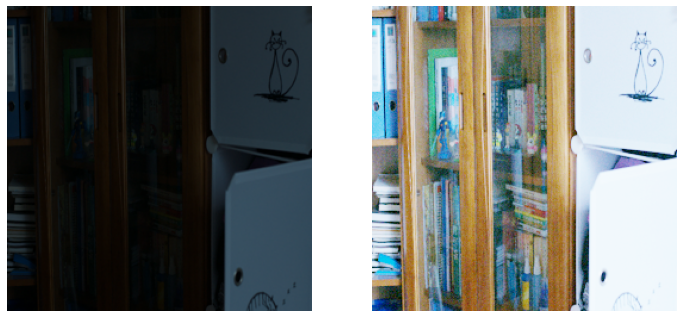

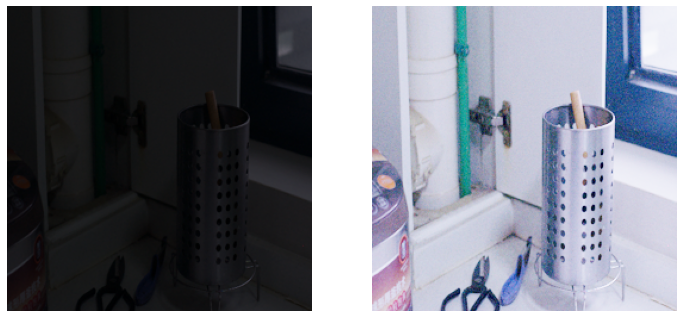

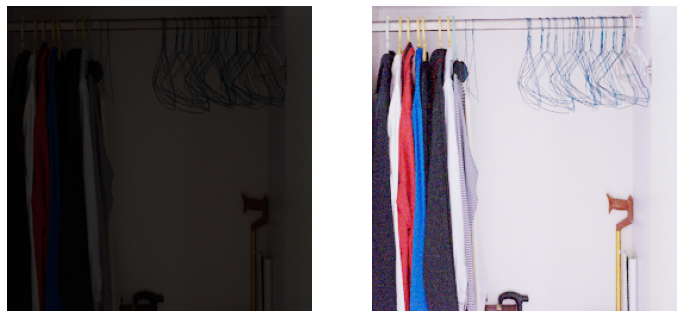

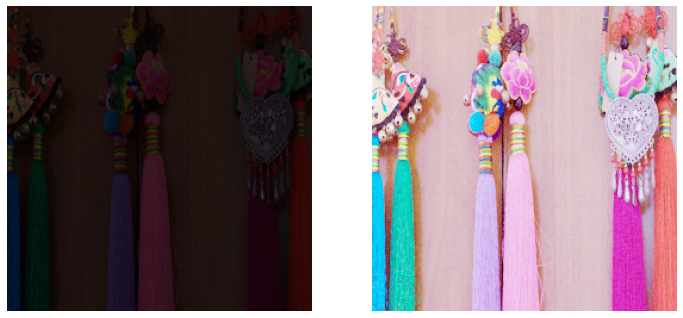

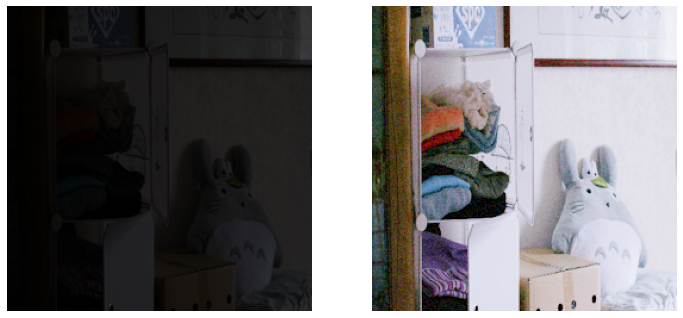

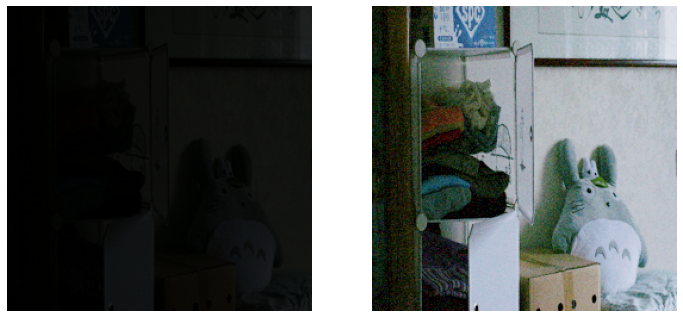

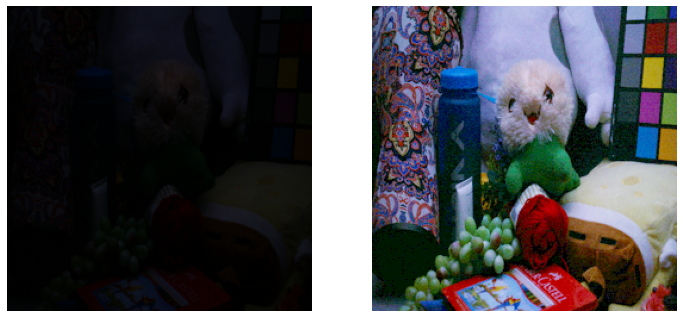

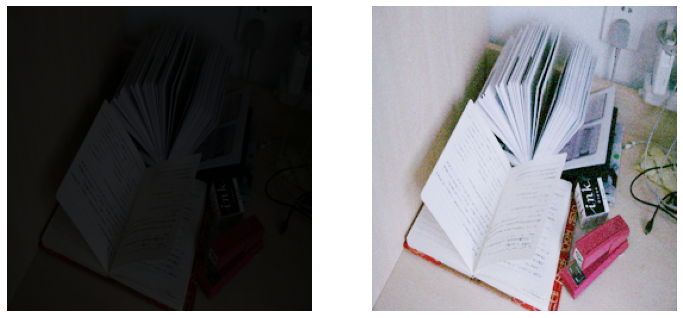

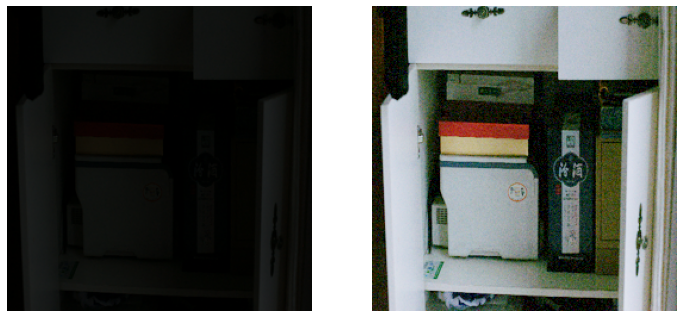

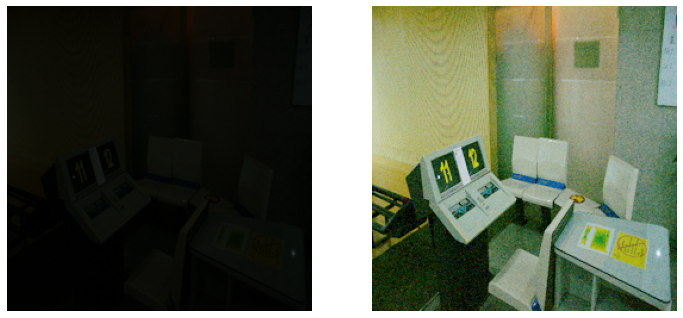

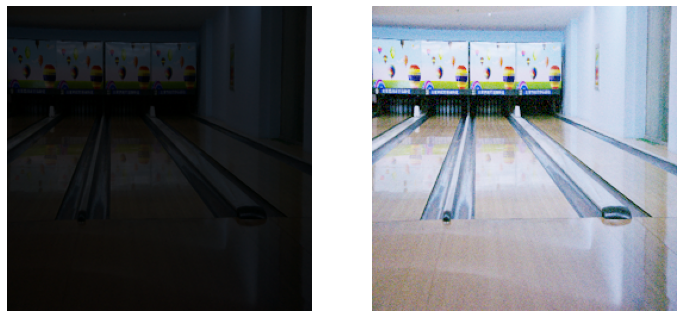

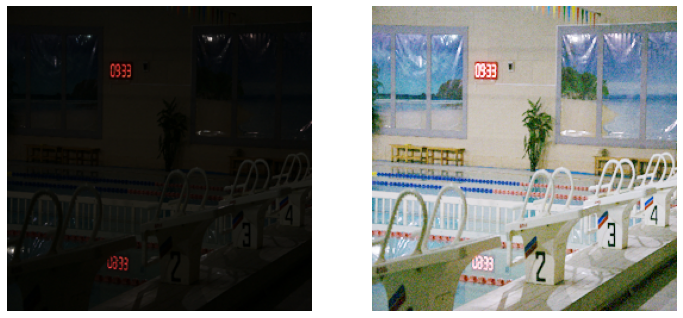

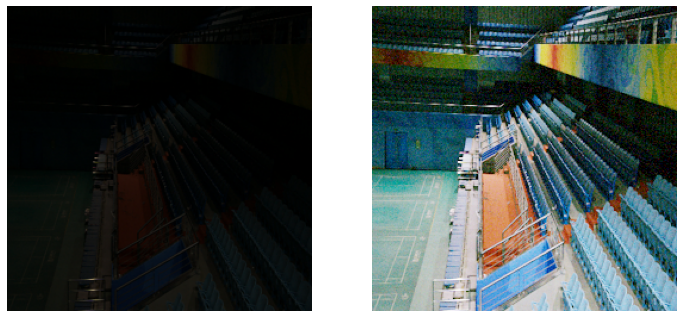

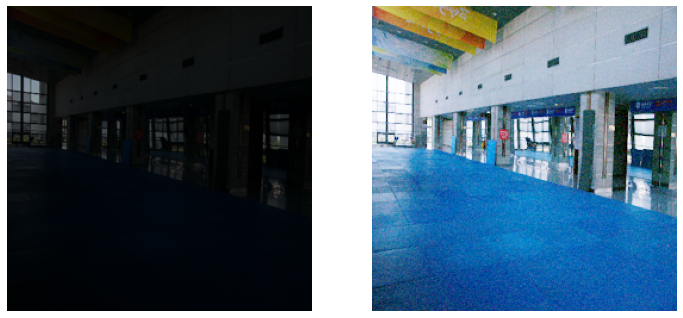

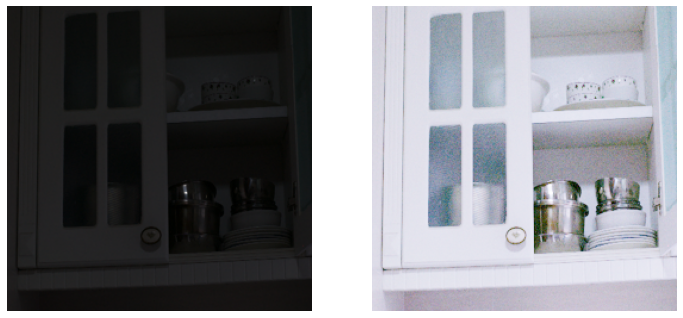

<Figure size 432x288 with 0 Axes>

In [111]:
for i, images in enumerate(zip(test_imgs, enhanced_imgs)):
    plot_results(images)
plt.savefig("sd")